'''
solve $u_t - u_{xx} = 0$ for $x \in [0,1]$ and $t \in [0,1]$ subject to

$u(x,0) = -0.5x^2 +2x -t -0.5$

$u(0,t) = -t$

$u(1,t) = 1-t$
'''

In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import timeit
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [2]:
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Exact Solution
def u(z):
    # z = (x, t)
    x = z[:, 0: 1]
    t = z[:, 1: 2]
    u = -1*0.5*x**2  + 2*x - t - 0.5
    return u

def u0(z):
    # Initial Condition
    x = z[:, 0: 1]
    h = -0.5*x**2 + 2*x - 0.5
    return h

def u0t(z):
    # Left Boundary Condition
    t = z[:, 1: 2]
    return [-_-0.5 for _ in t]

def u1t(z):
    #  Right Boundary Condition
    t = z[:, 1: 2]
    return [1-_ for _ in t]

In [4]:
# Domain boundaries
ic_coords = np.array([[0.0, 0.0],
                          [1.0, 0.0]])
lb_coords = np.array([[0.0, 0.0],
                          [0.0, 1.0]])
rb_coords = np.array([[1.0, 0.0],
                           [1.0, 1.0]])
res_coords = np.array([[0.0, 0.0],
                           [1.0, 1.0]])

In [5]:
class DataGen:
    # Initialize the class
    def __init__(self, dim, coords, func=lambda x: np.zeros(len(x)), name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def datagen(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * \
        np.random.uniform(0, 1, size=(N, self.dim))
        y = self.func(x)
        return x, y

In [6]:
# Create boundary conditions data generator
ics_data = DataGen(2, ic_coords, lambda x: u0(x), name='Initial Condition')
lbs_data = DataGen(2, lb_coords, lambda x: u0t(x), name='Left Boundary Condition')  
rbs_data = DataGen(2, rb_coords, lambda x: u1t(x), name='Right Boundary Condition') 

# Create residual data generator
res_data = DataGen(2, res_coords, name='Residual')

In [7]:
class Model:
    def __init__(self, layers_u, ics_data, lbs_data, rbs_data, res_data):
        # Normalization constants
        X, _ = res_data.datagen(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_t, self.sigma_t = self.mu_X[1], self.sigma_X[1]

        # data
        self.ics_data = ics_data
        self.rbs_data = rbs_data
        self.lbs_data = lbs_data
        self.res_data = res_data

        # initialise network weights and biases
        self.layers_u = layers_u
        self.weights_u, self.biases_u = self.initialise_NN(layers_u)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_0_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_rb_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_rb_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_rb_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_lb_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_lb_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Evaluate predictions
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf)

        self.u_0_pred = self.net_u(self.x_0_tf, self.t_0_tf)
        self.u_rb_pred = self.net_u(self.x_rb_tf, self.t_rb_tf)
        self.u_lb_pred = self.net_u(self.x_lb_tf, self.t_lb_tf)

        self.r_u_pred = self.net_r_u(self.x_r_tf, self.t_r_tf)

        # Boundary loss and inital loss
        self.loss_u_0 = tf.reduce_mean(tf.square(self.u_0_pred - self.u_0_tf))
        self.loss_urb = tf.reduce_mean(tf.square(self.u_rb_pred - self.u_rb_tf))
        self.loss_ulb = tf.reduce_mean(tf.square(self.u_lb_pred - self.u_lb_tf))

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_u_pred))

        # Total loss
        self.loss_ics = self.loss_u_0
        self.loss_bcs = 0.7*self.loss_ulb + 0.3*self.loss_urb
        self.loss = 0.5*self.loss_bcs + 0.25*self.loss_ics + 0.25*self.loss_res

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.99, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate)\
        .minimize(self.loss, global_step=self.global_step)

        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.loss_log = []
        self.saver = tf.train.Saver()

        # initialise Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # initialise network weights and biases using Xavier initialization
    def initialise_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass_u(self, H):
        num_layers = len(self.layers_u)
        for l in range(0, num_layers - 2):
            W = self.weights_u[l]
            b = self.biases_u[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights_u[-1]
        b = self.biases_u[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    # Evaluates the forward pass of u for each (x,t) pair.
    def net_u(self, x, t):
        u = self.forward_pass_u(tf.concat([x, t], 1)) # 1 is the axis
        # tf.concat([x,t], 1) gives each (x,t) pair
        return u

    # Forward pass for residual
    def net_r_u(self, x, t):
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0] / self.sigma_t
        u_x = tf.gradients(u, x)[0] / self.sigma_x
        u_xx = tf.gradients(u_x, x)[0] / self.sigma_x
        residual = u_t - u_xx
        return residual

    def fetch_minibatch(self, data, N):
        X, Y = data.datagen(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):
        start_time = timeit.default_timer()
        starting_time = timeit.default_timer()
        for it in range(nIter):
            
            # Fetch boundary and Initial Condition mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_data, int(batch_size))
            X_lbs_batch, u_lbs_batch = self.fetch_minibatch(self.lbs_data, int(batch_size))
            X_rbs_batch, u_rbs_batch = self.fetch_minibatch(self.rbs_data, int(batch_size))
            
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_data, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_u_tf: X_res_batch[:, 0:1], self.t_u_tf: X_res_batch[:, 1:2],
                       self.x_0_tf: X_ics_batch[:, 0:1], self.t_0_tf: X_ics_batch[:, 1:2],
                       self.u_0_tf: u_ics_batch,
                       self.u_lb_tf: u_lbs_batch,
                       self.u_rb_tf: u_rbs_batch,
                       self.x_rb_tf: X_rbs_batch[:, 0:1],  self.t_rb_tf: X_rbs_batch[:, 1:2], 
                       self.x_lb_tf: X_lbs_batch[:, 0:1],  self.t_lb_tf: X_lbs_batch[:, 1:2], 
                       self.x_r_tf: X_res_batch[:, 0:1], self.t_r_tf: X_res_batch[:, 1:2]}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_ics_value, loss_bcs_value, loss_res_value \
                = self.sess.run([self.loss_ics, self.loss_bcs, self.loss_res], tf_dict)
                
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)
                self.loss_log.append(loss_value)

                print('It: %d, Loss: %.3e, Loss_ics: %.3e, Loss_bcs: %.3e, Loss_res: %.3e, \
                Time: %.2f' %
                      (it, loss_value, loss_ics_value, loss_bcs_value, loss_res_value, elapsed))
                start_time = timeit.default_timer()
                
        total_time = timeit.default_timer() - starting_time
        total_time_minutes = int(total_time/60)
        total_time_seconds = int(100*(total_time/60 - total_time_minutes))
        print('TOTAL TIME: {} MINUTES, {} SECONDS'.format(total_time_minutes, 
                                                                  total_time_seconds))

    # Predictions for u
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

In [8]:
# Define model
layers_u = [2, 50, 75, 50, 1]
model = Model(layers_u, ics_data, lbs_data, rbs_data, res_data)

model.train(nIter=200000, batch_size=512)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 2.514e-01, Loss_ics: 1.647e-01, Loss_bcs: 3.539e-01, Loss_res: 1.330e-01,                 Time: 0.33
It: 10, Loss: 1.076e-01, Loss_ics: 1.419e-01, Loss_bcs: 7.630e-02, Loss_res: 1.357e-01,                 Time: 0.08
It: 20, Loss: 7.669e-02, Loss_ics: 6.083e-02, Loss_bcs: 8.739e-02, Loss_res: 7.116e-02,                 Time: 0.08
It: 30, Loss: 6.762e-02, Loss_ics: 3.881e-02, Loss_bcs: 7.420e-02, Loss_res: 8.326e-02,                 Time: 0.08
It: 40, Loss: 5.313e-02, Loss_ics: 4.610e-02, Loss_bcs: 3.933e-02, Loss_res: 8.777e-02,                 Time: 0.29
It: 50, Loss: 5.100e-02, Loss_ics: 4.168e-02, Loss_bcs: 4.477e-02, Loss_res: 7.276e-02,                 Time: 0.31
It: 60, Loss: 4.348e-02, Loss_ics: 3.217e-02, Loss_bcs: 3.807e-02, Loss_res: 6.564e-02,                 Time: 0.08
It: 70, Loss: 3.799e-02, Loss_ics: 3.128e-02, Loss_bcs: 3.164e-02, Loss_res: 5.741e-02,                 

It: 710, Loss: 1.192e-04, Loss_ics: 8.673e-06, Loss_bcs: 5.298e-05, Loss_res: 3.620e-04,                 Time: 0.09
It: 720, Loss: 1.370e-04, Loss_ics: 1.043e-05, Loss_bcs: 6.106e-05, Loss_res: 4.154e-04,                 Time: 0.07
It: 730, Loss: 1.211e-04, Loss_ics: 8.776e-06, Loss_bcs: 4.906e-05, Loss_res: 3.775e-04,                 Time: 0.08
It: 740, Loss: 1.145e-04, Loss_ics: 1.037e-05, Loss_bcs: 4.853e-05, Loss_res: 3.505e-04,                 Time: 0.08
It: 750, Loss: 1.313e-04, Loss_ics: 1.174e-05, Loss_bcs: 6.647e-05, Loss_res: 3.804e-04,                 Time: 0.08
It: 760, Loss: 1.138e-04, Loss_ics: 1.336e-05, Loss_bcs: 5.086e-05, Loss_res: 3.402e-04,                 Time: 0.09
It: 770, Loss: 1.044e-04, Loss_ics: 1.323e-05, Loss_bcs: 4.742e-05, Loss_res: 3.094e-04,                 Time: 0.08
It: 780, Loss: 9.505e-05, Loss_ics: 3.849e-06, Loss_bcs: 5.121e-05, Loss_res: 2.739e-04,                 Time: 0.08
It: 790, Loss: 1.077e-04, Loss_ics: 1.036e-05, Loss_bcs: 4.815e-05, Loss

It: 1430, Loss: 3.076e-05, Loss_ics: 6.449e-06, Loss_bcs: 1.774e-05, Loss_res: 8.110e-05,                 Time: 0.08
It: 1440, Loss: 3.666e-05, Loss_ics: 1.318e-05, Loss_bcs: 1.772e-05, Loss_res: 9.801e-05,                 Time: 0.09
It: 1450, Loss: 2.510e-05, Loss_ics: 7.235e-06, Loss_bcs: 1.876e-05, Loss_res: 5.566e-05,                 Time: 0.09
It: 1460, Loss: 5.432e-05, Loss_ics: 1.718e-05, Loss_bcs: 2.692e-05, Loss_res: 1.463e-04,                 Time: 0.08
It: 1470, Loss: 4.078e-04, Loss_ics: 1.841e-04, Loss_bcs: 1.148e-04, Loss_res: 1.217e-03,                 Time: 0.09
It: 1480, Loss: 4.591e-05, Loss_ics: 1.310e-05, Loss_bcs: 2.175e-05, Loss_res: 1.270e-04,                 Time: 0.08
It: 1490, Loss: 8.203e-05, Loss_ics: 3.837e-05, Loss_bcs: 2.748e-05, Loss_res: 2.348e-04,                 Time: 0.09
It: 1500, Loss: 5.803e-05, Loss_ics: 1.865e-05, Loss_bcs: 2.212e-05, Loss_res: 1.692e-04,                 Time: 0.08
It: 1510, Loss: 2.769e-05, Loss_ics: 6.359e-06, Loss_bcs: 1.688e

It: 2150, Loss: 1.937e-05, Loss_ics: 2.282e-06, Loss_bcs: 1.479e-05, Loss_res: 4.560e-05,                 Time: 0.08
It: 2160, Loss: 4.719e-05, Loss_ics: 7.259e-06, Loss_bcs: 2.918e-05, Loss_res: 1.231e-04,                 Time: 0.08
It: 2170, Loss: 1.319e-04, Loss_ics: 6.687e-05, Loss_bcs: 4.293e-05, Loss_res: 3.749e-04,                 Time: 0.08
It: 2180, Loss: 8.970e-05, Loss_ics: 2.816e-05, Loss_bcs: 3.165e-05, Loss_res: 2.673e-04,                 Time: 0.08
It: 2190, Loss: 3.518e-05, Loss_ics: 1.024e-05, Loss_bcs: 1.830e-05, Loss_res: 9.390e-05,                 Time: 0.08
It: 2200, Loss: 1.463e-05, Loss_ics: 2.009e-06, Loss_bcs: 1.078e-05, Loss_res: 3.494e-05,                 Time: 0.10
It: 2210, Loss: 1.411e-05, Loss_ics: 4.680e-06, Loss_bcs: 1.032e-05, Loss_res: 3.114e-05,                 Time: 0.09
It: 2220, Loss: 3.451e-05, Loss_ics: 1.670e-05, Loss_bcs: 1.445e-05, Loss_res: 9.245e-05,                 Time: 0.08
It: 2230, Loss: 1.154e-05, Loss_ics: 3.577e-06, Loss_bcs: 9.871e

It: 2860, Loss: 1.171e-05, Loss_ics: 3.940e-06, Loss_bcs: 7.769e-06, Loss_res: 2.736e-05,                 Time: 0.07
It: 2870, Loss: 9.259e-06, Loss_ics: 2.714e-06, Loss_bcs: 7.071e-06, Loss_res: 2.018e-05,                 Time: 0.07
It: 2880, Loss: 1.873e-05, Loss_ics: 7.269e-06, Loss_bcs: 8.457e-06, Loss_res: 5.074e-05,                 Time: 0.07
It: 2890, Loss: 1.972e-05, Loss_ics: 6.150e-06, Loss_bcs: 1.244e-05, Loss_res: 4.785e-05,                 Time: 0.08
It: 2900, Loss: 5.528e-05, Loss_ics: 3.336e-05, Loss_bcs: 1.846e-05, Loss_res: 1.508e-04,                 Time: 0.09
It: 2910, Loss: 3.325e-05, Loss_ics: 9.819e-06, Loss_bcs: 1.198e-05, Loss_res: 9.921e-05,                 Time: 0.08
It: 2920, Loss: 2.444e-05, Loss_ics: 9.787e-06, Loss_bcs: 8.612e-06, Loss_res: 7.074e-05,                 Time: 0.08
It: 2930, Loss: 2.918e-05, Loss_ics: 1.629e-05, Loss_bcs: 1.021e-05, Loss_res: 8.000e-05,                 Time: 0.07
It: 2940, Loss: 2.233e-05, Loss_ics: 1.068e-05, Loss_bcs: 8.362e

It: 3590, Loss: 7.896e-05, Loss_ics: 4.002e-05, Loss_bcs: 2.450e-05, Loss_res: 2.268e-04,                 Time: 0.07
It: 3600, Loss: 1.130e-04, Loss_ics: 4.957e-05, Loss_bcs: 3.121e-05, Loss_res: 3.401e-04,                 Time: 0.07
It: 3610, Loss: 1.724e-05, Loss_ics: 1.046e-05, Loss_bcs: 8.447e-06, Loss_res: 4.161e-05,                 Time: 0.07
It: 3620, Loss: 3.211e-05, Loss_ics: 1.902e-05, Loss_bcs: 9.941e-06, Loss_res: 8.953e-05,                 Time: 0.07
It: 3630, Loss: 5.141e-05, Loss_ics: 3.498e-05, Loss_bcs: 2.034e-05, Loss_res: 1.300e-04,                 Time: 0.07
It: 3640, Loss: 1.851e-05, Loss_ics: 5.794e-06, Loss_bcs: 7.671e-06, Loss_res: 5.291e-05,                 Time: 0.07
It: 3650, Loss: 1.613e-04, Loss_ics: 7.298e-05, Loss_bcs: 3.483e-05, Loss_res: 5.026e-04,                 Time: 0.07
It: 3660, Loss: 3.540e-05, Loss_ics: 1.821e-05, Loss_bcs: 1.590e-05, Loss_res: 9.156e-05,                 Time: 0.07
It: 3670, Loss: 6.514e-05, Loss_ics: 2.822e-05, Loss_bcs: 1.333e

It: 4300, Loss: 2.172e-05, Loss_ics: 1.405e-05, Loss_bcs: 8.594e-06, Loss_res: 5.563e-05,                 Time: 0.10
It: 4310, Loss: 8.117e-06, Loss_ics: 3.678e-06, Loss_bcs: 4.282e-06, Loss_res: 2.022e-05,                 Time: 0.07
It: 4320, Loss: 1.297e-05, Loss_ics: 3.382e-06, Loss_bcs: 5.226e-06, Loss_res: 3.804e-05,                 Time: 0.07
It: 4330, Loss: 6.254e-06, Loss_ics: 2.571e-06, Loss_bcs: 3.974e-06, Loss_res: 1.450e-05,                 Time: 0.08
It: 4340, Loss: 6.935e-06, Loss_ics: 2.201e-06, Loss_bcs: 4.249e-06, Loss_res: 1.704e-05,                 Time: 0.07
It: 4350, Loss: 2.012e-05, Loss_ics: 5.644e-06, Loss_bcs: 1.052e-05, Loss_res: 5.380e-05,                 Time: 0.07
It: 4360, Loss: 3.388e-04, Loss_ics: 1.787e-04, Loss_bcs: 5.278e-05, Loss_res: 1.071e-03,                 Time: 0.07
It: 4370, Loss: 1.957e-05, Loss_ics: 5.579e-06, Loss_bcs: 5.927e-06, Loss_res: 6.086e-05,                 Time: 0.07
It: 4380, Loss: 1.238e-04, Loss_ics: 4.473e-05, Loss_bcs: 1.759e

It: 5010, Loss: 8.834e-06, Loss_ics: 8.571e-06, Loss_bcs: 4.987e-06, Loss_res: 1.679e-05,                 Time: 0.09
It: 5020, Loss: 8.651e-06, Loss_ics: 1.661e-06, Loss_bcs: 4.058e-06, Loss_res: 2.483e-05,                 Time: 0.09
It: 5030, Loss: 6.069e-06, Loss_ics: 2.070e-06, Loss_bcs: 3.730e-06, Loss_res: 1.475e-05,                 Time: 0.08
It: 5040, Loss: 9.467e-06, Loss_ics: 4.163e-07, Loss_bcs: 5.203e-06, Loss_res: 2.704e-05,                 Time: 0.10
It: 5050, Loss: 6.029e-06, Loss_ics: 4.521e-07, Loss_bcs: 3.909e-06, Loss_res: 1.585e-05,                 Time: 0.09
It: 5060, Loss: 8.748e-06, Loss_ics: 8.265e-07, Loss_bcs: 4.325e-06, Loss_res: 2.551e-05,                 Time: 0.10
It: 5070, Loss: 2.065e-05, Loss_ics: 9.297e-06, Loss_bcs: 9.521e-06, Loss_res: 5.424e-05,                 Time: 0.08
It: 5080, Loss: 5.047e-06, Loss_ics: 7.672e-07, Loss_bcs: 3.573e-06, Loss_res: 1.228e-05,                 Time: 0.07
It: 5090, Loss: 2.183e-05, Loss_ics: 1.246e-05, Loss_bcs: 6.853e

It: 5740, Loss: 8.055e-06, Loss_ics: 4.702e-06, Loss_bcs: 3.277e-06, Loss_res: 2.096e-05,                 Time: 0.10
It: 5750, Loss: 5.523e-06, Loss_ics: 8.419e-07, Loss_bcs: 3.474e-06, Loss_res: 1.430e-05,                 Time: 0.09
It: 5760, Loss: 3.332e-05, Loss_ics: 1.605e-05, Loss_bcs: 1.526e-05, Loss_res: 8.671e-05,                 Time: 0.11
It: 5770, Loss: 1.767e-05, Loss_ics: 1.067e-05, Loss_bcs: 1.212e-05, Loss_res: 3.576e-05,                 Time: 0.11
It: 5780, Loss: 6.382e-06, Loss_ics: 8.937e-07, Loss_bcs: 3.393e-06, Loss_res: 1.785e-05,                 Time: 0.12
It: 5790, Loss: 2.598e-05, Loss_ics: 1.557e-05, Loss_bcs: 9.496e-06, Loss_res: 6.937e-05,                 Time: 0.10
It: 5800, Loss: 6.413e-05, Loss_ics: 3.001e-05, Loss_bcs: 1.271e-05, Loss_res: 2.011e-04,                 Time: 0.10
It: 5810, Loss: 9.407e-05, Loss_ics: 6.254e-05, Loss_bcs: 4.507e-05, Loss_res: 2.236e-04,                 Time: 0.07
It: 5820, Loss: 1.228e-04, Loss_ics: 6.537e-05, Loss_bcs: 6.378e

It: 6460, Loss: 1.515e-05, Loss_ics: 7.725e-06, Loss_bcs: 4.799e-06, Loss_res: 4.329e-05,                 Time: 0.07
It: 6470, Loss: 6.830e-06, Loss_ics: 1.479e-06, Loss_bcs: 2.900e-06, Loss_res: 2.004e-05,                 Time: 0.08
It: 6480, Loss: 7.303e-06, Loss_ics: 3.980e-06, Loss_bcs: 3.137e-06, Loss_res: 1.896e-05,                 Time: 0.09
It: 6490, Loss: 7.490e-06, Loss_ics: 4.258e-06, Loss_bcs: 3.006e-06, Loss_res: 1.969e-05,                 Time: 0.08
It: 6500, Loss: 6.053e-06, Loss_ics: 5.402e-07, Loss_bcs: 2.485e-06, Loss_res: 1.870e-05,                 Time: 0.09
It: 6510, Loss: 3.985e-06, Loss_ics: 8.075e-07, Loss_bcs: 2.301e-06, Loss_res: 1.053e-05,                 Time: 0.09
It: 6520, Loss: 5.967e-06, Loss_ics: 8.651e-07, Loss_bcs: 2.700e-06, Loss_res: 1.760e-05,                 Time: 0.07
It: 6530, Loss: 8.105e-06, Loss_ics: 1.309e-06, Loss_bcs: 3.911e-06, Loss_res: 2.329e-05,                 Time: 0.07
It: 6540, Loss: 3.773e-06, Loss_ics: 4.590e-07, Loss_bcs: 2.758e

It: 7170, Loss: 3.950e-06, Loss_ics: 5.771e-07, Loss_bcs: 3.165e-06, Loss_res: 8.895e-06,                 Time: 0.08
It: 7180, Loss: 6.563e-05, Loss_ics: 3.208e-05, Loss_bcs: 9.762e-06, Loss_res: 2.109e-04,                 Time: 0.09
It: 7190, Loss: 3.999e-06, Loss_ics: 6.131e-07, Loss_bcs: 3.039e-06, Loss_res: 9.305e-06,                 Time: 0.10
It: 7200, Loss: 3.850e-06, Loss_ics: 2.327e-07, Loss_bcs: 2.426e-06, Loss_res: 1.031e-05,                 Time: 0.12
It: 7210, Loss: 2.538e-05, Loss_ics: 1.531e-05, Loss_bcs: 5.770e-06, Loss_res: 7.468e-05,                 Time: 0.13
It: 7220, Loss: 1.003e-04, Loss_ics: 5.321e-05, Loss_bcs: 1.658e-05, Loss_res: 3.149e-04,                 Time: 0.08
It: 7230, Loss: 2.177e-05, Loss_ics: 1.812e-05, Loss_bcs: 1.688e-05, Loss_res: 3.519e-05,                 Time: 0.12
It: 7240, Loss: 5.236e-05, Loss_ics: 6.691e-05, Loss_bcs: 3.078e-05, Loss_res: 8.097e-05,                 Time: 0.15
It: 7250, Loss: 1.405e-05, Loss_ics: 7.299e-07, Loss_bcs: 3.609e

It: 7890, Loss: 6.286e-05, Loss_ics: 4.475e-06, Loss_bcs: 2.038e-05, Loss_res: 2.062e-04,                 Time: 0.09
It: 7900, Loss: 2.208e-05, Loss_ics: 1.103e-05, Loss_bcs: 1.087e-05, Loss_res: 5.555e-05,                 Time: 0.08
It: 7910, Loss: 1.561e-05, Loss_ics: 9.708e-06, Loss_bcs: 3.284e-06, Loss_res: 4.616e-05,                 Time: 0.07
It: 7920, Loss: 1.119e-05, Loss_ics: 8.056e-06, Loss_bcs: 3.822e-06, Loss_res: 2.905e-05,                 Time: 0.08
It: 7930, Loss: 1.248e-05, Loss_ics: 5.795e-06, Loss_bcs: 3.704e-06, Loss_res: 3.670e-05,                 Time: 0.08
It: 7940, Loss: 9.319e-06, Loss_ics: 3.547e-06, Loss_bcs: 2.777e-06, Loss_res: 2.817e-05,                 Time: 0.08
It: 7950, Loss: 3.359e-06, Loss_ics: 6.140e-07, Loss_bcs: 2.058e-06, Loss_res: 8.706e-06,                 Time: 0.08
It: 7960, Loss: 2.661e-06, Loss_ics: 4.024e-07, Loss_bcs: 2.087e-06, Loss_res: 6.066e-06,                 Time: 0.09
It: 7970, Loss: 1.864e-05, Loss_ics: 4.304e-06, Loss_bcs: 3.093e

It: 8620, Loss: 2.917e-05, Loss_ics: 1.273e-05, Loss_bcs: 2.080e-05, Loss_res: 6.237e-05,                 Time: 0.08
It: 8630, Loss: 1.443e-05, Loss_ics: 4.489e-06, Loss_bcs: 3.097e-06, Loss_res: 4.703e-05,                 Time: 0.08
It: 8640, Loss: 2.574e-05, Loss_ics: 1.566e-05, Loss_bcs: 5.060e-06, Loss_res: 7.717e-05,                 Time: 0.08
It: 8650, Loss: 8.480e-06, Loss_ics: 8.068e-06, Loss_bcs: 7.995e-06, Loss_res: 9.863e-06,                 Time: 0.07
It: 8660, Loss: 1.057e-05, Loss_ics: 4.940e-07, Loss_bcs: 3.951e-06, Loss_res: 3.390e-05,                 Time: 0.07
It: 8670, Loss: 4.960e-06, Loss_ics: 1.902e-06, Loss_bcs: 2.092e-06, Loss_res: 1.375e-05,                 Time: 0.07
It: 8680, Loss: 9.414e-06, Loss_ics: 1.237e-05, Loss_bcs: 7.179e-06, Loss_res: 1.093e-05,                 Time: 0.08
It: 8690, Loss: 3.930e-05, Loss_ics: 2.098e-05, Loss_bcs: 1.389e-05, Loss_res: 1.084e-04,                 Time: 0.07
It: 8700, Loss: 8.067e-05, Loss_ics: 1.960e-06, Loss_bcs: 2.541e

It: 9340, Loss: 2.981e-06, Loss_ics: 1.688e-07, Loss_bcs: 2.152e-06, Loss_res: 7.450e-06,                 Time: 0.07
It: 9350, Loss: 2.142e-06, Loss_ics: 6.045e-07, Loss_bcs: 1.809e-06, Loss_res: 4.345e-06,                 Time: 0.07
It: 9360, Loss: 6.793e-06, Loss_ics: 2.365e-06, Loss_bcs: 2.129e-06, Loss_res: 2.055e-05,                 Time: 0.07
It: 9370, Loss: 3.620e-06, Loss_ics: 3.143e-06, Loss_bcs: 2.098e-06, Loss_res: 7.139e-06,                 Time: 0.07
It: 9380, Loss: 2.579e-06, Loss_ics: 1.179e-06, Loss_bcs: 1.680e-06, Loss_res: 5.778e-06,                 Time: 0.07
It: 9390, Loss: 2.926e-06, Loss_ics: 1.029e-06, Loss_bcs: 2.623e-06, Loss_res: 5.430e-06,                 Time: 0.07
It: 9400, Loss: 2.140e-05, Loss_ics: 5.547e-06, Loss_bcs: 3.663e-06, Loss_res: 7.272e-05,                 Time: 0.07
It: 9410, Loss: 9.315e-05, Loss_ics: 6.566e-05, Loss_bcs: 2.001e-05, Loss_res: 2.669e-04,                 Time: 0.07
It: 9420, Loss: 3.663e-05, Loss_ics: 1.138e-05, Loss_bcs: 1.956e

It: 10060, Loss: 1.607e-05, Loss_ics: 1.561e-05, Loss_bcs: 6.535e-06, Loss_res: 3.558e-05,                 Time: 0.09
It: 10070, Loss: 3.906e-06, Loss_ics: 1.659e-06, Loss_bcs: 1.695e-06, Loss_res: 1.058e-05,                 Time: 0.07
It: 10080, Loss: 6.590e-06, Loss_ics: 2.543e-06, Loss_bcs: 1.691e-06, Loss_res: 2.043e-05,                 Time: 0.07
It: 10090, Loss: 3.092e-06, Loss_ics: 1.366e-06, Loss_bcs: 1.793e-06, Loss_res: 7.417e-06,                 Time: 0.09
It: 10100, Loss: 1.514e-05, Loss_ics: 2.509e-06, Loss_bcs: 2.378e-06, Loss_res: 5.330e-05,                 Time: 0.07
It: 10110, Loss: 7.956e-05, Loss_ics: 8.746e-05, Loss_bcs: 5.324e-05, Loss_res: 1.243e-04,                 Time: 0.09
It: 10120, Loss: 5.357e-05, Loss_ics: 1.008e-05, Loss_bcs: 1.191e-05, Loss_res: 1.804e-04,                 Time: 0.08
It: 10130, Loss: 4.702e-05, Loss_ics: 6.536e-05, Loss_bcs: 2.159e-05, Loss_res: 7.955e-05,                 Time: 0.08
It: 10140, Loss: 7.359e-06, Loss_ics: 4.305e-06, Loss_bc

It: 10780, Loss: 7.183e-06, Loss_ics: 6.875e-06, Loss_bcs: 4.184e-06, Loss_res: 1.349e-05,                 Time: 0.09
It: 10790, Loss: 2.879e-06, Loss_ics: 2.476e-06, Loss_bcs: 1.759e-06, Loss_res: 5.522e-06,                 Time: 0.08
It: 10800, Loss: 1.654e-06, Loss_ics: 6.489e-07, Loss_bcs: 1.286e-06, Loss_res: 3.397e-06,                 Time: 0.08
It: 10810, Loss: 2.058e-06, Loss_ics: 2.169e-07, Loss_bcs: 1.315e-06, Loss_res: 5.384e-06,                 Time: 0.07
It: 10820, Loss: 2.117e-06, Loss_ics: 1.032e-06, Loss_bcs: 1.271e-06, Loss_res: 4.895e-06,                 Time: 0.07
It: 10830, Loss: 2.146e-06, Loss_ics: 1.117e-06, Loss_bcs: 1.461e-06, Loss_res: 4.546e-06,                 Time: 0.07
It: 10840, Loss: 3.792e-06, Loss_ics: 5.465e-07, Loss_bcs: 1.396e-06, Loss_res: 1.183e-05,                 Time: 0.08
It: 10850, Loss: 2.509e-05, Loss_ics: 3.480e-06, Loss_bcs: 3.458e-06, Loss_res: 8.997e-05,                 Time: 0.10
It: 10860, Loss: 7.399e-06, Loss_ics: 9.729e-06, Loss_bc

It: 11500, Loss: 2.578e-05, Loss_ics: 1.958e-05, Loss_bcs: 2.604e-05, Loss_res: 3.147e-05,                 Time: 0.09
It: 11510, Loss: 1.531e-05, Loss_ics: 2.215e-06, Loss_bcs: 6.010e-06, Loss_res: 4.702e-05,                 Time: 0.09
It: 11520, Loss: 1.124e-05, Loss_ics: 7.945e-06, Loss_bcs: 9.067e-06, Loss_res: 1.886e-05,                 Time: 0.10
It: 11530, Loss: 2.618e-06, Loss_ics: 9.219e-07, Loss_bcs: 2.058e-06, Loss_res: 5.435e-06,                 Time: 0.09
It: 11540, Loss: 5.368e-06, Loss_ics: 1.275e-06, Loss_bcs: 2.988e-06, Loss_res: 1.422e-05,                 Time: 0.09
It: 11550, Loss: 2.946e-06, Loss_ics: 2.877e-06, Loss_bcs: 1.746e-06, Loss_res: 5.416e-06,                 Time: 0.10
It: 11560, Loss: 2.458e-06, Loss_ics: 6.354e-07, Loss_bcs: 1.474e-06, Loss_res: 6.248e-06,                 Time: 0.10
It: 11570, Loss: 9.073e-06, Loss_ics: 1.901e-06, Loss_bcs: 2.010e-06, Loss_res: 3.037e-05,                 Time: 0.10
It: 11580, Loss: 8.118e-06, Loss_ics: 1.535e-06, Loss_bc

It: 12210, Loss: 4.640e-06, Loss_ics: 2.834e-06, Loss_bcs: 1.774e-06, Loss_res: 1.218e-05,                 Time: 0.08
It: 12220, Loss: 1.006e-05, Loss_ics: 1.473e-05, Loss_bcs: 1.075e-05, Loss_res: 4.024e-06,                 Time: 0.09
It: 12230, Loss: 2.058e-06, Loss_ics: 5.473e-07, Loss_bcs: 1.299e-06, Loss_res: 5.086e-06,                 Time: 0.08
It: 12240, Loss: 1.397e-06, Loss_ics: 4.256e-07, Loss_bcs: 1.054e-06, Loss_res: 3.052e-06,                 Time: 0.08
It: 12250, Loss: 2.297e-06, Loss_ics: 6.498e-07, Loss_bcs: 1.032e-06, Loss_res: 6.476e-06,                 Time: 0.09
It: 12260, Loss: 1.398e-06, Loss_ics: 1.233e-07, Loss_bcs: 1.195e-06, Loss_res: 3.079e-06,                 Time: 0.08
It: 12270, Loss: 2.963e-06, Loss_ics: 3.015e-07, Loss_bcs: 2.047e-06, Loss_res: 7.457e-06,                 Time: 0.08
It: 12280, Loss: 1.569e-06, Loss_ics: 6.119e-07, Loss_bcs: 1.122e-06, Loss_res: 3.419e-06,                 Time: 0.09
It: 12290, Loss: 4.941e-06, Loss_ics: 6.377e-06, Loss_bc

It: 12930, Loss: 5.633e-06, Loss_ics: 9.768e-07, Loss_bcs: 1.383e-06, Loss_res: 1.879e-05,                 Time: 0.08
It: 12940, Loss: 2.803e-06, Loss_ics: 4.067e-07, Loss_bcs: 1.267e-06, Loss_res: 8.271e-06,                 Time: 0.07
It: 12950, Loss: 7.088e-05, Loss_ics: 6.101e-07, Loss_bcs: 1.487e-05, Loss_res: 2.532e-04,                 Time: 0.08
It: 12960, Loss: 8.125e-05, Loss_ics: 1.312e-05, Loss_bcs: 1.162e-05, Loss_res: 2.887e-04,                 Time: 0.09
It: 12970, Loss: 5.591e-05, Loss_ics: 1.591e-05, Loss_bcs: 4.810e-06, Loss_res: 1.981e-04,                 Time: 0.08
It: 12980, Loss: 2.467e-05, Loss_ics: 4.147e-06, Loss_bcs: 5.468e-06, Loss_res: 8.361e-05,                 Time: 0.08
It: 12990, Loss: 9.207e-06, Loss_ics: 1.919e-06, Loss_bcs: 1.769e-06, Loss_res: 3.137e-05,                 Time: 0.08
It: 13000, Loss: 1.385e-06, Loss_ics: 1.891e-07, Loss_bcs: 1.138e-06, Loss_res: 3.075e-06,                 Time: 0.09
It: 13010, Loss: 4.779e-06, Loss_ics: 3.625e-06, Loss_bc

It: 13640, Loss: 2.578e-06, Loss_ics: 4.129e-07, Loss_bcs: 9.462e-07, Loss_res: 8.005e-06,                 Time: 0.07
It: 13650, Loss: 3.340e-06, Loss_ics: 9.250e-07, Loss_bcs: 1.087e-06, Loss_res: 1.026e-05,                 Time: 0.07
It: 13660, Loss: 3.254e-06, Loss_ics: 1.799e-06, Loss_bcs: 2.054e-06, Loss_res: 7.111e-06,                 Time: 0.08
It: 13670, Loss: 3.128e-05, Loss_ics: 2.582e-05, Loss_bcs: 8.769e-06, Loss_res: 8.177e-05,                 Time: 0.09
It: 13680, Loss: 5.884e-06, Loss_ics: 3.114e-06, Loss_bcs: 1.971e-06, Loss_res: 1.648e-05,                 Time: 0.09
It: 13690, Loss: 6.176e-06, Loss_ics: 4.080e-06, Loss_bcs: 4.212e-06, Loss_res: 1.220e-05,                 Time: 0.09
It: 13700, Loss: 3.743e-06, Loss_ics: 3.392e-06, Loss_bcs: 2.435e-06, Loss_res: 6.710e-06,                 Time: 0.08
It: 13710, Loss: 2.606e-06, Loss_ics: 1.278e-06, Loss_bcs: 1.179e-06, Loss_res: 6.789e-06,                 Time: 0.08
It: 13720, Loss: 5.929e-06, Loss_ics: 4.435e-06, Loss_bc

It: 14340, Loss: 8.572e-06, Loss_ics: 1.653e-06, Loss_bcs: 1.598e-06, Loss_res: 2.944e-05,                 Time: 0.07
It: 14350, Loss: 4.741e-06, Loss_ics: 5.226e-06, Loss_bcs: 2.204e-06, Loss_res: 9.331e-06,                 Time: 0.07
It: 14360, Loss: 1.562e-05, Loss_ics: 1.620e-06, Loss_bcs: 6.115e-06, Loss_res: 4.863e-05,                 Time: 0.08
It: 14370, Loss: 8.646e-06, Loss_ics: 7.229e-06, Loss_bcs: 4.094e-06, Loss_res: 1.917e-05,                 Time: 0.12
It: 14380, Loss: 5.847e-06, Loss_ics: 1.411e-06, Loss_bcs: 2.143e-06, Loss_res: 1.769e-05,                 Time: 0.21
It: 14390, Loss: 9.804e-06, Loss_ics: 1.178e-05, Loss_bcs: 5.962e-06, Loss_res: 1.551e-05,                 Time: 0.10
It: 14400, Loss: 8.512e-06, Loss_ics: 6.316e-07, Loss_bcs: 1.379e-06, Loss_res: 3.066e-05,                 Time: 0.08
It: 14410, Loss: 4.224e-06, Loss_ics: 1.712e-06, Loss_bcs: 2.127e-06, Loss_res: 1.093e-05,                 Time: 0.14
It: 14420, Loss: 4.490e-05, Loss_ics: 6.553e-06, Loss_bc

It: 15050, Loss: 1.023e-06, Loss_ics: 1.399e-07, Loss_bcs: 7.911e-07, Loss_res: 2.372e-06,                 Time: 0.10
It: 15060, Loss: 1.321e-06, Loss_ics: 3.852e-07, Loss_bcs: 8.170e-07, Loss_res: 3.266e-06,                 Time: 0.08
It: 15070, Loss: 1.212e-06, Loss_ics: 7.296e-07, Loss_bcs: 9.896e-07, Loss_res: 2.138e-06,                 Time: 0.09
It: 15080, Loss: 1.281e-06, Loss_ics: 4.249e-07, Loss_bcs: 8.019e-07, Loss_res: 3.096e-06,                 Time: 0.09
It: 15090, Loss: 1.816e-06, Loss_ics: 6.334e-07, Loss_bcs: 1.222e-06, Loss_res: 4.188e-06,                 Time: 0.08
It: 15100, Loss: 1.819e-06, Loss_ics: 9.213e-08, Loss_bcs: 1.021e-06, Loss_res: 5.142e-06,                 Time: 0.09
It: 15110, Loss: 5.166e-06, Loss_ics: 1.210e-06, Loss_bcs: 1.228e-06, Loss_res: 1.700e-05,                 Time: 0.10
It: 15120, Loss: 1.338e-05, Loss_ics: 1.037e-05, Loss_bcs: 4.510e-06, Loss_res: 3.412e-05,                 Time: 0.08
It: 15130, Loss: 2.430e-05, Loss_ics: 6.671e-06, Loss_bc

It: 15770, Loss: 6.561e-05, Loss_ics: 7.664e-07, Loss_bcs: 1.256e-05, Loss_res: 2.366e-04,                 Time: 0.08
It: 15780, Loss: 5.039e-06, Loss_ics: 8.839e-06, Loss_bcs: 2.759e-06, Loss_res: 5.799e-06,                 Time: 0.08
It: 15790, Loss: 2.567e-05, Loss_ics: 9.529e-06, Loss_bcs: 1.719e-05, Loss_res: 5.876e-05,                 Time: 0.07
It: 15800, Loss: 1.716e-05, Loss_ics: 5.265e-06, Loss_bcs: 9.221e-06, Loss_res: 4.492e-05,                 Time: 0.08
It: 15810, Loss: 6.268e-06, Loss_ics: 5.318e-06, Loss_bcs: 3.720e-06, Loss_res: 1.231e-05,                 Time: 0.08
It: 15820, Loss: 1.606e-06, Loss_ics: 1.298e-06, Loss_bcs: 1.065e-06, Loss_res: 2.995e-06,                 Time: 0.08
It: 15830, Loss: 1.373e-06, Loss_ics: 1.176e-06, Loss_bcs: 1.116e-06, Loss_res: 2.084e-06,                 Time: 0.08
It: 15840, Loss: 1.347e-06, Loss_ics: 6.794e-07, Loss_bcs: 1.077e-06, Loss_res: 2.554e-06,                 Time: 0.07
It: 15850, Loss: 1.903e-06, Loss_ics: 1.315e-06, Loss_bc

It: 16490, Loss: 2.679e-05, Loss_ics: 2.291e-05, Loss_bcs: 5.829e-06, Loss_res: 7.258e-05,                 Time: 0.08
It: 16500, Loss: 1.999e-05, Loss_ics: 7.518e-07, Loss_bcs: 7.547e-06, Loss_res: 6.412e-05,                 Time: 0.08
It: 16510, Loss: 3.968e-06, Loss_ics: 1.907e-06, Loss_bcs: 3.677e-06, Loss_res: 6.609e-06,                 Time: 0.08
It: 16520, Loss: 8.186e-06, Loss_ics: 6.603e-06, Loss_bcs: 8.538e-06, Loss_res: 9.066e-06,                 Time: 0.11
It: 16530, Loss: 9.873e-06, Loss_ics: 3.709e-06, Loss_bcs: 8.068e-06, Loss_res: 1.965e-05,                 Time: 0.12
It: 16540, Loss: 2.824e-05, Loss_ics: 2.306e-05, Loss_bcs: 7.184e-06, Loss_res: 7.556e-05,                 Time: 0.10
It: 16550, Loss: 3.739e-06, Loss_ics: 2.796e-07, Loss_bcs: 2.852e-06, Loss_res: 8.972e-06,                 Time: 0.08
It: 16560, Loss: 1.629e-05, Loss_ics: 1.469e-05, Loss_bcs: 8.925e-06, Loss_res: 3.264e-05,                 Time: 0.08
It: 16570, Loss: 1.199e-05, Loss_ics: 1.002e-05, Loss_bc

It: 17210, Loss: 1.424e-05, Loss_ics: 2.070e-06, Loss_bcs: 2.031e-06, Loss_res: 5.084e-05,                 Time: 0.07
It: 17220, Loss: 1.136e-05, Loss_ics: 1.525e-05, Loss_bcs: 1.104e-05, Loss_res: 8.133e-06,                 Time: 0.07
It: 17230, Loss: 3.606e-06, Loss_ics: 3.123e-06, Loss_bcs: 3.317e-06, Loss_res: 4.667e-06,                 Time: 0.07
It: 17240, Loss: 2.284e-05, Loss_ics: 6.370e-06, Loss_bcs: 3.610e-06, Loss_res: 7.777e-05,                 Time: 0.07
It: 17250, Loss: 3.729e-05, Loss_ics: 2.687e-05, Loss_bcs: 9.186e-06, Loss_res: 1.039e-04,                 Time: 0.07
It: 17260, Loss: 1.072e-05, Loss_ics: 2.317e-06, Loss_bcs: 1.289e-06, Loss_res: 3.799e-05,                 Time: 0.07
It: 17270, Loss: 1.116e-05, Loss_ics: 4.290e-06, Loss_bcs: 2.629e-06, Loss_res: 3.510e-05,                 Time: 0.07
It: 17280, Loss: 1.487e-05, Loss_ics: 1.122e-06, Loss_bcs: 4.514e-06, Loss_res: 4.934e-05,                 Time: 0.07
It: 17290, Loss: 2.604e-05, Loss_ics: 1.056e-06, Loss_bc

It: 17910, Loss: 8.958e-07, Loss_ics: 7.275e-08, Loss_bcs: 8.227e-07, Loss_res: 1.865e-06,                 Time: 0.08
It: 17920, Loss: 1.147e-06, Loss_ics: 8.913e-07, Loss_bcs: 9.318e-07, Loss_res: 1.835e-06,                 Time: 0.07
It: 17930, Loss: 1.106e-06, Loss_ics: 2.095e-07, Loss_bcs: 1.193e-06, Loss_res: 1.828e-06,                 Time: 0.07
It: 17940, Loss: 1.279e-06, Loss_ics: 6.863e-07, Loss_bcs: 1.256e-06, Loss_res: 1.919e-06,                 Time: 0.08
It: 17950, Loss: 8.174e-07, Loss_ics: 4.016e-07, Loss_bcs: 7.018e-07, Loss_res: 1.464e-06,                 Time: 0.10
It: 17960, Loss: 1.834e-06, Loss_ics: 8.032e-07, Loss_bcs: 8.553e-07, Loss_res: 4.824e-06,                 Time: 0.08
It: 17970, Loss: 2.454e-06, Loss_ics: 3.295e-06, Loss_bcs: 2.126e-06, Loss_res: 2.270e-06,                 Time: 0.08
It: 17980, Loss: 1.091e-05, Loss_ics: 1.732e-05, Loss_bcs: 1.121e-05, Loss_res: 3.886e-06,                 Time: 0.08
It: 17990, Loss: 7.212e-05, Loss_ics: 9.043e-05, Loss_bc

It: 18630, Loss: 1.433e-06, Loss_ics: 7.767e-07, Loss_bcs: 1.279e-06, Loss_res: 2.397e-06,                 Time: 0.10
It: 18640, Loss: 1.756e-06, Loss_ics: 8.381e-07, Loss_bcs: 8.937e-07, Loss_res: 4.400e-06,                 Time: 0.08
It: 18650, Loss: 9.620e-07, Loss_ics: 5.453e-07, Loss_bcs: 8.108e-07, Loss_res: 1.681e-06,                 Time: 0.10
It: 18660, Loss: 4.547e-06, Loss_ics: 1.825e-06, Loss_bcs: 1.140e-06, Loss_res: 1.408e-05,                 Time: 0.07
It: 18670, Loss: 1.348e-05, Loss_ics: 1.987e-06, Loss_bcs: 1.986e-06, Loss_res: 4.795e-05,                 Time: 0.09
It: 18680, Loss: 1.293e-04, Loss_ics: 2.652e-05, Loss_bcs: 1.976e-05, Loss_res: 4.513e-04,                 Time: 0.09
It: 18690, Loss: 2.748e-05, Loss_ics: 4.160e-05, Loss_bcs: 3.180e-05, Loss_res: 4.707e-06,                 Time: 0.08
It: 18700, Loss: 7.983e-06, Loss_ics: 1.268e-05, Loss_bcs: 5.922e-06, Loss_res: 7.409e-06,                 Time: 0.07
It: 18710, Loss: 3.870e-06, Loss_ics: 2.779e-07, Loss_bc

It: 19330, Loss: 2.014e-05, Loss_ics: 2.486e-05, Loss_bcs: 1.926e-05, Loss_res: 1.720e-05,                 Time: 0.07
It: 19340, Loss: 1.708e-05, Loss_ics: 1.117e-06, Loss_bcs: 8.207e-06, Loss_res: 5.077e-05,                 Time: 0.07
It: 19350, Loss: 3.146e-06, Loss_ics: 9.330e-07, Loss_bcs: 1.531e-06, Loss_res: 8.588e-06,                 Time: 0.07
It: 19360, Loss: 6.570e-06, Loss_ics: 1.555e-06, Loss_bcs: 1.249e-06, Loss_res: 2.223e-05,                 Time: 0.07
It: 19370, Loss: 1.648e-06, Loss_ics: 8.577e-08, Loss_bcs: 1.127e-06, Loss_res: 4.251e-06,                 Time: 0.07
It: 19380, Loss: 1.774e-06, Loss_ics: 2.082e-07, Loss_bcs: 1.124e-06, Loss_res: 4.638e-06,                 Time: 0.08
It: 19390, Loss: 1.334e-06, Loss_ics: 2.305e-07, Loss_bcs: 6.647e-07, Loss_res: 3.778e-06,                 Time: 0.08
It: 19400, Loss: 2.354e-06, Loss_ics: 6.900e-08, Loss_bcs: 9.669e-07, Loss_res: 7.414e-06,                 Time: 0.07
It: 19410, Loss: 1.854e-06, Loss_ics: 1.683e-06, Loss_bc

It: 20050, Loss: 1.738e-05, Loss_ics: 2.773e-06, Loss_bcs: 3.870e-06, Loss_res: 5.900e-05,                 Time: 0.07
It: 20060, Loss: 7.352e-06, Loss_ics: 2.495e-06, Loss_bcs: 4.384e-06, Loss_res: 1.814e-05,                 Time: 0.08
It: 20070, Loss: 3.183e-06, Loss_ics: 1.839e-07, Loss_bcs: 1.006e-06, Loss_res: 1.054e-05,                 Time: 0.11
It: 20080, Loss: 8.793e-06, Loss_ics: 2.662e-06, Loss_bcs: 3.505e-06, Loss_res: 2.550e-05,                 Time: 0.11
It: 20090, Loss: 4.876e-06, Loss_ics: 1.110e-07, Loss_bcs: 1.968e-06, Loss_res: 1.546e-05,                 Time: 0.11
It: 20100, Loss: 2.116e-05, Loss_ics: 2.067e-05, Loss_bcs: 9.586e-06, Loss_res: 4.478e-05,                 Time: 0.09
It: 20110, Loss: 3.486e-06, Loss_ics: 1.974e-06, Loss_bcs: 1.545e-06, Loss_res: 8.882e-06,                 Time: 0.08
It: 20120, Loss: 1.317e-05, Loss_ics: 1.277e-05, Loss_bcs: 7.003e-06, Loss_res: 2.591e-05,                 Time: 0.09
It: 20130, Loss: 6.517e-06, Loss_ics: 1.995e-06, Loss_bc

It: 20750, Loss: 8.248e-07, Loss_ics: 1.121e-07, Loss_bcs: 8.672e-07, Loss_res: 1.453e-06,                 Time: 0.08
It: 20760, Loss: 1.832e-06, Loss_ics: 1.352e-06, Loss_bcs: 1.306e-06, Loss_res: 3.366e-06,                 Time: 0.08
It: 20770, Loss: 3.634e-05, Loss_ics: 5.194e-05, Loss_bcs: 2.897e-05, Loss_res: 3.550e-05,                 Time: 0.07
It: 20780, Loss: 8.193e-05, Loss_ics: 1.187e-05, Loss_bcs: 5.511e-06, Loss_res: 3.048e-04,                 Time: 0.07
It: 20790, Loss: 1.665e-05, Loss_ics: 7.609e-07, Loss_bcs: 7.800e-06, Loss_res: 5.025e-05,                 Time: 0.07
It: 20800, Loss: 5.193e-06, Loss_ics: 2.057e-06, Loss_bcs: 1.079e-06, Loss_res: 1.655e-05,                 Time: 0.07
It: 20810, Loss: 5.971e-06, Loss_ics: 6.054e-06, Loss_bcs: 4.264e-06, Loss_res: 9.301e-06,                 Time: 0.07
It: 20820, Loss: 9.548e-07, Loss_ics: 1.334e-07, Loss_bcs: 9.140e-07, Loss_res: 1.858e-06,                 Time: 0.07
It: 20830, Loss: 2.243e-06, Loss_ics: 6.492e-07, Loss_bc

It: 21470, Loss: 3.753e-06, Loss_ics: 4.050e-06, Loss_bcs: 3.143e-06, Loss_res: 4.674e-06,                 Time: 0.09
It: 21480, Loss: 6.184e-06, Loss_ics: 6.858e-08, Loss_bcs: 1.389e-06, Loss_res: 2.189e-05,                 Time: 0.09
It: 21490, Loss: 4.615e-05, Loss_ics: 5.765e-05, Loss_bcs: 2.134e-05, Loss_res: 8.428e-05,                 Time: 0.09
It: 21500, Loss: 1.809e-06, Loss_ics: 1.470e-06, Loss_bcs: 1.307e-06, Loss_res: 3.153e-06,                 Time: 0.07
It: 21510, Loss: 1.894e-06, Loss_ics: 2.599e-06, Loss_bcs: 1.612e-06, Loss_res: 1.753e-06,                 Time: 0.09
It: 21520, Loss: 2.299e-06, Loss_ics: 3.960e-07, Loss_bcs: 6.847e-07, Loss_res: 7.429e-06,                 Time: 0.08
It: 21530, Loss: 3.656e-06, Loss_ics: 3.852e-08, Loss_bcs: 1.931e-06, Loss_res: 1.072e-05,                 Time: 0.07
It: 21540, Loss: 4.279e-06, Loss_ics: 4.177e-06, Loss_bcs: 2.593e-06, Loss_res: 7.752e-06,                 Time: 0.07
It: 21550, Loss: 6.666e-06, Loss_ics: 2.017e-07, Loss_bc

It: 22180, Loss: 5.886e-06, Loss_ics: 1.965e-06, Loss_bcs: 1.144e-06, Loss_res: 1.929e-05,                 Time: 0.08
It: 22190, Loss: 1.282e-04, Loss_ics: 5.286e-05, Loss_bcs: 2.901e-05, Loss_res: 4.020e-04,                 Time: 0.08
It: 22200, Loss: 5.396e-05, Loss_ics: 1.098e-05, Loss_bcs: 1.202e-05, Loss_res: 1.808e-04,                 Time: 0.07
It: 22210, Loss: 7.674e-06, Loss_ics: 7.691e-06, Loss_bcs: 6.131e-06, Loss_res: 1.074e-05,                 Time: 0.08
It: 22220, Loss: 6.031e-06, Loss_ics: 4.852e-07, Loss_bcs: 1.774e-06, Loss_res: 2.009e-05,                 Time: 0.07
It: 22230, Loss: 1.539e-06, Loss_ics: 1.169e-07, Loss_bcs: 8.056e-07, Loss_res: 4.429e-06,                 Time: 0.07
It: 22240, Loss: 1.100e-06, Loss_ics: 3.324e-07, Loss_bcs: 1.091e-06, Loss_res: 1.885e-06,                 Time: 0.08
It: 22250, Loss: 1.336e-06, Loss_ics: 2.099e-07, Loss_bcs: 1.076e-06, Loss_res: 2.980e-06,                 Time: 0.07
It: 22260, Loss: 6.206e-07, Loss_ics: 1.764e-07, Loss_bc

It: 22880, Loss: 1.138e-05, Loss_ics: 5.184e-06, Loss_bcs: 2.157e-06, Loss_res: 3.604e-05,                 Time: 0.09
It: 22890, Loss: 2.283e-06, Loss_ics: 4.500e-08, Loss_bcs: 1.066e-06, Loss_res: 6.956e-06,                 Time: 0.09
It: 22900, Loss: 2.552e-05, Loss_ics: 3.128e-05, Loss_bcs: 1.408e-05, Loss_res: 4.266e-05,                 Time: 0.09
It: 22910, Loss: 5.687e-06, Loss_ics: 7.964e-06, Loss_bcs: 4.317e-06, Loss_res: 6.151e-06,                 Time: 0.09
It: 22920, Loss: 1.845e-06, Loss_ics: 1.587e-07, Loss_bcs: 8.441e-07, Loss_res: 5.534e-06,                 Time: 0.09
It: 22930, Loss: 6.591e-07, Loss_ics: 9.329e-08, Loss_bcs: 5.730e-07, Loss_res: 1.397e-06,                 Time: 0.11
It: 22940, Loss: 1.412e-05, Loss_ics: 5.663e-06, Loss_bcs: 1.848e-06, Loss_res: 4.713e-05,                 Time: 0.07
It: 22950, Loss: 2.356e-05, Loss_ics: 1.972e-05, Loss_bcs: 7.325e-06, Loss_res: 5.987e-05,                 Time: 0.07
It: 22960, Loss: 1.083e-05, Loss_ics: 6.285e-06, Loss_bc

It: 23600, Loss: 1.710e-06, Loss_ics: 5.458e-07, Loss_bcs: 1.227e-06, Loss_res: 3.840e-06,                 Time: 0.07
It: 23610, Loss: 1.094e-06, Loss_ics: 7.231e-08, Loss_bcs: 6.086e-07, Loss_res: 3.086e-06,                 Time: 0.08
It: 23620, Loss: 3.665e-06, Loss_ics: 3.612e-07, Loss_bcs: 6.628e-07, Loss_res: 1.297e-05,                 Time: 0.07
It: 23630, Loss: 1.981e-05, Loss_ics: 8.497e-06, Loss_bcs: 2.545e-06, Loss_res: 6.564e-05,                 Time: 0.08
It: 23640, Loss: 3.413e-05, Loss_ics: 4.712e-05, Loss_bcs: 1.495e-05, Loss_res: 5.949e-05,                 Time: 0.08
It: 23650, Loss: 1.345e-05, Loss_ics: 1.114e-05, Loss_bcs: 1.006e-05, Loss_res: 2.256e-05,                 Time: 0.07
It: 23660, Loss: 6.105e-06, Loss_ics: 4.426e-06, Loss_bcs: 5.116e-06, Loss_res: 9.763e-06,                 Time: 0.07
It: 23670, Loss: 6.425e-06, Loss_ics: 6.750e-06, Loss_bcs: 5.708e-06, Loss_res: 7.536e-06,                 Time: 0.07
It: 23680, Loss: 5.708e-06, Loss_ics: 2.882e-06, Loss_bc

It: 24320, Loss: 1.322e-05, Loss_ics: 9.981e-06, Loss_bcs: 1.095e-05, Loss_res: 2.100e-05,                 Time: 0.08
It: 24330, Loss: 5.801e-06, Loss_ics: 7.546e-06, Loss_bcs: 3.564e-06, Loss_res: 8.530e-06,                 Time: 0.07
It: 24340, Loss: 1.095e-05, Loss_ics: 2.695e-06, Loss_bcs: 1.255e-06, Loss_res: 3.861e-05,                 Time: 0.07
It: 24350, Loss: 1.802e-05, Loss_ics: 3.971e-06, Loss_bcs: 5.970e-06, Loss_res: 5.618e-05,                 Time: 0.10
It: 24360, Loss: 2.163e-05, Loss_ics: 5.420e-06, Loss_bcs: 4.235e-06, Loss_res: 7.261e-05,                 Time: 0.10
It: 24370, Loss: 4.572e-06, Loss_ics: 1.919e-06, Loss_bcs: 1.152e-06, Loss_res: 1.407e-05,                 Time: 0.13
It: 24380, Loss: 5.708e-06, Loss_ics: 1.436e-07, Loss_bcs: 1.913e-06, Loss_res: 1.886e-05,                 Time: 0.09
It: 24390, Loss: 7.158e-06, Loss_ics: 3.808e-06, Loss_bcs: 6.941e-06, Loss_res: 1.094e-05,                 Time: 0.09
It: 24400, Loss: 1.120e-05, Loss_ics: 1.881e-05, Loss_bc

It: 25030, Loss: 3.700e-06, Loss_ics: 4.380e-07, Loss_bcs: 2.117e-06, Loss_res: 1.013e-05,                 Time: 0.11
It: 25040, Loss: 2.623e-06, Loss_ics: 1.274e-06, Loss_bcs: 2.259e-06, Loss_res: 4.700e-06,                 Time: 0.07
It: 25050, Loss: 7.060e-06, Loss_ics: 2.976e-06, Loss_bcs: 2.273e-06, Loss_res: 2.072e-05,                 Time: 0.07
It: 25060, Loss: 6.800e-06, Loss_ics: 2.629e-07, Loss_bcs: 1.853e-06, Loss_res: 2.323e-05,                 Time: 0.07
It: 25070, Loss: 3.062e-06, Loss_ics: 1.569e-07, Loss_bcs: 5.886e-07, Loss_res: 1.091e-05,                 Time: 0.09
It: 25080, Loss: 1.850e-05, Loss_ics: 1.050e-06, Loss_bcs: 3.492e-06, Loss_res: 6.598e-05,                 Time: 0.08
It: 25090, Loss: 3.061e-06, Loss_ics: 5.155e-08, Loss_bcs: 9.528e-07, Loss_res: 1.029e-05,                 Time: 0.09
It: 25100, Loss: 2.277e-06, Loss_ics: 7.068e-07, Loss_bcs: 6.399e-07, Loss_res: 7.121e-06,                 Time: 0.08
It: 25110, Loss: 1.313e-06, Loss_ics: 2.651e-07, Loss_bc

It: 25750, Loss: 2.049e-06, Loss_ics: 2.041e-07, Loss_bcs: 2.145e-06, Loss_res: 3.702e-06,                 Time: 0.07
It: 25760, Loss: 6.740e-06, Loss_ics: 2.029e-07, Loss_bcs: 2.977e-06, Loss_res: 2.080e-05,                 Time: 0.08
It: 25770, Loss: 1.073e-05, Loss_ics: 7.153e-07, Loss_bcs: 7.688e-07, Loss_res: 4.068e-05,                 Time: 0.08
It: 25780, Loss: 4.067e-06, Loss_ics: 1.312e-06, Loss_bcs: 1.753e-06, Loss_res: 1.145e-05,                 Time: 0.09
It: 25790, Loss: 3.277e-06, Loss_ics: 2.428e-06, Loss_bcs: 1.879e-06, Loss_res: 6.925e-06,                 Time: 0.08
It: 25800, Loss: 6.458e-06, Loss_ics: 1.965e-06, Loss_bcs: 3.875e-06, Loss_res: 1.612e-05,                 Time: 0.08
It: 25810, Loss: 9.364e-06, Loss_ics: 9.933e-06, Loss_bcs: 1.004e-05, Loss_res: 7.445e-06,                 Time: 0.08
It: 25820, Loss: 3.727e-06, Loss_ics: 1.695e-06, Loss_bcs: 1.472e-06, Loss_res: 1.027e-05,                 Time: 0.08
It: 25830, Loss: 3.379e-06, Loss_ics: 4.303e-06, Loss_bc

It: 26460, Loss: 4.214e-06, Loss_ics: 3.922e-06, Loss_bcs: 3.094e-06, Loss_res: 6.744e-06,                 Time: 0.10
It: 26470, Loss: 1.238e-05, Loss_ics: 2.006e-06, Loss_bcs: 3.101e-06, Loss_res: 4.130e-05,                 Time: 0.07
It: 26480, Loss: 1.809e-06, Loss_ics: 2.001e-07, Loss_bcs: 2.031e-06, Loss_res: 2.974e-06,                 Time: 0.08
It: 26490, Loss: 1.880e-05, Loss_ics: 2.264e-06, Loss_bcs: 1.948e-06, Loss_res: 6.906e-05,                 Time: 0.07
It: 26500, Loss: 3.541e-06, Loss_ics: 7.703e-07, Loss_bcs: 1.459e-06, Loss_res: 1.047e-05,                 Time: 0.07
It: 26510, Loss: 1.373e-06, Loss_ics: 1.074e-06, Loss_bcs: 6.359e-07, Loss_res: 3.147e-06,                 Time: 0.08
It: 26520, Loss: 2.346e-06, Loss_ics: 4.717e-07, Loss_bcs: 6.314e-07, Loss_res: 7.650e-06,                 Time: 0.08
It: 26530, Loss: 4.278e-06, Loss_ics: 2.055e-07, Loss_bcs: 1.098e-06, Loss_res: 1.471e-05,                 Time: 0.07
It: 26540, Loss: 1.459e-06, Loss_ics: 2.645e-07, Loss_bc

It: 27170, Loss: 2.488e-06, Loss_ics: 3.631e-06, Loss_bcs: 2.192e-06, Loss_res: 1.938e-06,                 Time: 0.08
It: 27180, Loss: 2.465e-06, Loss_ics: 7.526e-07, Loss_bcs: 6.979e-07, Loss_res: 7.712e-06,                 Time: 0.08
It: 27190, Loss: 5.621e-06, Loss_ics: 6.919e-06, Loss_bcs: 2.717e-06, Loss_res: 1.013e-05,                 Time: 0.08
It: 27200, Loss: 7.709e-06, Loss_ics: 7.472e-07, Loss_bcs: 1.357e-06, Loss_res: 2.738e-05,                 Time: 0.08
It: 27210, Loss: 8.450e-06, Loss_ics: 8.003e-06, Loss_bcs: 4.773e-06, Loss_res: 1.625e-05,                 Time: 0.08
It: 27220, Loss: 5.032e-05, Loss_ics: 3.281e-06, Loss_bcs: 1.617e-05, Loss_res: 1.657e-04,                 Time: 0.08
It: 27230, Loss: 6.049e-06, Loss_ics: 1.045e-06, Loss_bcs: 3.450e-06, Loss_res: 1.625e-05,                 Time: 0.09
It: 27240, Loss: 1.366e-05, Loss_ics: 1.491e-07, Loss_bcs: 2.044e-06, Loss_res: 5.041e-05,                 Time: 0.08
It: 27250, Loss: 8.157e-06, Loss_ics: 6.102e-06, Loss_bc

It: 27870, Loss: 1.098e-06, Loss_ics: 2.028e-07, Loss_bcs: 3.731e-07, Loss_res: 3.443e-06,                 Time: 0.08
It: 27880, Loss: 5.280e-06, Loss_ics: 4.038e-07, Loss_bcs: 9.159e-07, Loss_res: 1.888e-05,                 Time: 0.07
It: 27890, Loss: 2.971e-05, Loss_ics: 3.469e-07, Loss_bcs: 3.091e-06, Loss_res: 1.123e-04,                 Time: 0.07
It: 27900, Loss: 1.651e-05, Loss_ics: 2.904e-05, Loss_bcs: 1.763e-05, Loss_res: 1.765e-06,                 Time: 0.07
It: 27910, Loss: 1.208e-05, Loss_ics: 5.466e-06, Loss_bcs: 1.988e-06, Loss_res: 3.886e-05,                 Time: 0.07
It: 27920, Loss: 4.776e-06, Loss_ics: 1.764e-06, Loss_bcs: 3.169e-06, Loss_res: 1.100e-05,                 Time: 0.07
It: 27930, Loss: 1.462e-06, Loss_ics: 4.968e-07, Loss_bcs: 1.076e-06, Loss_res: 3.201e-06,                 Time: 0.07
It: 27940, Loss: 1.275e-06, Loss_ics: 5.180e-08, Loss_bcs: 6.613e-07, Loss_res: 3.725e-06,                 Time: 0.07
It: 27950, Loss: 1.775e-06, Loss_ics: 8.265e-07, Loss_bc

It: 28590, Loss: 1.159e-05, Loss_ics: 2.898e-07, Loss_bcs: 1.554e-06, Loss_res: 4.297e-05,                 Time: 0.07
It: 28600, Loss: 6.931e-06, Loss_ics: 7.408e-07, Loss_bcs: 2.266e-06, Loss_res: 2.245e-05,                 Time: 0.07
It: 28610, Loss: 4.614e-06, Loss_ics: 1.686e-06, Loss_bcs: 2.843e-06, Loss_res: 1.108e-05,                 Time: 0.07
It: 28620, Loss: 6.813e-06, Loss_ics: 1.457e-06, Loss_bcs: 3.182e-06, Loss_res: 1.943e-05,                 Time: 0.07
It: 28630, Loss: 5.709e-06, Loss_ics: 3.562e-06, Loss_bcs: 5.171e-06, Loss_res: 8.930e-06,                 Time: 0.07
It: 28640, Loss: 5.473e-06, Loss_ics: 8.076e-06, Loss_bcs: 5.651e-06, Loss_res: 2.513e-06,                 Time: 0.07
It: 28650, Loss: 2.905e-06, Loss_ics: 1.558e-06, Loss_bcs: 7.486e-07, Loss_res: 8.566e-06,                 Time: 0.10
It: 28660, Loss: 7.953e-07, Loss_ics: 1.347e-07, Loss_bcs: 3.769e-07, Loss_res: 2.293e-06,                 Time: 0.08
It: 28670, Loss: 1.630e-06, Loss_ics: 1.887e-06, Loss_bc

It: 29300, Loss: 1.746e-06, Loss_ics: 2.007e-06, Loss_bcs: 1.561e-06, Loss_res: 1.854e-06,                 Time: 0.10
It: 29310, Loss: 1.215e-05, Loss_ics: 1.159e-05, Loss_bcs: 5.545e-06, Loss_res: 2.593e-05,                 Time: 0.09
It: 29320, Loss: 2.738e-05, Loss_ics: 5.689e-06, Loss_bcs: 2.702e-06, Loss_res: 9.844e-05,                 Time: 0.09
It: 29330, Loss: 1.900e-05, Loss_ics: 9.171e-07, Loss_bcs: 1.412e-06, Loss_res: 7.227e-05,                 Time: 0.09
It: 29340, Loss: 3.039e-06, Loss_ics: 1.206e-07, Loss_bcs: 1.181e-06, Loss_res: 9.671e-06,                 Time: 0.09
It: 29350, Loss: 7.419e-06, Loss_ics: 3.782e-07, Loss_bcs: 1.387e-06, Loss_res: 2.652e-05,                 Time: 0.07
It: 29360, Loss: 7.089e-06, Loss_ics: 4.009e-06, Loss_bcs: 3.315e-06, Loss_res: 1.772e-05,                 Time: 0.08
It: 29370, Loss: 7.436e-06, Loss_ics: 1.186e-05, Loss_bcs: 7.817e-06, Loss_res: 2.246e-06,                 Time: 0.09
It: 29380, Loss: 9.006e-06, Loss_ics: 1.200e-05, Loss_bc

It: 30020, Loss: 4.029e-06, Loss_ics: 5.743e-06, Loss_bcs: 4.208e-06, Loss_res: 1.956e-06,                 Time: 0.08
It: 30030, Loss: 1.893e-05, Loss_ics: 1.863e-05, Loss_bcs: 1.814e-05, Loss_res: 2.081e-05,                 Time: 0.07
It: 30040, Loss: 2.569e-05, Loss_ics: 3.280e-05, Loss_bcs: 1.434e-05, Loss_res: 4.127e-05,                 Time: 0.10
It: 30050, Loss: 1.780e-05, Loss_ics: 1.673e-06, Loss_bcs: 5.869e-06, Loss_res: 5.777e-05,                 Time: 0.09
It: 30060, Loss: 6.140e-06, Loss_ics: 4.350e-06, Loss_bcs: 5.783e-06, Loss_res: 8.647e-06,                 Time: 0.07
It: 30070, Loss: 1.293e-06, Loss_ics: 8.183e-07, Loss_bcs: 7.998e-07, Loss_res: 2.753e-06,                 Time: 0.08
It: 30080, Loss: 2.107e-06, Loss_ics: 3.797e-07, Loss_bcs: 9.691e-07, Loss_res: 6.108e-06,                 Time: 0.10
It: 30090, Loss: 5.327e-07, Loss_ics: 4.216e-07, Loss_bcs: 5.190e-07, Loss_res: 6.713e-07,                 Time: 0.08
It: 30100, Loss: 6.244e-07, Loss_ics: 7.045e-08, Loss_bc

It: 30740, Loss: 1.071e-06, Loss_ics: 7.133e-07, Loss_bcs: 1.180e-06, Loss_res: 1.213e-06,                 Time: 0.08
It: 30750, Loss: 8.039e-07, Loss_ics: 4.614e-07, Loss_bcs: 7.201e-07, Loss_res: 1.314e-06,                 Time: 0.07
It: 30760, Loss: 2.777e-06, Loss_ics: 1.550e-07, Loss_bcs: 7.366e-07, Loss_res: 9.478e-06,                 Time: 0.08
It: 30770, Loss: 1.465e-05, Loss_ics: 1.868e-05, Loss_bcs: 9.010e-06, Loss_res: 2.189e-05,                 Time: 0.08
It: 30780, Loss: 3.017e-05, Loss_ics: 1.698e-06, Loss_bcs: 2.933e-06, Loss_res: 1.131e-04,                 Time: 0.10
It: 30790, Loss: 3.455e-06, Loss_ics: 7.630e-07, Loss_bcs: 6.709e-07, Loss_res: 1.171e-05,                 Time: 0.11
It: 30800, Loss: 1.318e-05, Loss_ics: 4.015e-07, Loss_bcs: 7.178e-07, Loss_res: 5.089e-05,                 Time: 0.08
It: 30810, Loss: 3.879e-06, Loss_ics: 2.933e-07, Loss_bcs: 6.259e-07, Loss_res: 1.397e-05,                 Time: 0.07
It: 30820, Loss: 5.765e-07, Loss_ics: 4.739e-07, Loss_bc

It: 31450, Loss: 8.468e-07, Loss_ics: 1.156e-06, Loss_bcs: 8.410e-07, Loss_res: 5.496e-07,                 Time: 0.08
It: 31460, Loss: 1.128e-06, Loss_ics: 1.382e-06, Loss_bcs: 1.178e-06, Loss_res: 7.717e-07,                 Time: 0.08
It: 31470, Loss: 2.148e-06, Loss_ics: 4.039e-07, Loss_bcs: 5.049e-07, Loss_res: 7.180e-06,                 Time: 0.08
It: 31480, Loss: 2.568e-05, Loss_ics: 2.044e-05, Loss_bcs: 6.072e-06, Loss_res: 7.013e-05,                 Time: 0.09
It: 31490, Loss: 6.376e-06, Loss_ics: 1.800e-06, Loss_bcs: 1.414e-06, Loss_res: 2.088e-05,                 Time: 0.08
It: 31500, Loss: 1.046e-06, Loss_ics: 8.254e-07, Loss_bcs: 1.324e-06, Loss_res: 7.091e-07,                 Time: 0.08
It: 31510, Loss: 2.947e-06, Loss_ics: 3.740e-06, Loss_bcs: 2.565e-06, Loss_res: 2.919e-06,                 Time: 0.08
It: 31520, Loss: 9.213e-07, Loss_ics: 7.920e-07, Loss_bcs: 4.918e-07, Loss_res: 1.909e-06,                 Time: 0.08
It: 31530, Loss: 1.492e-06, Loss_ics: 2.294e-06, Loss_bc

It: 32160, Loss: 9.163e-06, Loss_ics: 1.096e-05, Loss_bcs: 5.219e-06, Loss_res: 1.525e-05,                 Time: 0.10
It: 32170, Loss: 7.021e-05, Loss_ics: 7.325e-05, Loss_bcs: 4.470e-05, Loss_res: 1.182e-04,                 Time: 0.08
It: 32180, Loss: 6.351e-06, Loss_ics: 8.698e-06, Loss_bcs: 3.215e-06, Loss_res: 1.028e-05,                 Time: 0.07
It: 32190, Loss: 3.620e-05, Loss_ics: 3.720e-06, Loss_bcs: 7.632e-06, Loss_res: 1.258e-04,                 Time: 0.09
It: 32200, Loss: 1.291e-05, Loss_ics: 5.688e-06, Loss_bcs: 6.587e-06, Loss_res: 3.276e-05,                 Time: 0.07
It: 32210, Loss: 4.282e-06, Loss_ics: 7.884e-06, Loss_bcs: 3.064e-06, Loss_res: 3.117e-06,                 Time: 0.07
It: 32220, Loss: 1.993e-06, Loss_ics: 3.211e-06, Loss_bcs: 1.592e-06, Loss_res: 1.575e-06,                 Time: 0.07
It: 32230, Loss: 6.247e-07, Loss_ics: 3.293e-08, Loss_bcs: 3.997e-07, Loss_res: 1.667e-06,                 Time: 0.07
It: 32240, Loss: 8.292e-07, Loss_ics: 8.077e-07, Loss_bc

It: 32870, Loss: 4.611e-07, Loss_ics: 4.166e-07, Loss_bcs: 4.017e-07, Loss_res: 6.245e-07,                 Time: 0.10
It: 32880, Loss: 4.146e-07, Loss_ics: 2.422e-07, Loss_bcs: 3.747e-07, Loss_res: 6.667e-07,                 Time: 0.08
It: 32890, Loss: 3.807e-07, Loss_ics: 1.053e-07, Loss_bcs: 2.888e-07, Loss_res: 8.400e-07,                 Time: 0.08
It: 32900, Loss: 3.432e-07, Loss_ics: 1.657e-07, Loss_bcs: 3.328e-07, Loss_res: 5.415e-07,                 Time: 0.15
It: 32910, Loss: 4.717e-07, Loss_ics: 5.068e-07, Loss_bcs: 4.349e-07, Loss_res: 5.101e-07,                 Time: 0.11
It: 32920, Loss: 1.102e-06, Loss_ics: 8.984e-07, Loss_bcs: 1.315e-06, Loss_res: 8.796e-07,                 Time: 0.08
It: 32930, Loss: 1.010e-06, Loss_ics: 2.268e-07, Loss_bcs: 3.803e-07, Loss_res: 3.053e-06,                 Time: 0.07
It: 32940, Loss: 1.598e-06, Loss_ics: 1.319e-06, Loss_bcs: 1.538e-06, Loss_res: 1.996e-06,                 Time: 0.07
It: 32950, Loss: 2.906e-05, Loss_ics: 3.883e-05, Loss_bc

It: 33580, Loss: 6.011e-07, Loss_ics: 5.064e-07, Loss_bcs: 6.297e-07, Loss_res: 6.388e-07,                 Time: 0.08
It: 33590, Loss: 1.485e-06, Loss_ics: 1.647e-06, Loss_bcs: 1.579e-06, Loss_res: 1.136e-06,                 Time: 0.08
It: 33600, Loss: 4.016e-07, Loss_ics: 1.412e-07, Loss_bcs: 3.790e-07, Loss_res: 7.070e-07,                 Time: 0.08
It: 33610, Loss: 4.288e-07, Loss_ics: 1.496e-07, Loss_bcs: 3.041e-07, Loss_res: 9.573e-07,                 Time: 0.10
It: 33620, Loss: 3.237e-07, Loss_ics: 7.353e-08, Loss_bcs: 2.679e-07, Loss_res: 6.855e-07,                 Time: 0.10
It: 33630, Loss: 9.864e-06, Loss_ics: 1.729e-05, Loss_bcs: 1.011e-05, Loss_res: 1.957e-06,                 Time: 0.11
It: 33640, Loss: 7.797e-06, Loss_ics: 9.282e-06, Loss_bcs: 6.081e-06, Loss_res: 9.747e-06,                 Time: 0.09
It: 33650, Loss: 2.170e-06, Loss_ics: 1.235e-06, Loss_bcs: 1.988e-06, Loss_res: 3.471e-06,                 Time: 0.08
It: 33660, Loss: 2.893e-06, Loss_ics: 3.308e-06, Loss_bc

It: 34290, Loss: 8.047e-07, Loss_ics: 2.139e-07, Loss_bcs: 2.941e-07, Loss_res: 2.417e-06,                 Time: 0.07
It: 34300, Loss: 1.157e-05, Loss_ics: 3.966e-06, Loss_bcs: 1.367e-06, Loss_res: 3.960e-05,                 Time: 0.08
It: 34310, Loss: 3.975e-05, Loss_ics: 3.699e-05, Loss_bcs: 1.453e-05, Loss_res: 9.296e-05,                 Time: 0.07
It: 34320, Loss: 1.601e-05, Loss_ics: 2.028e-05, Loss_bcs: 1.838e-05, Loss_res: 7.006e-06,                 Time: 0.07
It: 34330, Loss: 2.348e-06, Loss_ics: 4.563e-06, Loss_bcs: 1.609e-06, Loss_res: 1.611e-06,                 Time: 0.07
It: 34340, Loss: 3.894e-06, Loss_ics: 3.220e-07, Loss_bcs: 7.732e-07, Loss_res: 1.371e-05,                 Time: 0.07
It: 34350, Loss: 3.951e-06, Loss_ics: 4.933e-07, Loss_bcs: 9.813e-07, Loss_res: 1.335e-05,                 Time: 0.07
It: 34360, Loss: 5.071e-06, Loss_ics: 8.054e-08, Loss_bcs: 5.943e-07, Loss_res: 1.901e-05,                 Time: 0.07
It: 34370, Loss: 1.705e-06, Loss_ics: 6.891e-07, Loss_bc

It: 35000, Loss: 5.234e-06, Loss_ics: 9.876e-06, Loss_bcs: 4.401e-06, Loss_res: 2.257e-06,                 Time: 0.09
It: 35010, Loss: 4.345e-06, Loss_ics: 4.404e-06, Loss_bcs: 1.675e-06, Loss_res: 9.627e-06,                 Time: 0.10
It: 35020, Loss: 8.012e-06, Loss_ics: 1.934e-06, Loss_bcs: 7.886e-07, Loss_res: 2.854e-05,                 Time: 0.09
It: 35030, Loss: 2.095e-06, Loss_ics: 1.614e-06, Loss_bcs: 8.832e-07, Loss_res: 4.999e-06,                 Time: 0.08
It: 35040, Loss: 7.049e-07, Loss_ics: 7.627e-07, Loss_bcs: 5.836e-07, Loss_res: 8.899e-07,                 Time: 0.08
It: 35050, Loss: 1.657e-06, Loss_ics: 2.662e-07, Loss_bcs: 2.978e-07, Loss_res: 5.767e-06,                 Time: 0.09
It: 35060, Loss: 1.138e-06, Loss_ics: 1.241e-07, Loss_bcs: 7.081e-07, Loss_res: 3.014e-06,                 Time: 0.08
It: 35070, Loss: 8.138e-07, Loss_ics: 8.823e-07, Loss_bcs: 8.237e-07, Loss_res: 7.257e-07,                 Time: 0.07
It: 35080, Loss: 2.887e-07, Loss_ics: 8.705e-08, Loss_bc

It: 35710, Loss: 8.874e-06, Loss_ics: 2.112e-06, Loss_bcs: 4.842e-06, Loss_res: 2.370e-05,                 Time: 0.10
It: 35720, Loss: 3.036e-06, Loss_ics: 3.425e-06, Loss_bcs: 2.883e-06, Loss_res: 2.953e-06,                 Time: 0.09
It: 35730, Loss: 8.651e-07, Loss_ics: 9.740e-07, Loss_bcs: 7.498e-07, Loss_res: 9.870e-07,                 Time: 0.09
It: 35740, Loss: 8.289e-06, Loss_ics: 8.192e-06, Loss_bcs: 3.431e-06, Loss_res: 1.810e-05,                 Time: 0.08
It: 35750, Loss: 2.084e-05, Loss_ics: 2.136e-05, Loss_bcs: 1.421e-05, Loss_res: 3.358e-05,                 Time: 0.08
It: 35760, Loss: 3.597e-06, Loss_ics: 2.240e-07, Loss_bcs: 5.108e-06, Loss_res: 3.947e-06,                 Time: 0.09
It: 35770, Loss: 1.888e-06, Loss_ics: 1.196e-06, Loss_bcs: 1.391e-06, Loss_res: 3.572e-06,                 Time: 0.09
It: 35780, Loss: 2.385e-06, Loss_ics: 4.311e-06, Loss_bcs: 1.837e-06, Loss_res: 1.558e-06,                 Time: 0.08
It: 35790, Loss: 3.845e-06, Loss_ics: 3.278e-06, Loss_bc

It: 36430, Loss: 3.833e-06, Loss_ics: 4.911e-06, Loss_bcs: 2.695e-06, Loss_res: 5.031e-06,                 Time: 0.08
It: 36440, Loss: 3.237e-06, Loss_ics: 2.433e-07, Loss_bcs: 9.177e-07, Loss_res: 1.087e-05,                 Time: 0.08
It: 36450, Loss: 2.232e-06, Loss_ics: 2.761e-06, Loss_bcs: 1.969e-06, Loss_res: 2.229e-06,                 Time: 0.08
It: 36460, Loss: 5.765e-07, Loss_ics: 1.606e-08, Loss_bcs: 4.013e-07, Loss_res: 1.487e-06,                 Time: 0.08
It: 36470, Loss: 4.219e-07, Loss_ics: 2.400e-07, Loss_bcs: 3.853e-07, Loss_res: 6.767e-07,                 Time: 0.08
It: 36480, Loss: 7.028e-07, Loss_ics: 2.303e-07, Loss_bcs: 4.484e-07, Loss_res: 1.684e-06,                 Time: 0.09
It: 36490, Loss: 2.021e-06, Loss_ics: 5.469e-08, Loss_bcs: 3.504e-07, Loss_res: 7.327e-06,                 Time: 0.08
It: 36500, Loss: 1.061e-06, Loss_ics: 1.693e-07, Loss_bcs: 3.177e-07, Loss_res: 3.439e-06,                 Time: 0.08
It: 36510, Loss: 8.063e-06, Loss_ics: 7.298e-07, Loss_bc

It: 37150, Loss: 3.307e-06, Loss_ics: 3.497e-06, Loss_bcs: 3.736e-06, Loss_res: 2.262e-06,                 Time: 0.10
It: 37160, Loss: 1.318e-05, Loss_ics: 1.531e-05, Loss_bcs: 9.127e-06, Loss_res: 1.917e-05,                 Time: 0.08
It: 37170, Loss: 2.288e-05, Loss_ics: 5.304e-06, Loss_bcs: 6.714e-06, Loss_res: 7.277e-05,                 Time: 0.09
It: 37180, Loss: 7.050e-06, Loss_ics: 5.831e-07, Loss_bcs: 2.948e-06, Loss_res: 2.172e-05,                 Time: 0.09
It: 37190, Loss: 1.576e-06, Loss_ics: 3.922e-07, Loss_bcs: 9.582e-07, Loss_res: 3.997e-06,                 Time: 0.08
It: 37200, Loss: 6.598e-06, Loss_ics: 1.234e-06, Loss_bcs: 6.955e-07, Loss_res: 2.377e-05,                 Time: 0.08
It: 37210, Loss: 3.151e-06, Loss_ics: 1.383e-06, Loss_bcs: 1.866e-06, Loss_res: 7.488e-06,                 Time: 0.08
It: 37220, Loss: 2.374e-06, Loss_ics: 2.560e-08, Loss_bcs: 3.884e-07, Loss_res: 8.694e-06,                 Time: 0.08
It: 37230, Loss: 9.614e-06, Loss_ics: 4.567e-06, Loss_bc

It: 37850, Loss: 4.507e-07, Loss_ics: 4.189e-08, Loss_bcs: 4.577e-07, Loss_res: 8.456e-07,                 Time: 0.09
It: 37860, Loss: 5.283e-06, Loss_ics: 8.494e-07, Loss_bcs: 1.736e-06, Loss_res: 1.681e-05,                 Time: 0.08
It: 37870, Loss: 2.080e-06, Loss_ics: 2.559e-06, Loss_bcs: 2.080e-06, Loss_res: 1.600e-06,                 Time: 0.09
It: 37880, Loss: 8.835e-07, Loss_ics: 1.372e-07, Loss_bcs: 3.101e-07, Loss_res: 2.776e-06,                 Time: 0.09
It: 37890, Loss: 1.243e-06, Loss_ics: 1.670e-06, Loss_bcs: 9.317e-07, Loss_res: 1.440e-06,                 Time: 0.08
It: 37900, Loss: 1.684e-06, Loss_ics: 1.873e-06, Loss_bcs: 1.180e-06, Loss_res: 2.504e-06,                 Time: 0.07
It: 37910, Loss: 1.185e-05, Loss_ics: 1.583e-05, Loss_bcs: 8.102e-06, Loss_res: 1.535e-05,                 Time: 0.07
It: 37920, Loss: 1.596e-05, Loss_ics: 1.860e-05, Loss_bcs: 7.155e-06, Loss_res: 3.094e-05,                 Time: 0.07
It: 37930, Loss: 7.951e-06, Loss_ics: 8.189e-06, Loss_bc

It: 38560, Loss: 6.325e-07, Loss_ics: 7.949e-07, Loss_bcs: 5.574e-07, Loss_res: 6.202e-07,                 Time: 0.10
It: 38570, Loss: 1.200e-06, Loss_ics: 6.788e-07, Loss_bcs: 1.261e-06, Loss_res: 1.599e-06,                 Time: 0.09
It: 38580, Loss: 3.697e-07, Loss_ics: 1.183e-07, Loss_bcs: 3.591e-07, Loss_res: 6.423e-07,                 Time: 0.07
It: 38590, Loss: 1.810e-06, Loss_ics: 2.853e-06, Loss_bcs: 1.929e-06, Loss_res: 5.279e-07,                 Time: 0.09
It: 38600, Loss: 6.834e-06, Loss_ics: 1.131e-05, Loss_bcs: 7.601e-06, Loss_res: 8.274e-07,                 Time: 0.09
It: 38610, Loss: 1.355e-06, Loss_ics: 1.610e-06, Loss_bcs: 1.643e-06, Loss_res: 5.241e-07,                 Time: 0.09
It: 38620, Loss: 5.748e-07, Loss_ics: 2.594e-07, Loss_bcs: 6.216e-07, Loss_res: 7.967e-07,                 Time: 0.09
It: 38630, Loss: 4.973e-06, Loss_ics: 8.187e-06, Loss_bcs: 5.265e-06, Loss_res: 1.173e-06,                 Time: 0.08
It: 38640, Loss: 2.343e-06, Loss_ics: 3.213e-06, Loss_bc

It: 39270, Loss: 6.383e-06, Loss_ics: 2.638e-06, Loss_bcs: 3.109e-06, Loss_res: 1.668e-05,                 Time: 0.08
It: 39280, Loss: 5.682e-06, Loss_ics: 9.120e-06, Loss_bcs: 5.710e-06, Loss_res: 2.189e-06,                 Time: 0.07
It: 39290, Loss: 1.319e-05, Loss_ics: 1.089e-06, Loss_bcs: 1.393e-06, Loss_res: 4.887e-05,                 Time: 0.08
It: 39300, Loss: 2.219e-06, Loss_ics: 4.165e-08, Loss_bcs: 9.254e-07, Loss_res: 6.985e-06,                 Time: 0.09
It: 39310, Loss: 1.552e-06, Loss_ics: 1.551e-06, Loss_bcs: 1.894e-06, Loss_res: 8.687e-07,                 Time: 0.09
It: 39320, Loss: 3.178e-06, Loss_ics: 2.152e-06, Loss_bcs: 8.688e-07, Loss_res: 8.821e-06,                 Time: 0.09
It: 39330, Loss: 7.495e-06, Loss_ics: 5.592e-06, Loss_bcs: 2.705e-06, Loss_res: 1.898e-05,                 Time: 0.08
It: 39340, Loss: 4.488e-06, Loss_ics: 7.765e-06, Loss_bcs: 4.360e-06, Loss_res: 1.467e-06,                 Time: 0.07
It: 39350, Loss: 9.205e-06, Loss_ics: 2.102e-06, Loss_bc

It: 39990, Loss: 6.660e-06, Loss_ics: 1.084e-05, Loss_bcs: 7.138e-06, Loss_res: 1.520e-06,                 Time: 0.07
It: 40000, Loss: 7.333e-06, Loss_ics: 5.877e-06, Loss_bcs: 3.517e-06, Loss_res: 1.642e-05,                 Time: 0.07
It: 40010, Loss: 3.860e-06, Loss_ics: 2.114e-06, Loss_bcs: 1.124e-06, Loss_res: 1.108e-05,                 Time: 0.09
It: 40020, Loss: 4.354e-07, Loss_ics: 2.047e-07, Loss_bcs: 2.241e-07, Loss_res: 1.089e-06,                 Time: 0.09
It: 40030, Loss: 2.677e-07, Loss_ics: 1.255e-07, Loss_bcs: 2.129e-07, Loss_res: 5.196e-07,                 Time: 0.07
It: 40040, Loss: 1.935e-06, Loss_ics: 5.179e-07, Loss_bcs: 2.809e-07, Loss_res: 6.658e-06,                 Time: 0.08
It: 40050, Loss: 2.746e-07, Loss_ics: 8.085e-08, Loss_bcs: 1.714e-07, Loss_res: 6.749e-07,                 Time: 0.07
It: 40060, Loss: 1.060e-05, Loss_ics: 5.031e-06, Loss_bcs: 1.618e-06, Loss_res: 3.415e-05,                 Time: 0.08
It: 40070, Loss: 1.015e-05, Loss_ics: 7.928e-06, Loss_bc

It: 40710, Loss: 7.886e-07, Loss_ics: 8.218e-08, Loss_bcs: 3.315e-07, Loss_res: 2.409e-06,                 Time: 0.08
It: 40720, Loss: 7.116e-07, Loss_ics: 2.152e-07, Loss_bcs: 3.541e-07, Loss_res: 1.923e-06,                 Time: 0.09
It: 40730, Loss: 2.298e-06, Loss_ics: 2.401e-06, Loss_bcs: 2.360e-06, Loss_res: 2.071e-06,                 Time: 0.08
It: 40740, Loss: 3.609e-06, Loss_ics: 6.082e-06, Loss_bcs: 3.867e-06, Loss_res: 6.182e-07,                 Time: 0.08
It: 40750, Loss: 4.532e-06, Loss_ics: 6.337e-07, Loss_bcs: 2.047e-06, Loss_res: 1.340e-05,                 Time: 0.09
It: 40760, Loss: 4.781e-06, Loss_ics: 8.493e-07, Loss_bcs: 4.550e-07, Loss_res: 1.736e-05,                 Time: 0.10
It: 40770, Loss: 7.283e-06, Loss_ics: 1.076e-05, Loss_bcs: 8.111e-06, Loss_res: 2.155e-06,                 Time: 0.11
It: 40780, Loss: 4.635e-06, Loss_ics: 6.759e-06, Loss_bcs: 5.432e-06, Loss_res: 9.181e-07,                 Time: 0.09
It: 40790, Loss: 2.857e-06, Loss_ics: 4.116e-06, Loss_bc

It: 41430, Loss: 5.861e-07, Loss_ics: 2.477e-07, Loss_bcs: 2.400e-07, Loss_res: 1.617e-06,                 Time: 0.08
It: 41440, Loss: 4.626e-07, Loss_ics: 2.945e-07, Loss_bcs: 2.465e-07, Loss_res: 1.063e-06,                 Time: 0.08
It: 41450, Loss: 7.147e-07, Loss_ics: 1.885e-07, Loss_bcs: 4.508e-07, Loss_res: 1.769e-06,                 Time: 0.09
It: 41460, Loss: 4.990e-07, Loss_ics: 6.006e-07, Loss_bcs: 5.022e-07, Loss_res: 3.909e-07,                 Time: 0.09
It: 41470, Loss: 3.294e-07, Loss_ics: 2.111e-07, Loss_bcs: 2.622e-07, Loss_res: 5.821e-07,                 Time: 0.07
It: 41480, Loss: 4.918e-07, Loss_ics: 4.062e-07, Loss_bcs: 2.981e-07, Loss_res: 9.649e-07,                 Time: 0.07
It: 41490, Loss: 3.446e-07, Loss_ics: 2.597e-07, Loss_bcs: 3.490e-07, Loss_res: 4.209e-07,                 Time: 0.08
It: 41500, Loss: 1.772e-06, Loss_ics: 2.584e-06, Loss_bcs: 1.543e-06, Loss_res: 1.420e-06,                 Time: 0.09
It: 41510, Loss: 1.543e-05, Loss_ics: 2.170e-05, Loss_bc

It: 42140, Loss: 9.134e-07, Loss_ics: 1.681e-07, Loss_bcs: 5.934e-07, Loss_res: 2.299e-06,                 Time: 0.09
It: 42150, Loss: 3.857e-06, Loss_ics: 6.003e-06, Loss_bcs: 3.725e-06, Loss_res: 1.975e-06,                 Time: 0.09
It: 42160, Loss: 4.619e-06, Loss_ics: 2.246e-06, Loss_bcs: 1.088e-06, Loss_res: 1.406e-05,                 Time: 0.08
It: 42170, Loss: 2.570e-06, Loss_ics: 3.390e-06, Loss_bcs: 2.539e-06, Loss_res: 1.813e-06,                 Time: 0.09
It: 42180, Loss: 1.392e-06, Loss_ics: 2.055e-07, Loss_bcs: 5.351e-07, Loss_res: 4.293e-06,                 Time: 0.09
It: 42190, Loss: 1.719e-05, Loss_ics: 1.322e-06, Loss_bcs: 1.322e-06, Loss_res: 6.479e-05,                 Time: 0.08
It: 42200, Loss: 2.778e-06, Loss_ics: 1.342e-06, Loss_bcs: 1.241e-06, Loss_res: 7.289e-06,                 Time: 0.08
It: 42210, Loss: 9.374e-06, Loss_ics: 3.973e-06, Loss_bcs: 3.496e-06, Loss_res: 2.653e-05,                 Time: 0.08
It: 42220, Loss: 3.336e-06, Loss_ics: 8.450e-07, Loss_bc

It: 42840, Loss: 4.057e-06, Loss_ics: 5.638e-07, Loss_bcs: 1.284e-06, Loss_res: 1.310e-05,                 Time: 0.11
It: 42850, Loss: 8.481e-07, Loss_ics: 4.475e-07, Loss_bcs: 2.787e-07, Loss_res: 2.388e-06,                 Time: 0.14
It: 42860, Loss: 2.000e-06, Loss_ics: 1.139e-08, Loss_bcs: 3.869e-07, Loss_res: 7.213e-06,                 Time: 0.11
It: 42870, Loss: 2.250e-06, Loss_ics: 1.078e-06, Loss_bcs: 1.500e-06, Loss_res: 4.923e-06,                 Time: 0.09
It: 42880, Loss: 5.970e-07, Loss_ics: 4.945e-07, Loss_bcs: 6.259e-07, Loss_res: 6.418e-07,                 Time: 0.13
It: 42890, Loss: 4.426e-07, Loss_ics: 5.139e-07, Loss_bcs: 3.369e-07, Loss_res: 5.829e-07,                 Time: 0.10
It: 42900, Loss: 5.407e-07, Loss_ics: 3.543e-07, Loss_bcs: 3.815e-07, Loss_res: 1.046e-06,                 Time: 0.08
It: 42910, Loss: 4.975e-06, Loss_ics: 8.728e-07, Loss_bcs: 1.819e-06, Loss_res: 1.539e-05,                 Time: 0.08
It: 42920, Loss: 3.533e-06, Loss_ics: 2.925e-06, Loss_bc

It: 43560, Loss: 5.800e-07, Loss_ics: 3.688e-07, Loss_bcs: 4.344e-07, Loss_res: 1.082e-06,                 Time: 0.10
It: 43570, Loss: 3.038e-06, Loss_ics: 7.162e-07, Loss_bcs: 1.764e-06, Loss_res: 7.910e-06,                 Time: 0.10
It: 43580, Loss: 8.885e-07, Loss_ics: 3.425e-08, Loss_bcs: 2.691e-07, Loss_res: 2.982e-06,                 Time: 0.08
It: 43590, Loss: 5.012e-06, Loss_ics: 7.582e-07, Loss_bcs: 1.458e-06, Loss_res: 1.638e-05,                 Time: 0.09
It: 43600, Loss: 3.548e-05, Loss_ics: 1.930e-07, Loss_bcs: 3.940e-06, Loss_res: 1.338e-04,                 Time: 0.09
It: 43610, Loss: 7.357e-06, Loss_ics: 7.466e-06, Loss_bcs: 6.334e-06, Loss_res: 9.294e-06,                 Time: 0.11
It: 43620, Loss: 3.375e-06, Loss_ics: 2.267e-07, Loss_bcs: 4.305e-07, Loss_res: 1.241e-05,                 Time: 0.09
It: 43630, Loss: 2.349e-06, Loss_ics: 9.078e-08, Loss_bcs: 2.107e-07, Loss_res: 8.884e-06,                 Time: 0.09
It: 43640, Loss: 2.297e-06, Loss_ics: 8.669e-07, Loss_bc

It: 44270, Loss: 3.315e-06, Loss_ics: 3.599e-06, Loss_bcs: 3.513e-06, Loss_res: 2.634e-06,                 Time: 0.09
It: 44280, Loss: 7.253e-07, Loss_ics: 1.835e-07, Loss_bcs: 2.852e-07, Loss_res: 2.147e-06,                 Time: 0.11
It: 44290, Loss: 5.313e-06, Loss_ics: 3.496e-06, Loss_bcs: 5.109e-06, Loss_res: 7.539e-06,                 Time: 0.09
It: 44300, Loss: 8.861e-06, Loss_ics: 7.878e-07, Loss_bcs: 2.214e-06, Loss_res: 3.023e-05,                 Time: 0.10
It: 44310, Loss: 1.233e-06, Loss_ics: 1.540e-06, Loss_bcs: 1.229e-06, Loss_res: 9.336e-07,                 Time: 0.09
It: 44320, Loss: 4.340e-06, Loss_ics: 3.319e-07, Loss_bcs: 3.571e-07, Loss_res: 1.631e-05,                 Time: 0.09
It: 44330, Loss: 1.692e-05, Loss_ics: 2.164e-06, Loss_bcs: 2.739e-06, Loss_res: 6.005e-05,                 Time: 0.10
It: 44340, Loss: 7.011e-06, Loss_ics: 2.875e-06, Loss_bcs: 3.550e-06, Loss_res: 1.807e-05,                 Time: 0.09
It: 44350, Loss: 1.071e-05, Loss_ics: 1.066e-05, Loss_bc

It: 44970, Loss: 6.508e-06, Loss_ics: 1.055e-05, Loss_bcs: 7.100e-06, Loss_res: 1.277e-06,                 Time: 0.08
It: 44980, Loss: 2.857e-06, Loss_ics: 3.067e-06, Loss_bcs: 3.012e-06, Loss_res: 2.336e-06,                 Time: 0.08
It: 44990, Loss: 5.148e-06, Loss_ics: 8.553e-06, Loss_bcs: 4.161e-06, Loss_res: 3.719e-06,                 Time: 0.07
It: 45000, Loss: 2.862e-06, Loss_ics: 4.589e-08, Loss_bcs: 3.773e-07, Loss_res: 1.065e-05,                 Time: 0.08
It: 45010, Loss: 3.424e-06, Loss_ics: 1.858e-07, Loss_bcs: 4.660e-07, Loss_res: 1.258e-05,                 Time: 0.08
It: 45020, Loss: 8.787e-06, Loss_ics: 1.317e-05, Loss_bcs: 6.869e-06, Loss_res: 8.240e-06,                 Time: 0.08
It: 45030, Loss: 1.265e-05, Loss_ics: 6.087e-06, Loss_bcs: 2.247e-06, Loss_res: 4.002e-05,                 Time: 0.09
It: 45040, Loss: 2.302e-05, Loss_ics: 1.936e-06, Loss_bcs: 9.257e-07, Loss_res: 8.829e-05,                 Time: 0.08
It: 45050, Loss: 1.015e-05, Loss_ics: 4.025e-07, Loss_bc

It: 45680, Loss: 1.581e-06, Loss_ics: 1.368e-07, Loss_bcs: 2.637e-07, Loss_res: 5.659e-06,                 Time: 0.09
It: 45690, Loss: 2.249e-07, Loss_ics: 7.678e-08, Loss_bcs: 1.394e-07, Loss_res: 5.440e-07,                 Time: 0.10
It: 45700, Loss: 1.138e-06, Loss_ics: 5.190e-08, Loss_bcs: 2.185e-07, Loss_res: 4.065e-06,                 Time: 0.10
It: 45710, Loss: 1.555e-06, Loss_ics: 1.109e-06, Loss_bcs: 7.911e-07, Loss_res: 3.529e-06,                 Time: 0.09
It: 45720, Loss: 2.993e-05, Loss_ics: 4.822e-05, Loss_bcs: 2.758e-05, Loss_res: 1.632e-05,                 Time: 0.09
It: 45730, Loss: 1.450e-05, Loss_ics: 2.481e-05, Loss_bcs: 1.442e-05, Loss_res: 4.340e-06,                 Time: 0.08
It: 45740, Loss: 3.827e-06, Loss_ics: 6.126e-06, Loss_bcs: 3.346e-06, Loss_res: 2.490e-06,                 Time: 0.07
It: 45750, Loss: 1.445e-06, Loss_ics: 1.824e-06, Loss_bcs: 1.114e-06, Loss_res: 1.729e-06,                 Time: 0.08
It: 45760, Loss: 1.342e-06, Loss_ics: 1.025e-06, Loss_bc

It: 46400, Loss: 2.875e-07, Loss_ics: 2.855e-07, Loss_bcs: 2.701e-07, Loss_res: 3.241e-07,                 Time: 0.07
It: 46410, Loss: 2.322e-07, Loss_ics: 7.269e-08, Loss_bcs: 1.174e-07, Loss_res: 6.213e-07,                 Time: 0.07
It: 46420, Loss: 7.934e-07, Loss_ics: 7.704e-07, Loss_bcs: 8.663e-07, Loss_res: 6.706e-07,                 Time: 0.08
It: 46430, Loss: 3.463e-07, Loss_ics: 4.462e-07, Loss_bcs: 2.699e-07, Loss_res: 3.995e-07,                 Time: 0.10
It: 46440, Loss: 1.079e-06, Loss_ics: 1.817e-06, Loss_bcs: 1.095e-06, Loss_res: 3.081e-07,                 Time: 0.09
It: 46450, Loss: 4.923e-06, Loss_ics: 7.903e-06, Loss_bcs: 5.056e-06, Loss_res: 1.679e-06,                 Time: 0.09
It: 46460, Loss: 7.618e-06, Loss_ics: 1.429e-05, Loss_bcs: 7.146e-06, Loss_res: 1.893e-06,                 Time: 0.09
It: 46470, Loss: 1.894e-07, Loss_ics: 1.306e-08, Loss_bcs: 2.010e-07, Loss_res: 3.423e-07,                 Time: 0.09
It: 46480, Loss: 2.687e-06, Loss_ics: 2.474e-06, Loss_bc

It: 47110, Loss: 7.923e-07, Loss_ics: 4.694e-07, Loss_bcs: 6.170e-07, Loss_res: 1.466e-06,                 Time: 0.09
It: 47120, Loss: 2.572e-07, Loss_ics: 1.582e-07, Loss_bcs: 2.819e-07, Loss_res: 3.065e-07,                 Time: 0.09
It: 47130, Loss: 1.126e-06, Loss_ics: 6.926e-07, Loss_bcs: 4.074e-07, Loss_res: 2.995e-06,                 Time: 0.08
It: 47140, Loss: 8.415e-06, Loss_ics: 1.350e-05, Loss_bcs: 8.704e-06, Loss_res: 2.753e-06,                 Time: 0.08
It: 47150, Loss: 6.581e-06, Loss_ics: 9.977e-06, Loss_bcs: 7.674e-06, Loss_res: 1.001e-06,                 Time: 0.08
It: 47160, Loss: 4.049e-06, Loss_ics: 6.224e-06, Loss_bcs: 4.328e-06, Loss_res: 1.317e-06,                 Time: 0.07
It: 47170, Loss: 3.972e-06, Loss_ics: 2.067e-06, Loss_bcs: 2.371e-06, Loss_res: 9.081e-06,                 Time: 0.08
It: 47180, Loss: 2.313e-05, Loss_ics: 8.313e-06, Loss_bcs: 2.483e-06, Loss_res: 7.926e-05,                 Time: 0.07
It: 47190, Loss: 9.107e-06, Loss_ics: 5.507e-06, Loss_bc

It: 47830, Loss: 2.257e-05, Loss_ics: 3.832e-06, Loss_bcs: 3.048e-06, Loss_res: 8.034e-05,                 Time: 0.09
It: 47840, Loss: 1.449e-05, Loss_ics: 3.962e-06, Loss_bcs: 1.643e-06, Loss_res: 5.070e-05,                 Time: 0.08
It: 47850, Loss: 3.006e-06, Loss_ics: 1.592e-07, Loss_bcs: 7.829e-07, Loss_res: 1.030e-05,                 Time: 0.08
It: 47860, Loss: 9.220e-07, Loss_ics: 4.266e-07, Loss_bcs: 2.297e-07, Loss_res: 2.802e-06,                 Time: 0.08
It: 47870, Loss: 6.638e-07, Loss_ics: 5.731e-08, Loss_bcs: 2.343e-07, Loss_res: 2.129e-06,                 Time: 0.08
It: 47880, Loss: 7.182e-07, Loss_ics: 6.100e-07, Loss_bcs: 4.457e-07, Loss_res: 1.372e-06,                 Time: 0.08
It: 47890, Loss: 3.551e-07, Loss_ics: 4.350e-08, Loss_bcs: 1.738e-07, Loss_res: 1.029e-06,                 Time: 0.08
It: 47900, Loss: 1.929e-07, Loss_ics: 1.293e-07, Loss_bcs: 1.566e-07, Loss_res: 3.290e-07,                 Time: 0.07
It: 47910, Loss: 3.707e-07, Loss_ics: 2.446e-07, Loss_bc

It: 48540, Loss: 3.898e-07, Loss_ics: 8.145e-08, Loss_bcs: 1.137e-07, Loss_res: 1.250e-06,                 Time: 0.08
It: 48550, Loss: 1.291e-06, Loss_ics: 1.066e-06, Loss_bcs: 5.714e-07, Loss_res: 2.954e-06,                 Time: 0.07
It: 48560, Loss: 3.139e-06, Loss_ics: 1.350e-07, Loss_bcs: 4.290e-07, Loss_res: 1.156e-05,                 Time: 0.07
It: 48570, Loss: 4.258e-05, Loss_ics: 7.193e-06, Loss_bcs: 1.362e-05, Loss_res: 1.359e-04,                 Time: 0.07
It: 48580, Loss: 1.433e-05, Loss_ics: 9.166e-06, Loss_bcs: 5.680e-06, Loss_res: 3.679e-05,                 Time: 0.07
It: 48590, Loss: 7.389e-06, Loss_ics: 4.950e-06, Loss_bcs: 3.802e-06, Loss_res: 1.700e-05,                 Time: 0.07
It: 48600, Loss: 4.116e-06, Loss_ics: 8.134e-07, Loss_bcs: 9.678e-07, Loss_res: 1.372e-05,                 Time: 0.07
It: 48610, Loss: 1.768e-06, Loss_ics: 7.981e-08, Loss_bcs: 1.830e-07, Loss_res: 6.626e-06,                 Time: 0.07
It: 48620, Loss: 6.805e-07, Loss_ics: 3.181e-08, Loss_bc

It: 49260, Loss: 6.792e-07, Loss_ics: 6.803e-07, Loss_bcs: 6.320e-07, Loss_res: 7.722e-07,                 Time: 0.07
It: 49270, Loss: 3.125e-05, Loss_ics: 5.184e-05, Loss_bcs: 3.423e-05, Loss_res: 4.705e-06,                 Time: 0.07
It: 49280, Loss: 2.006e-05, Loss_ics: 2.202e-05, Loss_bcs: 2.070e-05, Loss_res: 1.684e-05,                 Time: 0.07
It: 49290, Loss: 3.664e-06, Loss_ics: 3.938e-07, Loss_bcs: 3.267e-07, Loss_res: 1.361e-05,                 Time: 0.07
It: 49300, Loss: 4.261e-06, Loss_ics: 4.910e-06, Loss_bcs: 1.785e-06, Loss_res: 8.566e-06,                 Time: 0.07
It: 49310, Loss: 1.885e-06, Loss_ics: 2.047e-06, Loss_bcs: 2.338e-06, Loss_res: 8.171e-07,                 Time: 0.07
It: 49320, Loss: 1.905e-06, Loss_ics: 1.766e-07, Loss_bcs: 5.590e-07, Loss_res: 6.325e-06,                 Time: 0.07
It: 49330, Loss: 1.483e-06, Loss_ics: 4.739e-08, Loss_bcs: 5.429e-07, Loss_res: 4.798e-06,                 Time: 0.07
It: 49340, Loss: 3.402e-07, Loss_ics: 2.679e-07, Loss_bc

It: 49970, Loss: 5.041e-06, Loss_ics: 1.079e-06, Loss_bcs: 1.564e-06, Loss_res: 1.596e-05,                 Time: 0.09
It: 49980, Loss: 1.747e-06, Loss_ics: 2.509e-07, Loss_bcs: 3.244e-07, Loss_res: 6.088e-06,                 Time: 0.09
It: 49990, Loss: 5.740e-06, Loss_ics: 7.312e-07, Loss_bcs: 3.092e-06, Loss_res: 1.604e-05,                 Time: 0.08
It: 50000, Loss: 1.087e-06, Loss_ics: 1.510e-06, Loss_bcs: 4.796e-07, Loss_res: 1.880e-06,                 Time: 0.08
It: 50010, Loss: 1.462e-06, Loss_ics: 1.597e-06, Loss_bcs: 9.782e-07, Loss_res: 2.296e-06,                 Time: 0.08
It: 50020, Loss: 2.144e-07, Loss_ics: 1.651e-08, Loss_bcs: 1.081e-07, Loss_res: 6.248e-07,                 Time: 0.07
It: 50030, Loss: 6.842e-06, Loss_ics: 8.620e-08, Loss_bcs: 1.418e-06, Loss_res: 2.445e-05,                 Time: 0.07
It: 50040, Loss: 6.206e-06, Loss_ics: 3.202e-06, Loss_bcs: 3.872e-06, Loss_res: 1.388e-05,                 Time: 0.07
It: 50050, Loss: 2.595e-06, Loss_ics: 1.329e-06, Loss_bc

It: 50680, Loss: 1.061e-06, Loss_ics: 1.499e-06, Loss_bcs: 9.409e-07, Loss_res: 8.611e-07,                 Time: 0.09
It: 50690, Loss: 3.746e-05, Loss_ics: 6.440e-05, Loss_bcs: 3.509e-05, Loss_res: 1.527e-05,                 Time: 0.09
It: 50700, Loss: 1.489e-05, Loss_ics: 2.001e-05, Loss_bcs: 1.542e-05, Loss_res: 8.712e-06,                 Time: 0.09
It: 50710, Loss: 3.965e-06, Loss_ics: 7.454e-08, Loss_bcs: 7.278e-07, Loss_res: 1.433e-05,                 Time: 0.09
It: 50720, Loss: 3.454e-06, Loss_ics: 5.799e-06, Loss_bcs: 2.554e-06, Loss_res: 2.908e-06,                 Time: 0.08
It: 50730, Loss: 2.082e-07, Loss_ics: 1.557e-08, Loss_bcs: 1.961e-07, Loss_res: 4.249e-07,                 Time: 0.09
It: 50740, Loss: 5.659e-07, Loss_ics: 3.519e-07, Loss_bcs: 2.980e-07, Loss_res: 1.316e-06,                 Time: 0.09
It: 50750, Loss: 4.656e-07, Loss_ics: 9.533e-08, Loss_bcs: 2.268e-07, Loss_res: 1.314e-06,                 Time: 0.08
It: 50760, Loss: 1.530e-06, Loss_ics: 9.161e-08, Loss_bc

It: 51400, Loss: 1.257e-05, Loss_ics: 2.633e-06, Loss_bcs: 1.452e-06, Loss_res: 4.474e-05,                 Time: 0.10
It: 51410, Loss: 7.254e-06, Loss_ics: 1.812e-06, Loss_bcs: 2.795e-06, Loss_res: 2.161e-05,                 Time: 0.09
It: 51420, Loss: 3.969e-06, Loss_ics: 7.977e-07, Loss_bcs: 3.710e-07, Loss_res: 1.434e-05,                 Time: 0.09
It: 51430, Loss: 8.796e-07, Loss_ics: 2.467e-07, Loss_bcs: 2.120e-07, Loss_res: 2.848e-06,                 Time: 0.09
It: 51440, Loss: 2.900e-05, Loss_ics: 9.947e-07, Loss_bcs: 7.312e-06, Loss_res: 1.004e-04,                 Time: 0.10
It: 51450, Loss: 6.660e-06, Loss_ics: 4.001e-06, Loss_bcs: 1.625e-06, Loss_res: 1.939e-05,                 Time: 0.10
It: 51460, Loss: 3.839e-06, Loss_ics: 1.098e-06, Loss_bcs: 1.072e-06, Loss_res: 1.211e-05,                 Time: 0.10
It: 51470, Loss: 1.972e-06, Loss_ics: 1.004e-07, Loss_bcs: 2.985e-07, Loss_res: 7.192e-06,                 Time: 0.09
It: 51480, Loss: 4.300e-07, Loss_ics: 7.427e-08, Loss_bc

It: 52110, Loss: 2.303e-06, Loss_ics: 4.657e-07, Loss_bcs: 1.206e-06, Loss_res: 6.333e-06,                 Time: 0.13
It: 52120, Loss: 9.645e-07, Loss_ics: 1.242e-06, Loss_bcs: 6.521e-07, Loss_res: 1.312e-06,                 Time: 0.12
It: 52130, Loss: 3.515e-07, Loss_ics: 4.269e-08, Loss_bcs: 1.560e-07, Loss_res: 1.051e-06,                 Time: 0.08
It: 52140, Loss: 7.199e-07, Loss_ics: 3.148e-08, Loss_bcs: 1.222e-07, Loss_res: 2.604e-06,                 Time: 0.09
It: 52150, Loss: 2.476e-07, Loss_ics: 6.536e-08, Loss_bcs: 1.059e-07, Loss_res: 7.133e-07,                 Time: 0.08
It: 52160, Loss: 4.938e-07, Loss_ics: 1.727e-07, Loss_bcs: 2.010e-07, Loss_res: 1.401e-06,                 Time: 0.08
It: 52170, Loss: 2.068e-06, Loss_ics: 9.157e-07, Loss_bcs: 3.672e-07, Loss_res: 6.624e-06,                 Time: 0.07
It: 52180, Loss: 8.695e-06, Loss_ics: 3.370e-06, Loss_bcs: 1.219e-06, Loss_res: 2.897e-05,                 Time: 0.07
It: 52190, Loss: 4.585e-06, Loss_ics: 1.108e-06, Loss_bc

It: 52810, Loss: 2.165e-06, Loss_ics: 2.331e-06, Loss_bcs: 2.475e-06, Loss_res: 1.378e-06,                 Time: 0.08
It: 52820, Loss: 2.255e-06, Loss_ics: 2.249e-06, Loss_bcs: 2.018e-06, Loss_res: 2.736e-06,                 Time: 0.08
It: 52830, Loss: 9.092e-07, Loss_ics: 8.705e-07, Loss_bcs: 8.721e-07, Loss_res: 1.022e-06,                 Time: 0.08
It: 52840, Loss: 2.096e-06, Loss_ics: 1.023e-06, Loss_bcs: 4.028e-07, Loss_res: 6.557e-06,                 Time: 0.08
It: 52850, Loss: 6.937e-06, Loss_ics: 4.743e-07, Loss_bcs: 8.371e-07, Loss_res: 2.560e-05,                 Time: 0.08
It: 52860, Loss: 2.818e-05, Loss_ics: 8.296e-06, Loss_bcs: 1.645e-05, Loss_res: 7.151e-05,                 Time: 0.08
It: 52870, Loss: 1.256e-05, Loss_ics: 1.409e-05, Loss_bcs: 1.343e-05, Loss_res: 9.276e-06,                 Time: 0.08
It: 52880, Loss: 4.735e-06, Loss_ics: 4.250e-06, Loss_bcs: 3.597e-06, Loss_res: 7.496e-06,                 Time: 0.08
It: 52890, Loss: 4.494e-07, Loss_ics: 4.458e-07, Loss_bc

It: 53530, Loss: 2.341e-06, Loss_ics: 2.148e-06, Loss_bcs: 2.336e-06, Loss_res: 2.543e-06,                 Time: 0.11
It: 53540, Loss: 5.942e-07, Loss_ics: 4.717e-07, Loss_bcs: 3.353e-07, Loss_res: 1.234e-06,                 Time: 0.08
It: 53550, Loss: 1.682e-06, Loss_ics: 1.295e-06, Loss_bcs: 1.091e-06, Loss_res: 3.250e-06,                 Time: 0.08
It: 53560, Loss: 2.190e-06, Loss_ics: 7.121e-07, Loss_bcs: 2.894e-07, Loss_res: 7.469e-06,                 Time: 0.07
It: 53570, Loss: 2.719e-06, Loss_ics: 4.894e-08, Loss_bcs: 2.169e-07, Loss_res: 1.039e-05,                 Time: 0.08
It: 53580, Loss: 9.666e-07, Loss_ics: 4.674e-08, Loss_bcs: 2.223e-07, Loss_res: 3.375e-06,                 Time: 0.09
It: 53590, Loss: 1.662e-06, Loss_ics: 8.974e-07, Loss_bcs: 6.343e-07, Loss_res: 4.481e-06,                 Time: 0.08
It: 53600, Loss: 7.376e-06, Loss_ics: 4.236e-06, Loss_bcs: 7.149e-06, Loss_res: 1.097e-05,                 Time: 0.11
It: 53610, Loss: 1.512e-06, Loss_ics: 9.493e-07, Loss_bc

It: 54240, Loss: 4.679e-06, Loss_ics: 1.521e-07, Loss_bcs: 6.599e-07, Loss_res: 1.724e-05,                 Time: 0.07
It: 54250, Loss: 6.061e-06, Loss_ics: 2.790e-06, Loss_bcs: 4.045e-06, Loss_res: 1.336e-05,                 Time: 0.08
It: 54260, Loss: 3.095e-06, Loss_ics: 6.267e-08, Loss_bcs: 1.492e-07, Loss_res: 1.202e-05,                 Time: 0.09
It: 54270, Loss: 2.855e-06, Loss_ics: 2.571e-06, Loss_bcs: 3.153e-06, Loss_res: 2.541e-06,                 Time: 0.08
It: 54280, Loss: 2.323e-06, Loss_ics: 5.040e-07, Loss_bcs: 3.992e-07, Loss_res: 7.990e-06,                 Time: 0.07
It: 54290, Loss: 5.905e-06, Loss_ics: 1.362e-06, Loss_bcs: 9.708e-07, Loss_res: 2.032e-05,                 Time: 0.08
It: 54300, Loss: 4.694e-06, Loss_ics: 3.713e-06, Loss_bcs: 2.292e-06, Loss_res: 1.048e-05,                 Time: 0.09
It: 54310, Loss: 1.052e-05, Loss_ics: 1.747e-06, Loss_bcs: 6.002e-07, Loss_res: 3.912e-05,                 Time: 0.09
It: 54320, Loss: 1.019e-05, Loss_ics: 1.380e-05, Loss_bc

It: 54960, Loss: 1.672e-07, Loss_ics: 7.818e-08, Loss_bcs: 1.397e-07, Loss_res: 3.113e-07,                 Time: 0.08
It: 54970, Loss: 9.624e-07, Loss_ics: 2.057e-07, Loss_bcs: 1.486e-07, Loss_res: 3.347e-06,                 Time: 0.08
It: 54980, Loss: 4.199e-06, Loss_ics: 2.305e-06, Loss_bcs: 2.003e-06, Loss_res: 1.048e-05,                 Time: 0.09
It: 54990, Loss: 9.653e-06, Loss_ics: 1.530e-05, Loss_bcs: 8.409e-06, Loss_res: 6.495e-06,                 Time: 0.08
It: 55000, Loss: 8.493e-07, Loss_ics: 4.266e-07, Loss_bcs: 1.480e-07, Loss_res: 2.675e-06,                 Time: 0.08
It: 55010, Loss: 9.579e-07, Loss_ics: 1.167e-06, Loss_bcs: 9.382e-07, Loss_res: 7.885e-07,                 Time: 0.08
It: 55020, Loss: 1.182e-06, Loss_ics: 1.654e-06, Loss_bcs: 8.928e-07, Loss_res: 1.289e-06,                 Time: 0.16
It: 55030, Loss: 4.970e-07, Loss_ics: 1.815e-07, Loss_bcs: 2.189e-07, Loss_res: 1.369e-06,                 Time: 0.10
It: 55040, Loss: 2.863e-05, Loss_ics: 2.844e-07, Loss_bc

It: 55680, Loss: 1.202e-06, Loss_ics: 1.020e-06, Loss_bcs: 1.009e-06, Loss_res: 1.770e-06,                 Time: 0.09
It: 55690, Loss: 1.423e-06, Loss_ics: 2.559e-06, Loss_bcs: 1.234e-06, Loss_res: 6.645e-07,                 Time: 0.08
It: 55700, Loss: 9.267e-06, Loss_ics: 1.553e-06, Loss_bcs: 8.550e-07, Loss_res: 3.381e-05,                 Time: 0.08
It: 55710, Loss: 1.536e-05, Loss_ics: 6.190e-06, Loss_bcs: 6.096e-06, Loss_res: 4.308e-05,                 Time: 0.08
It: 55720, Loss: 6.905e-06, Loss_ics: 2.715e-06, Loss_bcs: 9.923e-07, Loss_res: 2.292e-05,                 Time: 0.08
It: 55730, Loss: 2.174e-06, Loss_ics: 4.494e-07, Loss_bcs: 3.267e-07, Loss_res: 7.592e-06,                 Time: 0.07
It: 55740, Loss: 7.044e-07, Loss_ics: 4.626e-07, Loss_bcs: 1.549e-07, Loss_res: 2.045e-06,                 Time: 0.10
It: 55750, Loss: 7.594e-07, Loss_ics: 1.106e-08, Loss_bcs: 2.650e-07, Loss_res: 2.496e-06,                 Time: 0.09
It: 55760, Loss: 2.171e-07, Loss_ics: 1.376e-07, Loss_bc

It: 56400, Loss: 1.989e-07, Loss_ics: 1.838e-07, Loss_bcs: 1.241e-07, Loss_res: 3.637e-07,                 Time: 0.08
It: 56410, Loss: 4.895e-06, Loss_ics: 8.849e-08, Loss_bcs: 7.099e-07, Loss_res: 1.807e-05,                 Time: 0.07
It: 56420, Loss: 1.525e-05, Loss_ics: 1.590e-05, Loss_bcs: 1.180e-05, Loss_res: 2.152e-05,                 Time: 0.07
It: 56430, Loss: 6.026e-06, Loss_ics: 8.269e-06, Loss_bcs: 7.169e-06, Loss_res: 1.497e-06,                 Time: 0.08
It: 56440, Loss: 2.045e-07, Loss_ics: 7.035e-09, Loss_bcs: 1.633e-07, Loss_res: 4.845e-07,                 Time: 0.07
It: 56450, Loss: 1.128e-06, Loss_ics: 6.556e-07, Loss_bcs: 9.435e-07, Loss_res: 1.970e-06,                 Time: 0.08
It: 56460, Loss: 4.593e-07, Loss_ics: 5.977e-07, Loss_bcs: 3.681e-07, Loss_res: 5.033e-07,                 Time: 0.07
It: 56470, Loss: 2.578e-07, Loss_ics: 5.654e-08, Loss_bcs: 1.863e-07, Loss_res: 6.022e-07,                 Time: 0.07
It: 56480, Loss: 8.669e-07, Loss_ics: 5.356e-07, Loss_bc

It: 57100, Loss: 1.218e-06, Loss_ics: 1.425e-06, Loss_bcs: 1.089e-06, Loss_res: 1.269e-06,                 Time: 0.08
It: 57110, Loss: 5.249e-07, Loss_ics: 8.065e-08, Loss_bcs: 1.702e-07, Loss_res: 1.679e-06,                 Time: 0.07
It: 57120, Loss: 4.445e-07, Loss_ics: 1.389e-07, Loss_bcs: 1.375e-07, Loss_res: 1.364e-06,                 Time: 0.07
It: 57130, Loss: 2.316e-07, Loss_ics: 6.798e-08, Loss_bcs: 9.506e-08, Loss_res: 6.682e-07,                 Time: 0.09
It: 57140, Loss: 5.429e-07, Loss_ics: 4.222e-07, Loss_bcs: 2.043e-07, Loss_res: 1.341e-06,                 Time: 0.08
It: 57150, Loss: 7.070e-06, Loss_ics: 1.255e-05, Loss_bcs: 6.807e-06, Loss_res: 2.116e-06,                 Time: 0.08
It: 57160, Loss: 4.436e-06, Loss_ics: 3.029e-06, Loss_bcs: 1.138e-06, Loss_res: 1.244e-05,                 Time: 0.08
It: 57170, Loss: 6.956e-07, Loss_ics: 7.946e-08, Loss_bcs: 3.999e-07, Loss_res: 1.903e-06,                 Time: 0.07
It: 57180, Loss: 6.118e-07, Loss_ics: 2.652e-07, Loss_bc

It: 57820, Loss: 1.468e-06, Loss_ics: 2.169e-07, Loss_bcs: 4.880e-07, Loss_res: 4.680e-06,                 Time: 0.08
It: 57830, Loss: 1.396e-06, Loss_ics: 1.662e-06, Loss_bcs: 7.561e-07, Loss_res: 2.408e-06,                 Time: 0.09
It: 57840, Loss: 2.371e-06, Loss_ics: 1.126e-06, Loss_bcs: 1.802e-06, Loss_res: 4.755e-06,                 Time: 0.10
It: 57850, Loss: 4.765e-07, Loss_ics: 5.929e-07, Loss_bcs: 3.122e-07, Loss_res: 6.887e-07,                 Time: 0.08
It: 57860, Loss: 1.888e-06, Loss_ics: 1.870e-06, Loss_bcs: 2.049e-06, Loss_res: 1.586e-06,                 Time: 0.09
It: 57870, Loss: 9.104e-06, Loss_ics: 1.396e-05, Loss_bcs: 9.845e-06, Loss_res: 2.765e-06,                 Time: 0.10
It: 57880, Loss: 1.725e-06, Loss_ics: 2.756e-06, Loss_bcs: 1.773e-06, Loss_res: 5.976e-07,                 Time: 0.09
It: 57890, Loss: 1.812e-07, Loss_ics: 8.014e-08, Loss_bcs: 1.216e-07, Loss_res: 4.016e-07,                 Time: 0.09
It: 57900, Loss: 3.833e-07, Loss_ics: 3.991e-07, Loss_bc

It: 58520, Loss: 1.015e-06, Loss_ics: 8.689e-07, Loss_bcs: 1.029e-06, Loss_res: 1.134e-06,                 Time: 0.10
It: 58530, Loss: 6.703e-07, Loss_ics: 1.229e-06, Loss_bcs: 5.908e-07, Loss_res: 2.706e-07,                 Time: 0.09
It: 58540, Loss: 2.291e-06, Loss_ics: 1.045e-06, Loss_bcs: 3.077e-07, Loss_res: 7.503e-06,                 Time: 0.07
It: 58550, Loss: 1.757e-06, Loss_ics: 1.084e-06, Loss_bcs: 9.732e-07, Loss_res: 3.999e-06,                 Time: 0.09
It: 58560, Loss: 3.123e-07, Loss_ics: 2.991e-07, Loss_bcs: 3.017e-07, Loss_res: 3.467e-07,                 Time: 0.10
It: 58570, Loss: 8.643e-07, Loss_ics: 5.875e-07, Loss_bcs: 5.098e-07, Loss_res: 1.850e-06,                 Time: 0.10
It: 58580, Loss: 2.773e-05, Loss_ics: 1.446e-06, Loss_bcs: 1.686e-06, Loss_res: 1.061e-04,                 Time: 0.09
It: 58590, Loss: 6.599e-06, Loss_ics: 9.277e-07, Loss_bcs: 1.541e-06, Loss_res: 2.239e-05,                 Time: 0.10
It: 58600, Loss: 3.438e-06, Loss_ics: 7.314e-07, Loss_bc

It: 59230, Loss: 4.067e-07, Loss_ics: 2.892e-08, Loss_bcs: 1.159e-07, Loss_res: 1.366e-06,                 Time: 0.10
It: 59240, Loss: 4.985e-07, Loss_ics: 7.866e-07, Loss_bcs: 4.438e-07, Loss_res: 3.197e-07,                 Time: 0.09
It: 59250, Loss: 1.481e-07, Loss_ics: 3.666e-08, Loss_bcs: 9.412e-08, Loss_res: 3.675e-07,                 Time: 0.09
It: 59260, Loss: 2.299e-06, Loss_ics: 2.610e-06, Loss_bcs: 2.153e-06, Loss_res: 2.280e-06,                 Time: 0.09
It: 59270, Loss: 6.057e-06, Loss_ics: 6.476e-06, Loss_bcs: 6.323e-06, Loss_res: 5.106e-06,                 Time: 0.09
It: 59280, Loss: 3.257e-06, Loss_ics: 1.222e-06, Loss_bcs: 3.819e-07, Loss_res: 1.104e-05,                 Time: 0.07
It: 59290, Loss: 2.071e-06, Loss_ics: 5.065e-07, Loss_bcs: 7.590e-07, Loss_res: 6.261e-06,                 Time: 0.08
It: 59300, Loss: 5.101e-06, Loss_ics: 5.458e-06, Loss_bcs: 3.167e-06, Loss_res: 8.611e-06,                 Time: 0.09
It: 59310, Loss: 1.744e-06, Loss_ics: 2.335e-06, Loss_bc

It: 59950, Loss: 2.681e-07, Loss_ics: 5.989e-08, Loss_bcs: 1.099e-07, Loss_res: 7.928e-07,                 Time: 0.07
It: 59960, Loss: 8.174e-07, Loss_ics: 8.702e-08, Loss_bcs: 1.863e-07, Loss_res: 2.810e-06,                 Time: 0.08
It: 59970, Loss: 9.034e-06, Loss_ics: 1.186e-06, Loss_bcs: 3.121e-06, Loss_res: 2.871e-05,                 Time: 0.08
It: 59980, Loss: 1.648e-05, Loss_ics: 2.569e-06, Loss_bcs: 9.529e-06, Loss_res: 4.428e-05,                 Time: 0.08
It: 59990, Loss: 4.526e-06, Loss_ics: 5.514e-07, Loss_bcs: 2.521e-07, Loss_res: 1.705e-05,                 Time: 0.08
It: 60000, Loss: 6.625e-06, Loss_ics: 4.609e-07, Loss_bcs: 5.974e-07, Loss_res: 2.484e-05,                 Time: 0.07
It: 60010, Loss: 2.217e-06, Loss_ics: 3.244e-09, Loss_bcs: 4.199e-07, Loss_res: 8.025e-06,                 Time: 0.07
It: 60020, Loss: 8.245e-07, Loss_ics: 7.654e-08, Loss_bcs: 1.516e-07, Loss_res: 2.918e-06,                 Time: 0.07
It: 60030, Loss: 3.431e-07, Loss_ics: 2.216e-07, Loss_bc

It: 60650, Loss: 4.374e-06, Loss_ics: 1.642e-06, Loss_bcs: 9.773e-07, Loss_res: 1.390e-05,                 Time: 0.08
It: 60660, Loss: 1.589e-07, Loss_ics: 2.433e-08, Loss_bcs: 4.631e-08, Loss_res: 5.189e-07,                 Time: 0.10
It: 60670, Loss: 4.518e-07, Loss_ics: 1.176e-07, Loss_bcs: 7.534e-08, Loss_res: 1.539e-06,                 Time: 0.09
It: 60680, Loss: 1.294e-06, Loss_ics: 2.250e-06, Loss_bcs: 1.336e-06, Loss_res: 2.544e-07,                 Time: 0.10
It: 60690, Loss: 3.401e-06, Loss_ics: 5.397e-06, Loss_bcs: 3.922e-06, Loss_res: 3.635e-07,                 Time: 0.09
It: 60700, Loss: 4.250e-06, Loss_ics: 2.867e-06, Loss_bcs: 1.246e-06, Loss_res: 1.164e-05,                 Time: 0.10
It: 60710, Loss: 6.445e-06, Loss_ics: 6.789e-07, Loss_bcs: 7.474e-07, Loss_res: 2.360e-05,                 Time: 0.10
It: 60720, Loss: 1.734e-05, Loss_ics: 1.585e-06, Loss_bcs: 6.844e-07, Loss_res: 6.642e-05,                 Time: 0.10
It: 60730, Loss: 8.919e-06, Loss_ics: 8.093e-06, Loss_bc

It: 61350, Loss: 6.170e-07, Loss_ics: 2.940e-07, Loss_bcs: 4.451e-07, Loss_res: 1.284e-06,                 Time: 0.10
It: 61360, Loss: 3.736e-07, Loss_ics: 5.411e-08, Loss_bcs: 1.410e-07, Loss_res: 1.158e-06,                 Time: 0.08
It: 61370, Loss: 7.246e-07, Loss_ics: 1.327e-07, Loss_bcs: 1.664e-07, Loss_res: 2.433e-06,                 Time: 0.08
It: 61380, Loss: 3.826e-06, Loss_ics: 6.838e-06, Loss_bcs: 4.032e-06, Loss_res: 4.040e-07,                 Time: 0.07
It: 61390, Loss: 1.597e-06, Loss_ics: 1.517e-06, Loss_bcs: 1.089e-06, Loss_res: 2.695e-06,                 Time: 0.07
It: 61400, Loss: 2.913e-06, Loss_ics: 9.815e-08, Loss_bcs: 4.623e-07, Loss_res: 1.063e-05,                 Time: 0.07
It: 61410, Loss: 2.206e-05, Loss_ics: 1.255e-05, Loss_bcs: 4.020e-06, Loss_res: 6.765e-05,                 Time: 0.08
It: 61420, Loss: 9.163e-06, Loss_ics: 8.405e-06, Loss_bcs: 4.745e-06, Loss_res: 1.876e-05,                 Time: 0.08
It: 61430, Loss: 5.600e-06, Loss_ics: 2.655e-06, Loss_bc

It: 62070, Loss: 7.680e-07, Loss_ics: 9.811e-07, Loss_bcs: 6.978e-07, Loss_res: 6.952e-07,                 Time: 0.10
It: 62080, Loss: 1.345e-06, Loss_ics: 4.275e-07, Loss_bcs: 8.988e-07, Loss_res: 3.154e-06,                 Time: 0.07
It: 62090, Loss: 4.701e-06, Loss_ics: 6.479e-06, Loss_bcs: 3.425e-06, Loss_res: 5.475e-06,                 Time: 0.07
It: 62100, Loss: 1.702e-06, Loss_ics: 1.360e-08, Loss_bcs: 2.734e-07, Loss_res: 6.247e-06,                 Time: 0.07
It: 62110, Loss: 2.226e-06, Loss_ics: 1.944e-07, Loss_bcs: 1.712e-07, Loss_res: 8.365e-06,                 Time: 0.07
It: 62120, Loss: 1.114e-05, Loss_ics: 7.397e-06, Loss_bcs: 4.303e-06, Loss_res: 2.855e-05,                 Time: 0.07
It: 62130, Loss: 1.864e-06, Loss_ics: 3.050e-06, Loss_bcs: 1.634e-06, Loss_res: 1.138e-06,                 Time: 0.07
It: 62140, Loss: 2.767e-06, Loss_ics: 5.494e-07, Loss_bcs: 9.104e-07, Loss_res: 8.697e-06,                 Time: 0.07
It: 62150, Loss: 1.964e-06, Loss_ics: 1.648e-08, Loss_bc

It: 62770, Loss: 2.584e-06, Loss_ics: 2.467e-06, Loss_bcs: 2.365e-06, Loss_res: 3.139e-06,                 Time: 0.11
It: 62780, Loss: 2.328e-06, Loss_ics: 2.424e-06, Loss_bcs: 2.161e-06, Loss_res: 2.566e-06,                 Time: 0.10
It: 62790, Loss: 1.849e-07, Loss_ics: 7.075e-08, Loss_bcs: 1.161e-07, Loss_res: 4.365e-07,                 Time: 0.10
It: 62800, Loss: 2.297e-06, Loss_ics: 1.624e-06, Loss_bcs: 1.739e-06, Loss_res: 4.084e-06,                 Time: 0.09
It: 62810, Loss: 1.956e-06, Loss_ics: 1.029e-06, Loss_bcs: 1.530e-06, Loss_res: 3.735e-06,                 Time: 0.10
It: 62820, Loss: 1.417e-06, Loss_ics: 2.210e-06, Loss_bcs: 1.271e-06, Loss_res: 9.137e-07,                 Time: 0.10
It: 62830, Loss: 1.574e-06, Loss_ics: 1.731e-06, Loss_bcs: 1.345e-06, Loss_res: 1.875e-06,                 Time: 0.10
It: 62840, Loss: 4.258e-06, Loss_ics: 1.885e-07, Loss_bcs: 8.351e-07, Loss_res: 1.517e-05,                 Time: 0.09
It: 62850, Loss: 1.157e-06, Loss_ics: 1.664e-06, Loss_bc

It: 63490, Loss: 3.136e-06, Loss_ics: 5.110e-06, Loss_bcs: 3.443e-06, Loss_res: 5.470e-07,                 Time: 0.09
It: 63500, Loss: 1.663e-07, Loss_ics: 4.759e-08, Loss_bcs: 4.335e-08, Loss_res: 5.307e-07,                 Time: 0.08
It: 63510, Loss: 7.709e-06, Loss_ics: 4.186e-08, Loss_bcs: 8.507e-07, Loss_res: 2.909e-05,                 Time: 0.08
It: 63520, Loss: 1.041e-05, Loss_ics: 1.010e-06, Loss_bcs: 9.816e-07, Loss_res: 3.868e-05,                 Time: 0.08
It: 63530, Loss: 1.483e-05, Loss_ics: 3.824e-07, Loss_bcs: 2.498e-06, Loss_res: 5.395e-05,                 Time: 0.07
It: 63540, Loss: 5.389e-06, Loss_ics: 5.082e-07, Loss_bcs: 7.420e-07, Loss_res: 1.956e-05,                 Time: 0.09
It: 63550, Loss: 1.600e-06, Loss_ics: 1.353e-07, Loss_bcs: 4.444e-07, Loss_res: 5.376e-06,                 Time: 0.09
It: 63560, Loss: 3.019e-07, Loss_ics: 6.573e-08, Loss_bcs: 7.592e-08, Loss_res: 9.900e-07,                 Time: 0.09
It: 63570, Loss: 5.025e-07, Loss_ics: 1.291e-08, Loss_bc

It: 64200, Loss: 6.238e-06, Loss_ics: 1.190e-05, Loss_bcs: 5.598e-06, Loss_res: 1.856e-06,                 Time: 0.08
It: 64210, Loss: 2.592e-06, Loss_ics: 4.135e-06, Loss_bcs: 2.329e-06, Loss_res: 1.575e-06,                 Time: 0.07
It: 64220, Loss: 9.215e-07, Loss_ics: 7.804e-07, Loss_bcs: 7.492e-07, Loss_res: 1.407e-06,                 Time: 0.07
It: 64230, Loss: 1.325e-06, Loss_ics: 3.771e-08, Loss_bcs: 1.319e-07, Loss_res: 4.998e-06,                 Time: 0.09
It: 64240, Loss: 1.014e-06, Loss_ics: 1.574e-06, Loss_bcs: 6.118e-07, Loss_res: 1.258e-06,                 Time: 0.09
It: 64250, Loss: 1.028e-06, Loss_ics: 3.754e-07, Loss_bcs: 6.894e-07, Loss_res: 2.358e-06,                 Time: 0.09
It: 64260, Loss: 1.314e-06, Loss_ics: 1.269e-07, Loss_bcs: 3.175e-07, Loss_res: 4.494e-06,                 Time: 0.08
It: 64270, Loss: 2.108e-07, Loss_ics: 5.407e-08, Loss_bcs: 6.940e-08, Loss_res: 6.502e-07,                 Time: 0.07
It: 64280, Loss: 6.760e-07, Loss_ics: 1.017e-07, Loss_bc

It: 64900, Loss: 1.932e-07, Loss_ics: 8.256e-08, Loss_bcs: 5.927e-08, Loss_res: 5.716e-07,                 Time: 0.09
It: 64910, Loss: 9.005e-08, Loss_ics: 2.670e-08, Loss_bcs: 3.999e-08, Loss_res: 2.535e-07,                 Time: 0.16
It: 64920, Loss: 1.490e-07, Loss_ics: 5.612e-09, Loss_bcs: 5.375e-08, Loss_res: 4.828e-07,                 Time: 0.12
It: 64930, Loss: 3.759e-07, Loss_ics: 3.999e-07, Loss_bcs: 3.567e-07, Loss_res: 3.904e-07,                 Time: 0.11
It: 64940, Loss: 7.321e-07, Loss_ics: 6.902e-07, Loss_bcs: 3.483e-07, Loss_res: 1.542e-06,                 Time: 0.08
It: 64950, Loss: 5.074e-06, Loss_ics: 1.357e-06, Loss_bcs: 2.083e-06, Loss_res: 1.477e-05,                 Time: 0.09
It: 64960, Loss: 1.012e-05, Loss_ics: 1.907e-05, Loss_bcs: 9.510e-06, Loss_res: 2.391e-06,                 Time: 0.08
It: 64970, Loss: 4.260e-06, Loss_ics: 4.706e-06, Loss_bcs: 2.948e-06, Loss_res: 6.436e-06,                 Time: 0.09
It: 64980, Loss: 1.001e-06, Loss_ics: 1.597e-06, Loss_bc

It: 65600, Loss: 1.008e-05, Loss_ics: 2.687e-06, Loss_bcs: 2.472e-06, Loss_res: 3.269e-05,                 Time: 0.07
It: 65610, Loss: 6.510e-06, Loss_ics: 3.791e-06, Loss_bcs: 4.392e-06, Loss_res: 1.347e-05,                 Time: 0.07
It: 65620, Loss: 2.741e-06, Loss_ics: 2.928e-06, Loss_bcs: 2.490e-06, Loss_res: 3.056e-06,                 Time: 0.07
It: 65630, Loss: 1.382e-06, Loss_ics: 5.107e-07, Loss_bcs: 3.658e-07, Loss_res: 4.285e-06,                 Time: 0.07
It: 65640, Loss: 9.647e-08, Loss_ics: 6.115e-08, Loss_bcs: 6.864e-08, Loss_res: 1.874e-07,                 Time: 0.07
It: 65650, Loss: 1.352e-06, Loss_ics: 6.397e-07, Loss_bcs: 3.942e-07, Loss_res: 3.980e-06,                 Time: 0.07
It: 65660, Loss: 5.207e-06, Loss_ics: 2.801e-07, Loss_bcs: 3.593e-07, Loss_res: 1.983e-05,                 Time: 0.07
It: 65670, Loss: 2.064e-06, Loss_ics: 1.648e-06, Loss_bcs: 1.706e-06, Loss_res: 3.197e-06,                 Time: 0.07
It: 65680, Loss: 1.388e-06, Loss_ics: 8.658e-07, Loss_bc

It: 66310, Loss: 1.327e-05, Loss_ics: 2.243e-07, Loss_bcs: 1.353e-06, Loss_res: 5.013e-05,                 Time: 0.08
It: 66320, Loss: 4.928e-06, Loss_ics: 4.873e-06, Loss_bcs: 3.154e-06, Loss_res: 8.533e-06,                 Time: 0.08
It: 66330, Loss: 8.435e-07, Loss_ics: 4.024e-08, Loss_bcs: 2.060e-07, Loss_res: 2.922e-06,                 Time: 0.16
It: 66340, Loss: 2.889e-06, Loss_ics: 7.943e-07, Loss_bcs: 2.807e-06, Loss_res: 5.148e-06,                 Time: 0.10
It: 66350, Loss: 5.082e-07, Loss_ics: 1.136e-07, Loss_bcs: 2.732e-07, Loss_res: 1.373e-06,                 Time: 0.09
It: 66360, Loss: 7.065e-07, Loss_ics: 5.215e-07, Loss_bcs: 4.256e-07, Loss_res: 1.453e-06,                 Time: 0.08
It: 66370, Loss: 7.788e-07, Loss_ics: 4.368e-07, Loss_bcs: 6.298e-07, Loss_res: 1.419e-06,                 Time: 0.08
It: 66380, Loss: 5.624e-07, Loss_ics: 6.938e-07, Loss_bcs: 5.095e-07, Loss_res: 5.369e-07,                 Time: 0.08
It: 66390, Loss: 2.902e-07, Loss_ics: 3.733e-07, Loss_bc

It: 67020, Loss: 3.942e-07, Loss_ics: 2.290e-07, Loss_bcs: 2.659e-07, Loss_res: 8.162e-07,                 Time: 0.07
It: 67030, Loss: 8.120e-08, Loss_ics: 1.024e-08, Loss_bcs: 4.099e-08, Loss_res: 2.326e-07,                 Time: 0.07
It: 67040, Loss: 1.286e-07, Loss_ics: 1.004e-07, Loss_bcs: 1.151e-07, Loss_res: 1.837e-07,                 Time: 0.07
It: 67050, Loss: 4.414e-07, Loss_ics: 1.265e-07, Loss_bcs: 2.079e-07, Loss_res: 1.223e-06,                 Time: 0.07
It: 67060, Loss: 2.498e-06, Loss_ics: 5.969e-08, Loss_bcs: 3.603e-07, Loss_res: 9.212e-06,                 Time: 0.07
It: 67070, Loss: 3.737e-06, Loss_ics: 5.397e-07, Loss_bcs: 1.605e-06, Loss_res: 1.120e-05,                 Time: 0.07
It: 67080, Loss: 4.080e-06, Loss_ics: 1.593e-07, Loss_bcs: 1.420e-06, Loss_res: 1.332e-05,                 Time: 0.07
It: 67090, Loss: 4.790e-06, Loss_ics: 4.127e-07, Loss_bcs: 1.252e-06, Loss_res: 1.624e-05,                 Time: 0.07
It: 67100, Loss: 4.604e-06, Loss_ics: 1.892e-07, Loss_bc

It: 67730, Loss: 5.121e-07, Loss_ics: 1.084e-07, Loss_bcs: 9.822e-08, Loss_res: 1.744e-06,                 Time: 0.07
It: 67740, Loss: 4.304e-07, Loss_ics: 4.210e-07, Loss_bcs: 3.748e-07, Loss_res: 5.509e-07,                 Time: 0.07
It: 67750, Loss: 1.463e-06, Loss_ics: 8.993e-07, Loss_bcs: 1.155e-06, Loss_res: 2.642e-06,                 Time: 0.07
It: 67760, Loss: 1.354e-06, Loss_ics: 5.848e-07, Loss_bcs: 8.152e-07, Loss_res: 3.202e-06,                 Time: 0.07
It: 67770, Loss: 8.036e-07, Loss_ics: 2.414e-08, Loss_bcs: 1.548e-07, Loss_res: 2.880e-06,                 Time: 0.07
It: 67780, Loss: 9.196e-06, Loss_ics: 3.917e-06, Loss_bcs: 4.109e-06, Loss_res: 2.465e-05,                 Time: 0.07
It: 67790, Loss: 1.995e-06, Loss_ics: 7.600e-08, Loss_bcs: 1.544e-07, Loss_res: 7.596e-06,                 Time: 0.07
It: 67800, Loss: 2.661e-06, Loss_ics: 5.451e-07, Loss_bcs: 8.755e-07, Loss_res: 8.346e-06,                 Time: 0.07
It: 67810, Loss: 1.635e-06, Loss_ics: 1.152e-08, Loss_bc

It: 68450, Loss: 1.312e-06, Loss_ics: 2.124e-06, Loss_bcs: 1.033e-06, Loss_res: 1.056e-06,                 Time: 0.07
It: 68460, Loss: 4.325e-06, Loss_ics: 2.211e-06, Loss_bcs: 8.378e-07, Loss_res: 1.341e-05,                 Time: 0.07
It: 68470, Loss: 8.354e-07, Loss_ics: 6.831e-07, Loss_bcs: 4.841e-07, Loss_res: 1.690e-06,                 Time: 0.07
It: 68480, Loss: 7.834e-07, Loss_ics: 8.564e-08, Loss_bcs: 4.027e-07, Loss_res: 2.242e-06,                 Time: 0.07
It: 68490, Loss: 3.361e-06, Loss_ics: 4.608e-07, Loss_bcs: 2.050e-07, Loss_res: 1.258e-05,                 Time: 0.07
It: 68500, Loss: 1.198e-05, Loss_ics: 1.065e-07, Loss_bcs: 1.372e-06, Loss_res: 4.507e-05,                 Time: 0.07
It: 68510, Loss: 3.794e-06, Loss_ics: 9.264e-08, Loss_bcs: 3.487e-07, Loss_res: 1.439e-05,                 Time: 0.07
It: 68520, Loss: 6.031e-07, Loss_ics: 2.371e-08, Loss_bcs: 6.243e-08, Loss_res: 2.264e-06,                 Time: 0.07
It: 68530, Loss: 6.712e-07, Loss_ics: 3.428e-08, Loss_bc

It: 69170, Loss: 4.736e-07, Loss_ics: 3.980e-08, Loss_bcs: 9.925e-08, Loss_res: 1.656e-06,                 Time: 0.07
It: 69180, Loss: 7.470e-07, Loss_ics: 1.781e-08, Loss_bcs: 1.758e-07, Loss_res: 2.619e-06,                 Time: 0.07
It: 69190, Loss: 7.563e-07, Loss_ics: 1.133e-06, Loss_bcs: 8.058e-07, Loss_res: 2.808e-07,                 Time: 0.07
It: 69200, Loss: 4.706e-06, Loss_ics: 2.707e-06, Loss_bcs: 9.553e-07, Loss_res: 1.421e-05,                 Time: 0.07
It: 69210, Loss: 3.219e-06, Loss_ics: 3.949e-06, Loss_bcs: 3.936e-06, Loss_res: 1.053e-06,                 Time: 0.07
It: 69220, Loss: 4.008e-06, Loss_ics: 7.734e-07, Loss_bcs: 4.664e-07, Loss_res: 1.433e-05,                 Time: 0.07
It: 69230, Loss: 3.871e-06, Loss_ics: 6.553e-08, Loss_bcs: 3.003e-07, Loss_res: 1.482e-05,                 Time: 0.07
It: 69240, Loss: 5.636e-06, Loss_ics: 4.226e-07, Loss_bcs: 3.010e-07, Loss_res: 2.152e-05,                 Time: 0.07
It: 69250, Loss: 3.659e-06, Loss_ics: 3.855e-06, Loss_bc

It: 69890, Loss: 3.409e-05, Loss_ics: 3.027e-06, Loss_bcs: 2.749e-06, Loss_res: 1.278e-04,                 Time: 0.07
It: 69900, Loss: 4.789e-06, Loss_ics: 1.595e-07, Loss_bcs: 1.093e-06, Loss_res: 1.681e-05,                 Time: 0.07
It: 69910, Loss: 1.990e-06, Loss_ics: 4.666e-07, Loss_bcs: 9.274e-07, Loss_res: 5.640e-06,                 Time: 0.07
It: 69920, Loss: 2.215e-07, Loss_ics: 4.587e-08, Loss_bcs: 1.582e-07, Loss_res: 5.236e-07,                 Time: 0.07
It: 69930, Loss: 1.699e-07, Loss_ics: 9.265e-08, Loss_bcs: 1.108e-07, Loss_res: 3.652e-07,                 Time: 0.07
It: 69940, Loss: 1.825e-07, Loss_ics: 7.102e-08, Loss_bcs: 1.407e-07, Loss_res: 3.778e-07,                 Time: 0.07
It: 69950, Loss: 1.245e-07, Loss_ics: 8.635e-08, Loss_bcs: 9.674e-08, Loss_res: 2.181e-07,                 Time: 0.07
It: 69960, Loss: 1.404e-07, Loss_ics: 7.941e-08, Loss_bcs: 1.181e-07, Loss_res: 2.460e-07,                 Time: 0.07
It: 69970, Loss: 8.549e-08, Loss_ics: 2.396e-08, Loss_bc

It: 70590, Loss: 8.601e-06, Loss_ics: 3.633e-06, Loss_bcs: 7.458e-06, Loss_res: 1.586e-05,                 Time: 0.07
It: 70600, Loss: 2.907e-06, Loss_ics: 9.348e-08, Loss_bcs: 2.548e-07, Loss_res: 1.103e-05,                 Time: 0.07
It: 70610, Loss: 8.240e-06, Loss_ics: 3.799e-07, Loss_bcs: 7.289e-07, Loss_res: 3.112e-05,                 Time: 0.08
It: 70620, Loss: 9.062e-06, Loss_ics: 1.310e-07, Loss_bcs: 1.651e-06, Loss_res: 3.282e-05,                 Time: 0.08
It: 70630, Loss: 3.070e-06, Loss_ics: 2.473e-07, Loss_bcs: 7.440e-07, Loss_res: 1.055e-05,                 Time: 0.09
It: 70640, Loss: 5.089e-07, Loss_ics: 1.418e-07, Loss_bcs: 3.783e-07, Loss_res: 1.137e-06,                 Time: 0.08
It: 70650, Loss: 1.784e-06, Loss_ics: 8.188e-08, Loss_bcs: 4.252e-07, Loss_res: 6.203e-06,                 Time: 0.09
It: 70660, Loss: 1.398e-06, Loss_ics: 1.418e-06, Loss_bcs: 1.193e-06, Loss_res: 1.787e-06,                 Time: 0.09
It: 70670, Loss: 7.920e-07, Loss_ics: 1.042e-06, Loss_bc

It: 71310, Loss: 5.284e-07, Loss_ics: 3.447e-07, Loss_bcs: 2.886e-07, Loss_res: 1.191e-06,                 Time: 0.08
It: 71320, Loss: 7.202e-07, Loss_ics: 1.045e-06, Loss_bcs: 7.088e-07, Loss_res: 4.179e-07,                 Time: 0.07
It: 71330, Loss: 1.319e-06, Loss_ics: 1.019e-06, Loss_bcs: 1.179e-06, Loss_res: 1.900e-06,                 Time: 0.07
It: 71340, Loss: 5.165e-06, Loss_ics: 6.585e-06, Loss_bcs: 5.384e-06, Loss_res: 3.306e-06,                 Time: 0.07
It: 71350, Loss: 3.870e-07, Loss_ics: 2.063e-07, Loss_bcs: 3.075e-07, Loss_res: 7.266e-07,                 Time: 0.07
It: 71360, Loss: 4.038e-07, Loss_ics: 7.472e-08, Loss_bcs: 2.585e-07, Loss_res: 1.023e-06,                 Time: 0.07
It: 71370, Loss: 3.835e-07, Loss_ics: 4.270e-08, Loss_bcs: 1.737e-07, Loss_res: 1.144e-06,                 Time: 0.08
It: 71380, Loss: 2.492e-07, Loss_ics: 9.405e-08, Loss_bcs: 2.501e-07, Loss_res: 4.027e-07,                 Time: 0.08
It: 71390, Loss: 1.813e-07, Loss_ics: 1.956e-08, Loss_bc

It: 72030, Loss: 3.828e-07, Loss_ics: 3.326e-07, Loss_bcs: 2.699e-07, Loss_res: 6.588e-07,                 Time: 0.08
It: 72040, Loss: 1.491e-07, Loss_ics: 3.933e-08, Loss_bcs: 7.843e-08, Loss_res: 4.002e-07,                 Time: 0.08
It: 72050, Loss: 9.889e-08, Loss_ics: 6.483e-09, Loss_bcs: 2.787e-08, Loss_res: 3.333e-07,                 Time: 0.09
It: 72060, Loss: 2.506e-07, Loss_ics: 3.890e-08, Loss_bcs: 6.038e-08, Loss_res: 8.425e-07,                 Time: 0.08
It: 72070, Loss: 7.075e-08, Loss_ics: 1.929e-08, Loss_bcs: 4.098e-08, Loss_res: 1.818e-07,                 Time: 0.07
It: 72080, Loss: 1.567e-07, Loss_ics: 6.203e-08, Loss_bcs: 4.630e-08, Loss_res: 4.720e-07,                 Time: 0.08
It: 72090, Loss: 2.973e-07, Loss_ics: 3.380e-07, Loss_bcs: 2.096e-07, Loss_res: 4.321e-07,                 Time: 0.07
It: 72100, Loss: 8.412e-07, Loss_ics: 9.256e-07, Loss_bcs: 4.274e-07, Loss_res: 1.584e-06,                 Time: 0.07
It: 72110, Loss: 2.904e-06, Loss_ics: 5.132e-06, Loss_bc

It: 72750, Loss: 1.627e-07, Loss_ics: 6.853e-08, Loss_bcs: 5.970e-08, Loss_res: 4.628e-07,                 Time: 0.09
It: 72760, Loss: 6.289e-08, Loss_ics: 7.584e-09, Loss_bcs: 2.444e-08, Loss_res: 1.951e-07,                 Time: 0.08
It: 72770, Loss: 6.129e-08, Loss_ics: 2.120e-08, Loss_bcs: 3.600e-08, Loss_res: 1.519e-07,                 Time: 0.08
It: 72780, Loss: 1.015e-06, Loss_ics: 6.663e-09, Loss_bcs: 1.074e-07, Loss_res: 3.839e-06,                 Time: 0.08
It: 72790, Loss: 5.917e-07, Loss_ics: 4.227e-08, Loss_bcs: 7.743e-08, Loss_res: 2.170e-06,                 Time: 0.08
It: 72800, Loss: 4.358e-07, Loss_ics: 2.932e-07, Loss_bcs: 1.725e-07, Loss_res: 1.105e-06,                 Time: 0.08
It: 72810, Loss: 1.563e-07, Loss_ics: 1.225e-07, Loss_bcs: 1.040e-07, Loss_res: 2.946e-07,                 Time: 0.08
It: 72820, Loss: 2.883e-07, Loss_ics: 7.467e-08, Loss_bcs: 3.454e-08, Loss_res: 1.010e-06,                 Time: 0.08
It: 72830, Loss: 3.954e-07, Loss_ics: 3.021e-07, Loss_bc

It: 73450, Loss: 3.646e-07, Loss_ics: 3.474e-07, Loss_bcs: 1.026e-07, Loss_res: 9.057e-07,                 Time: 0.08
It: 73460, Loss: 2.060e-06, Loss_ics: 1.015e-06, Loss_bcs: 2.977e-07, Loss_res: 6.630e-06,                 Time: 0.07
It: 73470, Loss: 8.731e-07, Loss_ics: 4.409e-08, Loss_bcs: 1.560e-07, Loss_res: 3.136e-06,                 Time: 0.07
It: 73480, Loss: 5.173e-07, Loss_ics: 1.638e-07, Loss_bcs: 1.972e-07, Loss_res: 1.511e-06,                 Time: 0.07
It: 73490, Loss: 5.591e-07, Loss_ics: 1.648e-07, Loss_bcs: 1.353e-07, Loss_res: 1.801e-06,                 Time: 0.07
It: 73500, Loss: 4.724e-07, Loss_ics: 6.260e-07, Loss_bcs: 3.193e-07, Loss_res: 6.249e-07,                 Time: 0.07
It: 73510, Loss: 1.073e-06, Loss_ics: 1.389e-06, Loss_bcs: 4.917e-07, Loss_res: 1.921e-06,                 Time: 0.07
It: 73520, Loss: 8.403e-07, Loss_ics: 1.178e-06, Loss_bcs: 5.335e-07, Loss_res: 1.116e-06,                 Time: 0.07
It: 73530, Loss: 2.702e-06, Loss_ics: 2.181e-06, Loss_bc

It: 74170, Loss: 4.596e-07, Loss_ics: 2.407e-07, Loss_bcs: 1.109e-07, Loss_res: 1.376e-06,                 Time: 0.09
It: 74180, Loss: 6.625e-07, Loss_ics: 2.716e-07, Loss_bcs: 9.198e-08, Loss_res: 2.195e-06,                 Time: 0.09
It: 74190, Loss: 5.711e-07, Loss_ics: 7.138e-08, Loss_bcs: 1.835e-07, Loss_res: 1.846e-06,                 Time: 0.09
It: 74200, Loss: 9.082e-06, Loss_ics: 1.339e-05, Loss_bcs: 9.779e-06, Loss_res: 3.384e-06,                 Time: 0.08
It: 74210, Loss: 2.553e-06, Loss_ics: 3.609e-06, Loss_bcs: 2.137e-06, Loss_res: 2.329e-06,                 Time: 0.07
It: 74220, Loss: 2.122e-06, Loss_ics: 1.609e-06, Loss_bcs: 1.268e-06, Loss_res: 4.341e-06,                 Time: 0.08
It: 74230, Loss: 4.245e-07, Loss_ics: 3.245e-07, Loss_bcs: 5.012e-07, Loss_res: 3.710e-07,                 Time: 0.08
It: 74240, Loss: 1.870e-07, Loss_ics: 4.882e-08, Loss_bcs: 1.353e-07, Loss_res: 4.286e-07,                 Time: 0.08
It: 74250, Loss: 1.075e-06, Loss_ics: 5.965e-08, Loss_bc

It: 74880, Loss: 2.592e-07, Loss_ics: 5.831e-08, Loss_bcs: 5.824e-08, Loss_res: 8.619e-07,                 Time: 0.07
It: 74890, Loss: 2.764e-07, Loss_ics: 5.640e-08, Loss_bcs: 3.185e-08, Loss_res: 9.855e-07,                 Time: 0.07
It: 74900, Loss: 8.396e-08, Loss_ics: 1.869e-08, Loss_bcs: 4.816e-08, Loss_res: 2.208e-07,                 Time: 0.07
It: 74910, Loss: 9.043e-08, Loss_ics: 3.286e-08, Loss_bcs: 3.844e-08, Loss_res: 2.520e-07,                 Time: 0.07
It: 74920, Loss: 1.916e-07, Loss_ics: 1.930e-07, Loss_bcs: 1.669e-07, Loss_res: 2.399e-07,                 Time: 0.07
It: 74930, Loss: 5.909e-07, Loss_ics: 8.258e-07, Loss_bcs: 6.474e-07, Loss_res: 2.429e-07,                 Time: 0.07
It: 74940, Loss: 5.379e-06, Loss_ics: 8.339e-06, Loss_bcs: 6.128e-06, Loss_res: 9.193e-07,                 Time: 0.08
It: 74950, Loss: 3.012e-07, Loss_ics: 2.743e-08, Loss_bcs: 4.478e-08, Loss_res: 1.088e-06,                 Time: 0.08
It: 74960, Loss: 1.647e-07, Loss_ics: 1.885e-07, Loss_bc

It: 75580, Loss: 1.832e-06, Loss_ics: 1.422e-06, Loss_bcs: 1.330e-06, Loss_res: 3.247e-06,                 Time: 0.09
It: 75590, Loss: 7.418e-07, Loss_ics: 1.130e-06, Loss_bcs: 7.560e-07, Loss_res: 3.256e-07,                 Time: 0.09
It: 75600, Loss: 3.468e-06, Loss_ics: 2.102e-06, Loss_bcs: 8.423e-07, Loss_res: 1.009e-05,                 Time: 0.09
It: 75610, Loss: 4.965e-06, Loss_ics: 2.170e-06, Loss_bcs: 2.122e-06, Loss_res: 1.345e-05,                 Time: 0.09
It: 75620, Loss: 7.189e-06, Loss_ics: 1.161e-06, Loss_bcs: 5.582e-07, Loss_res: 2.648e-05,                 Time: 0.09
It: 75630, Loss: 1.645e-05, Loss_ics: 9.101e-06, Loss_bcs: 1.257e-05, Loss_res: 3.157e-05,                 Time: 0.08
It: 75640, Loss: 2.002e-06, Loss_ics: 2.736e-06, Loss_bcs: 1.294e-06, Loss_res: 2.686e-06,                 Time: 0.08
It: 75650, Loss: 3.131e-06, Loss_ics: 4.201e-07, Loss_bcs: 2.193e-07, Loss_res: 1.167e-05,                 Time: 0.09
It: 75660, Loss: 1.796e-07, Loss_ics: 7.489e-08, Loss_bc

It: 76290, Loss: 1.231e-06, Loss_ics: 4.290e-07, Loss_bcs: 4.067e-07, Loss_res: 3.682e-06,                 Time: 0.08
It: 76300, Loss: 8.238e-07, Loss_ics: 3.726e-07, Loss_bcs: 1.891e-07, Loss_res: 2.544e-06,                 Time: 0.08
It: 76310, Loss: 1.565e-06, Loss_ics: 4.825e-08, Loss_bcs: 1.033e-07, Loss_res: 6.006e-06,                 Time: 0.08
It: 76320, Loss: 1.311e-07, Loss_ics: 8.042e-08, Loss_bcs: 1.279e-07, Loss_res: 1.881e-07,                 Time: 0.09
It: 76330, Loss: 1.729e-07, Loss_ics: 8.090e-08, Loss_bcs: 4.095e-08, Loss_res: 5.288e-07,                 Time: 0.09
It: 76340, Loss: 1.451e-07, Loss_ics: 3.555e-08, Loss_bcs: 9.486e-08, Loss_res: 3.551e-07,                 Time: 0.08
It: 76350, Loss: 1.612e-07, Loss_ics: 3.256e-08, Loss_bcs: 4.417e-08, Loss_res: 5.238e-07,                 Time: 0.09
It: 76360, Loss: 1.550e-07, Loss_ics: 6.986e-08, Loss_bcs: 1.084e-07, Loss_res: 3.334e-07,                 Time: 0.11
It: 76370, Loss: 2.445e-06, Loss_ics: 3.836e-06, Loss_bc

It: 77000, Loss: 4.903e-07, Loss_ics: 1.849e-07, Loss_bcs: 2.291e-07, Loss_res: 1.318e-06,                 Time: 0.10
It: 77010, Loss: 1.406e-06, Loss_ics: 2.878e-07, Loss_bcs: 3.578e-07, Loss_res: 4.621e-06,                 Time: 0.09
It: 77020, Loss: 3.830e-07, Loss_ics: 7.977e-08, Loss_bcs: 1.750e-07, Loss_res: 1.102e-06,                 Time: 0.09
It: 77030, Loss: 2.817e-07, Loss_ics: 3.367e-07, Loss_bcs: 2.633e-07, Loss_res: 2.636e-07,                 Time: 0.08
It: 77040, Loss: 3.436e-07, Loss_ics: 2.644e-08, Loss_bcs: 8.738e-08, Loss_res: 1.173e-06,                 Time: 0.08
It: 77050, Loss: 1.134e-05, Loss_ics: 3.741e-06, Loss_bcs: 1.029e-06, Loss_res: 3.955e-05,                 Time: 0.09
It: 77060, Loss: 2.902e-06, Loss_ics: 5.193e-07, Loss_bcs: 3.726e-07, Loss_res: 1.034e-05,                 Time: 0.09
It: 77070, Loss: 3.520e-07, Loss_ics: 1.587e-08, Loss_bcs: 8.612e-08, Loss_res: 1.220e-06,                 Time: 0.09
It: 77080, Loss: 1.130e-06, Loss_ics: 2.780e-08, Loss_bc

It: 77710, Loss: 1.954e-06, Loss_ics: 6.138e-07, Loss_bcs: 2.344e-07, Loss_res: 6.732e-06,                 Time: 0.09
It: 77720, Loss: 1.016e-06, Loss_ics: 4.998e-07, Loss_bcs: 4.532e-07, Loss_res: 2.657e-06,                 Time: 0.07
It: 77730, Loss: 1.605e-06, Loss_ics: 1.155e-06, Loss_bcs: 8.358e-07, Loss_res: 3.593e-06,                 Time: 0.07
It: 77740, Loss: 1.134e-06, Loss_ics: 1.311e-06, Loss_bcs: 1.105e-06, Loss_res: 1.012e-06,                 Time: 0.08
It: 77750, Loss: 4.361e-06, Loss_ics: 2.516e-06, Loss_bcs: 1.367e-06, Loss_res: 1.219e-05,                 Time: 0.08
It: 77760, Loss: 3.049e-06, Loss_ics: 1.040e-07, Loss_bcs: 2.027e-07, Loss_res: 1.169e-05,                 Time: 0.08
It: 77770, Loss: 2.717e-06, Loss_ics: 4.665e-06, Loss_bcs: 2.076e-06, Loss_res: 2.051e-06,                 Time: 0.08
It: 77780, Loss: 4.539e-07, Loss_ics: 5.810e-07, Loss_bcs: 3.159e-07, Loss_res: 6.026e-07,                 Time: 0.08
It: 77790, Loss: 8.989e-07, Loss_ics: 4.917e-07, Loss_bc

It: 78410, Loss: 3.378e-06, Loss_ics: 2.617e-06, Loss_bcs: 2.299e-06, Loss_res: 6.297e-06,                 Time: 0.09
It: 78420, Loss: 1.383e-06, Loss_ics: 2.031e-07, Loss_bcs: 9.512e-08, Loss_res: 5.140e-06,                 Time: 0.09
It: 78430, Loss: 6.557e-06, Loss_ics: 3.558e-07, Loss_bcs: 1.754e-06, Loss_res: 2.236e-05,                 Time: 0.09
It: 78440, Loss: 9.350e-06, Loss_ics: 5.851e-07, Loss_bcs: 2.503e-06, Loss_res: 3.181e-05,                 Time: 0.09
It: 78450, Loss: 5.501e-06, Loss_ics: 2.245e-07, Loss_bcs: 5.635e-07, Loss_res: 2.065e-05,                 Time: 0.07
It: 78460, Loss: 9.589e-07, Loss_ics: 1.387e-07, Loss_bcs: 1.020e-07, Loss_res: 3.493e-06,                 Time: 0.07
It: 78470, Loss: 2.233e-06, Loss_ics: 5.199e-07, Loss_bcs: 3.290e-07, Loss_res: 7.755e-06,                 Time: 0.07
It: 78480, Loss: 8.881e-07, Loss_ics: 1.485e-07, Loss_bcs: 5.717e-08, Loss_res: 3.290e-06,                 Time: 0.08
It: 78490, Loss: 5.260e-07, Loss_ics: 5.003e-08, Loss_bc

It: 79130, Loss: 3.480e-07, Loss_ics: 5.585e-08, Loss_bcs: 1.169e-07, Loss_res: 1.102e-06,                 Time: 0.07
It: 79140, Loss: 1.095e-07, Loss_ics: 5.541e-09, Loss_bcs: 1.921e-08, Loss_res: 3.939e-07,                 Time: 0.08
It: 79150, Loss: 7.129e-07, Loss_ics: 1.121e-07, Loss_bcs: 7.199e-08, Loss_res: 2.596e-06,                 Time: 0.07
It: 79160, Loss: 8.754e-08, Loss_ics: 7.261e-08, Loss_bcs: 4.961e-08, Loss_res: 1.783e-07,                 Time: 0.10
It: 79170, Loss: 7.006e-08, Loss_ics: 5.432e-08, Loss_bcs: 4.614e-08, Loss_res: 1.336e-07,                 Time: 0.09
It: 79180, Loss: 4.052e-07, Loss_ics: 8.533e-08, Loss_bcs: 4.643e-08, Loss_res: 1.443e-06,                 Time: 0.09
It: 79190, Loss: 2.390e-06, Loss_ics: 6.415e-08, Loss_bcs: 3.975e-07, Loss_res: 8.701e-06,                 Time: 0.11
It: 79200, Loss: 2.028e-05, Loss_ics: 1.652e-06, Loss_bcs: 1.166e-06, Loss_res: 7.714e-05,                 Time: 0.10
It: 79210, Loss: 3.030e-05, Loss_ics: 2.010e-06, Loss_bc

It: 79840, Loss: 6.077e-07, Loss_ics: 5.346e-07, Loss_bcs: 5.277e-07, Loss_res: 8.410e-07,                 Time: 0.09
It: 79850, Loss: 5.000e-07, Loss_ics: 8.870e-07, Loss_bcs: 4.585e-07, Loss_res: 1.958e-07,                 Time: 0.09
It: 79860, Loss: 1.362e-06, Loss_ics: 1.716e-06, Loss_bcs: 1.387e-06, Loss_res: 9.556e-07,                 Time: 0.09
It: 79870, Loss: 5.203e-06, Loss_ics: 5.920e-06, Loss_bcs: 5.447e-06, Loss_res: 3.999e-06,                 Time: 0.11
It: 79880, Loss: 2.136e-06, Loss_ics: 2.040e-06, Loss_bcs: 1.977e-06, Loss_res: 2.548e-06,                 Time: 0.09
It: 79890, Loss: 8.799e-07, Loss_ics: 5.578e-07, Loss_bcs: 5.124e-07, Loss_res: 1.937e-06,                 Time: 0.10
It: 79900, Loss: 3.752e-07, Loss_ics: 5.102e-08, Loss_bcs: 2.325e-07, Loss_res: 9.847e-07,                 Time: 0.08
It: 79910, Loss: 5.921e-08, Loss_ics: 1.392e-08, Loss_bcs: 2.237e-08, Loss_res: 1.782e-07,                 Time: 0.07
It: 79920, Loss: 9.546e-07, Loss_ics: 1.563e-08, Loss_bc

It: 80540, Loss: 1.785e-07, Loss_ics: 5.262e-09, Loss_bcs: 3.576e-08, Loss_res: 6.373e-07,                 Time: 0.08
It: 80550, Loss: 8.554e-07, Loss_ics: 1.630e-09, Loss_bcs: 1.009e-07, Loss_res: 3.218e-06,                 Time: 0.07
It: 80560, Loss: 1.405e-05, Loss_ics: 1.265e-06, Loss_bcs: 1.689e-06, Loss_res: 5.157e-05,                 Time: 0.07
It: 80570, Loss: 5.110e-06, Loss_ics: 2.035e-06, Loss_bcs: 7.816e-07, Loss_res: 1.684e-05,                 Time: 0.08
It: 80580, Loss: 3.561e-06, Loss_ics: 3.870e-06, Loss_bcs: 1.359e-06, Loss_res: 7.654e-06,                 Time: 0.07
It: 80590, Loss: 1.703e-06, Loss_ics: 1.569e-06, Loss_bcs: 6.223e-07, Loss_res: 3.999e-06,                 Time: 0.07
It: 80600, Loss: 2.211e-06, Loss_ics: 1.677e-06, Loss_bcs: 6.614e-07, Loss_res: 5.846e-06,                 Time: 0.07
It: 80610, Loss: 7.286e-07, Loss_ics: 1.388e-07, Loss_bcs: 9.952e-08, Loss_res: 2.576e-06,                 Time: 0.08
It: 80620, Loss: 3.081e-07, Loss_ics: 1.082e-07, Loss_bc

It: 81250, Loss: 5.804e-07, Loss_ics: 8.455e-07, Loss_bcs: 5.975e-07, Loss_res: 2.810e-07,                 Time: 0.08
It: 81260, Loss: 6.435e-07, Loss_ics: 8.198e-07, Loss_bcs: 6.508e-07, Loss_res: 4.527e-07,                 Time: 0.07
It: 81270, Loss: 7.644e-07, Loss_ics: 1.503e-06, Loss_bcs: 6.928e-07, Loss_res: 1.692e-07,                 Time: 0.08
It: 81280, Loss: 2.803e-06, Loss_ics: 4.409e-06, Loss_bcs: 3.107e-06, Loss_res: 5.896e-07,                 Time: 0.08
It: 81290, Loss: 7.686e-07, Loss_ics: 4.125e-07, Loss_bcs: 6.948e-07, Loss_res: 1.272e-06,                 Time: 0.08
It: 81300, Loss: 1.059e-06, Loss_ics: 1.408e-06, Loss_bcs: 5.928e-07, Loss_res: 1.641e-06,                 Time: 0.07
It: 81310, Loss: 9.722e-07, Loss_ics: 4.072e-08, Loss_bcs: 2.993e-07, Loss_res: 3.250e-06,                 Time: 0.07
It: 81320, Loss: 7.339e-06, Loss_ics: 1.442e-07, Loss_bcs: 1.260e-06, Loss_res: 2.669e-05,                 Time: 0.08
It: 81330, Loss: 1.565e-06, Loss_ics: 5.146e-07, Loss_bc

It: 81960, Loss: 3.559e-06, Loss_ics: 8.871e-08, Loss_bcs: 5.067e-07, Loss_res: 1.313e-05,                 Time: 0.10
It: 81970, Loss: 1.850e-06, Loss_ics: 2.045e-06, Loss_bcs: 7.637e-07, Loss_res: 3.828e-06,                 Time: 0.11
It: 81980, Loss: 1.466e-06, Loss_ics: 8.664e-07, Loss_bcs: 4.441e-07, Loss_res: 4.110e-06,                 Time: 0.09
It: 81990, Loss: 4.177e-07, Loss_ics: 3.602e-07, Loss_bcs: 1.166e-07, Loss_res: 1.077e-06,                 Time: 0.09
It: 82000, Loss: 7.460e-07, Loss_ics: 6.247e-08, Loss_bcs: 1.773e-07, Loss_res: 2.567e-06,                 Time: 0.09
It: 82010, Loss: 2.978e-06, Loss_ics: 4.858e-07, Loss_bcs: 1.281e-06, Loss_res: 8.866e-06,                 Time: 0.10
It: 82020, Loss: 4.877e-07, Loss_ics: 2.177e-07, Loss_bcs: 1.053e-07, Loss_res: 1.522e-06,                 Time: 0.12
It: 82030, Loss: 4.397e-06, Loss_ics: 5.141e-07, Loss_bcs: 1.881e-06, Loss_res: 1.331e-05,                 Time: 0.09
It: 82040, Loss: 1.384e-05, Loss_ics: 2.441e-07, Loss_bc

It: 82660, Loss: 6.795e-07, Loss_ics: 6.724e-07, Loss_bcs: 4.196e-07, Loss_res: 1.206e-06,                 Time: 0.10
It: 82670, Loss: 5.487e-07, Loss_ics: 2.541e-07, Loss_bcs: 2.675e-07, Loss_res: 1.406e-06,                 Time: 0.08
It: 82680, Loss: 1.977e-07, Loss_ics: 1.555e-07, Loss_bcs: 1.356e-07, Loss_res: 3.642e-07,                 Time: 0.07
It: 82690, Loss: 1.433e-07, Loss_ics: 1.173e-07, Loss_bcs: 7.589e-08, Loss_res: 3.040e-07,                 Time: 0.08
It: 82700, Loss: 6.793e-08, Loss_ics: 1.376e-08, Loss_bcs: 3.202e-08, Loss_res: 1.939e-07,                 Time: 0.08
It: 82710, Loss: 9.482e-08, Loss_ics: 6.805e-08, Loss_bcs: 6.879e-08, Loss_res: 1.737e-07,                 Time: 0.08
It: 82720, Loss: 5.607e-08, Loss_ics: 9.913e-09, Loss_bcs: 1.688e-08, Loss_res: 1.806e-07,                 Time: 0.09
It: 82730, Loss: 3.719e-07, Loss_ics: 1.582e-07, Loss_bcs: 7.282e-08, Loss_res: 1.184e-06,                 Time: 0.10
It: 82740, Loss: 1.633e-06, Loss_ics: 1.445e-06, Loss_bc

It: 83360, Loss: 2.699e-07, Loss_ics: 1.414e-08, Loss_bcs: 4.031e-08, Loss_res: 9.849e-07,                 Time: 0.09
It: 83370, Loss: 1.087e-06, Loss_ics: 1.672e-06, Loss_bcs: 1.125e-06, Loss_res: 4.255e-07,                 Time: 0.08
It: 83380, Loss: 2.730e-06, Loss_ics: 2.520e-06, Loss_bcs: 2.208e-06, Loss_res: 3.985e-06,                 Time: 0.08
It: 83390, Loss: 7.614e-07, Loss_ics: 4.154e-07, Loss_bcs: 7.799e-07, Loss_res: 1.070e-06,                 Time: 0.08
It: 83400, Loss: 3.104e-05, Loss_ics: 6.979e-07, Loss_bcs: 2.921e-06, Loss_res: 1.176e-04,                 Time: 0.08
It: 83410, Loss: 1.732e-06, Loss_ics: 4.175e-07, Loss_bcs: 4.689e-07, Loss_res: 5.572e-06,                 Time: 0.10
It: 83420, Loss: 4.543e-06, Loss_ics: 5.538e-07, Loss_bcs: 4.493e-07, Loss_res: 1.672e-05,                 Time: 0.09
It: 83430, Loss: 1.011e-06, Loss_ics: 6.543e-08, Loss_bcs: 9.786e-08, Loss_res: 3.785e-06,                 Time: 0.10
It: 83440, Loss: 2.027e-07, Loss_ics: 5.791e-09, Loss_bc

It: 84070, Loss: 7.315e-07, Loss_ics: 7.645e-07, Loss_bcs: 5.846e-07, Loss_res: 9.923e-07,                 Time: 0.08
It: 84080, Loss: 1.090e-06, Loss_ics: 1.484e-06, Loss_bcs: 9.035e-07, Loss_res: 1.068e-06,                 Time: 0.08
It: 84090, Loss: 2.661e-07, Loss_ics: 4.643e-08, Loss_bcs: 8.613e-08, Loss_res: 8.457e-07,                 Time: 0.09
It: 84100, Loss: 2.538e-07, Loss_ics: 6.810e-09, Loss_bcs: 5.160e-08, Loss_res: 9.051e-07,                 Time: 0.10
It: 84110, Loss: 8.021e-08, Loss_ics: 2.632e-09, Loss_bcs: 1.304e-08, Loss_res: 2.921e-07,                 Time: 0.09
It: 84120, Loss: 1.752e-07, Loss_ics: 1.559e-08, Loss_bcs: 4.355e-08, Loss_res: 5.979e-07,                 Time: 0.10
It: 84130, Loss: 7.533e-08, Loss_ics: 5.793e-08, Loss_bcs: 3.792e-08, Loss_res: 1.676e-07,                 Time: 0.09
It: 84140, Loss: 1.712e-07, Loss_ics: 1.486e-07, Loss_bcs: 1.077e-07, Loss_res: 3.207e-07,                 Time: 0.08
It: 84150, Loss: 1.955e-07, Loss_ics: 2.713e-07, Loss_bc

It: 84780, Loss: 2.916e-06, Loss_ics: 1.348e-06, Loss_bcs: 3.424e-07, Loss_res: 9.629e-06,                 Time: 0.08
It: 84790, Loss: 5.290e-06, Loss_ics: 2.743e-06, Loss_bcs: 2.500e-06, Loss_res: 1.342e-05,                 Time: 0.09
It: 84800, Loss: 1.841e-06, Loss_ics: 3.665e-07, Loss_bcs: 2.535e-07, Loss_res: 6.490e-06,                 Time: 0.09
It: 84810, Loss: 2.296e-06, Loss_ics: 2.362e-06, Loss_bcs: 1.234e-06, Loss_res: 4.353e-06,                 Time: 0.08
It: 84820, Loss: 1.024e-06, Loss_ics: 1.549e-06, Loss_bcs: 6.953e-07, Loss_res: 1.155e-06,                 Time: 0.08
It: 84830, Loss: 9.425e-08, Loss_ics: 2.822e-08, Loss_bcs: 8.293e-08, Loss_res: 1.829e-07,                 Time: 0.07
It: 84840, Loss: 4.219e-07, Loss_ics: 1.833e-07, Loss_bcs: 1.093e-07, Loss_res: 1.286e-06,                 Time: 0.08
It: 84850, Loss: 3.290e-07, Loss_ics: 1.522e-07, Loss_bcs: 1.157e-07, Loss_res: 9.322e-07,                 Time: 0.08
It: 84860, Loss: 8.995e-07, Loss_ics: 5.576e-07, Loss_bc

It: 85490, Loss: 1.045e-07, Loss_ics: 6.339e-08, Loss_bcs: 6.915e-08, Loss_res: 2.164e-07,                 Time: 0.08
It: 85500, Loss: 9.668e-08, Loss_ics: 2.882e-08, Loss_bcs: 2.728e-08, Loss_res: 3.033e-07,                 Time: 0.08
It: 85510, Loss: 2.187e-07, Loss_ics: 2.021e-07, Loss_bcs: 1.688e-07, Loss_res: 3.352e-07,                 Time: 0.08
It: 85520, Loss: 9.525e-07, Loss_ics: 5.605e-07, Loss_bcs: 2.136e-07, Loss_res: 2.822e-06,                 Time: 0.09
It: 85530, Loss: 7.933e-07, Loss_ics: 1.213e-06, Loss_bcs: 8.211e-07, Loss_res: 3.184e-07,                 Time: 0.09
It: 85540, Loss: 3.837e-06, Loss_ics: 4.162e-06, Loss_bcs: 1.788e-06, Loss_res: 7.611e-06,                 Time: 0.09
It: 85550, Loss: 1.273e-06, Loss_ics: 2.655e-06, Loss_bcs: 1.104e-06, Loss_res: 2.281e-07,                 Time: 0.09
It: 85560, Loss: 1.921e-06, Loss_ics: 6.288e-07, Loss_bcs: 2.378e-07, Loss_res: 6.580e-06,                 Time: 0.10
It: 85570, Loss: 8.589e-07, Loss_ics: 3.308e-07, Loss_bc

It: 86190, Loss: 5.098e-08, Loss_ics: 2.937e-09, Loss_bcs: 1.310e-08, Loss_res: 1.748e-07,                 Time: 0.10
It: 86200, Loss: 8.400e-08, Loss_ics: 2.851e-08, Loss_bcs: 4.219e-08, Loss_res: 2.231e-07,                 Time: 0.10
It: 86210, Loss: 1.065e-07, Loss_ics: 6.699e-08, Loss_bcs: 8.627e-08, Loss_res: 1.867e-07,                 Time: 0.10
It: 86220, Loss: 2.697e-07, Loss_ics: 3.485e-07, Loss_bcs: 2.772e-07, Loss_res: 1.761e-07,                 Time: 0.10
It: 86230, Loss: 7.928e-06, Loss_ics: 1.458e-05, Loss_bcs: 8.382e-06, Loss_res: 3.657e-07,                 Time: 0.10
It: 86240, Loss: 3.898e-06, Loss_ics: 6.496e-06, Loss_bcs: 4.315e-06, Loss_res: 4.663e-07,                 Time: 0.10
It: 86250, Loss: 1.688e-06, Loss_ics: 2.618e-06, Loss_bcs: 1.526e-06, Loss_res: 1.083e-06,                 Time: 0.09
It: 86260, Loss: 6.272e-07, Loss_ics: 1.354e-07, Loss_bcs: 4.491e-08, Loss_res: 2.283e-06,                 Time: 0.10
It: 86270, Loss: 1.726e-07, Loss_ics: 3.973e-09, Loss_bc

It: 86900, Loss: 2.130e-06, Loss_ics: 1.432e-06, Loss_bcs: 1.773e-06, Loss_res: 3.541e-06,                 Time: 0.10
It: 86910, Loss: 3.703e-07, Loss_ics: 5.144e-07, Loss_bcs: 3.141e-07, Loss_res: 3.386e-07,                 Time: 0.08
It: 86920, Loss: 9.605e-07, Loss_ics: 1.006e-06, Loss_bcs: 9.747e-07, Loss_res: 8.872e-07,                 Time: 0.08
It: 86930, Loss: 4.921e-06, Loss_ics: 4.383e-07, Loss_bcs: 2.656e-07, Loss_res: 1.871e-05,                 Time: 0.08
It: 86940, Loss: 1.166e-06, Loss_ics: 1.751e-06, Loss_bcs: 8.708e-07, Loss_res: 1.173e-06,                 Time: 0.08
It: 86950, Loss: 1.441e-06, Loss_ics: 6.899e-07, Loss_bcs: 2.367e-07, Loss_res: 4.602e-06,                 Time: 0.08
It: 86960, Loss: 1.434e-06, Loss_ics: 3.436e-07, Loss_bcs: 6.643e-07, Loss_res: 4.064e-06,                 Time: 0.08
It: 86970, Loss: 9.706e-06, Loss_ics: 1.416e-07, Loss_bcs: 1.616e-06, Loss_res: 3.545e-05,                 Time: 0.08
It: 86980, Loss: 7.197e-06, Loss_ics: 2.516e-07, Loss_bc

It: 87620, Loss: 6.952e-07, Loss_ics: 3.241e-07, Loss_bcs: 2.710e-07, Loss_res: 1.915e-06,                 Time: 0.09
It: 87630, Loss: 2.399e-05, Loss_ics: 2.760e-06, Loss_bcs: 6.311e-06, Loss_res: 8.059e-05,                 Time: 0.09
It: 87640, Loss: 3.641e-06, Loss_ics: 1.836e-06, Loss_bcs: 1.593e-06, Loss_res: 9.540e-06,                 Time: 0.08
It: 87650, Loss: 6.283e-07, Loss_ics: 4.770e-07, Loss_bcs: 2.996e-07, Loss_res: 1.437e-06,                 Time: 0.07
It: 87660, Loss: 1.454e-07, Loss_ics: 3.640e-08, Loss_bcs: 5.098e-08, Loss_res: 4.432e-07,                 Time: 0.07
It: 87670, Loss: 5.386e-07, Loss_ics: 1.024e-07, Loss_bcs: 7.792e-08, Loss_res: 1.896e-06,                 Time: 0.07
It: 87680, Loss: 1.907e-07, Loss_ics: 1.298e-07, Loss_bcs: 1.905e-07, Loss_res: 2.520e-07,                 Time: 0.08
It: 87690, Loss: 2.147e-07, Loss_ics: 2.425e-07, Loss_bcs: 1.989e-07, Loss_res: 2.184e-07,                 Time: 0.09
It: 87700, Loss: 2.050e-07, Loss_ics: 8.521e-08, Loss_bc

It: 88330, Loss: 5.496e-08, Loss_ics: 2.796e-08, Loss_bcs: 2.212e-08, Loss_res: 1.477e-07,                 Time: 0.10
It: 88340, Loss: 3.802e-07, Loss_ics: 5.344e-07, Loss_bcs: 3.077e-07, Loss_res: 3.710e-07,                 Time: 0.08
It: 88350, Loss: 1.111e-05, Loss_ics: 1.750e-05, Loss_bcs: 1.267e-05, Loss_res: 1.591e-06,                 Time: 0.08
It: 88360, Loss: 5.685e-06, Loss_ics: 9.284e-06, Loss_bcs: 6.266e-06, Loss_res: 9.246e-07,                 Time: 0.09
It: 88370, Loss: 5.954e-08, Loss_ics: 8.783e-09, Loss_bcs: 2.489e-08, Loss_res: 1.796e-07,                 Time: 0.08
It: 88380, Loss: 7.037e-07, Loss_ics: 1.186e-06, Loss_bcs: 6.693e-07, Loss_res: 2.905e-07,                 Time: 0.08
It: 88390, Loss: 6.511e-08, Loss_ics: 2.315e-09, Loss_bcs: 2.726e-08, Loss_res: 2.036e-07,                 Time: 0.10
It: 88400, Loss: 1.515e-07, Loss_ics: 2.427e-07, Loss_bcs: 1.106e-07, Loss_res: 1.420e-07,                 Time: 0.11
It: 88410, Loss: 6.312e-08, Loss_ics: 1.691e-08, Loss_bc

It: 89050, Loss: 6.268e-07, Loss_ics: 3.088e-07, Loss_bcs: 2.463e-07, Loss_res: 1.706e-06,                 Time: 0.09
It: 89060, Loss: 8.234e-07, Loss_ics: 1.008e-08, Loss_bcs: 9.911e-08, Loss_res: 3.085e-06,                 Time: 0.09
It: 89070, Loss: 1.373e-06, Loss_ics: 1.611e-06, Loss_bcs: 5.649e-07, Loss_res: 2.751e-06,                 Time: 0.09
It: 89080, Loss: 4.805e-06, Loss_ics: 9.281e-07, Loss_bcs: 1.770e-06, Loss_res: 1.475e-05,                 Time: 0.10
It: 89090, Loss: 6.104e-06, Loss_ics: 7.398e-06, Loss_bcs: 2.566e-06, Loss_res: 1.189e-05,                 Time: 0.08
It: 89100, Loss: 2.153e-06, Loss_ics: 7.687e-07, Loss_bcs: 4.395e-07, Loss_res: 6.963e-06,                 Time: 0.07
It: 89110, Loss: 1.321e-06, Loss_ics: 1.291e-06, Loss_bcs: 6.959e-07, Loss_res: 2.600e-06,                 Time: 0.09
It: 89120, Loss: 6.435e-07, Loss_ics: 1.260e-06, Loss_bcs: 5.168e-07, Loss_res: 2.803e-07,                 Time: 0.09
It: 89130, Loss: 4.696e-07, Loss_ics: 5.000e-07, Loss_bc

It: 89770, Loss: 4.015e-08, Loss_ics: 9.874e-09, Loss_bcs: 1.176e-08, Loss_res: 1.272e-07,                 Time: 0.09
It: 89780, Loss: 6.637e-08, Loss_ics: 1.218e-09, Loss_bcs: 3.317e-08, Loss_res: 1.979e-07,                 Time: 0.09
It: 89790, Loss: 4.270e-08, Loss_ics: 1.662e-09, Loss_bcs: 1.451e-08, Loss_res: 1.401e-07,                 Time: 0.08
It: 89800, Loss: 8.487e-08, Loss_ics: 6.579e-09, Loss_bcs: 1.300e-08, Loss_res: 3.069e-07,                 Time: 0.07
It: 89810, Loss: 6.802e-08, Loss_ics: 2.226e-08, Loss_bcs: 4.273e-08, Loss_res: 1.643e-07,                 Time: 0.07
It: 89820, Loss: 6.910e-07, Loss_ics: 2.792e-07, Loss_bcs: 4.523e-07, Loss_res: 1.580e-06,                 Time: 0.07
It: 89830, Loss: 3.822e-07, Loss_ics: 4.404e-07, Loss_bcs: 4.623e-07, Loss_res: 1.637e-07,                 Time: 0.07
It: 89840, Loss: 7.333e-08, Loss_ics: 9.066e-09, Loss_bcs: 5.788e-08, Loss_res: 1.685e-07,                 Time: 0.07
It: 89850, Loss: 6.212e-07, Loss_ics: 6.726e-07, Loss_bc

It: 90480, Loss: 8.629e-06, Loss_ics: 1.235e-06, Loss_bcs: 8.118e-07, Loss_res: 3.166e-05,                 Time: 0.07
It: 90490, Loss: 2.997e-06, Loss_ics: 3.154e-07, Loss_bcs: 3.007e-07, Loss_res: 1.107e-05,                 Time: 0.08
It: 90500, Loss: 1.864e-07, Loss_ics: 5.672e-08, Loss_bcs: 2.548e-08, Loss_res: 6.381e-07,                 Time: 0.07
It: 90510, Loss: 2.223e-07, Loss_ics: 6.392e-08, Loss_bcs: 8.667e-08, Loss_res: 6.520e-07,                 Time: 0.07
It: 90520, Loss: 1.221e-07, Loss_ics: 3.037e-09, Loss_bcs: 2.042e-08, Loss_res: 4.444e-07,                 Time: 0.07
It: 90530, Loss: 9.658e-08, Loss_ics: 3.975e-08, Loss_bcs: 2.121e-08, Loss_res: 3.041e-07,                 Time: 0.07
It: 90540, Loss: 9.358e-07, Loss_ics: 1.160e-08, Loss_bcs: 1.359e-07, Loss_res: 3.460e-06,                 Time: 0.07
It: 90550, Loss: 2.290e-07, Loss_ics: 5.697e-09, Loss_bcs: 1.889e-08, Loss_res: 8.724e-07,                 Time: 0.07
It: 90560, Loss: 7.264e-08, Loss_ics: 1.543e-09, Loss_bc

It: 91200, Loss: 9.318e-08, Loss_ics: 3.424e-08, Loss_bcs: 4.915e-08, Loss_res: 2.402e-07,                 Time: 0.07
It: 91210, Loss: 1.942e-07, Loss_ics: 2.892e-08, Loss_bcs: 1.710e-08, Loss_res: 7.137e-07,                 Time: 0.07
It: 91220, Loss: 4.417e-08, Loss_ics: 5.849e-09, Loss_bcs: 1.714e-08, Loss_res: 1.365e-07,                 Time: 0.07
It: 91230, Loss: 5.573e-08, Loss_ics: 7.504e-10, Loss_bcs: 1.537e-08, Loss_res: 1.914e-07,                 Time: 0.07
It: 91240, Loss: 4.541e-08, Loss_ics: 3.203e-09, Loss_bcs: 1.277e-08, Loss_res: 1.529e-07,                 Time: 0.07
It: 91250, Loss: 4.587e-08, Loss_ics: 4.255e-09, Loss_bcs: 1.078e-08, Loss_res: 1.577e-07,                 Time: 0.07
It: 91260, Loss: 1.095e-07, Loss_ics: 1.006e-07, Loss_bcs: 9.809e-08, Loss_res: 1.412e-07,                 Time: 0.08
It: 91270, Loss: 1.226e-06, Loss_ics: 2.084e-06, Loss_bcs: 1.355e-06, Loss_res: 1.086e-07,                 Time: 0.08
It: 91280, Loss: 4.624e-06, Loss_ics: 8.461e-06, Loss_bc

It: 91920, Loss: 1.546e-07, Loss_ics: 1.500e-07, Loss_bcs: 1.798e-07, Loss_res: 1.088e-07,                 Time: 0.07
It: 91930, Loss: 1.991e-06, Loss_ics: 3.444e-06, Loss_bcs: 2.147e-06, Loss_res: 2.262e-07,                 Time: 0.07
It: 91940, Loss: 2.340e-06, Loss_ics: 3.152e-06, Loss_bcs: 2.289e-06, Loss_res: 1.632e-06,                 Time: 0.07
It: 91950, Loss: 1.061e-06, Loss_ics: 5.650e-07, Loss_bcs: 6.777e-07, Loss_res: 2.325e-06,                 Time: 0.07
It: 91960, Loss: 2.055e-07, Loss_ics: 2.788e-08, Loss_bcs: 4.168e-08, Loss_res: 7.106e-07,                 Time: 0.07
It: 91970, Loss: 2.209e-07, Loss_ics: 2.354e-09, Loss_bcs: 4.814e-08, Loss_res: 7.851e-07,                 Time: 0.07
It: 91980, Loss: 8.731e-08, Loss_ics: 5.114e-08, Loss_bcs: 5.277e-08, Loss_res: 1.926e-07,                 Time: 0.07
It: 91990, Loss: 1.064e-07, Loss_ics: 2.329e-09, Loss_bcs: 2.424e-08, Loss_res: 3.748e-07,                 Time: 0.07
It: 92000, Loss: 1.244e-07, Loss_ics: 8.690e-08, Loss_bc

It: 92630, Loss: 4.443e-07, Loss_ics: 1.742e-07, Loss_bcs: 3.049e-07, Loss_res: 9.934e-07,                 Time: 0.09
It: 92640, Loss: 2.767e-07, Loss_ics: 4.159e-07, Loss_bcs: 1.552e-07, Loss_res: 3.806e-07,                 Time: 0.10
It: 92650, Loss: 3.016e-07, Loss_ics: 1.070e-08, Loss_bcs: 1.677e-08, Loss_res: 1.162e-06,                 Time: 0.09
It: 92660, Loss: 2.687e-07, Loss_ics: 1.904e-07, Loss_bcs: 2.207e-07, Loss_res: 4.430e-07,                 Time: 0.09
It: 92670, Loss: 1.463e-06, Loss_ics: 9.205e-07, Loss_bcs: 3.023e-07, Loss_res: 4.327e-06,                 Time: 0.09
It: 92680, Loss: 8.965e-06, Loss_ics: 2.831e-06, Loss_bcs: 1.073e-06, Loss_res: 3.089e-05,                 Time: 0.09
It: 92690, Loss: 6.645e-06, Loss_ics: 6.344e-06, Loss_bcs: 5.645e-06, Loss_res: 8.943e-06,                 Time: 0.09
It: 92700, Loss: 3.073e-06, Loss_ics: 9.067e-07, Loss_bcs: 1.677e-06, Loss_res: 8.032e-06,                 Time: 0.09
It: 92710, Loss: 1.078e-07, Loss_ics: 1.997e-08, Loss_bc

It: 93340, Loss: 7.731e-07, Loss_ics: 2.723e-07, Loss_bcs: 3.396e-07, Loss_res: 2.141e-06,                 Time: 0.08
It: 93350, Loss: 1.069e-06, Loss_ics: 8.708e-07, Loss_bcs: 5.701e-07, Loss_res: 2.265e-06,                 Time: 0.08
It: 93360, Loss: 4.609e-07, Loss_ics: 5.334e-08, Loss_bcs: 1.701e-07, Loss_res: 1.450e-06,                 Time: 0.07
It: 93370, Loss: 1.157e-06, Loss_ics: 5.595e-07, Loss_bcs: 5.686e-07, Loss_res: 2.931e-06,                 Time: 0.08
It: 93380, Loss: 2.894e-06, Loss_ics: 4.588e-06, Loss_bcs: 2.660e-06, Loss_res: 1.668e-06,                 Time: 0.07
It: 93390, Loss: 4.310e-07, Loss_ics: 8.074e-08, Loss_bcs: 1.349e-07, Loss_res: 1.373e-06,                 Time: 0.07
It: 93400, Loss: 1.234e-06, Loss_ics: 6.432e-07, Loss_bcs: 8.606e-07, Loss_res: 2.571e-06,                 Time: 0.08
It: 93410, Loss: 8.059e-06, Loss_ics: 2.111e-06, Loss_bcs: 9.391e-07, Loss_res: 2.825e-05,                 Time: 0.07
It: 93420, Loss: 4.516e-06, Loss_ics: 2.393e-06, Loss_bc

It: 94060, Loss: 9.689e-08, Loss_ics: 3.612e-08, Loss_bcs: 5.841e-08, Loss_res: 2.346e-07,                 Time: 0.08
It: 94070, Loss: 5.661e-08, Loss_ics: 6.567e-08, Loss_bcs: 2.776e-08, Loss_res: 1.052e-07,                 Time: 0.07
It: 94080, Loss: 2.287e-07, Loss_ics: 2.363e-07, Loss_bcs: 1.921e-07, Loss_res: 2.944e-07,                 Time: 0.07
It: 94090, Loss: 7.801e-06, Loss_ics: 1.166e-05, Loss_bcs: 5.985e-06, Loss_res: 7.573e-06,                 Time: 0.08
It: 94100, Loss: 2.601e-06, Loss_ics: 3.587e-06, Loss_bcs: 1.875e-06, Loss_res: 3.068e-06,                 Time: 0.07
It: 94110, Loss: 1.664e-06, Loss_ics: 2.820e-06, Loss_bcs: 1.679e-06, Loss_res: 4.764e-07,                 Time: 0.08
It: 94120, Loss: 4.077e-07, Loss_ics: 3.681e-07, Loss_bcs: 3.242e-07, Loss_res: 6.142e-07,                 Time: 0.08
It: 94130, Loss: 7.092e-08, Loss_ics: 6.348e-08, Loss_bcs: 3.517e-08, Loss_res: 1.499e-07,                 Time: 0.07
It: 94140, Loss: 1.075e-07, Loss_ics: 1.235e-07, Loss_bc

It: 94780, Loss: 1.083e-07, Loss_ics: 6.570e-08, Loss_bcs: 8.032e-08, Loss_res: 2.069e-07,                 Time: 0.08
It: 94790, Loss: 1.065e-07, Loss_ics: 1.641e-08, Loss_bcs: 2.804e-08, Loss_res: 3.535e-07,                 Time: 0.07
It: 94800, Loss: 4.281e-08, Loss_ics: 1.255e-08, Loss_bcs: 1.841e-08, Loss_res: 1.219e-07,                 Time: 0.07
It: 94810, Loss: 5.687e-08, Loss_ics: 3.758e-09, Loss_bcs: 1.683e-08, Loss_res: 1.901e-07,                 Time: 0.08
It: 94820, Loss: 4.073e-08, Loss_ics: 9.644e-09, Loss_bcs: 1.542e-08, Loss_res: 1.224e-07,                 Time: 0.07
It: 94830, Loss: 3.431e-08, Loss_ics: 6.163e-09, Loss_bcs: 1.052e-08, Loss_res: 1.100e-07,                 Time: 0.07
It: 94840, Loss: 6.235e-08, Loss_ics: 9.160e-09, Loss_bcs: 1.990e-08, Loss_res: 2.004e-07,                 Time: 0.08
It: 94850, Loss: 3.320e-08, Loss_ics: 5.405e-09, Loss_bcs: 1.167e-08, Loss_res: 1.040e-07,                 Time: 0.07
It: 94860, Loss: 5.838e-08, Loss_ics: 3.434e-09, Loss_bc

It: 95490, Loss: 4.386e-07, Loss_ics: 1.260e-09, Loss_bcs: 5.593e-08, Loss_res: 1.641e-06,                 Time: 0.13
It: 95500, Loss: 1.395e-07, Loss_ics: 9.167e-09, Loss_bcs: 1.604e-08, Loss_res: 5.169e-07,                 Time: 0.08
It: 95510, Loss: 3.859e-08, Loss_ics: 8.653e-09, Loss_bcs: 1.087e-08, Loss_res: 1.240e-07,                 Time: 0.09
It: 95520, Loss: 6.162e-08, Loss_ics: 1.140e-08, Loss_bcs: 1.927e-08, Loss_res: 1.965e-07,                 Time: 0.09
It: 95530, Loss: 4.995e-08, Loss_ics: 3.747e-08, Loss_bcs: 2.614e-08, Loss_res: 1.101e-07,                 Time: 0.07
It: 95540, Loss: 1.677e-07, Loss_ics: 4.948e-08, Loss_bcs: 9.012e-08, Loss_res: 4.411e-07,                 Time: 0.08
It: 95550, Loss: 2.555e-06, Loss_ics: 3.089e-06, Loss_bcs: 2.747e-06, Loss_res: 1.639e-06,                 Time: 0.08
It: 95560, Loss: 1.788e-06, Loss_ics: 2.376e-06, Loss_bcs: 1.195e-06, Loss_res: 2.387e-06,                 Time: 0.07
It: 95570, Loss: 4.624e-06, Loss_ics: 2.960e-06, Loss_bc

It: 96210, Loss: 2.607e-06, Loss_ics: 1.664e-07, Loss_bcs: 1.714e-06, Loss_res: 6.834e-06,                 Time: 0.09
It: 96220, Loss: 1.082e-06, Loss_ics: 2.296e-07, Loss_bcs: 4.494e-07, Loss_res: 3.200e-06,                 Time: 0.08
It: 96230, Loss: 8.720e-07, Loss_ics: 4.695e-07, Loss_bcs: 1.587e-07, Loss_res: 2.701e-06,                 Time: 0.08
It: 96240, Loss: 2.641e-06, Loss_ics: 3.019e-07, Loss_bcs: 1.077e-07, Loss_res: 1.005e-05,                 Time: 0.09
It: 96250, Loss: 3.285e-06, Loss_ics: 2.064e-06, Loss_bcs: 6.520e-07, Loss_res: 9.771e-06,                 Time: 0.09
It: 96260, Loss: 4.923e-07, Loss_ics: 7.509e-07, Loss_bcs: 4.650e-07, Loss_res: 2.884e-07,                 Time: 0.08
It: 96270, Loss: 1.116e-07, Loss_ics: 7.343e-09, Loss_bcs: 2.494e-08, Loss_res: 3.893e-07,                 Time: 0.08
It: 96280, Loss: 2.099e-07, Loss_ics: 3.617e-08, Loss_bcs: 6.337e-08, Loss_res: 6.766e-07,                 Time: 0.07
It: 96290, Loss: 2.083e-07, Loss_ics: 2.299e-07, Loss_bc

It: 96930, Loss: 9.273e-08, Loss_ics: 1.813e-08, Loss_bcs: 3.974e-08, Loss_res: 2.733e-07,                 Time: 0.08
It: 96940, Loss: 8.065e-08, Loss_ics: 3.697e-09, Loss_bcs: 1.876e-08, Loss_res: 2.814e-07,                 Time: 0.07
It: 96950, Loss: 2.117e-06, Loss_ics: 9.740e-08, Loss_bcs: 3.623e-07, Loss_res: 7.648e-06,                 Time: 0.07
It: 96960, Loss: 4.321e-06, Loss_ics: 2.472e-06, Loss_bcs: 3.185e-06, Loss_res: 8.439e-06,                 Time: 0.08
It: 96970, Loss: 1.673e-06, Loss_ics: 9.949e-07, Loss_bcs: 5.718e-07, Loss_res: 4.552e-06,                 Time: 0.08
It: 96980, Loss: 4.231e-06, Loss_ics: 5.222e-06, Loss_bcs: 1.828e-06, Loss_res: 8.047e-06,                 Time: 0.07
It: 96990, Loss: 1.583e-06, Loss_ics: 1.583e-06, Loss_bcs: 1.455e-06, Loss_res: 1.841e-06,                 Time: 0.08
It: 97000, Loss: 6.696e-07, Loss_ics: 4.978e-07, Loss_bcs: 4.674e-07, Loss_res: 1.246e-06,                 Time: 0.08
It: 97010, Loss: 9.259e-08, Loss_ics: 1.253e-08, Loss_bc

It: 97650, Loss: 1.282e-07, Loss_ics: 1.860e-08, Loss_bcs: 2.856e-08, Loss_res: 4.370e-07,                 Time: 0.08
It: 97660, Loss: 4.228e-08, Loss_ics: 4.176e-09, Loss_bcs: 9.254e-09, Loss_res: 1.464e-07,                 Time: 0.07
It: 97670, Loss: 5.481e-08, Loss_ics: 3.360e-09, Loss_bcs: 7.590e-09, Loss_res: 2.007e-07,                 Time: 0.07
It: 97680, Loss: 3.172e-08, Loss_ics: 1.360e-09, Loss_bcs: 9.421e-09, Loss_res: 1.067e-07,                 Time: 0.08
It: 97690, Loss: 2.635e-07, Loss_ics: 5.937e-08, Loss_bcs: 3.169e-08, Loss_res: 9.313e-07,                 Time: 0.08
It: 97700, Loss: 1.646e-05, Loss_ics: 1.312e-07, Loss_bcs: 1.819e-06, Loss_res: 6.208e-05,                 Time: 0.08
It: 97710, Loss: 1.755e-05, Loss_ics: 7.884e-07, Loss_bcs: 1.846e-06, Loss_res: 6.572e-05,                 Time: 0.08
It: 97720, Loss: 6.062e-06, Loss_ics: 5.908e-07, Loss_bcs: 7.366e-07, Loss_res: 2.218e-05,                 Time: 0.08
It: 97730, Loss: 1.133e-06, Loss_ics: 6.903e-08, Loss_bc

It: 98370, Loss: 2.407e-06, Loss_ics: 4.015e-06, Loss_bcs: 2.634e-06, Loss_res: 3.455e-07,                 Time: 0.08
It: 98380, Loss: 9.796e-07, Loss_ics: 4.406e-07, Loss_bcs: 5.318e-07, Loss_res: 2.414e-06,                 Time: 0.07
It: 98390, Loss: 8.092e-07, Loss_ics: 3.422e-07, Loss_bcs: 6.019e-07, Loss_res: 1.691e-06,                 Time: 0.07
It: 98400, Loss: 5.939e-07, Loss_ics: 5.662e-07, Loss_bcs: 5.178e-07, Loss_res: 7.736e-07,                 Time: 0.08
It: 98410, Loss: 4.685e-07, Loss_ics: 6.057e-07, Loss_bcs: 3.254e-07, Loss_res: 6.173e-07,                 Time: 0.07
It: 98420, Loss: 1.729e-06, Loss_ics: 7.981e-08, Loss_bcs: 1.110e-07, Loss_res: 6.614e-06,                 Time: 0.08
It: 98430, Loss: 8.308e-06, Loss_ics: 5.147e-07, Loss_bcs: 4.913e-07, Loss_res: 3.173e-05,                 Time: 0.08
It: 98440, Loss: 1.207e-06, Loss_ics: 1.433e-07, Loss_bcs: 3.678e-07, Loss_res: 3.949e-06,                 Time: 0.08
It: 98450, Loss: 8.944e-07, Loss_ics: 9.664e-08, Loss_bc

It: 99090, Loss: 1.546e-06, Loss_ics: 3.642e-09, Loss_bcs: 8.051e-08, Loss_res: 6.019e-06,                 Time: 0.08
It: 99100, Loss: 7.053e-06, Loss_ics: 6.252e-07, Loss_bcs: 7.596e-07, Loss_res: 2.607e-05,                 Time: 0.07
It: 99110, Loss: 8.094e-06, Loss_ics: 5.450e-07, Loss_bcs: 3.067e-07, Loss_res: 3.122e-05,                 Time: 0.07
It: 99120, Loss: 1.035e-06, Loss_ics: 2.436e-08, Loss_bcs: 7.438e-08, Loss_res: 3.967e-06,                 Time: 0.08
It: 99130, Loss: 7.334e-07, Loss_ics: 2.905e-09, Loss_bcs: 1.098e-08, Loss_res: 2.909e-06,                 Time: 0.07
It: 99140, Loss: 8.105e-07, Loss_ics: 2.670e-07, Loss_bcs: 1.030e-07, Loss_res: 2.769e-06,                 Time: 0.07
It: 99150, Loss: 4.461e-07, Loss_ics: 7.773e-08, Loss_bcs: 6.057e-08, Loss_res: 1.586e-06,                 Time: 0.08
It: 99160, Loss: 1.854e-07, Loss_ics: 7.078e-10, Loss_bcs: 3.786e-08, Loss_res: 6.651e-07,                 Time: 0.09
It: 99170, Loss: 4.379e-07, Loss_ics: 3.527e-08, Loss_bc

It: 99810, Loss: 9.651e-07, Loss_ics: 3.390e-07, Loss_bcs: 8.418e-08, Loss_res: 3.353e-06,                 Time: 0.08
It: 99820, Loss: 3.096e-07, Loss_ics: 5.120e-08, Loss_bcs: 7.907e-08, Loss_res: 1.029e-06,                 Time: 0.08
It: 99830, Loss: 4.111e-07, Loss_ics: 5.572e-08, Loss_bcs: 1.172e-07, Loss_res: 1.354e-06,                 Time: 0.09
It: 99840, Loss: 2.281e-07, Loss_ics: 6.121e-08, Loss_bcs: 9.592e-08, Loss_res: 6.594e-07,                 Time: 0.10
It: 99850, Loss: 2.955e-07, Loss_ics: 2.213e-07, Loss_bcs: 2.037e-07, Loss_res: 5.532e-07,                 Time: 0.08
It: 99860, Loss: 1.106e-07, Loss_ics: 8.154e-08, Loss_bcs: 7.424e-08, Loss_res: 2.125e-07,                 Time: 0.08
It: 99870, Loss: 1.577e-07, Loss_ics: 6.609e-08, Loss_bcs: 2.330e-08, Loss_res: 5.180e-07,                 Time: 0.08
It: 99880, Loss: 1.018e-07, Loss_ics: 4.700e-08, Loss_bcs: 5.696e-08, Loss_res: 2.463e-07,                 Time: 0.08
It: 99890, Loss: 5.097e-07, Loss_ics: 7.701e-07, Loss_bc

It: 100530, Loss: 2.840e-07, Loss_ics: 2.418e-08, Loss_bcs: 5.198e-08, Loss_res: 1.008e-06,                 Time: 0.08
It: 100540, Loss: 1.143e-07, Loss_ics: 4.427e-08, Loss_bcs: 9.595e-08, Loss_res: 2.208e-07,                 Time: 0.08
It: 100550, Loss: 1.645e-07, Loss_ics: 1.051e-07, Loss_bcs: 1.139e-07, Loss_res: 3.250e-07,                 Time: 0.08
It: 100560, Loss: 3.068e-07, Loss_ics: 2.632e-07, Loss_bcs: 2.710e-07, Loss_res: 4.218e-07,                 Time: 0.08
It: 100570, Loss: 5.121e-06, Loss_ics: 1.671e-06, Loss_bcs: 2.134e-06, Loss_res: 1.454e-05,                 Time: 0.07
It: 100580, Loss: 5.819e-06, Loss_ics: 1.873e-06, Loss_bcs: 1.763e-06, Loss_res: 1.788e-05,                 Time: 0.08
It: 100590, Loss: 6.634e-07, Loss_ics: 6.947e-07, Loss_bcs: 1.836e-07, Loss_res: 1.592e-06,                 Time: 0.08
It: 100600, Loss: 3.181e-07, Loss_ics: 1.236e-07, Loss_bcs: 1.319e-07, Loss_res: 8.852e-07,                 Time: 0.08
It: 100610, Loss: 2.412e-07, Loss_ics: 2.715e-08

It: 101220, Loss: 6.601e-07, Loss_ics: 6.997e-08, Loss_bcs: 7.694e-08, Loss_res: 2.417e-06,                 Time: 0.08
It: 101230, Loss: 2.528e-07, Loss_ics: 1.707e-08, Loss_bcs: 1.349e-08, Loss_res: 9.670e-07,                 Time: 0.07
It: 101240, Loss: 7.505e-07, Loss_ics: 1.276e-08, Loss_bcs: 9.782e-08, Loss_res: 2.794e-06,                 Time: 0.07
It: 101250, Loss: 5.179e-06, Loss_ics: 3.020e-08, Loss_bcs: 7.012e-07, Loss_res: 1.929e-05,                 Time: 0.08
It: 101260, Loss: 7.862e-07, Loss_ics: 3.202e-07, Loss_bcs: 4.549e-07, Loss_res: 1.915e-06,                 Time: 0.08
It: 101270, Loss: 4.063e-07, Loss_ics: 4.416e-08, Loss_bcs: 9.792e-08, Loss_res: 1.385e-06,                 Time: 0.07
It: 101280, Loss: 4.462e-08, Loss_ics: 5.829e-09, Loss_bcs: 1.533e-08, Loss_res: 1.420e-07,                 Time: 0.08
It: 101290, Loss: 9.431e-08, Loss_ics: 8.097e-09, Loss_bcs: 9.532e-08, Loss_res: 1.785e-07,                 Time: 0.08
It: 101300, Loss: 6.478e-07, Loss_ics: 6.396e-08

It: 101910, Loss: 6.549e-07, Loss_ics: 1.168e-06, Loss_bcs: 5.270e-07, Loss_res: 3.982e-07,                 Time: 0.08
It: 101920, Loss: 4.041e-06, Loss_ics: 2.044e-06, Loss_bcs: 6.318e-07, Loss_res: 1.286e-05,                 Time: 0.07
It: 101930, Loss: 1.610e-06, Loss_ics: 1.390e-07, Loss_bcs: 3.585e-07, Loss_res: 5.583e-06,                 Time: 0.07
It: 101940, Loss: 3.211e-07, Loss_ics: 3.136e-07, Loss_bcs: 2.571e-07, Loss_res: 4.567e-07,                 Time: 0.08
It: 101950, Loss: 6.309e-07, Loss_ics: 6.052e-08, Loss_bcs: 2.605e-07, Loss_res: 1.942e-06,                 Time: 0.07
It: 101960, Loss: 8.253e-07, Loss_ics: 1.771e-07, Loss_bcs: 7.628e-08, Loss_res: 2.972e-06,                 Time: 0.07
It: 101970, Loss: 2.634e-06, Loss_ics: 1.635e-08, Loss_bcs: 1.154e-07, Loss_res: 1.029e-05,                 Time: 0.07
It: 101980, Loss: 2.329e-07, Loss_ics: 1.282e-07, Loss_bcs: 1.804e-07, Loss_res: 4.426e-07,                 Time: 0.07
It: 101990, Loss: 4.340e-07, Loss_ics: 3.757e-07

It: 102600, Loss: 4.716e-08, Loss_ics: 1.219e-08, Loss_bcs: 1.154e-08, Loss_res: 1.534e-07,                 Time: 0.08
It: 102610, Loss: 8.209e-08, Loss_ics: 6.543e-08, Loss_bcs: 4.560e-08, Loss_res: 1.717e-07,                 Time: 0.08
It: 102620, Loss: 1.545e-07, Loss_ics: 2.140e-07, Loss_bcs: 1.325e-07, Loss_res: 1.388e-07,                 Time: 0.08
It: 102630, Loss: 1.847e-07, Loss_ics: 1.994e-07, Loss_bcs: 2.019e-07, Loss_res: 1.354e-07,                 Time: 0.08
It: 102640, Loss: 1.174e-06, Loss_ics: 1.439e-06, Loss_bcs: 1.319e-06, Loss_res: 6.192e-07,                 Time: 0.07
It: 102650, Loss: 2.350e-06, Loss_ics: 3.728e-06, Loss_bcs: 2.404e-06, Loss_res: 8.657e-07,                 Time: 0.08
It: 102660, Loss: 1.492e-06, Loss_ics: 1.758e-06, Loss_bcs: 1.324e-06, Loss_res: 1.563e-06,                 Time: 0.08
It: 102670, Loss: 4.644e-07, Loss_ics: 3.553e-07, Loss_bcs: 5.414e-07, Loss_res: 4.195e-07,                 Time: 0.07
It: 102680, Loss: 1.019e-07, Loss_ics: 1.155e-07

It: 103290, Loss: 2.436e-07, Loss_ics: 7.275e-08, Loss_bcs: 2.195e-07, Loss_res: 4.628e-07,                 Time: 0.08
It: 103300, Loss: 5.955e-08, Loss_ics: 1.764e-08, Loss_bcs: 1.716e-08, Loss_res: 1.862e-07,                 Time: 0.08
It: 103310, Loss: 3.755e-07, Loss_ics: 1.137e-08, Loss_bcs: 2.553e-08, Loss_res: 1.440e-06,                 Time: 0.07
It: 103320, Loss: 1.908e-06, Loss_ics: 3.669e-08, Loss_bcs: 1.458e-07, Loss_res: 7.305e-06,                 Time: 0.08
It: 103330, Loss: 6.374e-07, Loss_ics: 1.099e-06, Loss_bcs: 6.031e-07, Loss_res: 2.441e-07,                 Time: 0.07
It: 103340, Loss: 3.413e-07, Loss_ics: 4.764e-08, Loss_bcs: 1.233e-07, Loss_res: 1.071e-06,                 Time: 0.07
It: 103350, Loss: 5.080e-06, Loss_ics: 3.832e-07, Loss_bcs: 1.453e-07, Loss_res: 1.964e-05,                 Time: 0.08
It: 103360, Loss: 1.528e-06, Loss_ics: 4.437e-07, Loss_bcs: 8.652e-07, Loss_res: 3.939e-06,                 Time: 0.08
It: 103370, Loss: 1.619e-06, Loss_ics: 2.767e-07

It: 103980, Loss: 9.656e-08, Loss_ics: 1.370e-07, Loss_bcs: 5.769e-08, Loss_res: 1.338e-07,                 Time: 0.08
It: 103990, Loss: 4.572e-07, Loss_ics: 3.985e-07, Loss_bcs: 3.915e-07, Loss_res: 6.474e-07,                 Time: 0.07
It: 104000, Loss: 2.370e-07, Loss_ics: 3.546e-07, Loss_bcs: 2.396e-07, Loss_res: 1.142e-07,                 Time: 0.08
It: 104010, Loss: 4.711e-08, Loss_ics: 1.142e-08, Loss_bcs: 1.014e-08, Loss_res: 1.567e-07,                 Time: 0.08
It: 104020, Loss: 9.552e-08, Loss_ics: 9.131e-08, Loss_bcs: 9.208e-08, Loss_res: 1.066e-07,                 Time: 0.07
It: 104030, Loss: 1.070e-06, Loss_ics: 1.521e-06, Loss_bcs: 1.100e-06, Loss_res: 5.594e-07,                 Time: 0.07
It: 104040, Loss: 3.510e-06, Loss_ics: 5.167e-06, Loss_bcs: 4.050e-06, Loss_res: 7.727e-07,                 Time: 0.08
It: 104050, Loss: 2.639e-06, Loss_ics: 8.182e-07, Loss_bcs: 1.681e-06, Loss_res: 6.375e-06,                 Time: 0.08
It: 104060, Loss: 2.820e-07, Loss_ics: 3.442e-08

It: 104670, Loss: 2.430e-07, Loss_ics: 5.480e-08, Loss_bcs: 2.235e-08, Loss_res: 8.727e-07,                 Time: 0.08
It: 104680, Loss: 2.676e-07, Loss_ics: 1.076e-08, Loss_bcs: 6.209e-08, Loss_res: 9.355e-07,                 Time: 0.07
It: 104690, Loss: 2.085e-07, Loss_ics: 1.324e-08, Loss_bcs: 3.915e-08, Loss_res: 7.424e-07,                 Time: 0.07
It: 104700, Loss: 4.675e-07, Loss_ics: 2.824e-07, Loss_bcs: 9.716e-08, Loss_res: 1.393e-06,                 Time: 0.07
It: 104710, Loss: 4.798e-07, Loss_ics: 1.312e-07, Loss_bcs: 5.542e-08, Loss_res: 1.677e-06,                 Time: 0.07
It: 104720, Loss: 3.824e-06, Loss_ics: 1.573e-07, Loss_bcs: 3.244e-07, Loss_res: 1.449e-05,                 Time: 0.07
It: 104730, Loss: 1.307e-06, Loss_ics: 8.062e-08, Loss_bcs: 1.088e-07, Loss_res: 4.932e-06,                 Time: 0.07
It: 104740, Loss: 1.363e-06, Loss_ics: 2.271e-07, Loss_bcs: 5.036e-07, Loss_res: 4.216e-06,                 Time: 0.07
It: 104750, Loss: 3.122e-07, Loss_ics: 6.831e-08

It: 105360, Loss: 5.385e-08, Loss_ics: 3.619e-08, Loss_bcs: 3.092e-08, Loss_res: 1.173e-07,                 Time: 0.08
It: 105370, Loss: 1.117e-06, Loss_ics: 9.380e-09, Loss_bcs: 1.642e-07, Loss_res: 4.129e-06,                 Time: 0.07
It: 105380, Loss: 3.700e-06, Loss_ics: 2.586e-07, Loss_bcs: 2.113e-07, Loss_res: 1.412e-05,                 Time: 0.07
It: 105390, Loss: 5.431e-07, Loss_ics: 3.341e-08, Loss_bcs: 6.617e-08, Loss_res: 2.006e-06,                 Time: 0.08
It: 105400, Loss: 2.937e-07, Loss_ics: 1.470e-07, Loss_bcs: 7.351e-08, Loss_res: 8.810e-07,                 Time: 0.07
It: 105410, Loss: 1.402e-07, Loss_ics: 1.034e-07, Loss_bcs: 1.041e-07, Loss_res: 2.492e-07,                 Time: 0.08
It: 105420, Loss: 1.474e-06, Loss_ics: 1.390e-06, Loss_bcs: 1.211e-06, Loss_res: 2.083e-06,                 Time: 0.08
It: 105430, Loss: 4.302e-06, Loss_ics: 7.497e-06, Loss_bcs: 4.730e-06, Loss_res: 2.497e-07,                 Time: 0.07
It: 105440, Loss: 2.012e-06, Loss_ics: 2.511e-06

It: 106050, Loss: 6.270e-07, Loss_ics: 2.528e-08, Loss_bcs: 1.363e-07, Loss_res: 2.210e-06,                 Time: 0.08
It: 106060, Loss: 1.964e-07, Loss_ics: 3.061e-08, Loss_bcs: 6.465e-08, Loss_res: 6.255e-07,                 Time: 0.07
It: 106070, Loss: 1.501e-07, Loss_ics: 8.950e-09, Loss_bcs: 1.042e-07, Loss_res: 3.832e-07,                 Time: 0.07
It: 106080, Loss: 5.733e-08, Loss_ics: 1.502e-08, Loss_bcs: 3.695e-08, Loss_res: 1.404e-07,                 Time: 0.08
It: 106090, Loss: 1.240e-07, Loss_ics: 2.022e-08, Loss_bcs: 3.971e-08, Loss_res: 3.963e-07,                 Time: 0.08
It: 106100, Loss: 6.406e-07, Loss_ics: 2.333e-07, Loss_bcs: 1.932e-07, Loss_res: 1.943e-06,                 Time: 0.08
It: 106110, Loss: 2.940e-07, Loss_ics: 2.297e-07, Loss_bcs: 1.515e-07, Loss_res: 6.433e-07,                 Time: 0.08
It: 106120, Loss: 1.144e-07, Loss_ics: 3.292e-09, Loss_bcs: 3.755e-08, Loss_res: 3.794e-07,                 Time: 0.08
It: 106130, Loss: 2.540e-06, Loss_ics: 4.528e-07

It: 106740, Loss: 9.021e-07, Loss_ics: 1.359e-06, Loss_bcs: 8.723e-07, Loss_res: 5.044e-07,                 Time: 0.08
It: 106750, Loss: 1.455e-07, Loss_ics: 1.104e-07, Loss_bcs: 5.545e-08, Loss_res: 3.609e-07,                 Time: 0.07
It: 106760, Loss: 7.977e-08, Loss_ics: 6.786e-08, Loss_bcs: 3.168e-08, Loss_res: 1.879e-07,                 Time: 0.07
It: 106770, Loss: 4.853e-08, Loss_ics: 6.004e-09, Loss_bcs: 1.638e-08, Loss_res: 1.554e-07,                 Time: 0.08
It: 106780, Loss: 4.624e-08, Loss_ics: 4.239e-09, Loss_bcs: 9.493e-09, Loss_res: 1.618e-07,                 Time: 0.07
It: 106790, Loss: 5.612e-08, Loss_ics: 1.224e-08, Loss_bcs: 4.638e-08, Loss_res: 1.195e-07,                 Time: 0.07
It: 106800, Loss: 1.510e-07, Loss_ics: 1.724e-07, Loss_bcs: 6.921e-08, Loss_res: 2.931e-07,                 Time: 0.08
It: 106810, Loss: 3.327e-08, Loss_ics: 6.564e-09, Loss_bcs: 1.675e-08, Loss_res: 9.301e-08,                 Time: 0.07
It: 106820, Loss: 8.133e-08, Loss_ics: 9.715e-09

It: 107430, Loss: 6.896e-07, Loss_ics: 5.899e-08, Loss_bcs: 2.788e-07, Loss_res: 2.142e-06,                 Time: 0.07
It: 107440, Loss: 9.083e-07, Loss_ics: 4.220e-08, Loss_bcs: 1.757e-07, Loss_res: 3.240e-06,                 Time: 0.07
It: 107450, Loss: 5.003e-07, Loss_ics: 1.235e-07, Loss_bcs: 1.032e-07, Loss_res: 1.671e-06,                 Time: 0.07
It: 107460, Loss: 3.089e-07, Loss_ics: 1.606e-08, Loss_bcs: 7.177e-08, Loss_res: 1.076e-06,                 Time: 0.08
It: 107470, Loss: 2.926e-07, Loss_ics: 9.552e-09, Loss_bcs: 4.360e-08, Loss_res: 1.074e-06,                 Time: 0.07
It: 107480, Loss: 1.278e-06, Loss_ics: 1.020e-07, Loss_bcs: 5.374e-08, Loss_res: 4.902e-06,                 Time: 0.07
It: 107490, Loss: 2.353e-06, Loss_ics: 5.584e-07, Loss_bcs: 2.347e-07, Loss_res: 8.383e-06,                 Time: 0.08
It: 107500, Loss: 2.014e-06, Loss_ics: 2.367e-06, Loss_bcs: 1.845e-06, Loss_res: 2.000e-06,                 Time: 0.07
It: 107510, Loss: 1.847e-06, Loss_ics: 5.660e-07

It: 108120, Loss: 4.840e-06, Loss_ics: 4.557e-08, Loss_bcs: 2.453e-07, Loss_res: 1.883e-05,                 Time: 0.07
It: 108130, Loss: 2.685e-07, Loss_ics: 1.266e-07, Loss_bcs: 1.452e-07, Loss_res: 6.570e-07,                 Time: 0.07
It: 108140, Loss: 3.252e-07, Loss_ics: 7.679e-09, Loss_bcs: 4.691e-08, Loss_res: 1.199e-06,                 Time: 0.07
It: 108150, Loss: 2.327e-07, Loss_ics: 1.268e-08, Loss_bcs: 2.667e-08, Loss_res: 8.648e-07,                 Time: 0.08
It: 108160, Loss: 1.956e-07, Loss_ics: 2.163e-08, Loss_bcs: 7.113e-08, Loss_res: 6.184e-07,                 Time: 0.07
It: 108170, Loss: 9.195e-08, Loss_ics: 4.521e-08, Loss_bcs: 1.717e-08, Loss_res: 2.882e-07,                 Time: 0.07
It: 108180, Loss: 1.634e-07, Loss_ics: 9.933e-09, Loss_bcs: 1.569e-08, Loss_res: 6.125e-07,                 Time: 0.08
It: 108190, Loss: 3.161e-07, Loss_ics: 4.751e-07, Loss_bcs: 3.076e-07, Loss_res: 1.741e-07,                 Time: 0.07
It: 108200, Loss: 3.576e-06, Loss_ics: 5.409e-06

It: 108810, Loss: 9.960e-07, Loss_ics: 7.774e-07, Loss_bcs: 7.325e-07, Loss_res: 1.742e-06,                 Time: 0.08
It: 108820, Loss: 1.788e-06, Loss_ics: 2.366e-06, Loss_bcs: 8.600e-07, Loss_res: 3.067e-06,                 Time: 0.07
It: 108830, Loss: 4.501e-07, Loss_ics: 5.228e-07, Loss_bcs: 3.405e-07, Loss_res: 5.968e-07,                 Time: 0.07
It: 108840, Loss: 1.791e-06, Loss_ics: 2.196e-07, Loss_bcs: 5.332e-07, Loss_res: 5.877e-06,                 Time: 0.07
It: 108850, Loss: 6.846e-07, Loss_ics: 1.091e-06, Loss_bcs: 4.687e-07, Loss_res: 7.104e-07,                 Time: 0.07
It: 108860, Loss: 7.950e-08, Loss_ics: 1.611e-09, Loss_bcs: 4.208e-08, Loss_res: 2.322e-07,                 Time: 0.08
It: 108870, Loss: 2.991e-07, Loss_ics: 4.221e-07, Loss_bcs: 2.507e-07, Loss_res: 2.729e-07,                 Time: 0.08
It: 108880, Loss: 7.382e-07, Loss_ics: 1.212e-06, Loss_bcs: 7.286e-07, Loss_res: 2.833e-07,                 Time: 0.07
It: 108890, Loss: 1.376e-06, Loss_ics: 1.007e-06

It: 109500, Loss: 1.596e-06, Loss_ics: 2.693e-07, Loss_bcs: 3.141e-07, Loss_res: 5.486e-06,                 Time: 0.08
It: 109510, Loss: 2.976e-07, Loss_ics: 1.989e-07, Loss_bcs: 5.905e-08, Loss_res: 8.732e-07,                 Time: 0.07
It: 109520, Loss: 4.451e-07, Loss_ics: 2.528e-08, Loss_bcs: 2.728e-08, Loss_res: 1.701e-06,                 Time: 0.08
It: 109530, Loss: 4.625e-07, Loss_ics: 2.135e-07, Loss_bcs: 2.283e-07, Loss_res: 1.180e-06,                 Time: 0.08
It: 109540, Loss: 9.428e-07, Loss_ics: 1.279e-06, Loss_bcs: 6.511e-07, Loss_res: 1.190e-06,                 Time: 0.07
It: 109550, Loss: 2.742e-06, Loss_ics: 4.638e-06, Loss_bcs: 2.838e-06, Loss_res: 6.540e-07,                 Time: 0.07
It: 109560, Loss: 2.913e-07, Loss_ics: 1.074e-07, Loss_bcs: 2.488e-07, Loss_res: 5.601e-07,                 Time: 0.08
It: 109570, Loss: 1.313e-07, Loss_ics: 8.782e-08, Loss_bcs: 4.295e-08, Loss_res: 3.513e-07,                 Time: 0.07
It: 109580, Loss: 1.389e-07, Loss_ics: 1.506e-08

It: 110190, Loss: 4.496e-06, Loss_ics: 1.136e-07, Loss_bcs: 4.329e-07, Loss_res: 1.700e-05,                 Time: 0.08
It: 110200, Loss: 2.416e-06, Loss_ics: 4.737e-07, Loss_bcs: 7.747e-07, Loss_res: 7.639e-06,                 Time: 0.07
It: 110210, Loss: 5.994e-07, Loss_ics: 8.567e-08, Loss_bcs: 3.514e-07, Loss_res: 1.609e-06,                 Time: 0.07
It: 110220, Loss: 3.383e-07, Loss_ics: 3.138e-07, Loss_bcs: 1.763e-07, Loss_res: 6.870e-07,                 Time: 0.08
It: 110230, Loss: 4.942e-07, Loss_ics: 9.226e-08, Loss_bcs: 3.891e-07, Loss_res: 1.106e-06,                 Time: 0.07
It: 110240, Loss: 9.903e-07, Loss_ics: 3.757e-08, Loss_bcs: 9.289e-08, Loss_res: 3.738e-06,                 Time: 0.08
It: 110250, Loss: 7.684e-08, Loss_ics: 1.439e-08, Loss_bcs: 2.712e-08, Loss_res: 2.387e-07,                 Time: 0.07
It: 110260, Loss: 1.832e-07, Loss_ics: 5.796e-08, Loss_bcs: 5.875e-08, Loss_res: 5.574e-07,                 Time: 0.07
It: 110270, Loss: 3.830e-07, Loss_ics: 4.104e-08

It: 110880, Loss: 2.307e-07, Loss_ics: 9.237e-08, Loss_bcs: 9.355e-08, Loss_res: 6.432e-07,                 Time: 0.08
It: 110890, Loss: 5.860e-07, Loss_ics: 4.928e-07, Loss_bcs: 1.790e-07, Loss_res: 1.493e-06,                 Time: 0.07
It: 110900, Loss: 3.419e-07, Loss_ics: 3.554e-08, Loss_bcs: 1.148e-07, Loss_res: 1.103e-06,                 Time: 0.07
It: 110910, Loss: 2.104e-07, Loss_ics: 1.519e-08, Loss_bcs: 5.392e-08, Loss_res: 7.187e-07,                 Time: 0.07
It: 110920, Loss: 9.997e-08, Loss_ics: 7.053e-08, Loss_bcs: 3.527e-08, Loss_res: 2.588e-07,                 Time: 0.07
It: 110930, Loss: 1.316e-06, Loss_ics: 2.109e-06, Loss_bcs: 1.306e-06, Loss_res: 5.405e-07,                 Time: 0.07
It: 110940, Loss: 6.882e-06, Loss_ics: 4.990e-06, Loss_bcs: 1.512e-06, Loss_res: 1.951e-05,                 Time: 0.08
It: 110950, Loss: 1.442e-06, Loss_ics: 5.256e-07, Loss_bcs: 1.210e-06, Loss_res: 2.821e-06,                 Time: 0.08
It: 110960, Loss: 1.235e-06, Loss_ics: 1.046e-06

It: 111570, Loss: 7.376e-07, Loss_ics: 9.086e-08, Loss_bcs: 2.008e-07, Loss_res: 2.458e-06,                 Time: 0.08
It: 111580, Loss: 3.988e-07, Loss_ics: 7.729e-07, Loss_bcs: 2.902e-07, Loss_res: 2.416e-07,                 Time: 0.07
It: 111590, Loss: 3.230e-07, Loss_ics: 4.106e-07, Loss_bcs: 2.844e-07, Loss_res: 3.127e-07,                 Time: 0.07
It: 111600, Loss: 1.373e-07, Loss_ics: 2.817e-08, Loss_bcs: 7.441e-08, Loss_res: 3.721e-07,                 Time: 0.08
It: 111610, Loss: 1.120e-07, Loss_ics: 3.601e-08, Loss_bcs: 4.275e-08, Loss_res: 3.264e-07,                 Time: 0.07
It: 111620, Loss: 9.356e-08, Loss_ics: 4.670e-10, Loss_bcs: 1.258e-08, Loss_res: 3.486e-07,                 Time: 0.07
It: 111630, Loss: 1.349e-06, Loss_ics: 1.554e-07, Loss_bcs: 9.547e-08, Loss_res: 5.048e-06,                 Time: 0.07
It: 111640, Loss: 4.901e-06, Loss_ics: 4.780e-06, Loss_bcs: 2.622e-06, Loss_res: 9.581e-06,                 Time: 0.07
It: 111650, Loss: 2.437e-06, Loss_ics: 1.423e-07

It: 112260, Loss: 6.326e-08, Loss_ics: 4.600e-09, Loss_bcs: 5.225e-08, Loss_res: 1.439e-07,                 Time: 0.08
It: 112270, Loss: 2.079e-07, Loss_ics: 2.791e-08, Loss_bcs: 1.154e-07, Loss_res: 5.728e-07,                 Time: 0.07
It: 112280, Loss: 1.831e-07, Loss_ics: 2.164e-07, Loss_bcs: 1.331e-07, Loss_res: 2.500e-07,                 Time: 0.07
It: 112290, Loss: 8.046e-08, Loss_ics: 2.260e-08, Loss_bcs: 4.439e-08, Loss_res: 2.105e-07,                 Time: 0.07
It: 112300, Loss: 4.128e-08, Loss_ics: 1.601e-08, Loss_bcs: 1.145e-08, Loss_res: 1.262e-07,                 Time: 0.07
It: 112310, Loss: 4.109e-08, Loss_ics: 2.988e-08, Loss_bcs: 2.010e-08, Loss_res: 9.426e-08,                 Time: 0.07
It: 112320, Loss: 1.809e-06, Loss_ics: 2.729e-07, Loss_bcs: 2.458e-07, Loss_res: 6.470e-06,                 Time: 0.07
It: 112330, Loss: 1.448e-05, Loss_ics: 2.684e-07, Loss_bcs: 9.766e-07, Loss_res: 5.569e-05,                 Time: 0.07
It: 112340, Loss: 2.104e-06, Loss_ics: 3.081e-07

It: 112950, Loss: 4.894e-08, Loss_ics: 1.082e-08, Loss_bcs: 8.723e-09, Loss_res: 1.675e-07,                 Time: 0.08
It: 112960, Loss: 4.825e-08, Loss_ics: 1.258e-08, Loss_bcs: 2.762e-08, Loss_res: 1.252e-07,                 Time: 0.08
It: 112970, Loss: 9.264e-08, Loss_ics: 1.079e-07, Loss_bcs: 6.375e-08, Loss_res: 1.352e-07,                 Time: 0.08
It: 112980, Loss: 2.909e-07, Loss_ics: 1.861e-08, Loss_bcs: 5.449e-08, Loss_res: 1.036e-06,                 Time: 0.08
It: 112990, Loss: 3.766e-07, Loss_ics: 5.535e-08, Loss_bcs: 3.024e-08, Loss_res: 1.391e-06,                 Time: 0.07
It: 113000, Loss: 7.972e-08, Loss_ics: 2.587e-09, Loss_bcs: 1.005e-08, Loss_res: 2.962e-07,                 Time: 0.07
It: 113010, Loss: 9.024e-07, Loss_ics: 3.842e-08, Loss_bcs: 1.829e-07, Loss_res: 3.205e-06,                 Time: 0.07
It: 113020, Loss: 8.231e-07, Loss_ics: 1.110e-06, Loss_bcs: 6.182e-07, Loss_res: 9.463e-07,                 Time: 0.07
It: 113030, Loss: 6.878e-07, Loss_ics: 1.100e-06

It: 113640, Loss: 2.590e-07, Loss_ics: 5.353e-07, Loss_bcs: 1.942e-07, Loss_res: 1.122e-07,                 Time: 0.08
It: 113650, Loss: 3.146e-07, Loss_ics: 6.121e-07, Loss_bcs: 2.403e-07, Loss_res: 1.658e-07,                 Time: 0.07
It: 113660, Loss: 1.162e-07, Loss_ics: 1.033e-07, Loss_bcs: 1.251e-07, Loss_res: 1.113e-07,                 Time: 0.07
It: 113670, Loss: 5.126e-08, Loss_ics: 2.768e-08, Loss_bcs: 4.014e-08, Loss_res: 9.709e-08,                 Time: 0.08
It: 113680, Loss: 3.297e-08, Loss_ics: 1.605e-08, Loss_bcs: 1.103e-08, Loss_res: 9.376e-08,                 Time: 0.07
It: 113690, Loss: 1.242e-07, Loss_ics: 3.967e-09, Loss_bcs: 2.221e-08, Loss_res: 4.482e-07,                 Time: 0.07
It: 113700, Loss: 4.780e-08, Loss_ics: 3.843e-08, Loss_bcs: 2.482e-08, Loss_res: 1.031e-07,                 Time: 0.08
It: 113710, Loss: 1.177e-06, Loss_ics: 5.260e-08, Loss_bcs: 1.213e-07, Loss_res: 4.411e-06,                 Time: 0.08
It: 113720, Loss: 1.652e-05, Loss_ics: 3.550e-07

It: 114330, Loss: 1.276e-06, Loss_ics: 2.464e-09, Loss_bcs: 1.032e-07, Loss_res: 4.895e-06,                 Time: 0.08
It: 114340, Loss: 4.935e-07, Loss_ics: 1.683e-08, Loss_bcs: 1.194e-07, Loss_res: 1.718e-06,                 Time: 0.07
It: 114350, Loss: 4.467e-07, Loss_ics: 1.470e-07, Loss_bcs: 1.485e-07, Loss_res: 1.343e-06,                 Time: 0.07
It: 114360, Loss: 2.389e-07, Loss_ics: 1.550e-08, Loss_bcs: 2.407e-08, Loss_res: 8.919e-07,                 Time: 0.08
It: 114370, Loss: 1.724e-06, Loss_ics: 1.759e-07, Loss_bcs: 4.696e-07, Loss_res: 5.780e-06,                 Time: 0.07
It: 114380, Loss: 2.809e-07, Loss_ics: 1.298e-07, Loss_bcs: 1.713e-07, Loss_res: 6.512e-07,                 Time: 0.07
It: 114390, Loss: 6.565e-07, Loss_ics: 8.605e-09, Loss_bcs: 2.360e-07, Loss_res: 2.145e-06,                 Time: 0.08
It: 114400, Loss: 1.119e-06, Loss_ics: 1.941e-06, Loss_bcs: 9.764e-07, Loss_res: 5.830e-07,                 Time: 0.07
It: 114410, Loss: 4.229e-07, Loss_ics: 5.700e-07

It: 115020, Loss: 1.764e-06, Loss_ics: 2.199e-06, Loss_bcs: 1.674e-06, Loss_res: 1.511e-06,                 Time: 0.08
It: 115030, Loss: 2.612e-07, Loss_ics: 3.409e-07, Loss_bcs: 1.858e-07, Loss_res: 3.323e-07,                 Time: 0.07
It: 115040, Loss: 2.777e-07, Loss_ics: 1.554e-08, Loss_bcs: 3.260e-08, Loss_res: 1.030e-06,                 Time: 0.07
It: 115050, Loss: 1.681e-07, Loss_ics: 6.327e-08, Loss_bcs: 6.623e-08, Loss_res: 4.766e-07,                 Time: 0.07
It: 115060, Loss: 2.570e-07, Loss_ics: 1.536e-07, Loss_bcs: 7.325e-08, Loss_res: 7.278e-07,                 Time: 0.07
It: 115070, Loss: 7.436e-07, Loss_ics: 3.702e-08, Loss_bcs: 1.240e-07, Loss_res: 2.690e-06,                 Time: 0.07
It: 115080, Loss: 3.251e-07, Loss_ics: 1.415e-08, Loss_bcs: 2.253e-08, Loss_res: 1.241e-06,                 Time: 0.08
It: 115090, Loss: 7.092e-08, Loss_ics: 6.610e-09, Loss_bcs: 2.432e-08, Loss_res: 2.284e-07,                 Time: 0.07
It: 115100, Loss: 2.920e-07, Loss_ics: 1.994e-07

It: 115710, Loss: 9.223e-08, Loss_ics: 1.003e-07, Loss_bcs: 5.020e-08, Loss_res: 1.683e-07,                 Time: 0.08
It: 115720, Loss: 4.292e-08, Loss_ics: 1.567e-08, Loss_bcs: 1.840e-08, Loss_res: 1.192e-07,                 Time: 0.07
It: 115730, Loss: 2.188e-07, Loss_ics: 6.240e-08, Loss_bcs: 2.277e-08, Loss_res: 7.671e-07,                 Time: 0.07
It: 115740, Loss: 1.787e-07, Loss_ics: 1.526e-07, Loss_bcs: 1.266e-07, Loss_res: 3.091e-07,                 Time: 0.07
It: 115750, Loss: 1.197e-06, Loss_ics: 3.598e-07, Loss_bcs: 5.757e-07, Loss_res: 3.276e-06,                 Time: 0.07
It: 115760, Loss: 3.590e-07, Loss_ics: 4.766e-07, Loss_bcs: 3.103e-07, Loss_res: 3.388e-07,                 Time: 0.07
It: 115770, Loss: 1.216e-06, Loss_ics: 4.291e-07, Loss_bcs: 1.422e-07, Loss_res: 4.149e-06,                 Time: 0.08
It: 115780, Loss: 1.899e-06, Loss_ics: 3.086e-06, Loss_bcs: 2.001e-06, Loss_res: 5.074e-07,                 Time: 0.07
It: 115790, Loss: 4.375e-07, Loss_ics: 2.270e-07

It: 116400, Loss: 8.509e-07, Loss_ics: 4.621e-07, Loss_bcs: 4.288e-07, Loss_res: 2.084e-06,                 Time: 0.08
It: 116410, Loss: 1.143e-06, Loss_ics: 5.109e-07, Loss_bcs: 5.397e-07, Loss_res: 2.984e-06,                 Time: 0.07
It: 116420, Loss: 4.424e-07, Loss_ics: 8.511e-07, Loss_bcs: 3.640e-07, Loss_res: 1.905e-07,                 Time: 0.07
It: 116430, Loss: 4.907e-07, Loss_ics: 1.573e-08, Loss_bcs: 1.176e-07, Loss_res: 1.712e-06,                 Time: 0.07
It: 116440, Loss: 1.572e-07, Loss_ics: 2.176e-08, Loss_bcs: 6.029e-08, Loss_res: 4.865e-07,                 Time: 0.07
It: 116450, Loss: 6.130e-08, Loss_ics: 6.093e-08, Loss_bcs: 4.335e-08, Loss_res: 9.758e-08,                 Time: 0.07
It: 116460, Loss: 9.534e-07, Loss_ics: 1.579e-06, Loss_bcs: 1.043e-06, Loss_res: 1.475e-07,                 Time: 0.08
It: 116470, Loss: 3.978e-06, Loss_ics: 5.752e-06, Loss_bcs: 3.084e-06, Loss_res: 3.992e-06,                 Time: 0.07
It: 116480, Loss: 3.857e-07, Loss_ics: 4.326e-07

It: 117090, Loss: 2.034e-07, Loss_ics: 2.854e-08, Loss_bcs: 3.790e-08, Loss_res: 7.092e-07,                 Time: 0.08
It: 117100, Loss: 1.680e-07, Loss_ics: 1.707e-09, Loss_bcs: 3.214e-08, Loss_res: 6.059e-07,                 Time: 0.07
It: 117110, Loss: 1.878e-07, Loss_ics: 4.486e-08, Loss_bcs: 1.556e-08, Loss_res: 6.752e-07,                 Time: 0.07
It: 117120, Loss: 1.369e-06, Loss_ics: 2.977e-07, Loss_bcs: 5.405e-07, Loss_res: 4.097e-06,                 Time: 0.08
It: 117130, Loss: 9.638e-07, Loss_ics: 9.889e-07, Loss_bcs: 7.666e-07, Loss_res: 1.333e-06,                 Time: 0.07
It: 117140, Loss: 4.111e-07, Loss_ics: 4.516e-07, Loss_bcs: 3.627e-07, Loss_res: 4.673e-07,                 Time: 0.07
It: 117150, Loss: 3.410e-07, Loss_ics: 9.515e-08, Loss_bcs: 5.362e-08, Loss_res: 1.162e-06,                 Time: 0.08
It: 117160, Loss: 4.990e-07, Loss_ics: 9.791e-08, Loss_bcs: 6.986e-08, Loss_res: 1.758e-06,                 Time: 0.07
It: 117170, Loss: 2.382e-06, Loss_ics: 5.799e-08

It: 117780, Loss: 4.707e-07, Loss_ics: 8.102e-08, Loss_bcs: 4.448e-08, Loss_res: 1.713e-06,                 Time: 0.07
It: 117790, Loss: 5.200e-07, Loss_ics: 3.654e-07, Loss_bcs: 2.018e-07, Loss_res: 1.311e-06,                 Time: 0.07
It: 117800, Loss: 5.393e-08, Loss_ics: 2.519e-08, Loss_bcs: 9.024e-09, Loss_res: 1.725e-07,                 Time: 0.09
It: 117810, Loss: 3.067e-07, Loss_ics: 3.330e-07, Loss_bcs: 3.305e-07, Loss_res: 2.328e-07,                 Time: 0.09
It: 117820, Loss: 2.302e-06, Loss_ics: 3.092e-06, Loss_bcs: 2.602e-06, Loss_res: 9.137e-07,                 Time: 0.08
It: 117830, Loss: 2.635e-06, Loss_ics: 5.658e-07, Loss_bcs: 1.946e-07, Loss_res: 9.585e-06,                 Time: 0.08
It: 117840, Loss: 1.109e-06, Loss_ics: 3.802e-07, Loss_bcs: 1.311e-07, Loss_res: 3.793e-06,                 Time: 0.08
It: 117850, Loss: 1.451e-06, Loss_ics: 3.484e-07, Loss_bcs: 1.255e-07, Loss_res: 5.206e-06,                 Time: 0.07
It: 117860, Loss: 1.708e-06, Loss_ics: 4.492e-08

It: 118470, Loss: 1.297e-06, Loss_ics: 4.670e-08, Loss_bcs: 2.769e-07, Loss_res: 4.586e-06,                 Time: 0.08
It: 118480, Loss: 1.408e-06, Loss_ics: 7.082e-07, Loss_bcs: 2.353e-07, Loss_res: 4.454e-06,                 Time: 0.07
It: 118490, Loss: 1.700e-06, Loss_ics: 1.197e-07, Loss_bcs: 1.723e-07, Loss_res: 6.334e-06,                 Time: 0.07
It: 118500, Loss: 3.570e-07, Loss_ics: 4.080e-08, Loss_bcs: 7.023e-08, Loss_res: 1.247e-06,                 Time: 0.08
It: 118510, Loss: 4.928e-07, Loss_ics: 5.365e-08, Loss_bcs: 1.153e-07, Loss_res: 1.687e-06,                 Time: 0.07
It: 118520, Loss: 3.556e-07, Loss_ics: 4.936e-08, Loss_bcs: 1.861e-07, Loss_res: 1.001e-06,                 Time: 0.07
It: 118530, Loss: 2.422e-07, Loss_ics: 1.547e-07, Loss_bcs: 1.384e-07, Loss_res: 5.375e-07,                 Time: 0.08
It: 118540, Loss: 2.029e-07, Loss_ics: 1.811e-07, Loss_bcs: 1.939e-07, Loss_res: 2.427e-07,                 Time: 0.07
It: 118550, Loss: 1.685e-07, Loss_ics: 8.036e-08

It: 119160, Loss: 2.063e-07, Loss_ics: 1.169e-07, Loss_bcs: 5.730e-08, Loss_res: 5.938e-07,                 Time: 0.07
It: 119170, Loss: 4.026e-07, Loss_ics: 9.419e-09, Loss_bcs: 3.147e-08, Loss_res: 1.538e-06,                 Time: 0.07
It: 119180, Loss: 5.608e-08, Loss_ics: 1.765e-08, Loss_bcs: 1.387e-08, Loss_res: 1.789e-07,                 Time: 0.07
It: 119190, Loss: 2.421e-08, Loss_ics: 1.342e-09, Loss_bcs: 4.167e-09, Loss_res: 8.717e-08,                 Time: 0.07
It: 119200, Loss: 5.126e-08, Loss_ics: 1.879e-08, Loss_bcs: 1.666e-08, Loss_res: 1.529e-07,                 Time: 0.07
It: 119210, Loss: 6.027e-08, Loss_ics: 4.229e-08, Loss_bcs: 6.089e-08, Loss_res: 7.702e-08,                 Time: 0.07
It: 119220, Loss: 9.047e-08, Loss_ics: 1.252e-07, Loss_bcs: 6.883e-08, Loss_res: 9.900e-08,                 Time: 0.07
It: 119230, Loss: 4.308e-07, Loss_ics: 6.967e-07, Loss_bcs: 4.057e-07, Loss_res: 2.151e-07,                 Time: 0.07
It: 119240, Loss: 2.292e-06, Loss_ics: 4.038e-06

It: 119850, Loss: 9.332e-07, Loss_ics: 1.542e-06, Loss_bcs: 1.049e-06, Loss_res: 9.202e-08,                 Time: 0.08
It: 119860, Loss: 1.390e-06, Loss_ics: 2.035e-06, Loss_bcs: 1.604e-06, Loss_res: 3.187e-07,                 Time: 0.07
It: 119870, Loss: 3.477e-07, Loss_ics: 5.108e-07, Loss_bcs: 3.911e-07, Loss_res: 9.755e-08,                 Time: 0.07
It: 119880, Loss: 1.108e-07, Loss_ics: 1.399e-07, Loss_bcs: 5.912e-08, Loss_res: 1.849e-07,                 Time: 0.07
It: 119890, Loss: 1.634e-07, Loss_ics: 3.029e-09, Loss_bcs: 5.577e-08, Loss_res: 5.389e-07,                 Time: 0.07
It: 119900, Loss: 2.445e-07, Loss_ics: 2.731e-08, Loss_bcs: 1.282e-07, Loss_res: 6.945e-07,                 Time: 0.07
It: 119910, Loss: 8.811e-08, Loss_ics: 2.511e-08, Loss_bcs: 5.131e-08, Loss_res: 2.247e-07,                 Time: 0.07
It: 119920, Loss: 7.866e-08, Loss_ics: 1.265e-08, Loss_bcs: 2.558e-08, Loss_res: 2.508e-07,                 Time: 0.07
It: 119930, Loss: 1.417e-07, Loss_ics: 2.428e-07

It: 120540, Loss: 5.529e-07, Loss_ics: 6.631e-07, Loss_bcs: 3.201e-07, Loss_res: 9.085e-07,                 Time: 0.08
It: 120550, Loss: 2.708e-06, Loss_ics: 3.770e-08, Loss_bcs: 1.440e-07, Loss_res: 1.051e-05,                 Time: 0.07
It: 120560, Loss: 1.762e-06, Loss_ics: 9.145e-08, Loss_bcs: 3.387e-07, Loss_res: 6.278e-06,                 Time: 0.07
It: 120570, Loss: 5.557e-07, Loss_ics: 4.214e-08, Loss_bcs: 2.876e-07, Loss_res: 1.606e-06,                 Time: 0.08
It: 120580, Loss: 2.972e-07, Loss_ics: 2.098e-07, Loss_bcs: 4.736e-08, Loss_res: 8.842e-07,                 Time: 0.07
It: 120590, Loss: 3.959e-07, Loss_ics: 5.313e-08, Loss_bcs: 1.319e-07, Loss_res: 1.266e-06,                 Time: 0.07
It: 120600, Loss: 2.502e-07, Loss_ics: 2.809e-07, Loss_bcs: 2.714e-07, Loss_res: 1.772e-07,                 Time: 0.08
It: 120610, Loss: 1.226e-07, Loss_ics: 1.470e-07, Loss_bcs: 4.895e-08, Loss_res: 2.455e-07,                 Time: 0.07
It: 120620, Loss: 1.606e-07, Loss_ics: 8.829e-08

It: 121230, Loss: 1.602e-06, Loss_ics: 1.290e-08, Loss_bcs: 1.612e-07, Loss_res: 6.075e-06,                 Time: 0.08
It: 121240, Loss: 6.695e-07, Loss_ics: 3.606e-07, Loss_bcs: 3.203e-07, Loss_res: 1.677e-06,                 Time: 0.08
It: 121250, Loss: 1.326e-06, Loss_ics: 3.856e-07, Loss_bcs: 5.101e-07, Loss_res: 3.899e-06,                 Time: 0.07
It: 121260, Loss: 4.542e-07, Loss_ics: 3.348e-07, Loss_bcs: 2.464e-07, Loss_res: 9.892e-07,                 Time: 0.08
It: 121270, Loss: 2.729e-07, Loss_ics: 3.668e-07, Loss_bcs: 1.970e-07, Loss_res: 3.308e-07,                 Time: 0.07
It: 121280, Loss: 1.529e-07, Loss_ics: 1.562e-07, Loss_bcs: 6.431e-08, Loss_res: 3.268e-07,                 Time: 0.07
It: 121290, Loss: 5.192e-08, Loss_ics: 1.025e-09, Loss_bcs: 5.273e-09, Loss_res: 1.961e-07,                 Time: 0.07
It: 121300, Loss: 1.043e-07, Loss_ics: 6.807e-08, Loss_bcs: 6.940e-08, Loss_res: 2.103e-07,                 Time: 0.07
It: 121310, Loss: 7.299e-07, Loss_ics: 5.227e-07

It: 121920, Loss: 5.225e-08, Loss_ics: 1.284e-08, Loss_bcs: 6.914e-09, Loss_res: 1.823e-07,                 Time: 0.08
It: 121930, Loss: 1.080e-07, Loss_ics: 3.307e-08, Loss_bcs: 1.752e-08, Loss_res: 3.641e-07,                 Time: 0.07
It: 121940, Loss: 3.157e-07, Loss_ics: 8.181e-08, Loss_bcs: 7.919e-08, Loss_res: 1.023e-06,                 Time: 0.07
It: 121950, Loss: 2.944e-06, Loss_ics: 1.252e-06, Loss_bcs: 3.889e-07, Loss_res: 9.748e-06,                 Time: 0.08
It: 121960, Loss: 3.254e-07, Loss_ics: 3.479e-07, Loss_bcs: 2.299e-07, Loss_res: 4.939e-07,                 Time: 0.07
It: 121970, Loss: 2.271e-07, Loss_ics: 2.515e-08, Loss_bcs: 8.638e-08, Loss_res: 7.106e-07,                 Time: 0.07
It: 121980, Loss: 2.237e-07, Loss_ics: 4.370e-09, Loss_bcs: 1.817e-08, Loss_res: 8.539e-07,                 Time: 0.08
It: 121990, Loss: 2.711e-07, Loss_ics: 7.289e-08, Loss_bcs: 9.342e-08, Loss_res: 8.245e-07,                 Time: 0.07
It: 122000, Loss: 1.388e-06, Loss_ics: 7.035e-09

It: 122610, Loss: 6.176e-08, Loss_ics: 1.445e-08, Loss_bcs: 7.178e-09, Loss_res: 2.182e-07,                 Time: 0.08
It: 122620, Loss: 8.249e-07, Loss_ics: 1.293e-07, Loss_bcs: 6.188e-08, Loss_res: 3.047e-06,                 Time: 0.07
It: 122630, Loss: 8.945e-06, Loss_ics: 3.062e-06, Loss_bcs: 7.563e-07, Loss_res: 3.120e-05,                 Time: 0.07
It: 122640, Loss: 2.686e-06, Loss_ics: 4.564e-06, Loss_bcs: 2.375e-06, Loss_res: 1.432e-06,                 Time: 0.08
It: 122650, Loss: 4.387e-07, Loss_ics: 4.027e-07, Loss_bcs: 2.674e-07, Loss_res: 8.173e-07,                 Time: 0.07
It: 122660, Loss: 3.410e-07, Loss_ics: 2.961e-07, Loss_bcs: 3.611e-07, Loss_res: 3.459e-07,                 Time: 0.07
It: 122670, Loss: 2.637e-07, Loss_ics: 4.040e-07, Loss_bcs: 1.890e-07, Loss_res: 2.727e-07,                 Time: 0.08
It: 122680, Loss: 6.163e-08, Loss_ics: 4.085e-08, Loss_bcs: 1.577e-08, Loss_res: 1.741e-07,                 Time: 0.07
It: 122690, Loss: 5.358e-07, Loss_ics: 7.653e-09

It: 123300, Loss: 1.558e-07, Loss_ics: 1.621e-07, Loss_bcs: 1.624e-07, Loss_res: 1.362e-07,                 Time: 0.08
It: 123310, Loss: 1.006e-07, Loss_ics: 1.096e-08, Loss_bcs: 2.302e-08, Loss_res: 3.455e-07,                 Time: 0.07
It: 123320, Loss: 3.494e-08, Loss_ics: 1.566e-08, Loss_bcs: 5.917e-09, Loss_res: 1.123e-07,                 Time: 0.07
It: 123330, Loss: 1.693e-07, Loss_ics: 2.467e-08, Loss_bcs: 5.471e-08, Loss_res: 5.432e-07,                 Time: 0.08
It: 123340, Loss: 1.184e-06, Loss_ics: 1.052e-06, Loss_bcs: 1.012e-06, Loss_res: 1.659e-06,                 Time: 0.07
It: 123350, Loss: 1.193e-05, Loss_ics: 1.294e-06, Loss_bcs: 1.596e-06, Loss_res: 4.322e-05,                 Time: 0.07
It: 123360, Loss: 6.532e-06, Loss_ics: 1.487e-07, Loss_bcs: 3.164e-07, Loss_res: 2.535e-05,                 Time: 0.08
It: 123370, Loss: 4.116e-06, Loss_ics: 2.241e-06, Loss_bcs: 1.193e-06, Loss_res: 1.184e-05,                 Time: 0.07
It: 123380, Loss: 1.907e-06, Loss_ics: 4.609e-07

It: 123990, Loss: 2.196e-07, Loss_ics: 1.536e-08, Loss_bcs: 1.573e-08, Loss_res: 8.314e-07,                 Time: 0.08
It: 124000, Loss: 8.679e-08, Loss_ics: 5.664e-09, Loss_bcs: 9.149e-09, Loss_res: 3.232e-07,                 Time: 0.07
It: 124010, Loss: 2.552e-07, Loss_ics: 8.919e-09, Loss_bcs: 5.457e-08, Loss_res: 9.028e-07,                 Time: 0.07
It: 124020, Loss: 9.933e-07, Loss_ics: 4.277e-07, Loss_bcs: 1.593e-07, Loss_res: 3.227e-06,                 Time: 0.08
It: 124030, Loss: 1.392e-06, Loss_ics: 2.289e-06, Loss_bcs: 1.536e-06, Loss_res: 2.088e-07,                 Time: 0.07
It: 124040, Loss: 6.001e-07, Loss_ics: 7.963e-08, Loss_bcs: 1.685e-07, Loss_res: 1.984e-06,                 Time: 0.07
It: 124050, Loss: 8.117e-07, Loss_ics: 1.649e-07, Loss_bcs: 1.907e-07, Loss_res: 2.700e-06,                 Time: 0.08
It: 124060, Loss: 1.343e-07, Loss_ics: 2.775e-08, Loss_bcs: 4.473e-08, Loss_res: 4.201e-07,                 Time: 0.07
It: 124070, Loss: 1.156e-07, Loss_ics: 1.573e-07

It: 124680, Loss: 2.246e-06, Loss_ics: 2.649e-07, Loss_bcs: 4.541e-07, Loss_res: 7.811e-06,                 Time: 0.08
It: 124690, Loss: 2.289e-07, Loss_ics: 1.265e-07, Loss_bcs: 4.360e-08, Loss_res: 7.019e-07,                 Time: 0.07
It: 124700, Loss: 6.195e-07, Loss_ics: 7.887e-07, Loss_bcs: 3.180e-07, Loss_res: 1.053e-06,                 Time: 0.07
It: 124710, Loss: 7.932e-07, Loss_ics: 1.218e-07, Loss_bcs: 3.173e-07, Loss_res: 2.416e-06,                 Time: 0.08
It: 124720, Loss: 6.349e-07, Loss_ics: 4.045e-08, Loss_bcs: 3.929e-07, Loss_res: 1.713e-06,                 Time: 0.07
It: 124730, Loss: 7.997e-08, Loss_ics: 1.035e-08, Loss_bcs: 2.251e-08, Loss_res: 2.645e-07,                 Time: 0.07
It: 124740, Loss: 1.501e-06, Loss_ics: 7.839e-08, Loss_bcs: 1.420e-07, Loss_res: 5.640e-06,                 Time: 0.08
It: 124750, Loss: 1.904e-06, Loss_ics: 4.330e-08, Loss_bcs: 7.825e-07, Loss_res: 6.010e-06,                 Time: 0.07
It: 124760, Loss: 1.189e-06, Loss_ics: 6.725e-07

It: 125370, Loss: 2.013e-07, Loss_ics: 7.038e-08, Loss_bcs: 1.622e-07, Loss_res: 4.103e-07,                 Time: 0.08
It: 125380, Loss: 4.140e-07, Loss_ics: 7.249e-07, Loss_bcs: 3.776e-07, Loss_res: 1.758e-07,                 Time: 0.07
It: 125390, Loss: 2.548e-06, Loss_ics: 3.180e-06, Loss_bcs: 3.134e-06, Loss_res: 7.424e-07,                 Time: 0.07
It: 125400, Loss: 3.522e-07, Loss_ics: 4.719e-07, Loss_bcs: 3.355e-07, Loss_res: 2.658e-07,                 Time: 0.07
It: 125410, Loss: 1.051e-07, Loss_ics: 4.642e-08, Loss_bcs: 3.863e-08, Loss_res: 2.967e-07,                 Time: 0.07
It: 125420, Loss: 2.392e-08, Loss_ics: 5.935e-10, Loss_bcs: 5.431e-09, Loss_res: 8.421e-08,                 Time: 0.07
It: 125430, Loss: 7.860e-08, Loss_ics: 6.799e-08, Loss_bcs: 3.798e-08, Loss_res: 1.704e-07,                 Time: 0.07
It: 125440, Loss: 7.909e-08, Loss_ics: 7.560e-08, Loss_bcs: 5.033e-08, Loss_res: 1.401e-07,                 Time: 0.07
It: 125450, Loss: 8.979e-08, Loss_ics: 8.629e-09

It: 126060, Loss: 1.462e-07, Loss_ics: 1.295e-07, Loss_bcs: 1.133e-07, Loss_res: 2.288e-07,                 Time: 0.08
It: 126070, Loss: 3.200e-07, Loss_ics: 3.203e-07, Loss_bcs: 2.359e-07, Loss_res: 4.878e-07,                 Time: 0.07
It: 126080, Loss: 4.972e-07, Loss_ics: 3.799e-07, Loss_bcs: 1.077e-07, Loss_res: 1.393e-06,                 Time: 0.07
It: 126090, Loss: 4.552e-07, Loss_ics: 7.339e-07, Loss_bcs: 4.126e-07, Loss_res: 2.616e-07,                 Time: 0.07
It: 126100, Loss: 4.857e-07, Loss_ics: 6.493e-07, Loss_bcs: 4.147e-07, Loss_res: 4.640e-07,                 Time: 0.07
It: 126110, Loss: 2.993e-07, Loss_ics: 2.103e-07, Loss_bcs: 8.547e-08, Loss_res: 8.161e-07,                 Time: 0.07
It: 126120, Loss: 6.190e-06, Loss_ics: 2.054e-06, Loss_bcs: 5.549e-07, Loss_res: 2.160e-05,                 Time: 0.08
It: 126130, Loss: 2.738e-06, Loss_ics: 1.037e-08, Loss_bcs: 3.943e-07, Loss_res: 1.015e-05,                 Time: 0.07
It: 126140, Loss: 1.787e-06, Loss_ics: 7.276e-08

It: 126750, Loss: 5.885e-07, Loss_ics: 1.937e-08, Loss_bcs: 3.423e-08, Loss_res: 2.266e-06,                 Time: 0.08
It: 126760, Loss: 7.110e-08, Loss_ics: 1.688e-08, Loss_bcs: 2.933e-08, Loss_res: 2.089e-07,                 Time: 0.07
It: 126770, Loss: 2.124e-07, Loss_ics: 8.186e-08, Loss_bcs: 1.027e-07, Loss_res: 5.624e-07,                 Time: 0.07
It: 126780, Loss: 3.898e-06, Loss_ics: 1.427e-06, Loss_bcs: 3.700e-07, Loss_res: 1.342e-05,                 Time: 0.08
It: 126790, Loss: 4.509e-06, Loss_ics: 5.291e-06, Loss_bcs: 2.159e-06, Loss_res: 8.428e-06,                 Time: 0.07
It: 126800, Loss: 5.992e-07, Loss_ics: 1.950e-07, Loss_bcs: 8.483e-08, Loss_res: 2.032e-06,                 Time: 0.07
It: 126810, Loss: 1.448e-06, Loss_ics: 6.398e-07, Loss_bcs: 3.870e-07, Loss_res: 4.378e-06,                 Time: 0.08
It: 126820, Loss: 6.096e-07, Loss_ics: 7.705e-07, Loss_bcs: 2.895e-07, Loss_res: 1.089e-06,                 Time: 0.07
It: 126830, Loss: 3.110e-07, Loss_ics: 6.183e-08

It: 127440, Loss: 3.206e-07, Loss_ics: 1.378e-07, Loss_bcs: 1.929e-07, Loss_res: 7.588e-07,                 Time: 0.08
It: 127450, Loss: 2.943e-07, Loss_ics: 2.507e-07, Loss_bcs: 2.991e-07, Loss_res: 3.285e-07,                 Time: 0.08
It: 127460, Loss: 1.340e-07, Loss_ics: 1.417e-07, Loss_bcs: 1.209e-07, Loss_res: 1.523e-07,                 Time: 0.08
It: 127470, Loss: 2.329e-07, Loss_ics: 2.334e-07, Loss_bcs: 7.142e-08, Loss_res: 5.555e-07,                 Time: 0.08
It: 127480, Loss: 4.517e-08, Loss_ics: 2.876e-09, Loss_bcs: 1.770e-08, Loss_res: 1.424e-07,                 Time: 0.08
It: 127490, Loss: 3.323e-08, Loss_ics: 1.606e-09, Loss_bcs: 1.242e-08, Loss_res: 1.065e-07,                 Time: 0.08
It: 127500, Loss: 1.265e-07, Loss_ics: 1.661e-08, Loss_bcs: 1.013e-08, Loss_res: 4.691e-07,                 Time: 0.08
It: 127510, Loss: 2.761e-06, Loss_ics: 7.488e-07, Loss_bcs: 2.217e-07, Loss_res: 9.850e-06,                 Time: 0.07
It: 127520, Loss: 7.430e-07, Loss_ics: 1.011e-07

It: 128130, Loss: 7.991e-07, Loss_ics: 3.170e-08, Loss_bcs: 1.799e-07, Loss_res: 2.805e-06,                 Time: 0.08
It: 128140, Loss: 2.168e-06, Loss_ics: 8.506e-08, Loss_bcs: 2.477e-07, Loss_res: 8.091e-06,                 Time: 0.07
It: 128150, Loss: 8.088e-07, Loss_ics: 5.955e-07, Loss_bcs: 1.441e-07, Loss_res: 2.352e-06,                 Time: 0.07
It: 128160, Loss: 2.982e-07, Loss_ics: 9.589e-08, Loss_bcs: 2.589e-08, Loss_res: 1.045e-06,                 Time: 0.08
It: 128170, Loss: 2.439e-07, Loss_ics: 1.142e-07, Loss_bcs: 2.362e-08, Loss_res: 8.144e-07,                 Time: 0.07
It: 128180, Loss: 1.956e-07, Loss_ics: 9.393e-09, Loss_bcs: 1.960e-08, Loss_res: 7.339e-07,                 Time: 0.07
It: 128190, Loss: 9.628e-08, Loss_ics: 5.754e-09, Loss_bcs: 8.893e-09, Loss_res: 3.616e-07,                 Time: 0.08
It: 128200, Loss: 8.887e-08, Loss_ics: 2.159e-08, Loss_bcs: 2.963e-08, Loss_res: 2.746e-07,                 Time: 0.07
It: 128210, Loss: 3.934e-08, Loss_ics: 2.683e-08

It: 128820, Loss: 1.153e-06, Loss_ics: 2.000e-06, Loss_bcs: 1.205e-06, Loss_res: 2.036e-07,                 Time: 0.08
It: 128830, Loss: 4.199e-07, Loss_ics: 1.934e-07, Loss_bcs: 1.167e-07, Loss_res: 1.253e-06,                 Time: 0.07
It: 128840, Loss: 1.009e-06, Loss_ics: 7.981e-08, Loss_bcs: 5.171e-08, Loss_res: 3.851e-06,                 Time: 0.07
It: 128850, Loss: 3.064e-07, Loss_ics: 4.028e-07, Loss_bcs: 2.241e-07, Loss_res: 3.744e-07,                 Time: 0.08
It: 128860, Loss: 3.239e-06, Loss_ics: 5.009e-08, Loss_bcs: 6.628e-07, Loss_res: 1.158e-05,                 Time: 0.07
It: 128870, Loss: 1.994e-06, Loss_ics: 4.305e-07, Loss_bcs: 2.085e-07, Loss_res: 7.127e-06,                 Time: 0.07
It: 128880, Loss: 9.322e-07, Loss_ics: 1.366e-06, Loss_bcs: 6.707e-07, Loss_res: 1.022e-06,                 Time: 0.08
It: 128890, Loss: 7.795e-07, Loss_ics: 2.102e-07, Loss_bcs: 7.479e-08, Loss_res: 2.758e-06,                 Time: 0.07
It: 128900, Loss: 4.226e-07, Loss_ics: 5.568e-08

It: 129510, Loss: 1.175e-06, Loss_ics: 1.556e-06, Loss_bcs: 1.010e-06, Loss_res: 1.125e-06,                 Time: 0.07
It: 129520, Loss: 6.041e-07, Loss_ics: 5.928e-07, Loss_bcs: 5.666e-07, Loss_res: 6.903e-07,                 Time: 0.07
It: 129530, Loss: 2.568e-07, Loss_ics: 3.792e-07, Loss_bcs: 2.436e-07, Loss_res: 1.609e-07,                 Time: 0.07
It: 129540, Loss: 1.455e-07, Loss_ics: 2.347e-07, Loss_bcs: 1.180e-07, Loss_res: 1.114e-07,                 Time: 0.08
It: 129550, Loss: 8.124e-08, Loss_ics: 3.639e-08, Loss_bcs: 3.629e-08, Loss_res: 2.160e-07,                 Time: 0.07
It: 129560, Loss: 7.202e-08, Loss_ics: 5.019e-09, Loss_bcs: 1.394e-08, Loss_res: 2.552e-07,                 Time: 0.07
It: 129570, Loss: 6.176e-08, Loss_ics: 1.568e-08, Loss_bcs: 2.704e-08, Loss_res: 1.773e-07,                 Time: 0.08
It: 129580, Loss: 2.010e-07, Loss_ics: 2.134e-08, Loss_bcs: 1.303e-08, Loss_res: 7.566e-07,                 Time: 0.07
It: 129590, Loss: 2.060e-06, Loss_ics: 1.768e-08

It: 130200, Loss: 1.917e-07, Loss_ics: 2.449e-07, Loss_bcs: 2.286e-07, Loss_res: 6.464e-08,                 Time: 0.08
It: 130210, Loss: 1.204e-06, Loss_ics: 3.100e-07, Loss_bcs: 5.358e-07, Loss_res: 3.434e-06,                 Time: 0.07
It: 130220, Loss: 6.292e-07, Loss_ics: 3.050e-07, Loss_bcs: 1.156e-07, Loss_res: 1.981e-06,                 Time: 0.07
It: 130230, Loss: 7.527e-07, Loss_ics: 1.019e-06, Loss_bcs: 4.847e-07, Loss_res: 1.023e-06,                 Time: 0.07
It: 130240, Loss: 1.921e-07, Loss_ics: 5.296e-09, Loss_bcs: 1.455e-07, Loss_res: 4.721e-07,                 Time: 0.07
It: 130250, Loss: 5.810e-08, Loss_ics: 4.766e-09, Loss_bcs: 3.114e-08, Loss_res: 1.654e-07,                 Time: 0.07
It: 130260, Loss: 9.029e-07, Loss_ics: 1.721e-08, Loss_bcs: 1.111e-07, Loss_res: 3.372e-06,                 Time: 0.08
It: 130270, Loss: 1.885e-07, Loss_ics: 1.036e-07, Loss_bcs: 5.743e-08, Loss_res: 5.355e-07,                 Time: 0.07
It: 130280, Loss: 6.298e-07, Loss_ics: 1.919e-07

It: 130890, Loss: 1.241e-07, Loss_ics: 3.135e-08, Loss_bcs: 4.893e-08, Loss_res: 3.671e-07,                 Time: 0.08
It: 130900, Loss: 2.806e-07, Loss_ics: 3.012e-07, Loss_bcs: 1.459e-07, Loss_res: 5.293e-07,                 Time: 0.08
It: 130910, Loss: 1.230e-06, Loss_ics: 1.587e-06, Loss_bcs: 5.524e-07, Loss_res: 2.230e-06,                 Time: 0.08
It: 130920, Loss: 7.060e-07, Loss_ics: 3.219e-08, Loss_bcs: 3.541e-07, Loss_res: 2.084e-06,                 Time: 0.08
It: 130930, Loss: 2.087e-07, Loss_ics: 5.121e-08, Loss_bcs: 1.003e-07, Loss_res: 5.829e-07,                 Time: 0.07
It: 130940, Loss: 9.505e-08, Loss_ics: 5.758e-09, Loss_bcs: 2.061e-08, Loss_res: 3.332e-07,                 Time: 0.07
It: 130950, Loss: 3.891e-08, Loss_ics: 1.135e-08, Loss_bcs: 1.437e-08, Loss_res: 1.155e-07,                 Time: 0.07
It: 130960, Loss: 7.006e-08, Loss_ics: 2.993e-08, Loss_bcs: 7.582e-08, Loss_res: 9.868e-08,                 Time: 0.07
It: 130970, Loss: 1.023e-06, Loss_ics: 1.744e-06

It: 131580, Loss: 2.241e-07, Loss_ics: 2.756e-08, Loss_bcs: 4.099e-08, Loss_res: 7.869e-07,                 Time: 0.08
It: 131590, Loss: 4.451e-07, Loss_ics: 1.086e-07, Loss_bcs: 1.402e-07, Loss_res: 1.391e-06,                 Time: 0.07
It: 131600, Loss: 5.423e-08, Loss_ics: 1.239e-08, Loss_bcs: 8.440e-09, Loss_res: 1.877e-07,                 Time: 0.07
It: 131610, Loss: 5.117e-08, Loss_ics: 3.894e-08, Loss_bcs: 2.973e-08, Loss_res: 1.063e-07,                 Time: 0.08
It: 131620, Loss: 3.830e-07, Loss_ics: 5.783e-08, Loss_bcs: 1.117e-07, Loss_res: 1.251e-06,                 Time: 0.07
It: 131630, Loss: 2.663e-07, Loss_ics: 1.644e-07, Loss_bcs: 2.083e-07, Loss_res: 4.842e-07,                 Time: 0.07
It: 131640, Loss: 1.567e-07, Loss_ics: 7.393e-08, Loss_bcs: 7.498e-08, Loss_res: 4.027e-07,                 Time: 0.08
It: 131650, Loss: 8.607e-08, Loss_ics: 1.880e-09, Loss_bcs: 1.769e-08, Loss_res: 3.070e-07,                 Time: 0.07
It: 131660, Loss: 6.358e-07, Loss_ics: 2.832e-07

It: 132270, Loss: 4.313e-07, Loss_ics: 1.391e-07, Loss_bcs: 1.498e-07, Loss_res: 1.286e-06,                 Time: 0.08
It: 132280, Loss: 2.452e-07, Loss_ics: 1.168e-07, Loss_bcs: 1.281e-07, Loss_res: 6.078e-07,                 Time: 0.07
It: 132290, Loss: 3.940e-07, Loss_ics: 1.111e-07, Loss_bcs: 2.120e-07, Loss_res: 1.041e-06,                 Time: 0.07
It: 132300, Loss: 1.259e-07, Loss_ics: 2.958e-08, Loss_bcs: 6.608e-08, Loss_res: 3.417e-07,                 Time: 0.08
It: 132310, Loss: 3.803e-08, Loss_ics: 2.175e-08, Loss_bcs: 1.438e-08, Loss_res: 1.016e-07,                 Time: 0.07
It: 132320, Loss: 2.192e-07, Loss_ics: 9.452e-09, Loss_bcs: 1.998e-08, Loss_res: 8.273e-07,                 Time: 0.07
It: 132330, Loss: 1.683e-07, Loss_ics: 5.692e-08, Loss_bcs: 6.694e-08, Loss_res: 4.822e-07,                 Time: 0.08
It: 132340, Loss: 3.212e-07, Loss_ics: 5.133e-07, Loss_bcs: 2.747e-07, Loss_res: 2.219e-07,                 Time: 0.07
It: 132350, Loss: 2.148e-07, Loss_ics: 3.085e-07

It: 132960, Loss: 1.447e-06, Loss_ics: 9.026e-07, Loss_bcs: 8.519e-07, Loss_res: 3.183e-06,                 Time: 0.08
It: 132970, Loss: 6.441e-07, Loss_ics: 8.147e-08, Loss_bcs: 5.942e-08, Loss_res: 2.376e-06,                 Time: 0.07
It: 132980, Loss: 4.078e-07, Loss_ics: 4.870e-08, Loss_bcs: 1.457e-07, Loss_res: 1.291e-06,                 Time: 0.07
It: 132990, Loss: 1.543e-06, Loss_ics: 1.859e-08, Loss_bcs: 1.685e-07, Loss_res: 5.817e-06,                 Time: 0.07
It: 133000, Loss: 5.872e-07, Loss_ics: 3.020e-07, Loss_bcs: 8.986e-08, Loss_res: 1.867e-06,                 Time: 0.07
It: 133010, Loss: 2.449e-07, Loss_ics: 3.070e-07, Loss_bcs: 1.852e-07, Loss_res: 3.022e-07,                 Time: 0.07
It: 133020, Loss: 1.348e-07, Loss_ics: 2.687e-08, Loss_bcs: 9.304e-08, Loss_res: 3.264e-07,                 Time: 0.08
It: 133030, Loss: 1.961e-07, Loss_ics: 2.221e-07, Loss_bcs: 7.474e-08, Loss_res: 4.130e-07,                 Time: 0.07
It: 133040, Loss: 5.739e-08, Loss_ics: 1.252e-08

It: 133650, Loss: 2.631e-08, Loss_ics: 1.164e-09, Loss_bcs: 5.232e-09, Loss_res: 9.360e-08,                 Time: 0.07
It: 133660, Loss: 2.351e-08, Loss_ics: 7.425e-09, Loss_bcs: 1.010e-08, Loss_res: 6.639e-08,                 Time: 0.07
It: 133670, Loss: 1.024e-07, Loss_ics: 1.094e-08, Loss_bcs: 2.280e-08, Loss_res: 3.531e-07,                 Time: 0.07
It: 133680, Loss: 1.950e-06, Loss_ics: 5.479e-07, Loss_bcs: 1.185e-06, Loss_res: 4.883e-06,                 Time: 0.08
It: 133690, Loss: 1.637e-07, Loss_ics: 2.544e-10, Loss_bcs: 6.552e-08, Loss_res: 5.233e-07,                 Time: 0.07
It: 133700, Loss: 1.697e-07, Loss_ics: 1.006e-07, Loss_bcs: 1.540e-07, Loss_res: 2.704e-07,                 Time: 0.07
It: 133710, Loss: 2.088e-07, Loss_ics: 2.293e-07, Loss_bcs: 1.890e-07, Loss_res: 2.278e-07,                 Time: 0.08
It: 133720, Loss: 1.204e-07, Loss_ics: 8.291e-08, Loss_bcs: 6.452e-08, Loss_res: 2.698e-07,                 Time: 0.07
It: 133730, Loss: 2.318e-08, Loss_ics: 1.921e-09

It: 134340, Loss: 4.016e-07, Loss_ics: 1.066e-08, Loss_bcs: 5.394e-08, Loss_res: 1.488e-06,                 Time: 0.08
It: 134350, Loss: 6.011e-08, Loss_ics: 3.098e-08, Loss_bcs: 1.973e-08, Loss_res: 1.700e-07,                 Time: 0.07
It: 134360, Loss: 5.439e-07, Loss_ics: 1.428e-07, Loss_bcs: 7.113e-08, Loss_res: 1.890e-06,                 Time: 0.07
It: 134370, Loss: 3.719e-07, Loss_ics: 1.325e-08, Loss_bcs: 7.098e-08, Loss_res: 1.332e-06,                 Time: 0.08
It: 134380, Loss: 1.487e-07, Loss_ics: 1.943e-08, Loss_bcs: 9.040e-08, Loss_res: 3.947e-07,                 Time: 0.07
It: 134390, Loss: 1.716e-07, Loss_ics: 4.720e-08, Loss_bcs: 5.053e-08, Loss_res: 5.383e-07,                 Time: 0.07
It: 134400, Loss: 2.376e-05, Loss_ics: 3.606e-07, Loss_bcs: 1.336e-06, Loss_res: 9.201e-05,                 Time: 0.07
It: 134410, Loss: 7.979e-06, Loss_ics: 2.792e-06, Loss_bcs: 2.020e-06, Loss_res: 2.508e-05,                 Time: 0.07
It: 134420, Loss: 2.912e-06, Loss_ics: 1.185e-06

It: 135030, Loss: 3.678e-07, Loss_ics: 3.799e-07, Loss_bcs: 1.741e-07, Loss_res: 7.430e-07,                 Time: 0.08
It: 135040, Loss: 5.096e-07, Loss_ics: 3.165e-09, Loss_bcs: 8.485e-08, Loss_res: 1.865e-06,                 Time: 0.07
It: 135050, Loss: 6.362e-07, Loss_ics: 4.795e-08, Loss_bcs: 1.202e-07, Loss_res: 2.256e-06,                 Time: 0.07
It: 135060, Loss: 3.081e-07, Loss_ics: 4.021e-07, Loss_bcs: 3.436e-07, Loss_res: 1.432e-07,                 Time: 0.08
It: 135070, Loss: 4.357e-07, Loss_ics: 5.283e-07, Loss_bcs: 4.739e-07, Loss_res: 2.668e-07,                 Time: 0.08
It: 135080, Loss: 4.422e-07, Loss_ics: 6.872e-07, Loss_bcs: 3.628e-07, Loss_res: 3.559e-07,                 Time: 0.07
It: 135090, Loss: 1.627e-07, Loss_ics: 5.052e-08, Loss_bcs: 7.334e-08, Loss_res: 4.536e-07,                 Time: 0.08
It: 135100, Loss: 7.750e-07, Loss_ics: 4.651e-07, Loss_bcs: 1.909e-07, Loss_res: 2.253e-06,                 Time: 0.07
It: 135110, Loss: 3.382e-07, Loss_ics: 4.483e-08

It: 135740, Loss: 8.500e-08, Loss_ics: 3.031e-08, Loss_bcs: 2.874e-08, Loss_res: 2.522e-07,                 Time: 0.08
It: 135750, Loss: 4.630e-08, Loss_ics: 2.108e-08, Loss_bcs: 2.015e-08, Loss_res: 1.238e-07,                 Time: 0.07
It: 135760, Loss: 8.451e-08, Loss_ics: 1.239e-07, Loss_bcs: 4.969e-08, Loss_res: 1.147e-07,                 Time: 0.07
It: 135770, Loss: 2.910e-08, Loss_ics: 1.013e-09, Loss_bcs: 5.570e-09, Loss_res: 1.042e-07,                 Time: 0.08
It: 135780, Loss: 5.121e-08, Loss_ics: 2.513e-08, Loss_bcs: 4.747e-08, Loss_res: 8.479e-08,                 Time: 0.07
It: 135790, Loss: 3.708e-08, Loss_ics: 5.079e-09, Loss_bcs: 1.016e-08, Loss_res: 1.229e-07,                 Time: 0.07
It: 135800, Loss: 2.161e-07, Loss_ics: 2.967e-07, Loss_bcs: 2.331e-07, Loss_res: 1.013e-07,                 Time: 0.07
It: 135810, Loss: 3.460e-06, Loss_ics: 4.587e-06, Loss_bcs: 3.650e-06, Loss_res: 1.955e-06,                 Time: 0.07
It: 135820, Loss: 1.541e-06, Loss_ics: 2.185e-06

It: 136430, Loss: 2.014e-08, Loss_ics: 2.541e-09, Loss_bcs: 4.721e-09, Loss_res: 6.856e-08,                 Time: 0.08
It: 136440, Loss: 3.006e-08, Loss_ics: 7.025e-09, Loss_bcs: 1.477e-08, Loss_res: 8.365e-08,                 Time: 0.07
It: 136450, Loss: 2.696e-08, Loss_ics: 5.227e-09, Loss_bcs: 5.691e-09, Loss_res: 9.123e-08,                 Time: 0.07
It: 136460, Loss: 1.968e-07, Loss_ics: 4.104e-08, Loss_bcs: 7.045e-08, Loss_res: 6.054e-07,                 Time: 0.07
It: 136470, Loss: 1.798e-06, Loss_ics: 2.063e-06, Loss_bcs: 1.445e-06, Loss_res: 2.240e-06,                 Time: 0.07
It: 136480, Loss: 7.392e-07, Loss_ics: 1.133e-07, Loss_bcs: 7.111e-08, Loss_res: 2.701e-06,                 Time: 0.07
It: 136490, Loss: 2.625e-07, Loss_ics: 5.255e-08, Loss_bcs: 2.945e-07, Loss_res: 4.086e-07,                 Time: 0.08
It: 136500, Loss: 1.955e-07, Loss_ics: 2.002e-07, Loss_bcs: 8.537e-08, Loss_res: 4.111e-07,                 Time: 0.07
It: 136510, Loss: 2.193e-07, Loss_ics: 3.078e-07

It: 137120, Loss: 9.048e-08, Loss_ics: 1.168e-08, Loss_bcs: 3.117e-08, Loss_res: 2.879e-07,                 Time: 0.08
It: 137130, Loss: 3.467e-07, Loss_ics: 3.812e-07, Loss_bcs: 2.757e-07, Loss_res: 4.542e-07,                 Time: 0.07
It: 137140, Loss: 3.009e-06, Loss_ics: 3.142e-06, Loss_bcs: 3.065e-06, Loss_res: 2.765e-06,                 Time: 0.07
It: 137150, Loss: 9.294e-07, Loss_ics: 1.045e-06, Loss_bcs: 1.110e-06, Loss_res: 4.526e-07,                 Time: 0.08
It: 137160, Loss: 3.737e-07, Loss_ics: 4.157e-07, Loss_bcs: 3.379e-07, Loss_res: 4.033e-07,                 Time: 0.07
It: 137170, Loss: 2.730e-07, Loss_ics: 7.676e-08, Loss_bcs: 1.268e-07, Loss_res: 7.617e-07,                 Time: 0.07
It: 137180, Loss: 1.449e-07, Loss_ics: 3.992e-08, Loss_bcs: 7.276e-08, Loss_res: 3.940e-07,                 Time: 0.07
It: 137190, Loss: 3.519e-08, Loss_ics: 7.888e-10, Loss_bcs: 1.811e-08, Loss_res: 1.038e-07,                 Time: 0.07
It: 137200, Loss: 3.923e-08, Loss_ics: 1.697e-08

It: 137810, Loss: 5.061e-07, Loss_ics: 2.148e-08, Loss_bcs: 9.876e-09, Loss_res: 1.983e-06,                 Time: 0.08
It: 137820, Loss: 1.011e-07, Loss_ics: 2.551e-09, Loss_bcs: 2.732e-08, Loss_res: 3.472e-07,                 Time: 0.07
It: 137830, Loss: 7.351e-08, Loss_ics: 7.460e-09, Loss_bcs: 1.023e-08, Loss_res: 2.661e-07,                 Time: 0.07
It: 137840, Loss: 4.849e-08, Loss_ics: 6.303e-09, Loss_bcs: 1.315e-08, Loss_res: 1.614e-07,                 Time: 0.08
It: 137850, Loss: 2.516e-06, Loss_ics: 2.100e-07, Loss_bcs: 1.192e-07, Loss_res: 9.617e-06,                 Time: 0.07
It: 137860, Loss: 2.045e-06, Loss_ics: 1.174e-06, Loss_bcs: 7.041e-07, Loss_res: 5.598e-06,                 Time: 0.07
It: 137870, Loss: 7.087e-07, Loss_ics: 5.930e-07, Loss_bcs: 2.556e-07, Loss_res: 1.731e-06,                 Time: 0.07
It: 137880, Loss: 6.532e-07, Loss_ics: 1.032e-07, Loss_bcs: 1.579e-07, Loss_res: 2.194e-06,                 Time: 0.07
It: 137890, Loss: 2.137e-07, Loss_ics: 3.424e-07

It: 138500, Loss: 7.578e-07, Loss_ics: 2.193e-07, Loss_bcs: 2.775e-07, Loss_res: 2.257e-06,                 Time: 0.08
It: 138510, Loss: 1.739e-07, Loss_ics: 1.834e-07, Loss_bcs: 1.373e-07, Loss_res: 2.376e-07,                 Time: 0.07
It: 138520, Loss: 2.357e-07, Loss_ics: 1.753e-07, Loss_bcs: 1.663e-07, Loss_res: 4.347e-07,                 Time: 0.07
It: 138530, Loss: 8.511e-08, Loss_ics: 1.145e-07, Loss_bcs: 5.643e-08, Loss_res: 1.131e-07,                 Time: 0.08
It: 138540, Loss: 2.231e-07, Loss_ics: 3.900e-08, Loss_bcs: 2.637e-08, Loss_res: 8.007e-07,                 Time: 0.07
It: 138550, Loss: 3.681e-08, Loss_ics: 4.373e-09, Loss_bcs: 4.080e-09, Loss_res: 1.347e-07,                 Time: 0.07
It: 138560, Loss: 1.752e-06, Loss_ics: 5.197e-08, Loss_bcs: 9.977e-08, Loss_res: 6.757e-06,                 Time: 0.07
It: 138570, Loss: 8.949e-07, Loss_ics: 9.381e-09, Loss_bcs: 4.713e-08, Loss_res: 3.476e-06,                 Time: 0.08
It: 138580, Loss: 8.158e-07, Loss_ics: 6.199e-09

It: 139190, Loss: 9.427e-08, Loss_ics: 6.228e-08, Loss_bcs: 7.567e-08, Loss_res: 1.634e-07,                 Time: 0.08
It: 139200, Loss: 2.905e-07, Loss_ics: 4.425e-08, Loss_bcs: 1.044e-07, Loss_res: 9.090e-07,                 Time: 0.07
It: 139210, Loss: 5.362e-08, Loss_ics: 5.599e-08, Loss_bcs: 4.299e-08, Loss_res: 7.253e-08,                 Time: 0.07
It: 139220, Loss: 1.675e-08, Loss_ics: 1.550e-09, Loss_bcs: 3.070e-09, Loss_res: 5.933e-08,                 Time: 0.08
It: 139230, Loss: 4.247e-08, Loss_ics: 1.012e-09, Loss_bcs: 7.497e-09, Loss_res: 1.539e-07,                 Time: 0.08
It: 139240, Loss: 1.004e-07, Loss_ics: 1.529e-07, Loss_bcs: 8.509e-08, Loss_res: 7.870e-08,                 Time: 0.07
It: 139250, Loss: 1.501e-07, Loss_ics: 1.961e-07, Loss_bcs: 1.557e-07, Loss_res: 9.281e-08,                 Time: 0.07
It: 139260, Loss: 1.004e-07, Loss_ics: 1.016e-07, Loss_bcs: 4.216e-08, Loss_res: 2.157e-07,                 Time: 0.07
It: 139270, Loss: 6.729e-07, Loss_ics: 8.642e-07

It: 139880, Loss: 5.377e-08, Loss_ics: 3.721e-08, Loss_bcs: 2.251e-08, Loss_res: 1.328e-07,                 Time: 0.08
It: 139890, Loss: 4.225e-07, Loss_ics: 3.802e-07, Loss_bcs: 2.505e-07, Loss_res: 8.088e-07,                 Time: 0.07
It: 139900, Loss: 6.268e-07, Loss_ics: 6.303e-09, Loss_bcs: 4.613e-08, Loss_res: 2.409e-06,                 Time: 0.07
It: 139910, Loss: 1.337e-07, Loss_ics: 1.813e-07, Loss_bcs: 1.260e-07, Loss_res: 1.014e-07,                 Time: 0.08
It: 139920, Loss: 1.138e-07, Loss_ics: 1.424e-07, Loss_bcs: 7.907e-08, Loss_res: 1.547e-07,                 Time: 0.08
It: 139930, Loss: 1.435e-07, Loss_ics: 2.126e-07, Loss_bcs: 1.409e-07, Loss_res: 7.944e-08,                 Time: 0.07
It: 139940, Loss: 3.173e-07, Loss_ics: 2.970e-07, Loss_bcs: 2.334e-07, Loss_res: 5.055e-07,                 Time: 0.08
It: 139950, Loss: 4.483e-06, Loss_ics: 3.121e-07, Loss_bcs: 1.142e-06, Loss_res: 1.534e-05,                 Time: 0.08
It: 139960, Loss: 1.394e-06, Loss_ics: 3.212e-08

It: 140570, Loss: 4.292e-07, Loss_ics: 3.692e-09, Loss_bcs: 7.266e-08, Loss_res: 1.568e-06,                 Time: 0.08
It: 140580, Loss: 5.084e-08, Loss_ics: 4.867e-08, Loss_bcs: 2.798e-08, Loss_res: 9.875e-08,                 Time: 0.07
It: 140590, Loss: 4.307e-07, Loss_ics: 6.342e-08, Loss_bcs: 6.002e-08, Loss_res: 1.539e-06,                 Time: 0.07
It: 140600, Loss: 1.017e-06, Loss_ics: 1.012e-08, Loss_bcs: 2.071e-07, Loss_res: 3.643e-06,                 Time: 0.07
It: 140610, Loss: 1.710e-07, Loss_ics: 1.463e-08, Loss_bcs: 1.353e-07, Loss_res: 3.989e-07,                 Time: 0.07
It: 140620, Loss: 1.101e-07, Loss_ics: 5.041e-08, Loss_bcs: 2.006e-08, Loss_res: 3.499e-07,                 Time: 0.07
It: 140630, Loss: 3.189e-07, Loss_ics: 3.982e-07, Loss_bcs: 3.224e-07, Loss_res: 2.327e-07,                 Time: 0.07
It: 140640, Loss: 1.155e-06, Loss_ics: 1.786e-06, Loss_bcs: 1.166e-06, Loss_res: 5.033e-07,                 Time: 0.07
It: 140650, Loss: 1.668e-07, Loss_ics: 1.140e-07

It: 141260, Loss: 3.991e-08, Loss_ics: 9.260e-09, Loss_bcs: 2.166e-08, Loss_res: 1.071e-07,                 Time: 0.08
It: 141270, Loss: 3.240e-08, Loss_ics: 7.090e-09, Loss_bcs: 6.091e-09, Loss_res: 1.103e-07,                 Time: 0.07
It: 141280, Loss: 6.390e-08, Loss_ics: 2.509e-08, Loss_bcs: 3.887e-08, Loss_res: 1.528e-07,                 Time: 0.07
It: 141290, Loss: 3.969e-08, Loss_ics: 5.396e-08, Loss_bcs: 2.568e-08, Loss_res: 5.344e-08,                 Time: 0.07
It: 141300, Loss: 6.146e-08, Loss_ics: 1.187e-09, Loss_bcs: 8.955e-09, Loss_res: 2.267e-07,                 Time: 0.07
It: 141310, Loss: 3.701e-07, Loss_ics: 2.084e-07, Loss_bcs: 1.967e-07, Loss_res: 8.786e-07,                 Time: 0.07
It: 141320, Loss: 2.308e-06, Loss_ics: 1.643e-06, Loss_bcs: 1.373e-06, Loss_res: 4.843e-06,                 Time: 0.07
It: 141330, Loss: 4.556e-07, Loss_ics: 3.036e-07, Loss_bcs: 3.836e-07, Loss_res: 7.517e-07,                 Time: 0.08
It: 141340, Loss: 1.558e-06, Loss_ics: 1.346e-07

It: 141950, Loss: 4.640e-08, Loss_ics: 3.257e-08, Loss_bcs: 3.181e-08, Loss_res: 8.941e-08,                 Time: 0.08
It: 141960, Loss: 2.571e-07, Loss_ics: 2.358e-07, Loss_bcs: 1.263e-07, Loss_res: 5.401e-07,                 Time: 0.07
It: 141970, Loss: 8.415e-08, Loss_ics: 1.063e-08, Loss_bcs: 1.970e-08, Loss_res: 2.866e-07,                 Time: 0.08
It: 141980, Loss: 4.227e-07, Loss_ics: 2.026e-07, Loss_bcs: 2.976e-07, Loss_res: 8.931e-07,                 Time: 0.08
It: 141990, Loss: 5.862e-07, Loss_ics: 7.100e-07, Loss_bcs: 5.863e-07, Loss_res: 4.622e-07,                 Time: 0.07
It: 142000, Loss: 1.308e-07, Loss_ics: 2.341e-08, Loss_bcs: 1.955e-08, Loss_res: 4.606e-07,                 Time: 0.07
It: 142010, Loss: 9.326e-08, Loss_ics: 1.402e-08, Loss_bcs: 4.475e-08, Loss_res: 2.695e-07,                 Time: 0.08
It: 142020, Loss: 3.252e-06, Loss_ics: 5.208e-07, Loss_bcs: 2.381e-07, Loss_res: 1.201e-05,                 Time: 0.07
It: 142030, Loss: 2.815e-06, Loss_ics: 1.280e-06

It: 142640, Loss: 1.369e-07, Loss_ics: 1.809e-07, Loss_bcs: 3.784e-08, Loss_res: 2.910e-07,                 Time: 0.08
It: 142650, Loss: 3.623e-07, Loss_ics: 3.742e-09, Loss_bcs: 3.030e-08, Loss_res: 1.385e-06,                 Time: 0.07
It: 142660, Loss: 2.865e-06, Loss_ics: 1.364e-07, Loss_bcs: 1.121e-06, Loss_res: 9.082e-06,                 Time: 0.07
It: 142670, Loss: 1.974e-07, Loss_ics: 2.906e-09, Loss_bcs: 7.195e-08, Loss_res: 6.426e-07,                 Time: 0.08
It: 142680, Loss: 1.454e-06, Loss_ics: 1.072e-07, Loss_bcs: 2.103e-07, Loss_res: 5.288e-06,                 Time: 0.08
It: 142690, Loss: 5.117e-08, Loss_ics: 8.036e-09, Loss_bcs: 2.495e-08, Loss_res: 1.468e-07,                 Time: 0.08
It: 142700, Loss: 9.920e-08, Loss_ics: 4.588e-09, Loss_bcs: 4.439e-08, Loss_res: 3.034e-07,                 Time: 0.08
It: 142710, Loss: 6.646e-08, Loss_ics: 1.561e-08, Loss_bcs: 1.506e-08, Loss_res: 2.201e-07,                 Time: 0.07
It: 142720, Loss: 3.375e-08, Loss_ics: 7.878e-09

It: 143330, Loss: 7.362e-07, Loss_ics: 7.753e-08, Loss_bcs: 7.519e-08, Loss_res: 2.717e-06,                 Time: 0.08
It: 143340, Loss: 3.542e-07, Loss_ics: 3.494e-07, Loss_bcs: 4.695e-07, Loss_res: 1.283e-07,                 Time: 0.08
It: 143350, Loss: 7.594e-08, Loss_ics: 1.284e-07, Loss_bcs: 3.810e-08, Loss_res: 9.913e-08,                 Time: 0.07
It: 143360, Loss: 6.302e-08, Loss_ics: 7.573e-08, Loss_bcs: 5.162e-08, Loss_res: 7.309e-08,                 Time: 0.07
It: 143370, Loss: 2.265e-07, Loss_ics: 2.063e-07, Loss_bcs: 7.506e-08, Loss_res: 5.495e-07,                 Time: 0.07
It: 143380, Loss: 1.271e-06, Loss_ics: 2.609e-07, Loss_bcs: 3.726e-07, Loss_res: 4.079e-06,                 Time: 0.07
It: 143390, Loss: 3.172e-06, Loss_ics: 1.702e-06, Loss_bcs: 1.661e-06, Loss_res: 7.664e-06,                 Time: 0.08
It: 143400, Loss: 7.325e-07, Loss_ics: 1.121e-07, Loss_bcs: 3.919e-07, Loss_res: 2.034e-06,                 Time: 0.07
It: 143410, Loss: 3.009e-07, Loss_ics: 1.939e-08

It: 144020, Loss: 2.306e-07, Loss_ics: 3.696e-07, Loss_bcs: 1.942e-07, Loss_res: 1.645e-07,                 Time: 0.08
It: 144030, Loss: 1.603e-06, Loss_ics: 2.765e-06, Loss_bcs: 1.703e-06, Loss_res: 2.391e-07,                 Time: 0.07
It: 144040, Loss: 2.700e-07, Loss_ics: 3.141e-07, Loss_bcs: 2.099e-07, Loss_res: 3.459e-07,                 Time: 0.07
It: 144050, Loss: 8.604e-08, Loss_ics: 1.120e-07, Loss_bcs: 5.568e-08, Loss_res: 1.208e-07,                 Time: 0.08
It: 144060, Loss: 4.556e-07, Loss_ics: 2.630e-07, Loss_bcs: 6.467e-08, Loss_res: 1.430e-06,                 Time: 0.07
It: 144070, Loss: 2.062e-07, Loss_ics: 9.874e-08, Loss_bcs: 1.169e-07, Loss_res: 4.924e-07,                 Time: 0.07
It: 144080, Loss: 1.304e-07, Loss_ics: 1.653e-07, Loss_bcs: 1.157e-07, Loss_res: 1.249e-07,                 Time: 0.07
It: 144090, Loss: 3.266e-07, Loss_ics: 7.329e-08, Loss_bcs: 1.126e-07, Loss_res: 1.008e-06,                 Time: 0.07
It: 144100, Loss: 2.425e-06, Loss_ics: 1.085e-08

It: 144710, Loss: 1.216e-06, Loss_ics: 3.549e-07, Loss_bcs: 7.539e-07, Loss_res: 3.002e-06,                 Time: 0.09
It: 144720, Loss: 1.671e-07, Loss_ics: 4.970e-08, Loss_bcs: 1.219e-07, Loss_res: 3.750e-07,                 Time: 0.08
It: 144730, Loss: 6.815e-08, Loss_ics: 2.362e-08, Loss_bcs: 7.219e-08, Loss_res: 1.046e-07,                 Time: 0.08
It: 144740, Loss: 5.261e-08, Loss_ics: 3.768e-08, Loss_bcs: 1.774e-08, Loss_res: 1.373e-07,                 Time: 0.08
It: 144750, Loss: 2.147e-08, Loss_ics: 2.774e-09, Loss_bcs: 4.592e-09, Loss_res: 7.390e-08,                 Time: 0.08
It: 144760, Loss: 2.689e-08, Loss_ics: 3.222e-09, Loss_bcs: 4.111e-09, Loss_res: 9.610e-08,                 Time: 0.10
It: 144770, Loss: 3.367e-08, Loss_ics: 2.620e-08, Loss_bcs: 1.671e-08, Loss_res: 7.507e-08,                 Time: 0.09
It: 144780, Loss: 4.730e-08, Loss_ics: 3.524e-08, Loss_bcs: 2.151e-08, Loss_res: 1.109e-07,                 Time: 0.08
It: 144790, Loss: 6.462e-08, Loss_ics: 9.261e-08

It: 145400, Loss: 9.184e-08, Loss_ics: 6.664e-08, Loss_bcs: 6.288e-08, Loss_res: 1.750e-07,                 Time: 0.08
It: 145410, Loss: 9.700e-08, Loss_ics: 3.031e-08, Loss_bcs: 8.065e-08, Loss_res: 1.964e-07,                 Time: 0.07
It: 145420, Loss: 9.967e-08, Loss_ics: 8.984e-09, Loss_bcs: 1.673e-08, Loss_res: 3.562e-07,                 Time: 0.07
It: 145430, Loss: 3.570e-08, Loss_ics: 2.476e-08, Loss_bcs: 2.887e-08, Loss_res: 6.031e-08,                 Time: 0.08
It: 145440, Loss: 5.749e-08, Loss_ics: 1.924e-09, Loss_bcs: 1.247e-08, Loss_res: 2.031e-07,                 Time: 0.08
It: 145450, Loss: 2.048e-07, Loss_ics: 1.116e-07, Loss_bcs: 1.324e-07, Loss_res: 4.427e-07,                 Time: 0.07
It: 145460, Loss: 1.621e-07, Loss_ics: 1.322e-07, Loss_bcs: 1.202e-07, Loss_res: 2.757e-07,                 Time: 0.07
It: 145470, Loss: 1.928e-07, Loss_ics: 8.144e-08, Loss_bcs: 7.791e-08, Loss_res: 5.340e-07,                 Time: 0.07
It: 145480, Loss: 1.122e-06, Loss_ics: 6.840e-07

It: 146090, Loss: 1.907e-06, Loss_ics: 4.959e-07, Loss_bcs: 2.188e-07, Loss_res: 6.694e-06,                 Time: 0.08
It: 146100, Loss: 5.170e-07, Loss_ics: 2.878e-08, Loss_bcs: 4.008e-08, Loss_res: 1.959e-06,                 Time: 0.07
It: 146110, Loss: 5.701e-07, Loss_ics: 8.527e-07, Loss_bcs: 4.316e-07, Loss_res: 5.645e-07,                 Time: 0.07
It: 146120, Loss: 1.965e-07, Loss_ics: 1.294e-07, Loss_bcs: 1.359e-07, Loss_res: 3.851e-07,                 Time: 0.08
It: 146130, Loss: 1.598e-07, Loss_ics: 1.394e-07, Loss_bcs: 5.251e-08, Loss_res: 3.950e-07,                 Time: 0.08
It: 146140, Loss: 1.523e-06, Loss_ics: 1.778e-07, Loss_bcs: 4.254e-07, Loss_res: 5.063e-06,                 Time: 0.07
It: 146150, Loss: 1.955e-07, Loss_ics: 3.521e-08, Loss_bcs: 1.251e-07, Loss_res: 4.964e-07,                 Time: 0.08
It: 146160, Loss: 1.099e-07, Loss_ics: 1.376e-08, Loss_bcs: 1.963e-08, Loss_res: 3.867e-07,                 Time: 0.07
It: 146170, Loss: 1.177e-07, Loss_ics: 1.471e-08

It: 146780, Loss: 1.527e-06, Loss_ics: 6.202e-08, Loss_bcs: 4.531e-07, Loss_res: 5.140e-06,                 Time: 0.08
It: 146790, Loss: 7.721e-07, Loss_ics: 5.805e-07, Loss_bcs: 1.946e-07, Loss_res: 2.119e-06,                 Time: 0.07
It: 146800, Loss: 1.963e-07, Loss_ics: 4.292e-08, Loss_bcs: 1.653e-08, Loss_res: 7.091e-07,                 Time: 0.07
It: 146810, Loss: 1.475e-07, Loss_ics: 1.772e-07, Loss_bcs: 1.007e-07, Loss_res: 2.115e-07,                 Time: 0.08
It: 146820, Loss: 3.029e-07, Loss_ics: 3.953e-07, Loss_bcs: 1.763e-07, Loss_res: 4.635e-07,                 Time: 0.07
It: 146830, Loss: 7.162e-07, Loss_ics: 1.230e-06, Loss_bcs: 7.464e-07, Loss_res: 1.422e-07,                 Time: 0.07
It: 146840, Loss: 4.104e-08, Loss_ics: 1.300e-08, Loss_bcs: 2.322e-08, Loss_res: 1.047e-07,                 Time: 0.07
It: 146850, Loss: 3.334e-07, Loss_ics: 4.640e-08, Loss_bcs: 8.897e-08, Loss_res: 1.109e-06,                 Time: 0.07
It: 146860, Loss: 1.053e-07, Loss_ics: 1.448e-07

It: 147470, Loss: 7.812e-08, Loss_ics: 2.211e-08, Loss_bcs: 1.856e-08, Loss_res: 2.533e-07,                 Time: 0.08
It: 147480, Loss: 7.112e-08, Loss_ics: 5.895e-09, Loss_bcs: 2.003e-08, Loss_res: 2.386e-07,                 Time: 0.09
It: 147490, Loss: 1.010e-07, Loss_ics: 1.288e-07, Loss_bcs: 9.320e-08, Loss_res: 8.865e-08,                 Time: 0.08
It: 147500, Loss: 2.481e-07, Loss_ics: 3.656e-07, Loss_bcs: 2.746e-07, Loss_res: 7.753e-08,                 Time: 0.08
It: 147510, Loss: 5.487e-07, Loss_ics: 4.951e-07, Loss_bcs: 4.156e-07, Loss_res: 8.685e-07,                 Time: 0.07
It: 147520, Loss: 5.692e-07, Loss_ics: 1.757e-07, Loss_bcs: 2.427e-07, Loss_res: 1.616e-06,                 Time: 0.08
It: 147530, Loss: 2.439e-07, Loss_ics: 3.328e-09, Loss_bcs: 3.690e-08, Loss_res: 8.984e-07,                 Time: 0.08
It: 147540, Loss: 1.636e-07, Loss_ics: 2.178e-07, Loss_bcs: 1.485e-07, Loss_res: 1.398e-07,                 Time: 0.08
It: 147550, Loss: 6.782e-07, Loss_ics: 4.021e-08

It: 148160, Loss: 4.587e-08, Loss_ics: 6.463e-09, Loss_bcs: 1.100e-08, Loss_res: 1.550e-07,                 Time: 0.08
It: 148170, Loss: 5.331e-08, Loss_ics: 3.758e-08, Loss_bcs: 3.629e-08, Loss_res: 1.031e-07,                 Time: 0.08
It: 148180, Loss: 6.781e-08, Loss_ics: 2.878e-08, Loss_bcs: 3.836e-08, Loss_res: 1.657e-07,                 Time: 0.08
It: 148190, Loss: 2.905e-07, Loss_ics: 5.754e-08, Loss_bcs: 1.573e-07, Loss_res: 7.898e-07,                 Time: 0.08
It: 148200, Loss: 2.856e-07, Loss_ics: 3.332e-07, Loss_bcs: 1.902e-07, Loss_res: 4.289e-07,                 Time: 0.07
It: 148210, Loss: 2.418e-08, Loss_ics: 1.885e-09, Loss_bcs: 4.764e-09, Loss_res: 8.531e-08,                 Time: 0.08
It: 148220, Loss: 1.478e-07, Loss_ics: 6.988e-08, Loss_bcs: 3.085e-08, Loss_res: 4.594e-07,                 Time: 0.08
It: 148230, Loss: 8.184e-08, Loss_ics: 2.251e-08, Loss_bcs: 2.487e-08, Loss_res: 2.551e-07,                 Time: 0.08
It: 148240, Loss: 2.033e-06, Loss_ics: 1.518e-06

It: 148850, Loss: 4.394e-06, Loss_ics: 5.135e-06, Loss_bcs: 1.762e-06, Loss_res: 8.916e-06,                 Time: 0.08
It: 148860, Loss: 1.475e-06, Loss_ics: 1.812e-07, Loss_bcs: 3.291e-07, Loss_res: 5.060e-06,                 Time: 0.07
It: 148870, Loss: 4.480e-07, Loss_ics: 3.549e-07, Loss_bcs: 1.244e-07, Loss_res: 1.188e-06,                 Time: 0.08
It: 148880, Loss: 6.642e-08, Loss_ics: 6.421e-09, Loss_bcs: 1.608e-08, Loss_res: 2.271e-07,                 Time: 0.08
It: 148890, Loss: 1.811e-07, Loss_ics: 4.877e-08, Loss_bcs: 3.671e-08, Loss_res: 6.020e-07,                 Time: 0.07
It: 148900, Loss: 9.462e-08, Loss_ics: 2.848e-08, Loss_bcs: 3.845e-08, Loss_res: 2.731e-07,                 Time: 0.08
It: 148910, Loss: 2.012e-07, Loss_ics: 5.212e-08, Loss_bcs: 2.244e-08, Loss_res: 7.078e-07,                 Time: 0.08
It: 148920, Loss: 4.196e-08, Loss_ics: 2.444e-09, Loss_bcs: 4.138e-09, Loss_res: 1.571e-07,                 Time: 0.08
It: 148930, Loss: 4.974e-08, Loss_ics: 2.314e-09

It: 149540, Loss: 6.931e-08, Loss_ics: 2.062e-09, Loss_bcs: 4.503e-08, Loss_res: 1.851e-07,                 Time: 0.08
It: 149550, Loss: 4.130e-08, Loss_ics: 2.995e-08, Loss_bcs: 3.684e-08, Loss_res: 6.156e-08,                 Time: 0.07
It: 149560, Loss: 1.119e-07, Loss_ics: 1.163e-08, Loss_bcs: 1.361e-08, Loss_res: 4.089e-07,                 Time: 0.08
It: 149570, Loss: 8.488e-08, Loss_ics: 5.291e-08, Loss_bcs: 1.742e-08, Loss_res: 2.517e-07,                 Time: 0.08
It: 149580, Loss: 5.032e-07, Loss_ics: 2.716e-07, Loss_bcs: 2.268e-07, Loss_res: 1.288e-06,                 Time: 0.07
It: 149590, Loss: 9.478e-07, Loss_ics: 1.568e-06, Loss_bcs: 1.039e-06, Loss_res: 1.443e-07,                 Time: 0.07
It: 149600, Loss: 5.126e-08, Loss_ics: 1.123e-08, Loss_bcs: 3.464e-08, Loss_res: 1.245e-07,                 Time: 0.08
It: 149610, Loss: 2.377e-06, Loss_ics: 3.030e-08, Loss_bcs: 1.333e-07, Loss_res: 9.211e-06,                 Time: 0.07
It: 149620, Loss: 1.305e-06, Loss_ics: 3.677e-08

It: 150230, Loss: 4.885e-08, Loss_ics: 3.324e-08, Loss_bcs: 3.634e-08, Loss_res: 8.947e-08,                 Time: 0.08
It: 150240, Loss: 3.690e-07, Loss_ics: 3.200e-07, Loss_bcs: 1.323e-07, Loss_res: 8.916e-07,                 Time: 0.07
It: 150250, Loss: 2.562e-06, Loss_ics: 1.898e-06, Loss_bcs: 8.238e-07, Loss_res: 6.705e-06,                 Time: 0.08
It: 150260, Loss: 8.307e-07, Loss_ics: 3.317e-07, Loss_bcs: 1.008e-07, Loss_res: 2.790e-06,                 Time: 0.08
It: 150270, Loss: 7.209e-07, Loss_ics: 1.497e-07, Loss_bcs: 7.667e-08, Loss_res: 2.581e-06,                 Time: 0.08
It: 150280, Loss: 1.187e-06, Loss_ics: 2.981e-08, Loss_bcs: 3.020e-07, Loss_res: 4.114e-06,                 Time: 0.07
It: 150290, Loss: 4.669e-07, Loss_ics: 5.835e-10, Loss_bcs: 4.271e-08, Loss_res: 1.782e-06,                 Time: 0.08
It: 150300, Loss: 1.133e-07, Loss_ics: 3.757e-08, Loss_bcs: 3.891e-08, Loss_res: 3.377e-07,                 Time: 0.07
It: 150310, Loss: 8.099e-08, Loss_ics: 8.513e-09

It: 150930, Loss: 5.967e-08, Loss_ics: 1.523e-08, Loss_bcs: 7.904e-09, Loss_res: 2.076e-07,                 Time: 0.09
It: 150940, Loss: 9.351e-08, Loss_ics: 3.475e-08, Loss_bcs: 2.686e-08, Loss_res: 2.856e-07,                 Time: 0.09
It: 150950, Loss: 1.197e-07, Loss_ics: 7.647e-09, Loss_bcs: 1.715e-08, Loss_res: 4.368e-07,                 Time: 0.09
It: 150960, Loss: 6.701e-08, Loss_ics: 1.683e-08, Loss_bcs: 6.664e-08, Loss_res: 1.179e-07,                 Time: 0.08
It: 150970, Loss: 6.979e-07, Loss_ics: 1.286e-06, Loss_bcs: 6.695e-07, Loss_res: 1.670e-07,                 Time: 0.08
It: 150980, Loss: 2.390e-07, Loss_ics: 5.050e-07, Loss_bcs: 1.851e-07, Loss_res: 8.098e-08,                 Time: 0.08
It: 150990, Loss: 1.960e-07, Loss_ics: 2.018e-07, Loss_bcs: 2.008e-07, Loss_res: 1.807e-07,                 Time: 0.09
It: 151000, Loss: 3.645e-07, Loss_ics: 6.373e-07, Loss_bcs: 3.446e-07, Loss_res: 1.313e-07,                 Time: 0.09
It: 151010, Loss: 8.928e-08, Loss_ics: 7.281e-08

It: 151630, Loss: 1.505e-06, Loss_ics: 1.173e-06, Loss_bcs: 4.872e-07, Loss_res: 3.873e-06,                 Time: 0.09
It: 151640, Loss: 7.327e-07, Loss_ics: 5.824e-07, Loss_bcs: 5.655e-07, Loss_res: 1.217e-06,                 Time: 0.09
It: 151650, Loss: 1.662e-07, Loss_ics: 1.423e-07, Loss_bcs: 1.391e-07, Loss_res: 2.443e-07,                 Time: 0.08
It: 151660, Loss: 1.269e-07, Loss_ics: 9.993e-09, Loss_bcs: 2.001e-08, Loss_res: 4.576e-07,                 Time: 0.08
It: 151670, Loss: 3.803e-07, Loss_ics: 1.153e-07, Loss_bcs: 1.475e-07, Loss_res: 1.111e-06,                 Time: 0.09
It: 151680, Loss: 5.669e-07, Loss_ics: 6.002e-08, Loss_bcs: 1.778e-07, Loss_res: 1.852e-06,                 Time: 0.09
It: 151690, Loss: 1.474e-07, Loss_ics: 7.367e-08, Loss_bcs: 7.688e-08, Loss_res: 3.620e-07,                 Time: 0.09
It: 151700, Loss: 8.704e-08, Loss_ics: 3.349e-08, Loss_bcs: 1.150e-08, Loss_res: 2.917e-07,                 Time: 0.09
It: 151710, Loss: 1.734e-06, Loss_ics: 9.468e-08

It: 152330, Loss: 7.661e-07, Loss_ics: 9.814e-07, Loss_bcs: 8.670e-07, Loss_res: 3.489e-07,                 Time: 0.08
It: 152340, Loss: 6.337e-07, Loss_ics: 5.298e-07, Loss_bcs: 3.396e-07, Loss_res: 1.326e-06,                 Time: 0.08
It: 152350, Loss: 4.453e-07, Loss_ics: 2.898e-08, Loss_bcs: 4.944e-08, Loss_res: 1.653e-06,                 Time: 0.07
It: 152360, Loss: 2.099e-07, Loss_ics: 5.712e-08, Loss_bcs: 1.996e-07, Loss_res: 3.834e-07,                 Time: 0.08
It: 152370, Loss: 8.635e-08, Loss_ics: 1.670e-08, Loss_bcs: 2.590e-08, Loss_res: 2.769e-07,                 Time: 0.08
It: 152380, Loss: 1.094e-07, Loss_ics: 1.777e-09, Loss_bcs: 1.456e-08, Loss_res: 4.066e-07,                 Time: 0.08
It: 152390, Loss: 1.002e-07, Loss_ics: 1.966e-09, Loss_bcs: 1.835e-08, Loss_res: 3.623e-07,                 Time: 0.07
It: 152400, Loss: 3.378e-08, Loss_ics: 1.019e-08, Loss_bcs: 1.282e-08, Loss_res: 9.931e-08,                 Time: 0.07
It: 152410, Loss: 1.699e-08, Loss_ics: 3.655e-09

It: 153030, Loss: 1.504e-07, Loss_ics: 2.026e-07, Loss_bcs: 9.635e-08, Loss_res: 2.064e-07,                 Time: 0.09
It: 153040, Loss: 6.433e-08, Loss_ics: 2.350e-09, Loss_bcs: 5.026e-08, Loss_res: 1.544e-07,                 Time: 0.09
It: 153050, Loss: 7.861e-08, Loss_ics: 3.527e-09, Loss_bcs: 9.566e-09, Loss_res: 2.918e-07,                 Time: 0.08
It: 153060, Loss: 4.674e-07, Loss_ics: 2.370e-07, Loss_bcs: 2.888e-07, Loss_res: 1.055e-06,                 Time: 0.09
It: 153070, Loss: 1.792e-07, Loss_ics: 1.376e-09, Loss_bcs: 2.297e-08, Loss_res: 6.695e-07,                 Time: 0.09
It: 153080, Loss: 8.588e-07, Loss_ics: 5.382e-08, Loss_bcs: 2.207e-07, Loss_res: 2.940e-06,                 Time: 0.08
It: 153090, Loss: 1.150e-07, Loss_ics: 9.988e-08, Loss_bcs: 3.364e-08, Loss_res: 2.929e-07,                 Time: 0.10
It: 153100, Loss: 1.654e-06, Loss_ics: 9.877e-08, Loss_bcs: 1.428e-07, Loss_res: 6.231e-06,                 Time: 0.09
It: 153110, Loss: 1.018e-06, Loss_ics: 4.562e-07

It: 153730, Loss: 8.702e-08, Loss_ics: 1.418e-08, Loss_bcs: 2.529e-08, Loss_res: 2.833e-07,                 Time: 0.08
It: 153740, Loss: 4.875e-08, Loss_ics: 8.818e-09, Loss_bcs: 3.251e-08, Loss_res: 1.212e-07,                 Time: 0.08
It: 153750, Loss: 2.981e-08, Loss_ics: 1.422e-08, Loss_bcs: 1.542e-08, Loss_res: 7.419e-08,                 Time: 0.07
It: 153760, Loss: 4.523e-08, Loss_ics: 3.616e-08, Loss_bcs: 2.454e-08, Loss_res: 9.567e-08,                 Time: 0.07
It: 153770, Loss: 5.931e-08, Loss_ics: 2.778e-08, Loss_bcs: 2.390e-08, Loss_res: 1.617e-07,                 Time: 0.08
It: 153780, Loss: 3.142e-07, Loss_ics: 1.700e-07, Loss_bcs: 7.617e-08, Loss_res: 9.345e-07,                 Time: 0.09
It: 153790, Loss: 1.569e-07, Loss_ics: 1.339e-07, Loss_bcs: 1.054e-07, Loss_res: 2.830e-07,                 Time: 0.10
It: 153800, Loss: 1.664e-07, Loss_ics: 2.795e-09, Loss_bcs: 5.000e-08, Loss_res: 5.630e-07,                 Time: 0.09
It: 153810, Loss: 4.794e-07, Loss_ics: 2.046e-08

It: 154430, Loss: 1.059e-07, Loss_ics: 6.459e-09, Loss_bcs: 1.003e-08, Loss_res: 3.970e-07,                 Time: 0.07
It: 154440, Loss: 6.778e-08, Loss_ics: 6.954e-08, Loss_bcs: 3.748e-08, Loss_res: 1.266e-07,                 Time: 0.08
It: 154450, Loss: 1.866e-07, Loss_ics: 1.985e-07, Loss_bcs: 1.044e-07, Loss_res: 3.390e-07,                 Time: 0.07
It: 154460, Loss: 3.263e-06, Loss_ics: 3.487e-09, Loss_bcs: 5.138e-07, Loss_res: 1.202e-05,                 Time: 0.09
It: 154470, Loss: 1.675e-06, Loss_ics: 2.189e-07, Loss_bcs: 1.953e-07, Loss_res: 6.090e-06,                 Time: 0.09
It: 154480, Loss: 5.690e-07, Loss_ics: 1.309e-07, Loss_bcs: 6.891e-07, Loss_res: 7.669e-07,                 Time: 0.10
It: 154490, Loss: 1.712e-06, Loss_ics: 1.050e-07, Loss_bcs: 4.973e-07, Loss_res: 5.748e-06,                 Time: 0.10
It: 154500, Loss: 9.338e-07, Loss_ics: 7.028e-07, Loss_bcs: 2.097e-07, Loss_res: 2.613e-06,                 Time: 0.09
It: 154510, Loss: 1.872e-07, Loss_ics: 3.433e-08

It: 155120, Loss: 2.740e-06, Loss_ics: 2.327e-06, Loss_bcs: 2.499e-06, Loss_res: 3.634e-06,                 Time: 0.08
It: 155130, Loss: 5.929e-07, Loss_ics: 6.952e-07, Loss_bcs: 4.575e-07, Loss_res: 7.614e-07,                 Time: 0.07
It: 155140, Loss: 2.681e-07, Loss_ics: 4.819e-09, Loss_bcs: 5.734e-08, Loss_res: 9.529e-07,                 Time: 0.07
It: 155150, Loss: 3.771e-07, Loss_ics: 4.525e-08, Loss_bcs: 1.759e-07, Loss_res: 1.111e-06,                 Time: 0.07
It: 155160, Loss: 4.504e-07, Loss_ics: 3.494e-09, Loss_bcs: 8.345e-08, Loss_res: 1.631e-06,                 Time: 0.07
It: 155170, Loss: 2.208e-07, Loss_ics: 4.309e-09, Loss_bcs: 2.546e-08, Loss_res: 8.280e-07,                 Time: 0.07
It: 155180, Loss: 2.672e-08, Loss_ics: 7.984e-09, Loss_bcs: 1.216e-08, Loss_res: 7.457e-08,                 Time: 0.07
It: 155190, Loss: 1.117e-07, Loss_ics: 3.461e-08, Loss_bcs: 3.256e-08, Loss_res: 3.470e-07,                 Time: 0.07
It: 155200, Loss: 7.290e-08, Loss_ics: 1.060e-08

It: 155820, Loss: 6.011e-08, Loss_ics: 6.754e-09, Loss_bcs: 1.271e-08, Loss_res: 2.082e-07,                 Time: 0.10
It: 155830, Loss: 1.183e-07, Loss_ics: 1.095e-07, Loss_bcs: 9.507e-08, Loss_res: 1.738e-07,                 Time: 0.08
It: 155840, Loss: 6.903e-07, Loss_ics: 1.084e-06, Loss_bcs: 7.080e-07, Loss_res: 2.614e-07,                 Time: 0.08
It: 155850, Loss: 1.304e-07, Loss_ics: 1.735e-07, Loss_bcs: 1.331e-07, Loss_res: 8.181e-08,                 Time: 0.08
It: 155860, Loss: 1.798e-07, Loss_ics: 1.893e-07, Loss_bcs: 1.487e-07, Loss_res: 2.326e-07,                 Time: 0.08
It: 155870, Loss: 5.880e-08, Loss_ics: 1.063e-07, Loss_bcs: 4.411e-08, Loss_res: 4.065e-08,                 Time: 0.07
It: 155880, Loss: 1.221e-07, Loss_ics: 3.923e-08, Loss_bcs: 4.698e-08, Loss_res: 3.551e-07,                 Time: 0.07
It: 155890, Loss: 5.814e-08, Loss_ics: 1.214e-08, Loss_bcs: 2.794e-08, Loss_res: 1.645e-07,                 Time: 0.07
It: 155900, Loss: 2.745e-07, Loss_ics: 7.830e-09

It: 156530, Loss: 3.689e-06, Loss_ics: 4.568e-07, Loss_bcs: 2.211e-07, Loss_res: 1.386e-05,                 Time: 0.09
It: 156540, Loss: 1.167e-06, Loss_ics: 1.432e-06, Loss_bcs: 6.587e-07, Loss_res: 1.921e-06,                 Time: 0.08
It: 156550, Loss: 4.766e-07, Loss_ics: 5.894e-07, Loss_bcs: 3.517e-07, Loss_res: 6.136e-07,                 Time: 0.09
It: 156560, Loss: 1.888e-07, Loss_ics: 1.425e-07, Loss_bcs: 2.287e-07, Loss_res: 1.553e-07,                 Time: 0.10
It: 156570, Loss: 2.760e-08, Loss_ics: 9.770e-09, Loss_bcs: 2.417e-08, Loss_res: 5.229e-08,                 Time: 0.09
It: 156580, Loss: 2.402e-08, Loss_ics: 2.166e-08, Loss_bcs: 6.451e-09, Loss_res: 6.153e-08,                 Time: 0.07
It: 156590, Loss: 3.319e-08, Loss_ics: 2.251e-08, Loss_bcs: 2.618e-08, Loss_res: 5.790e-08,                 Time: 0.08
It: 156600, Loss: 6.289e-08, Loss_ics: 3.357e-08, Loss_bcs: 5.188e-08, Loss_res: 1.142e-07,                 Time: 0.08
It: 156610, Loss: 9.237e-08, Loss_ics: 1.269e-07

It: 157230, Loss: 6.828e-08, Loss_ics: 5.517e-08, Loss_bcs: 1.932e-08, Loss_res: 1.793e-07,                 Time: 0.08
It: 157240, Loss: 2.220e-07, Loss_ics: 1.386e-07, Loss_bcs: 3.840e-08, Loss_res: 6.727e-07,                 Time: 0.08
It: 157250, Loss: 1.423e-07, Loss_ics: 5.943e-08, Loss_bcs: 7.472e-08, Loss_res: 3.604e-07,                 Time: 0.08
It: 157260, Loss: 4.116e-08, Loss_ics: 3.765e-09, Loss_bcs: 2.531e-08, Loss_res: 1.103e-07,                 Time: 0.09
It: 157270, Loss: 1.862e-08, Loss_ics: 1.438e-09, Loss_bcs: 2.700e-09, Loss_res: 6.766e-08,                 Time: 0.09
It: 157280, Loss: 5.839e-08, Loss_ics: 4.117e-08, Loss_bcs: 5.661e-08, Loss_res: 7.916e-08,                 Time: 0.08
It: 157290, Loss: 2.725e-07, Loss_ics: 4.618e-07, Loss_bcs: 2.817e-07, Loss_res: 6.484e-08,                 Time: 0.07
It: 157300, Loss: 1.081e-06, Loss_ics: 1.775e-06, Loss_bcs: 1.193e-06, Loss_res: 1.612e-07,                 Time: 0.08
It: 157310, Loss: 3.874e-07, Loss_ics: 6.926e-07

It: 157940, Loss: 4.081e-08, Loss_ics: 2.148e-08, Loss_bcs: 3.109e-08, Loss_res: 7.958e-08,                 Time: 0.07
It: 157950, Loss: 2.955e-08, Loss_ics: 6.685e-09, Loss_bcs: 1.945e-08, Loss_res: 7.263e-08,                 Time: 0.08
It: 157960, Loss: 1.366e-07, Loss_ics: 1.277e-08, Loss_bcs: 2.351e-08, Loss_res: 4.867e-07,                 Time: 0.07
It: 157970, Loss: 9.510e-08, Loss_ics: 2.182e-08, Loss_bcs: 7.778e-09, Loss_res: 3.430e-07,                 Time: 0.07
It: 157980, Loss: 3.250e-07, Loss_ics: 5.600e-07, Loss_bcs: 2.886e-07, Loss_res: 1.628e-07,                 Time: 0.07
It: 157990, Loss: 4.579e-08, Loss_ics: 1.072e-08, Loss_bcs: 2.693e-08, Loss_res: 1.186e-07,                 Time: 0.07
It: 158000, Loss: 2.800e-08, Loss_ics: 1.867e-08, Loss_bcs: 1.519e-08, Loss_res: 6.297e-08,                 Time: 0.07
It: 158010, Loss: 3.714e-08, Loss_ics: 2.278e-08, Loss_bcs: 1.796e-08, Loss_res: 8.984e-08,                 Time: 0.07
It: 158020, Loss: 2.341e-08, Loss_ics: 4.774e-09

It: 158630, Loss: 8.978e-08, Loss_ics: 7.333e-09, Loss_bcs: 1.825e-08, Loss_res: 3.153e-07,                 Time: 0.07
It: 158640, Loss: 8.088e-08, Loss_ics: 3.368e-08, Loss_bcs: 3.302e-08, Loss_res: 2.238e-07,                 Time: 0.07
It: 158650, Loss: 1.499e-07, Loss_ics: 2.068e-07, Loss_bcs: 1.214e-07, Loss_res: 1.499e-07,                 Time: 0.07
It: 158660, Loss: 7.326e-07, Loss_ics: 1.178e-06, Loss_bcs: 6.563e-07, Loss_res: 4.397e-07,                 Time: 0.07
It: 158670, Loss: 3.267e-07, Loss_ics: 6.152e-08, Loss_bcs: 3.451e-08, Loss_res: 1.176e-06,                 Time: 0.08
It: 158680, Loss: 4.286e-07, Loss_ics: 5.419e-07, Loss_bcs: 1.940e-07, Loss_res: 7.843e-07,                 Time: 0.08
It: 158690, Loss: 1.475e-07, Loss_ics: 9.853e-08, Loss_bcs: 1.207e-07, Loss_res: 2.502e-07,                 Time: 0.07
It: 158700, Loss: 2.172e-06, Loss_ics: 1.561e-07, Loss_bcs: 4.919e-07, Loss_res: 7.547e-06,                 Time: 0.08
It: 158710, Loss: 9.229e-07, Loss_ics: 8.418e-08

It: 159320, Loss: 2.691e-07, Loss_ics: 3.015e-07, Loss_bcs: 2.171e-07, Loss_res: 3.407e-07,                 Time: 0.07
It: 159330, Loss: 8.860e-08, Loss_ics: 9.546e-08, Loss_bcs: 4.777e-08, Loss_res: 1.634e-07,                 Time: 0.07
It: 159340, Loss: 4.077e-08, Loss_ics: 1.070e-08, Loss_bcs: 1.419e-08, Loss_res: 1.240e-07,                 Time: 0.07
It: 159350, Loss: 2.121e-08, Loss_ics: 2.211e-08, Loss_bcs: 1.108e-08, Loss_res: 4.057e-08,                 Time: 0.07
It: 159360, Loss: 4.629e-08, Loss_ics: 4.077e-08, Loss_bcs: 3.733e-08, Loss_res: 6.971e-08,                 Time: 0.07
It: 159370, Loss: 2.357e-07, Loss_ics: 3.426e-07, Loss_bcs: 2.577e-07, Loss_res: 8.471e-08,                 Time: 0.07
It: 159380, Loss: 9.400e-07, Loss_ics: 1.513e-06, Loss_bcs: 1.034e-06, Loss_res: 1.792e-07,                 Time: 0.07
It: 159390, Loss: 4.076e-07, Loss_ics: 4.367e-07, Loss_bcs: 1.077e-07, Loss_res: 9.783e-07,                 Time: 0.07
It: 159400, Loss: 3.331e-06, Loss_ics: 1.128e-06

It: 160010, Loss: 1.989e-07, Loss_ics: 1.776e-07, Loss_bcs: 6.599e-08, Loss_res: 4.859e-07,                 Time: 0.07
It: 160020, Loss: 8.864e-08, Loss_ics: 3.028e-08, Loss_bcs: 4.832e-08, Loss_res: 2.276e-07,                 Time: 0.07
It: 160030, Loss: 1.040e-07, Loss_ics: 7.329e-09, Loss_bcs: 3.218e-08, Loss_res: 3.445e-07,                 Time: 0.07
It: 160040, Loss: 8.612e-08, Loss_ics: 3.296e-08, Loss_bcs: 3.671e-08, Loss_res: 2.381e-07,                 Time: 0.07
It: 160050, Loss: 1.716e-07, Loss_ics: 9.045e-08, Loss_bcs: 1.948e-08, Loss_res: 5.570e-07,                 Time: 0.07
It: 160060, Loss: 3.669e-08, Loss_ics: 2.842e-08, Loss_bcs: 2.215e-08, Loss_res: 7.406e-08,                 Time: 0.07
It: 160070, Loss: 4.169e-07, Loss_ics: 2.715e-07, Loss_bcs: 1.285e-07, Loss_res: 1.139e-06,                 Time: 0.07
It: 160080, Loss: 3.731e-07, Loss_ics: 3.833e-08, Loss_bcs: 9.618e-08, Loss_res: 1.262e-06,                 Time: 0.07
It: 160090, Loss: 3.548e-07, Loss_ics: 1.041e-07

It: 160700, Loss: 3.045e-07, Loss_ics: 1.839e-07, Loss_bcs: 6.066e-08, Loss_res: 9.127e-07,                 Time: 0.07
It: 160710, Loss: 2.073e-07, Loss_ics: 2.085e-07, Loss_bcs: 9.870e-08, Loss_res: 4.233e-07,                 Time: 0.07
It: 160720, Loss: 6.823e-08, Loss_ics: 3.212e-09, Loss_bcs: 3.356e-09, Loss_res: 2.630e-07,                 Time: 0.07
It: 160730, Loss: 3.627e-08, Loss_ics: 5.854e-08, Loss_bcs: 1.486e-08, Loss_res: 5.682e-08,                 Time: 0.07
It: 160740, Loss: 3.667e-08, Loss_ics: 8.771e-09, Loss_bcs: 4.380e-09, Loss_res: 1.292e-07,                 Time: 0.07
It: 160750, Loss: 5.643e-07, Loss_ics: 4.936e-08, Loss_bcs: 1.079e-07, Loss_res: 1.992e-06,                 Time: 0.07
It: 160760, Loss: 8.543e-07, Loss_ics: 5.704e-07, Loss_bcs: 9.891e-07, Loss_res: 8.686e-07,                 Time: 0.07
It: 160770, Loss: 2.924e-07, Loss_ics: 1.692e-07, Loss_bcs: 1.928e-07, Loss_res: 6.147e-07,                 Time: 0.07
It: 160780, Loss: 6.318e-08, Loss_ics: 1.098e-08

It: 161390, Loss: 1.719e-06, Loss_ics: 2.248e-06, Loss_bcs: 1.509e-06, Loss_res: 1.610e-06,                 Time: 0.07
It: 161400, Loss: 2.355e-07, Loss_ics: 3.821e-07, Loss_bcs: 2.063e-07, Loss_res: 1.474e-07,                 Time: 0.07
It: 161410, Loss: 1.410e-07, Loss_ics: 1.847e-07, Loss_bcs: 1.142e-07, Loss_res: 1.509e-07,                 Time: 0.08
It: 161420, Loss: 3.289e-07, Loss_ics: 2.020e-08, Loss_bcs: 7.493e-08, Loss_res: 1.145e-06,                 Time: 0.07
It: 161430, Loss: 7.189e-08, Loss_ics: 1.017e-07, Loss_bcs: 3.570e-08, Loss_res: 1.144e-07,                 Time: 0.07
It: 161440, Loss: 1.094e-07, Loss_ics: 6.665e-08, Loss_bcs: 2.249e-08, Loss_res: 3.261e-07,                 Time: 0.07
It: 161450, Loss: 2.469e-08, Loss_ics: 2.265e-09, Loss_bcs: 6.934e-09, Loss_res: 8.261e-08,                 Time: 0.07
It: 161460, Loss: 3.743e-07, Loss_ics: 1.797e-08, Loss_bcs: 4.767e-08, Loss_res: 1.384e-06,                 Time: 0.08
It: 161470, Loss: 2.178e-06, Loss_ics: 1.998e-07

It: 162080, Loss: 3.591e-07, Loss_ics: 3.896e-08, Loss_bcs: 4.761e-08, Loss_res: 1.302e-06,                 Time: 0.07
It: 162090, Loss: 7.204e-07, Loss_ics: 2.345e-08, Loss_bcs: 1.440e-07, Loss_res: 2.570e-06,                 Time: 0.07
It: 162100, Loss: 7.529e-08, Loss_ics: 4.565e-08, Loss_bcs: 1.152e-08, Loss_res: 2.325e-07,                 Time: 0.08
It: 162110, Loss: 1.453e-07, Loss_ics: 7.910e-08, Loss_bcs: 9.043e-08, Loss_res: 3.212e-07,                 Time: 0.09
It: 162120, Loss: 2.795e-07, Loss_ics: 1.863e-08, Loss_bcs: 9.131e-08, Loss_res: 9.166e-07,                 Time: 0.09
It: 162130, Loss: 1.329e-07, Loss_ics: 2.087e-08, Loss_bcs: 1.157e-08, Loss_res: 4.875e-07,                 Time: 0.07
It: 162140, Loss: 2.259e-08, Loss_ics: 1.130e-09, Loss_bcs: 4.301e-09, Loss_res: 8.061e-08,                 Time: 0.08
It: 162150, Loss: 3.408e-07, Loss_ics: 1.593e-08, Loss_bcs: 6.116e-08, Loss_res: 1.225e-06,                 Time: 0.10
It: 162160, Loss: 1.707e-06, Loss_ics: 7.445e-08

It: 162790, Loss: 3.885e-07, Loss_ics: 1.151e-08, Loss_bcs: 3.241e-08, Loss_res: 1.478e-06,                 Time: 0.08
It: 162800, Loss: 1.801e-07, Loss_ics: 1.615e-07, Loss_bcs: 8.908e-08, Loss_res: 3.810e-07,                 Time: 0.09
It: 162810, Loss: 4.050e-07, Loss_ics: 3.304e-09, Loss_bcs: 2.230e-08, Loss_res: 1.572e-06,                 Time: 0.08
It: 162820, Loss: 6.637e-07, Loss_ics: 2.863e-07, Loss_bcs: 3.308e-07, Loss_res: 1.707e-06,                 Time: 0.07
It: 162830, Loss: 2.612e-07, Loss_ics: 1.945e-07, Loss_bcs: 3.176e-07, Loss_res: 2.150e-07,                 Time: 0.08
It: 162840, Loss: 1.981e-06, Loss_ics: 1.096e-08, Loss_bcs: 2.734e-07, Loss_res: 7.365e-06,                 Time: 0.08
It: 162850, Loss: 1.065e-06, Loss_ics: 1.675e-08, Loss_bcs: 6.492e-08, Loss_res: 4.112e-06,                 Time: 0.09
It: 162860, Loss: 1.761e-07, Loss_ics: 3.209e-09, Loss_bcs: 1.070e-08, Loss_res: 6.797e-07,                 Time: 0.08
It: 162870, Loss: 4.264e-08, Loss_ics: 4.530e-09

It: 163480, Loss: 1.055e-06, Loss_ics: 1.140e-06, Loss_bcs: 1.075e-06, Loss_res: 9.280e-07,                 Time: 0.13
It: 163490, Loss: 1.361e-07, Loss_ics: 1.065e-07, Loss_bcs: 1.160e-07, Loss_res: 2.058e-07,                 Time: 0.09
It: 163500, Loss: 2.543e-07, Loss_ics: 1.628e-07, Loss_bcs: 6.377e-08, Loss_res: 7.267e-07,                 Time: 0.07
It: 163510, Loss: 2.402e-07, Loss_ics: 2.023e-07, Loss_bcs: 6.870e-08, Loss_res: 6.212e-07,                 Time: 0.08
It: 163520, Loss: 6.113e-08, Loss_ics: 9.511e-08, Loss_bcs: 4.616e-08, Loss_res: 5.708e-08,                 Time: 0.08
It: 163530, Loss: 3.848e-08, Loss_ics: 4.075e-08, Loss_bcs: 2.067e-08, Loss_res: 7.184e-08,                 Time: 0.08
It: 163540, Loss: 5.817e-07, Loss_ics: 9.093e-09, Loss_bcs: 5.352e-08, Loss_res: 2.211e-06,                 Time: 0.08
It: 163550, Loss: 1.553e-07, Loss_ics: 7.134e-08, Loss_bcs: 6.224e-08, Loss_res: 4.252e-07,                 Time: 0.08
It: 163560, Loss: 1.031e-07, Loss_ics: 1.815e-08

It: 164190, Loss: 6.129e-08, Loss_ics: 6.641e-08, Loss_bcs: 5.820e-08, Loss_res: 6.237e-08,                 Time: 0.10
It: 164200, Loss: 2.609e-07, Loss_ics: 4.011e-07, Loss_bcs: 2.943e-07, Loss_res: 5.380e-08,                 Time: 0.09
It: 164210, Loss: 5.979e-07, Loss_ics: 5.415e-07, Loss_bcs: 6.934e-07, Loss_res: 4.630e-07,                 Time: 0.08
It: 164220, Loss: 2.868e-07, Loss_ics: 2.659e-08, Loss_bcs: 7.385e-08, Loss_res: 9.730e-07,                 Time: 0.09
It: 164230, Loss: 1.177e-07, Loss_ics: 5.064e-08, Loss_bcs: 7.661e-08, Loss_res: 2.669e-07,                 Time: 0.11
It: 164240, Loss: 2.096e-08, Loss_ics: 1.907e-09, Loss_bcs: 6.803e-09, Loss_res: 6.832e-08,                 Time: 0.11
It: 164250, Loss: 1.628e-08, Loss_ics: 3.490e-09, Loss_bcs: 2.977e-09, Loss_res: 5.567e-08,                 Time: 0.08
It: 164260, Loss: 2.587e-08, Loss_ics: 1.987e-08, Loss_bcs: 1.360e-08, Loss_res: 5.640e-08,                 Time: 0.09
It: 164270, Loss: 2.084e-07, Loss_ics: 1.676e-07

It: 164890, Loss: 2.639e-07, Loss_ics: 1.345e-07, Loss_bcs: 4.066e-08, Loss_res: 8.398e-07,                 Time: 0.09
It: 164900, Loss: 9.283e-08, Loss_ics: 1.049e-07, Loss_bcs: 3.973e-08, Loss_res: 1.870e-07,                 Time: 0.10
It: 164910, Loss: 1.577e-07, Loss_ics: 2.081e-08, Loss_bcs: 2.952e-08, Loss_res: 5.510e-07,                 Time: 0.10
It: 164920, Loss: 1.614e-07, Loss_ics: 2.109e-07, Loss_bcs: 1.765e-07, Loss_res: 8.179e-08,                 Time: 0.10
It: 164930, Loss: 1.269e-06, Loss_ics: 1.414e-06, Loss_bcs: 1.254e-06, Loss_res: 1.153e-06,                 Time: 0.11
It: 164940, Loss: 4.207e-07, Loss_ics: 7.532e-07, Loss_bcs: 3.210e-07, Loss_res: 2.875e-07,                 Time: 0.08
It: 164950, Loss: 8.075e-07, Loss_ics: 7.312e-07, Loss_bcs: 2.275e-07, Loss_res: 2.044e-06,                 Time: 0.09
It: 164960, Loss: 2.640e-07, Loss_ics: 2.669e-07, Loss_bcs: 1.311e-07, Loss_res: 5.269e-07,                 Time: 0.10
It: 164970, Loss: 2.843e-07, Loss_ics: 9.798e-08

It: 165580, Loss: 5.595e-07, Loss_ics: 2.633e-07, Loss_bcs: 2.389e-07, Loss_res: 1.497e-06,                 Time: 0.12
It: 165590, Loss: 6.054e-08, Loss_ics: 4.161e-08, Loss_bcs: 2.567e-08, Loss_res: 1.492e-07,                 Time: 0.11
It: 165600, Loss: 2.913e-07, Loss_ics: 1.747e-08, Loss_bcs: 6.418e-08, Loss_res: 1.019e-06,                 Time: 0.09
It: 165610, Loss: 1.723e-07, Loss_ics: 1.284e-08, Loss_bcs: 2.669e-08, Loss_res: 6.231e-07,                 Time: 0.09
It: 165620, Loss: 3.275e-08, Loss_ics: 1.408e-08, Loss_bcs: 2.462e-08, Loss_res: 6.767e-08,                 Time: 0.10
It: 165630, Loss: 6.803e-08, Loss_ics: 4.247e-09, Loss_bcs: 1.616e-08, Loss_res: 2.355e-07,                 Time: 0.09
It: 165640, Loss: 1.263e-07, Loss_ics: 8.355e-08, Loss_bcs: 1.137e-07, Loss_res: 1.940e-07,                 Time: 0.12
It: 165650, Loss: 1.286e-07, Loss_ics: 1.013e-07, Loss_bcs: 9.748e-08, Loss_res: 2.180e-07,                 Time: 0.09
It: 165660, Loss: 2.296e-07, Loss_ics: 3.247e-07

It: 166270, Loss: 2.166e-07, Loss_ics: 3.757e-07, Loss_bcs: 2.085e-07, Loss_res: 7.352e-08,                 Time: 0.09
It: 166280, Loss: 3.915e-07, Loss_ics: 3.080e-07, Loss_bcs: 3.121e-07, Loss_res: 6.340e-07,                 Time: 0.09
It: 166290, Loss: 6.980e-07, Loss_ics: 1.388e-07, Loss_bcs: 1.875e-07, Loss_res: 2.278e-06,                 Time: 0.09
It: 166300, Loss: 3.869e-07, Loss_ics: 2.369e-07, Loss_bcs: 2.154e-07, Loss_res: 8.799e-07,                 Time: 0.10
It: 166310, Loss: 6.992e-08, Loss_ics: 7.423e-08, Loss_bcs: 3.077e-08, Loss_res: 1.439e-07,                 Time: 0.09
It: 166320, Loss: 7.367e-08, Loss_ics: 8.656e-09, Loss_bcs: 1.557e-08, Loss_res: 2.549e-07,                 Time: 0.08
It: 166330, Loss: 4.041e-07, Loss_ics: 3.770e-08, Loss_bcs: 1.996e-07, Loss_res: 1.180e-06,                 Time: 0.08
It: 166340, Loss: 5.173e-07, Loss_ics: 3.484e-08, Loss_bcs: 7.991e-08, Loss_res: 1.874e-06,                 Time: 0.09
It: 166350, Loss: 3.221e-07, Loss_ics: 6.946e-08

It: 166960, Loss: 7.946e-08, Loss_ics: 1.166e-07, Loss_bcs: 7.010e-08, Loss_res: 6.104e-08,                 Time: 0.10
It: 166970, Loss: 3.138e-07, Loss_ics: 5.438e-07, Loss_bcs: 3.158e-07, Loss_res: 7.987e-08,                 Time: 0.09
It: 166980, Loss: 4.846e-07, Loss_ics: 6.355e-07, Loss_bcs: 2.807e-07, Loss_res: 7.414e-07,                 Time: 0.07
It: 166990, Loss: 4.781e-08, Loss_ics: 1.559e-09, Loss_bcs: 6.415e-09, Loss_res: 1.769e-07,                 Time: 0.09
It: 167000, Loss: 9.225e-08, Loss_ics: 8.171e-08, Loss_bcs: 9.567e-08, Loss_res: 9.593e-08,                 Time: 0.08
It: 167010, Loss: 6.203e-08, Loss_ics: 2.906e-08, Loss_bcs: 1.396e-08, Loss_res: 1.912e-07,                 Time: 0.08
It: 167020, Loss: 7.323e-08, Loss_ics: 8.870e-08, Loss_bcs: 5.056e-08, Loss_res: 1.031e-07,                 Time: 0.09
It: 167030, Loss: 3.522e-07, Loss_ics: 5.417e-07, Loss_bcs: 3.999e-07, Loss_res: 6.728e-08,                 Time: 0.09
It: 167040, Loss: 6.123e-07, Loss_ics: 1.024e-06

It: 167650, Loss: 1.315e-06, Loss_ics: 3.255e-08, Loss_bcs: 1.654e-07, Loss_res: 4.896e-06,                 Time: 0.08
It: 167660, Loss: 3.727e-07, Loss_ics: 6.578e-08, Loss_bcs: 9.751e-08, Loss_res: 1.230e-06,                 Time: 0.08
It: 167670, Loss: 3.744e-07, Loss_ics: 6.043e-08, Loss_bcs: 2.091e-08, Loss_res: 1.395e-06,                 Time: 0.10
It: 167680, Loss: 4.386e-07, Loss_ics: 2.728e-08, Loss_bcs: 6.241e-08, Loss_res: 1.602e-06,                 Time: 0.09
It: 167690, Loss: 7.846e-08, Loss_ics: 2.879e-09, Loss_bcs: 9.198e-09, Loss_res: 2.926e-07,                 Time: 0.08
It: 167700, Loss: 5.933e-08, Loss_ics: 2.545e-08, Loss_bcs: 7.656e-08, Loss_res: 5.875e-08,                 Time: 0.08
It: 167710, Loss: 8.098e-08, Loss_ics: 2.741e-08, Loss_bcs: 2.942e-08, Loss_res: 2.377e-07,                 Time: 0.08
It: 167720, Loss: 1.032e-07, Loss_ics: 5.397e-08, Loss_bcs: 5.559e-08, Loss_res: 2.477e-07,                 Time: 0.07
It: 167730, Loss: 7.220e-07, Loss_ics: 1.277e-06

It: 168360, Loss: 4.797e-08, Loss_ics: 5.732e-08, Loss_bcs: 1.471e-08, Loss_res: 1.051e-07,                 Time: 0.08
It: 168370, Loss: 2.912e-08, Loss_ics: 3.876e-08, Loss_bcs: 1.700e-08, Loss_res: 4.371e-08,                 Time: 0.07
It: 168380, Loss: 1.127e-07, Loss_ics: 2.100e-07, Loss_bcs: 6.230e-08, Loss_res: 1.162e-07,                 Time: 0.08
It: 168390, Loss: 5.710e-07, Loss_ics: 2.624e-07, Loss_bcs: 3.239e-07, Loss_res: 1.374e-06,                 Time: 0.08
It: 168400, Loss: 4.496e-07, Loss_ics: 4.429e-07, Loss_bcs: 4.946e-07, Loss_res: 3.664e-07,                 Time: 0.09
It: 168410, Loss: 1.257e-07, Loss_ics: 1.026e-07, Loss_bcs: 9.040e-08, Loss_res: 2.195e-07,                 Time: 0.09
It: 168420, Loss: 4.437e-07, Loss_ics: 1.053e-07, Loss_bcs: 7.780e-08, Loss_res: 1.514e-06,                 Time: 0.09
It: 168430, Loss: 6.282e-08, Loss_ics: 2.806e-09, Loss_bcs: 2.115e-08, Loss_res: 2.062e-07,                 Time: 0.09
It: 168440, Loss: 1.111e-07, Loss_ics: 1.992e-08

It: 169070, Loss: 2.656e-07, Loss_ics: 7.643e-09, Loss_bcs: 2.209e-08, Loss_res: 1.011e-06,                 Time: 0.09
It: 169080, Loss: 4.344e-08, Loss_ics: 5.822e-09, Loss_bcs: 5.239e-09, Loss_res: 1.574e-07,                 Time: 0.09
It: 169090, Loss: 6.627e-08, Loss_ics: 1.978e-08, Loss_bcs: 9.275e-09, Loss_res: 2.267e-07,                 Time: 0.09
It: 169100, Loss: 5.584e-08, Loss_ics: 2.011e-09, Loss_bcs: 6.863e-09, Loss_res: 2.076e-07,                 Time: 0.09
It: 169110, Loss: 4.977e-08, Loss_ics: 1.306e-08, Loss_bcs: 7.365e-09, Loss_res: 1.713e-07,                 Time: 0.09
It: 169120, Loss: 1.802e-08, Loss_ics: 7.500e-09, Loss_bcs: 1.120e-08, Loss_res: 4.217e-08,                 Time: 0.09
It: 169130, Loss: 2.876e-08, Loss_ics: 1.549e-09, Loss_bcs: 3.288e-09, Loss_res: 1.069e-07,                 Time: 0.09
It: 169140, Loss: 1.975e-08, Loss_ics: 1.393e-08, Loss_bcs: 1.334e-08, Loss_res: 3.839e-08,                 Time: 0.09
It: 169150, Loss: 8.780e-08, Loss_ics: 9.645e-08

It: 169780, Loss: 7.685e-08, Loss_ics: 4.773e-08, Loss_bcs: 1.602e-08, Loss_res: 2.276e-07,                 Time: 0.07
It: 169790, Loss: 9.402e-08, Loss_ics: 1.470e-07, Loss_bcs: 8.355e-08, Loss_res: 6.194e-08,                 Time: 0.08
It: 169800, Loss: 5.467e-08, Loss_ics: 3.726e-08, Loss_bcs: 2.509e-08, Loss_res: 1.312e-07,                 Time: 0.09
It: 169810, Loss: 1.375e-07, Loss_ics: 1.772e-08, Loss_bcs: 1.297e-08, Loss_res: 5.065e-07,                 Time: 0.08
It: 169820, Loss: 3.059e-06, Loss_ics: 1.765e-06, Loss_bcs: 1.053e-06, Loss_res: 8.365e-06,                 Time: 0.07
It: 169830, Loss: 1.757e-06, Loss_ics: 2.996e-07, Loss_bcs: 1.192e-06, Loss_res: 4.345e-06,                 Time: 0.08
It: 169840, Loss: 4.547e-07, Loss_ics: 3.570e-08, Loss_bcs: 7.697e-08, Loss_res: 1.629e-06,                 Time: 0.09
It: 169850, Loss: 3.839e-07, Loss_ics: 7.011e-08, Loss_bcs: 1.876e-07, Loss_res: 1.090e-06,                 Time: 0.09
It: 169860, Loss: 6.827e-08, Loss_ics: 3.975e-08

It: 170470, Loss: 1.204e-07, Loss_ics: 4.541e-09, Loss_bcs: 1.275e-08, Loss_res: 4.517e-07,                 Time: 0.12
It: 170480, Loss: 4.258e-07, Loss_ics: 7.036e-07, Loss_bcs: 4.713e-07, Loss_res: 5.714e-08,                 Time: 0.09
It: 170490, Loss: 8.960e-07, Loss_ics: 5.419e-07, Loss_bcs: 5.200e-07, Loss_res: 2.002e-06,                 Time: 0.11
It: 170500, Loss: 2.015e-07, Loss_ics: 6.899e-08, Loss_bcs: 1.967e-07, Loss_res: 3.436e-07,                 Time: 0.09
It: 170510, Loss: 1.154e-07, Loss_ics: 7.216e-08, Loss_bcs: 5.053e-08, Loss_res: 2.883e-07,                 Time: 0.08
It: 170520, Loss: 3.206e-08, Loss_ics: 4.514e-08, Loss_bcs: 2.247e-08, Loss_res: 3.817e-08,                 Time: 0.10
It: 170530, Loss: 4.023e-08, Loss_ics: 1.689e-08, Loss_bcs: 1.390e-08, Loss_res: 1.162e-07,                 Time: 0.10
It: 170540, Loss: 1.883e-08, Loss_ics: 4.891e-09, Loss_bcs: 2.445e-09, Loss_res: 6.552e-08,                 Time: 0.12
It: 170550, Loss: 7.317e-08, Loss_ics: 2.990e-09

It: 171170, Loss: 6.216e-07, Loss_ics: 4.527e-08, Loss_bcs: 1.106e-07, Loss_res: 2.220e-06,                 Time: 0.08
It: 171180, Loss: 4.186e-07, Loss_ics: 3.720e-07, Loss_bcs: 1.962e-07, Loss_res: 9.101e-07,                 Time: 0.07
It: 171190, Loss: 5.683e-08, Loss_ics: 7.785e-08, Loss_bcs: 2.156e-08, Loss_res: 1.063e-07,                 Time: 0.07
It: 171200, Loss: 1.384e-07, Loss_ics: 2.314e-08, Loss_bcs: 2.330e-08, Loss_res: 4.837e-07,                 Time: 0.07
It: 171210, Loss: 1.904e-08, Loss_ics: 2.746e-09, Loss_bcs: 7.568e-09, Loss_res: 5.828e-08,                 Time: 0.07
It: 171220, Loss: 3.362e-08, Loss_ics: 6.470e-09, Loss_bcs: 5.160e-09, Loss_res: 1.177e-07,                 Time: 0.08
It: 171230, Loss: 1.379e-08, Loss_ics: 1.027e-09, Loss_bcs: 2.157e-09, Loss_res: 4.981e-08,                 Time: 0.08
It: 171240, Loss: 3.136e-08, Loss_ics: 6.019e-09, Loss_bcs: 5.232e-09, Loss_res: 1.090e-07,                 Time: 0.07
It: 171250, Loss: 1.700e-08, Loss_ics: 4.729e-09

It: 171870, Loss: 5.137e-08, Loss_ics: 1.511e-09, Loss_bcs: 1.260e-08, Loss_res: 1.788e-07,                 Time: 0.07
It: 171880, Loss: 4.755e-08, Loss_ics: 1.979e-08, Loss_bcs: 2.937e-08, Loss_res: 1.117e-07,                 Time: 0.07
It: 171890, Loss: 3.720e-07, Loss_ics: 1.758e-07, Loss_bcs: 1.979e-07, Loss_res: 9.165e-07,                 Time: 0.07
It: 171900, Loss: 1.613e-06, Loss_ics: 8.173e-08, Loss_bcs: 2.102e-07, Loss_res: 5.950e-06,                 Time: 0.07
It: 171910, Loss: 1.467e-07, Loss_ics: 1.960e-07, Loss_bcs: 1.403e-07, Loss_res: 1.102e-07,                 Time: 0.07
It: 171920, Loss: 3.838e-07, Loss_ics: 2.713e-07, Loss_bcs: 2.714e-07, Loss_res: 7.213e-07,                 Time: 0.07
It: 171930, Loss: 7.988e-08, Loss_ics: 8.910e-08, Loss_bcs: 3.700e-08, Loss_res: 1.564e-07,                 Time: 0.08
It: 171940, Loss: 5.870e-08, Loss_ics: 4.648e-08, Loss_bcs: 2.879e-08, Loss_res: 1.307e-07,                 Time: 0.07
It: 171950, Loss: 3.263e-08, Loss_ics: 4.179e-08

It: 172560, Loss: 5.155e-07, Loss_ics: 2.885e-08, Loss_bcs: 5.835e-08, Loss_res: 1.917e-06,                 Time: 0.07
It: 172570, Loss: 3.534e-08, Loss_ics: 1.001e-08, Loss_bcs: 4.284e-09, Loss_res: 1.228e-07,                 Time: 0.08
It: 172580, Loss: 5.442e-07, Loss_ics: 4.209e-09, Loss_bcs: 6.221e-08, Loss_res: 2.048e-06,                 Time: 0.07
It: 172590, Loss: 1.745e-07, Loss_ics: 1.437e-07, Loss_bcs: 6.866e-08, Loss_res: 4.169e-07,                 Time: 0.07
It: 172600, Loss: 2.069e-07, Loss_ics: 2.273e-07, Loss_bcs: 1.428e-07, Loss_res: 3.147e-07,                 Time: 0.07
It: 172610, Loss: 5.082e-08, Loss_ics: 2.299e-09, Loss_bcs: 1.679e-08, Loss_res: 1.674e-07,                 Time: 0.07
It: 172620, Loss: 2.666e-08, Loss_ics: 2.314e-08, Loss_bcs: 1.243e-08, Loss_res: 5.865e-08,                 Time: 0.07
It: 172630, Loss: 6.471e-08, Loss_ics: 2.768e-08, Loss_bcs: 2.380e-08, Loss_res: 1.835e-07,                 Time: 0.07
It: 172640, Loss: 5.998e-08, Loss_ics: 4.330e-08

It: 173260, Loss: 1.034e-07, Loss_ics: 3.603e-08, Loss_bcs: 4.497e-08, Loss_res: 2.876e-07,                 Time: 0.09
It: 173270, Loss: 3.287e-08, Loss_ics: 1.739e-08, Loss_bcs: 6.237e-09, Loss_res: 1.016e-07,                 Time: 0.08
It: 173280, Loss: 7.327e-08, Loss_ics: 1.424e-08, Loss_bcs: 1.034e-08, Loss_res: 2.581e-07,                 Time: 0.08
It: 173290, Loss: 2.414e-08, Loss_ics: 4.963e-09, Loss_bcs: 4.859e-09, Loss_res: 8.187e-08,                 Time: 0.09
It: 173300, Loss: 2.557e-08, Loss_ics: 1.125e-08, Loss_bcs: 8.956e-09, Loss_res: 7.313e-08,                 Time: 0.07
It: 173310, Loss: 6.153e-07, Loss_ics: 3.706e-08, Loss_bcs: 3.855e-08, Loss_res: 2.347e-06,                 Time: 0.07
It: 173320, Loss: 1.365e-07, Loss_ics: 9.057e-08, Loss_bcs: 7.822e-08, Loss_res: 2.988e-07,                 Time: 0.07
It: 173330, Loss: 1.364e-07, Loss_ics: 9.466e-09, Loss_bcs: 3.312e-08, Loss_res: 4.697e-07,                 Time: 0.07
It: 173340, Loss: 1.923e-08, Loss_ics: 3.195e-09

It: 173950, Loss: 1.523e-08, Loss_ics: 5.336e-09, Loss_bcs: 5.705e-09, Loss_res: 4.418e-08,                 Time: 0.08
It: 173960, Loss: 1.254e-08, Loss_ics: 5.906e-09, Loss_bcs: 3.276e-09, Loss_res: 3.768e-08,                 Time: 0.08
It: 173970, Loss: 1.153e-08, Loss_ics: 1.946e-09, Loss_bcs: 2.349e-09, Loss_res: 3.948e-08,                 Time: 0.07
It: 173980, Loss: 1.704e-08, Loss_ics: 6.504e-10, Loss_bcs: 2.832e-09, Loss_res: 6.183e-08,                 Time: 0.08
It: 173990, Loss: 3.094e-08, Loss_ics: 3.845e-08, Loss_bcs: 1.704e-08, Loss_res: 5.124e-08,                 Time: 0.09
It: 174000, Loss: 2.686e-08, Loss_ics: 2.953e-09, Loss_bcs: 3.928e-09, Loss_res: 9.664e-08,                 Time: 0.08
It: 174010, Loss: 6.798e-08, Loss_ics: 4.688e-09, Loss_bcs: 8.555e-09, Loss_res: 2.501e-07,                 Time: 0.08
It: 174020, Loss: 1.528e-07, Loss_ics: 1.474e-07, Loss_bcs: 4.725e-08, Loss_res: 3.694e-07,                 Time: 0.08
It: 174030, Loss: 1.182e-07, Loss_ics: 3.224e-08

It: 174660, Loss: 6.764e-07, Loss_ics: 4.439e-07, Loss_bcs: 1.239e-07, Loss_res: 2.014e-06,                 Time: 0.08
It: 174670, Loss: 1.721e-07, Loss_ics: 1.162e-07, Loss_bcs: 4.224e-08, Loss_res: 4.879e-07,                 Time: 0.07
It: 174680, Loss: 6.613e-08, Loss_ics: 1.730e-08, Loss_bcs: 2.117e-08, Loss_res: 2.049e-07,                 Time: 0.07
It: 174690, Loss: 1.628e-07, Loss_ics: 7.230e-08, Loss_bcs: 2.091e-08, Loss_res: 5.370e-07,                 Time: 0.07
It: 174700, Loss: 4.929e-08, Loss_ics: 4.445e-08, Loss_bcs: 3.234e-08, Loss_res: 8.803e-08,                 Time: 0.07
It: 174710, Loss: 1.477e-08, Loss_ics: 2.369e-09, Loss_bcs: 6.461e-09, Loss_res: 4.378e-08,                 Time: 0.07
It: 174720, Loss: 1.339e-07, Loss_ics: 2.245e-08, Loss_bcs: 5.596e-08, Loss_res: 4.014e-07,                 Time: 0.07
It: 174730, Loss: 2.454e-07, Loss_ics: 9.357e-08, Loss_bcs: 9.527e-08, Loss_res: 6.975e-07,                 Time: 0.08
It: 174740, Loss: 2.600e-07, Loss_ics: 4.692e-07

It: 175350, Loss: 2.298e-08, Loss_ics: 3.608e-09, Loss_bcs: 1.257e-08, Loss_res: 6.319e-08,                 Time: 0.07
It: 175360, Loss: 3.060e-08, Loss_ics: 1.157e-08, Loss_bcs: 9.509e-09, Loss_res: 9.179e-08,                 Time: 0.07
It: 175370, Loss: 2.102e-07, Loss_ics: 1.093e-08, Loss_bcs: 7.105e-08, Loss_res: 6.878e-07,                 Time: 0.07
It: 175380, Loss: 1.640e-07, Loss_ics: 5.025e-08, Loss_bcs: 1.521e-08, Loss_res: 5.752e-07,                 Time: 0.07
It: 175390, Loss: 5.148e-08, Loss_ics: 5.637e-08, Loss_bcs: 4.251e-08, Loss_res: 6.453e-08,                 Time: 0.07
It: 175400, Loss: 2.280e-07, Loss_ics: 2.114e-08, Loss_bcs: 2.159e-08, Loss_res: 8.477e-07,                 Time: 0.07
It: 175410, Loss: 7.899e-07, Loss_ics: 2.213e-07, Loss_bcs: 2.483e-07, Loss_res: 2.442e-06,                 Time: 0.07
It: 175420, Loss: 1.994e-07, Loss_ics: 3.044e-08, Loss_bcs: 1.830e-08, Loss_res: 7.304e-07,                 Time: 0.07
It: 175430, Loss: 1.206e-07, Loss_ics: 7.807e-08

It: 176060, Loss: 2.982e-07, Loss_ics: 4.179e-07, Loss_bcs: 3.255e-07, Loss_res: 1.241e-07,                 Time: 0.15
It: 176070, Loss: 1.480e-07, Loss_ics: 2.885e-07, Loss_bcs: 1.254e-07, Loss_res: 5.276e-08,                 Time: 0.10
It: 176080, Loss: 1.511e-07, Loss_ics: 2.325e-07, Loss_bcs: 1.137e-07, Loss_res: 1.444e-07,                 Time: 0.09
It: 176090, Loss: 1.750e-07, Loss_ics: 9.138e-09, Loss_bcs: 9.023e-09, Loss_res: 6.730e-07,                 Time: 0.13
It: 176100, Loss: 8.140e-08, Loss_ics: 6.285e-09, Loss_bcs: 1.026e-08, Loss_res: 2.988e-07,                 Time: 0.10
It: 176110, Loss: 1.460e-07, Loss_ics: 6.461e-09, Loss_bcs: 4.418e-08, Loss_res: 4.890e-07,                 Time: 0.10
It: 176120, Loss: 2.066e-07, Loss_ics: 1.494e-07, Loss_bcs: 4.172e-08, Loss_res: 5.934e-07,                 Time: 0.08
It: 176130, Loss: 8.313e-07, Loss_ics: 2.125e-08, Loss_bcs: 1.702e-07, Loss_res: 2.963e-06,                 Time: 0.07
It: 176140, Loss: 1.042e-06, Loss_ics: 1.048e-06

It: 176770, Loss: 9.588e-07, Loss_ics: 8.234e-07, Loss_bcs: 7.104e-07, Loss_res: 1.591e-06,                 Time: 0.09
It: 176780, Loss: 4.136e-07, Loss_ics: 4.984e-07, Loss_bcs: 2.597e-07, Loss_res: 6.369e-07,                 Time: 0.08
It: 176790, Loss: 9.278e-07, Loss_ics: 2.087e-07, Loss_bcs: 1.649e-07, Loss_res: 3.173e-06,                 Time: 0.08
It: 176800, Loss: 2.391e-07, Loss_ics: 4.014e-08, Loss_bcs: 1.620e-07, Loss_res: 5.922e-07,                 Time: 0.08
It: 176810, Loss: 2.147e-07, Loss_ics: 5.731e-08, Loss_bcs: 6.815e-08, Loss_res: 6.651e-07,                 Time: 0.08
It: 176820, Loss: 5.695e-08, Loss_ics: 7.331e-08, Loss_bcs: 3.450e-08, Loss_res: 8.550e-08,                 Time: 0.08
It: 176830, Loss: 3.690e-08, Loss_ics: 1.846e-08, Loss_bcs: 2.054e-08, Loss_res: 8.805e-08,                 Time: 0.08
It: 176840, Loss: 8.699e-08, Loss_ics: 3.742e-08, Loss_bcs: 4.481e-08, Loss_res: 2.209e-07,                 Time: 0.09
It: 176850, Loss: 3.060e-07, Loss_ics: 2.506e-09

It: 177470, Loss: 1.013e-07, Loss_ics: 6.467e-08, Loss_bcs: 2.236e-08, Loss_res: 2.959e-07,                 Time: 0.22
It: 177480, Loss: 1.265e-07, Loss_ics: 7.267e-09, Loss_bcs: 2.535e-08, Loss_res: 4.479e-07,                 Time: 0.08
It: 177490, Loss: 4.633e-08, Loss_ics: 1.060e-08, Loss_bcs: 3.152e-08, Loss_res: 1.117e-07,                 Time: 0.08
It: 177500, Loss: 1.747e-07, Loss_ics: 1.229e-08, Loss_bcs: 1.321e-08, Loss_res: 6.603e-07,                 Time: 0.13
It: 177510, Loss: 2.776e-08, Loss_ics: 2.610e-09, Loss_bcs: 1.047e-08, Loss_res: 8.750e-08,                 Time: 0.14
It: 177520, Loss: 3.823e-08, Loss_ics: 4.540e-09, Loss_bcs: 8.180e-09, Loss_res: 1.320e-07,                 Time: 0.10
It: 177530, Loss: 2.316e-08, Loss_ics: 7.140e-09, Loss_bcs: 2.173e-08, Loss_res: 4.205e-08,                 Time: 0.07
It: 177540, Loss: 2.653e-07, Loss_ics: 1.712e-08, Loss_bcs: 1.517e-08, Loss_res: 1.014e-06,                 Time: 0.07
It: 177550, Loss: 8.982e-07, Loss_ics: 1.651e-08

It: 178180, Loss: 3.700e-07, Loss_ics: 2.747e-08, Loss_bcs: 1.830e-08, Loss_res: 1.416e-06,                 Time: 0.09
It: 178190, Loss: 2.946e-07, Loss_ics: 4.813e-08, Loss_bcs: 9.440e-08, Loss_res: 9.414e-07,                 Time: 0.08
It: 178200, Loss: 1.870e-07, Loss_ics: 1.100e-08, Loss_bcs: 1.045e-08, Loss_res: 7.159e-07,                 Time: 0.07
It: 178210, Loss: 1.438e-07, Loss_ics: 9.124e-08, Loss_bcs: 5.095e-08, Loss_res: 3.819e-07,                 Time: 0.08
It: 178220, Loss: 9.302e-07, Loss_ics: 1.642e-06, Loss_bcs: 8.359e-07, Loss_res: 4.074e-07,                 Time: 0.08
It: 178230, Loss: 8.259e-08, Loss_ics: 5.166e-08, Loss_bcs: 2.040e-08, Loss_res: 2.379e-07,                 Time: 0.09
It: 178240, Loss: 1.702e-07, Loss_ics: 2.560e-07, Loss_bcs: 8.987e-08, Loss_res: 2.451e-07,                 Time: 0.08
It: 178250, Loss: 1.183e-07, Loss_ics: 2.290e-07, Loss_bcs: 8.445e-08, Loss_res: 7.535e-08,                 Time: 0.07
It: 178260, Loss: 4.033e-08, Loss_ics: 4.285e-08

It: 178870, Loss: 1.757e-08, Loss_ics: 5.845e-09, Loss_bcs: 4.198e-09, Loss_res: 5.603e-08,                 Time: 0.09
It: 178880, Loss: 1.420e-07, Loss_ics: 2.234e-09, Loss_bcs: 2.338e-08, Loss_res: 5.192e-07,                 Time: 0.10
It: 178890, Loss: 4.608e-08, Loss_ics: 6.324e-08, Loss_bcs: 3.931e-08, Loss_res: 4.248e-08,                 Time: 0.10
It: 178900, Loss: 4.723e-07, Loss_ics: 8.444e-07, Loss_bcs: 5.033e-07, Loss_res: 3.824e-08,                 Time: 0.10
It: 178910, Loss: 2.415e-07, Loss_ics: 2.614e-07, Loss_bcs: 1.396e-07, Loss_res: 4.254e-07,                 Time: 0.10
It: 178920, Loss: 1.947e-06, Loss_ics: 6.174e-08, Loss_bcs: 2.555e-07, Loss_res: 7.217e-06,                 Time: 0.09
It: 178930, Loss: 5.546e-07, Loss_ics: 3.232e-08, Loss_bcs: 7.734e-08, Loss_res: 2.032e-06,                 Time: 0.09
It: 178940, Loss: 1.470e-07, Loss_ics: 1.994e-08, Loss_bcs: 4.112e-08, Loss_res: 4.859e-07,                 Time: 0.10
It: 178950, Loss: 1.031e-07, Loss_ics: 2.259e-08

It: 179560, Loss: 2.306e-08, Loss_ics: 7.823e-09, Loss_bcs: 6.212e-09, Loss_res: 7.198e-08,                 Time: 0.10
It: 179570, Loss: 1.914e-08, Loss_ics: 1.041e-08, Loss_bcs: 9.498e-09, Loss_res: 4.716e-08,                 Time: 0.09
It: 179580, Loss: 6.659e-08, Loss_ics: 8.231e-09, Loss_bcs: 1.512e-08, Loss_res: 2.279e-07,                 Time: 0.09
It: 179590, Loss: 4.922e-08, Loss_ics: 3.969e-08, Loss_bcs: 1.757e-08, Loss_res: 1.221e-07,                 Time: 0.09
It: 179600, Loss: 9.379e-08, Loss_ics: 1.262e-07, Loss_bcs: 1.021e-07, Loss_res: 4.479e-08,                 Time: 0.09
It: 179610, Loss: 1.888e-07, Loss_ics: 3.382e-07, Loss_bcs: 1.852e-07, Loss_res: 4.661e-08,                 Time: 0.09
It: 179620, Loss: 2.166e-07, Loss_ics: 2.424e-07, Loss_bcs: 1.890e-07, Loss_res: 2.459e-07,                 Time: 0.08
It: 179630, Loss: 8.181e-08, Loss_ics: 8.350e-08, Loss_bcs: 7.092e-08, Loss_res: 1.019e-07,                 Time: 0.07
It: 179640, Loss: 7.883e-08, Loss_ics: 7.303e-08

It: 180270, Loss: 8.388e-08, Loss_ics: 4.828e-08, Loss_bcs: 7.372e-08, Loss_res: 1.398e-07,                 Time: 0.13
It: 180280, Loss: 1.862e-07, Loss_ics: 4.847e-08, Loss_bcs: 5.341e-08, Loss_res: 5.895e-07,                 Time: 0.08
It: 180290, Loss: 2.457e-07, Loss_ics: 1.724e-08, Loss_bcs: 8.934e-08, Loss_res: 7.867e-07,                 Time: 0.08
It: 180300, Loss: 5.626e-08, Loss_ics: 3.657e-09, Loss_bcs: 5.881e-09, Loss_res: 2.096e-07,                 Time: 0.10
It: 180310, Loss: 2.634e-07, Loss_ics: 5.472e-09, Loss_bcs: 5.220e-08, Loss_res: 9.439e-07,                 Time: 0.08
It: 180320, Loss: 3.609e-06, Loss_ics: 6.122e-08, Loss_bcs: 3.090e-07, Loss_res: 1.376e-05,                 Time: 0.07
It: 180330, Loss: 9.990e-08, Loss_ics: 9.950e-08, Loss_bcs: 6.938e-08, Loss_res: 1.613e-07,                 Time: 0.08
It: 180340, Loss: 3.522e-08, Loss_ics: 7.686e-09, Loss_bcs: 1.208e-08, Loss_res: 1.090e-07,                 Time: 0.09
It: 180350, Loss: 2.443e-08, Loss_ics: 1.540e-09

It: 180980, Loss: 2.514e-08, Loss_ics: 9.957e-09, Loss_bcs: 6.949e-09, Loss_res: 7.672e-08,                 Time: 0.08
It: 180990, Loss: 3.190e-08, Loss_ics: 2.412e-08, Loss_bcs: 1.603e-08, Loss_res: 7.141e-08,                 Time: 0.09
It: 181000, Loss: 3.357e-08, Loss_ics: 3.551e-08, Loss_bcs: 2.792e-08, Loss_res: 4.293e-08,                 Time: 0.09
It: 181010, Loss: 1.464e-07, Loss_ics: 2.538e-07, Loss_bcs: 1.437e-07, Loss_res: 4.454e-08,                 Time: 0.09
It: 181020, Loss: 4.125e-07, Loss_ics: 7.223e-07, Loss_bcs: 4.329e-07, Loss_res: 6.193e-08,                 Time: 0.07
It: 181030, Loss: 1.447e-07, Loss_ics: 1.317e-07, Loss_bcs: 4.530e-08, Loss_res: 3.565e-07,                 Time: 0.07
It: 181040, Loss: 1.576e-07, Loss_ics: 1.007e-07, Loss_bcs: 3.439e-08, Loss_res: 4.610e-07,                 Time: 0.09
It: 181050, Loss: 1.508e-08, Loss_ics: 1.273e-09, Loss_bcs: 3.158e-09, Loss_res: 5.271e-08,                 Time: 0.09
It: 181060, Loss: 4.466e-08, Loss_ics: 3.228e-08

It: 181690, Loss: 3.914e-08, Loss_ics: 3.223e-09, Loss_bcs: 6.894e-09, Loss_res: 1.396e-07,                 Time: 0.08
It: 181700, Loss: 3.410e-08, Loss_ics: 1.116e-08, Loss_bcs: 1.647e-08, Loss_res: 9.229e-08,                 Time: 0.07
It: 181710, Loss: 1.191e-08, Loss_ics: 7.272e-10, Loss_bcs: 3.125e-09, Loss_res: 4.065e-08,                 Time: 0.07
It: 181720, Loss: 3.489e-08, Loss_ics: 8.723e-09, Loss_bcs: 4.977e-09, Loss_res: 1.209e-07,                 Time: 0.10
It: 181730, Loss: 1.542e-07, Loss_ics: 4.591e-09, Loss_bcs: 2.937e-08, Loss_res: 5.536e-07,                 Time: 0.08
It: 181740, Loss: 1.486e-07, Loss_ics: 2.846e-07, Loss_bcs: 1.273e-07, Loss_res: 5.511e-08,                 Time: 0.07
It: 181750, Loss: 1.030e-06, Loss_ics: 1.661e-06, Loss_bcs: 1.145e-06, Loss_res: 1.685e-07,                 Time: 0.07
It: 181760, Loss: 3.958e-07, Loss_ics: 5.822e-07, Loss_bcs: 4.274e-07, Loss_res: 1.462e-07,                 Time: 0.07
It: 181770, Loss: 2.186e-07, Loss_ics: 2.168e-07

It: 182380, Loss: 3.358e-07, Loss_ics: 5.631e-08, Loss_bcs: 2.941e-08, Loss_res: 1.228e-06,                 Time: 0.08
It: 182390, Loss: 2.751e-07, Loss_ics: 2.107e-08, Loss_bcs: 5.902e-08, Loss_res: 9.611e-07,                 Time: 0.08
It: 182400, Loss: 7.066e-08, Loss_ics: 9.231e-08, Loss_bcs: 4.559e-08, Loss_res: 9.913e-08,                 Time: 0.07
It: 182410, Loss: 5.564e-08, Loss_ics: 5.619e-08, Loss_bcs: 2.710e-08, Loss_res: 1.122e-07,                 Time: 0.08
It: 182420, Loss: 8.311e-08, Loss_ics: 3.267e-09, Loss_bcs: 7.353e-09, Loss_res: 3.145e-07,                 Time: 0.09
It: 182430, Loss: 7.147e-08, Loss_ics: 5.037e-09, Loss_bcs: 8.769e-09, Loss_res: 2.633e-07,                 Time: 0.08
It: 182440, Loss: 5.571e-08, Loss_ics: 7.185e-08, Loss_bcs: 5.388e-08, Loss_res: 4.323e-08,                 Time: 0.08
It: 182450, Loss: 3.256e-08, Loss_ics: 1.084e-08, Loss_bcs: 2.171e-08, Loss_res: 7.599e-08,                 Time: 0.08
It: 182460, Loss: 3.549e-08, Loss_ics: 5.328e-09

It: 183090, Loss: 1.780e-07, Loss_ics: 1.439e-09, Loss_bcs: 2.629e-08, Loss_res: 6.582e-07,                 Time: 0.08
It: 183100, Loss: 9.087e-07, Loss_ics: 1.304e-07, Loss_bcs: 1.600e-07, Loss_res: 3.185e-06,                 Time: 0.08
It: 183110, Loss: 3.622e-08, Loss_ics: 2.494e-09, Loss_bcs: 1.258e-08, Loss_res: 1.172e-07,                 Time: 0.07
It: 183120, Loss: 3.064e-07, Loss_ics: 2.461e-09, Loss_bcs: 4.348e-08, Loss_res: 1.136e-06,                 Time: 0.08
It: 183130, Loss: 2.519e-07, Loss_ics: 3.792e-08, Loss_bcs: 8.804e-08, Loss_res: 7.936e-07,                 Time: 0.08
It: 183140, Loss: 1.280e-07, Loss_ics: 5.443e-08, Loss_bcs: 6.799e-08, Loss_res: 3.215e-07,                 Time: 0.07
It: 183150, Loss: 1.299e-07, Loss_ics: 1.911e-08, Loss_bcs: 9.626e-09, Loss_res: 4.811e-07,                 Time: 0.08
It: 183160, Loss: 1.559e-08, Loss_ics: 1.849e-09, Loss_bcs: 5.327e-09, Loss_res: 4.987e-08,                 Time: 0.07
It: 183170, Loss: 1.152e-08, Loss_ics: 1.001e-09

It: 183780, Loss: 1.262e-08, Loss_ics: 1.983e-09, Loss_bcs: 1.986e-09, Loss_res: 4.453e-08,                 Time: 0.10
It: 183790, Loss: 1.621e-08, Loss_ics: 9.085e-10, Loss_bcs: 2.280e-09, Loss_res: 5.936e-08,                 Time: 0.09
It: 183800, Loss: 1.559e-08, Loss_ics: 3.784e-09, Loss_bcs: 2.477e-09, Loss_res: 5.361e-08,                 Time: 0.08
It: 183810, Loss: 3.193e-08, Loss_ics: 6.568e-09, Loss_bcs: 1.258e-08, Loss_res: 9.598e-08,                 Time: 0.09
It: 183820, Loss: 1.056e-08, Loss_ics: 1.906e-09, Loss_bcs: 2.074e-09, Loss_res: 3.617e-08,                 Time: 0.07
It: 183830, Loss: 1.429e-08, Loss_ics: 3.149e-09, Loss_bcs: 6.406e-09, Loss_res: 4.121e-08,                 Time: 0.08
It: 183840, Loss: 1.505e-08, Loss_ics: 5.320e-09, Loss_bcs: 4.506e-09, Loss_res: 4.587e-08,                 Time: 0.10
It: 183850, Loss: 1.805e-08, Loss_ics: 9.068e-10, Loss_bcs: 4.106e-09, Loss_res: 6.308e-08,                 Time: 0.10
It: 183860, Loss: 7.039e-08, Loss_ics: 1.188e-08

It: 184470, Loss: 4.991e-07, Loss_ics: 3.804e-08, Loss_bcs: 5.342e-08, Loss_res: 1.852e-06,                 Time: 0.07
It: 184480, Loss: 1.264e-07, Loss_ics: 4.772e-08, Loss_bcs: 3.468e-08, Loss_res: 3.886e-07,                 Time: 0.07
It: 184490, Loss: 3.899e-08, Loss_ics: 1.306e-08, Loss_bcs: 1.520e-08, Loss_res: 1.125e-07,                 Time: 0.07
It: 184500, Loss: 8.221e-08, Loss_ics: 2.121e-09, Loss_bcs: 1.729e-08, Loss_res: 2.922e-07,                 Time: 0.08
It: 184510, Loss: 1.041e-07, Loss_ics: 1.631e-08, Loss_bcs: 9.947e-09, Loss_res: 3.802e-07,                 Time: 0.07
It: 184520, Loss: 8.668e-08, Loss_ics: 1.436e-07, Loss_bcs: 5.664e-08, Loss_res: 8.989e-08,                 Time: 0.07
It: 184530, Loss: 1.025e-07, Loss_ics: 3.238e-08, Loss_bcs: 6.198e-08, Loss_res: 2.536e-07,                 Time: 0.07
It: 184540, Loss: 6.191e-08, Loss_ics: 7.586e-08, Loss_bcs: 2.697e-08, Loss_res: 1.179e-07,                 Time: 0.08
It: 184550, Loss: 9.301e-08, Loss_ics: 3.067e-08

It: 185170, Loss: 2.171e-07, Loss_ics: 1.880e-07, Loss_bcs: 1.909e-07, Loss_res: 2.984e-07,                 Time: 0.10
It: 185180, Loss: 1.169e-07, Loss_ics: 2.657e-08, Loss_bcs: 9.203e-09, Loss_res: 4.227e-07,                 Time: 0.09
It: 185190, Loss: 1.172e-07, Loss_ics: 1.236e-07, Loss_bcs: 4.635e-08, Loss_res: 2.525e-07,                 Time: 0.10
It: 185200, Loss: 1.535e-07, Loss_ics: 6.235e-08, Loss_bcs: 2.727e-08, Loss_res: 4.972e-07,                 Time: 0.10
It: 185210, Loss: 2.245e-07, Loss_ics: 4.516e-08, Loss_bcs: 1.865e-08, Loss_res: 8.156e-07,                 Time: 0.09
It: 185220, Loss: 1.725e-07, Loss_ics: 2.753e-09, Loss_bcs: 6.212e-08, Loss_res: 5.631e-07,                 Time: 0.09
It: 185230, Loss: 2.172e-07, Loss_ics: 2.249e-08, Loss_bcs: 1.086e-07, Loss_res: 6.292e-07,                 Time: 0.09
It: 185240, Loss: 9.438e-08, Loss_ics: 2.592e-08, Loss_bcs: 2.945e-08, Loss_res: 2.927e-07,                 Time: 0.10
It: 185250, Loss: 3.498e-08, Loss_ics: 4.025e-08

It: 185860, Loss: 1.793e-08, Loss_ics: 2.951e-09, Loss_bcs: 4.318e-09, Loss_res: 6.014e-08,                 Time: 0.09
It: 185870, Loss: 1.727e-08, Loss_ics: 1.225e-08, Loss_bcs: 6.765e-09, Loss_res: 4.330e-08,                 Time: 0.10
It: 185880, Loss: 1.993e-08, Loss_ics: 8.780e-09, Loss_bcs: 1.342e-08, Loss_res: 4.413e-08,                 Time: 0.10
It: 185890, Loss: 5.096e-08, Loss_ics: 4.944e-08, Loss_bcs: 3.946e-08, Loss_res: 7.547e-08,                 Time: 0.09
It: 185900, Loss: 5.505e-07, Loss_ics: 1.003e-06, Loss_bcs: 5.443e-07, Loss_res: 1.100e-07,                 Time: 0.10
It: 185910, Loss: 3.451e-08, Loss_ics: 2.522e-09, Loss_bcs: 1.607e-08, Loss_res: 1.034e-07,                 Time: 0.09
It: 185920, Loss: 3.856e-08, Loss_ics: 3.565e-08, Loss_bcs: 2.944e-08, Loss_res: 5.971e-08,                 Time: 0.08
It: 185930, Loss: 3.612e-08, Loss_ics: 4.224e-08, Loss_bcs: 2.986e-08, Loss_res: 4.252e-08,                 Time: 0.10
It: 185940, Loss: 3.607e-08, Loss_ics: 5.622e-08

It: 186560, Loss: 2.037e-08, Loss_ics: 6.873e-09, Loss_bcs: 7.377e-09, Loss_res: 5.984e-08,                 Time: 0.09
It: 186570, Loss: 1.938e-08, Loss_ics: 1.528e-08, Loss_bcs: 6.558e-09, Loss_res: 4.914e-08,                 Time: 0.08
It: 186580, Loss: 2.775e-08, Loss_ics: 1.782e-08, Loss_bcs: 1.817e-08, Loss_res: 5.686e-08,                 Time: 0.08
It: 186590, Loss: 2.309e-08, Loss_ics: 1.347e-08, Loss_bcs: 1.597e-08, Loss_res: 4.693e-08,                 Time: 0.09
It: 186600, Loss: 4.797e-08, Loss_ics: 1.501e-08, Loss_bcs: 2.013e-08, Loss_res: 1.366e-07,                 Time: 0.09
It: 186610, Loss: 7.587e-08, Loss_ics: 1.408e-09, Loss_bcs: 1.676e-08, Loss_res: 2.685e-07,                 Time: 0.14
It: 186620, Loss: 1.367e-07, Loss_ics: 1.372e-08, Loss_bcs: 1.165e-08, Loss_res: 5.097e-07,                 Time: 0.08
It: 186630, Loss: 1.581e-07, Loss_ics: 1.283e-07, Loss_bcs: 1.556e-07, Loss_res: 1.928e-07,                 Time: 0.08
It: 186640, Loss: 5.637e-07, Loss_ics: 8.275e-07

It: 187250, Loss: 3.918e-07, Loss_ics: 4.668e-08, Loss_bcs: 9.503e-08, Loss_res: 1.331e-06,                 Time: 0.09
It: 187260, Loss: 3.755e-07, Loss_ics: 2.951e-07, Loss_bcs: 2.272e-07, Loss_res: 7.525e-07,                 Time: 0.09
It: 187270, Loss: 1.487e-07, Loss_ics: 1.541e-08, Loss_bcs: 1.132e-08, Loss_res: 5.567e-07,                 Time: 0.10
It: 187280, Loss: 1.625e-07, Loss_ics: 4.213e-08, Loss_bcs: 1.056e-07, Loss_res: 3.967e-07,                 Time: 0.09
It: 187290, Loss: 1.424e-07, Loss_ics: 2.110e-07, Loss_bcs: 8.114e-08, Loss_res: 1.963e-07,                 Time: 0.08
It: 187300, Loss: 1.991e-08, Loss_ics: 1.908e-09, Loss_bcs: 1.206e-08, Loss_res: 5.359e-08,                 Time: 0.08
It: 187310, Loss: 2.725e-07, Loss_ics: 6.679e-08, Loss_bcs: 8.650e-08, Loss_res: 8.501e-07,                 Time: 0.09
It: 187320, Loss: 2.811e-07, Loss_ics: 3.910e-07, Loss_bcs: 2.255e-07, Loss_res: 2.825e-07,                 Time: 0.09
It: 187330, Loss: 8.693e-08, Loss_ics: 1.406e-08

It: 187960, Loss: 1.076e-07, Loss_ics: 1.649e-07, Loss_bcs: 1.073e-07, Loss_res: 5.075e-08,                 Time: 0.08
It: 187970, Loss: 4.442e-08, Loss_ics: 2.101e-08, Loss_bcs: 1.824e-08, Loss_res: 1.202e-07,                 Time: 0.08
It: 187980, Loss: 3.355e-08, Loss_ics: 1.353e-08, Loss_bcs: 1.326e-08, Loss_res: 9.412e-08,                 Time: 0.08
It: 187990, Loss: 5.941e-08, Loss_ics: 5.236e-08, Loss_bcs: 5.067e-08, Loss_res: 8.392e-08,                 Time: 0.08
It: 188000, Loss: 4.060e-07, Loss_ics: 5.670e-07, Loss_bcs: 4.370e-07, Loss_res: 1.830e-07,                 Time: 0.07
It: 188010, Loss: 6.956e-08, Loss_ics: 1.098e-07, Loss_bcs: 3.046e-08, Loss_res: 1.076e-07,                 Time: 0.07
It: 188020, Loss: 7.519e-08, Loss_ics: 1.304e-07, Loss_bcs: 5.461e-08, Loss_res: 6.113e-08,                 Time: 0.07
It: 188030, Loss: 3.679e-07, Loss_ics: 1.965e-09, Loss_bcs: 6.844e-08, Loss_res: 1.333e-06,                 Time: 0.07
It: 188040, Loss: 4.766e-07, Loss_ics: 2.830e-07

It: 188650, Loss: 6.805e-08, Loss_ics: 8.719e-08, Loss_bcs: 6.065e-08, Loss_res: 6.372e-08,                 Time: 0.08
It: 188660, Loss: 1.112e-07, Loss_ics: 2.473e-08, Loss_bcs: 6.132e-08, Loss_res: 2.975e-07,                 Time: 0.07
It: 188670, Loss: 1.303e-07, Loss_ics: 6.868e-08, Loss_bcs: 5.922e-08, Loss_res: 3.339e-07,                 Time: 0.08
It: 188680, Loss: 2.467e-08, Loss_ics: 2.749e-08, Loss_bcs: 1.266e-08, Loss_res: 4.589e-08,                 Time: 0.08
It: 188690, Loss: 2.404e-07, Loss_ics: 3.123e-07, Loss_bcs: 1.575e-07, Loss_res: 3.342e-07,                 Time: 0.08
It: 188700, Loss: 8.331e-07, Loss_ics: 8.884e-07, Loss_bcs: 3.068e-07, Loss_res: 1.830e-06,                 Time: 0.08
It: 188710, Loss: 2.839e-07, Loss_ics: 4.147e-07, Loss_bcs: 1.849e-07, Loss_res: 3.509e-07,                 Time: 0.08
It: 188720, Loss: 1.087e-07, Loss_ics: 1.101e-07, Loss_bcs: 4.579e-08, Loss_res: 2.330e-07,                 Time: 0.08
It: 188730, Loss: 1.264e-07, Loss_ics: 3.182e-08

It: 189340, Loss: 3.841e-07, Loss_ics: 1.699e-07, Loss_bcs: 8.074e-08, Loss_res: 1.205e-06,                 Time: 0.08
It: 189350, Loss: 8.659e-08, Loss_ics: 1.120e-07, Loss_bcs: 4.407e-08, Loss_res: 1.463e-07,                 Time: 0.07
It: 189360, Loss: 3.825e-08, Loss_ics: 2.330e-08, Loss_bcs: 2.340e-08, Loss_res: 8.292e-08,                 Time: 0.09
It: 189370, Loss: 6.319e-08, Loss_ics: 2.326e-08, Loss_bcs: 7.482e-09, Loss_res: 2.146e-07,                 Time: 0.08
It: 189380, Loss: 1.558e-08, Loss_ics: 3.432e-09, Loss_bcs: 3.526e-09, Loss_res: 5.184e-08,                 Time: 0.07
It: 189390, Loss: 1.340e-08, Loss_ics: 1.462e-09, Loss_bcs: 2.473e-09, Loss_res: 4.721e-08,                 Time: 0.08
It: 189400, Loss: 1.827e-08, Loss_ics: 1.456e-09, Loss_bcs: 3.694e-09, Loss_res: 6.424e-08,                 Time: 0.09
It: 189410, Loss: 1.048e-06, Loss_ics: 1.092e-08, Loss_bcs: 1.032e-07, Loss_res: 3.974e-06,                 Time: 0.08
It: 189420, Loss: 3.069e-07, Loss_ics: 1.195e-07

It: 190030, Loss: 2.935e-07, Loss_ics: 2.952e-08, Loss_bcs: 1.041e-07, Loss_res: 9.361e-07,                 Time: 0.10
It: 190040, Loss: 2.108e-07, Loss_ics: 2.006e-08, Loss_bcs: 4.822e-08, Loss_res: 7.268e-07,                 Time: 0.10
It: 190050, Loss: 5.067e-08, Loss_ics: 6.111e-09, Loss_bcs: 1.668e-08, Loss_res: 1.632e-07,                 Time: 0.09
It: 190060, Loss: 3.339e-08, Loss_ics: 1.024e-08, Loss_bcs: 5.179e-09, Loss_res: 1.130e-07,                 Time: 0.10
It: 190070, Loss: 1.737e-08, Loss_ics: 1.892e-09, Loss_bcs: 2.744e-09, Loss_res: 6.208e-08,                 Time: 0.09
It: 190080, Loss: 3.551e-08, Loss_ics: 6.232e-10, Loss_bcs: 6.659e-09, Loss_res: 1.281e-07,                 Time: 0.10
It: 190090, Loss: 8.600e-09, Loss_ics: 1.427e-09, Loss_bcs: 1.903e-09, Loss_res: 2.917e-08,                 Time: 0.12
It: 190100, Loss: 3.254e-08, Loss_ics: 6.700e-09, Loss_bcs: 5.471e-09, Loss_res: 1.125e-07,                 Time: 0.09
It: 190110, Loss: 4.442e-08, Loss_ics: 1.292e-08

It: 190740, Loss: 1.351e-07, Loss_ics: 1.958e-09, Loss_bcs: 1.964e-08, Loss_res: 4.991e-07,                 Time: 0.09
It: 190750, Loss: 3.073e-07, Loss_ics: 3.457e-08, Loss_bcs: 6.318e-08, Loss_res: 1.068e-06,                 Time: 0.08
It: 190760, Loss: 7.108e-08, Loss_ics: 2.106e-08, Loss_bcs: 3.089e-08, Loss_res: 2.015e-07,                 Time: 0.09
It: 190770, Loss: 9.423e-08, Loss_ics: 5.134e-08, Loss_bcs: 2.049e-08, Loss_res: 2.846e-07,                 Time: 0.08
It: 190780, Loss: 3.116e-07, Loss_ics: 2.538e-07, Loss_bcs: 1.160e-07, Loss_res: 7.607e-07,                 Time: 0.08
It: 190790, Loss: 8.952e-08, Loss_ics: 1.229e-07, Loss_bcs: 6.499e-08, Loss_res: 1.052e-07,                 Time: 0.09
It: 190800, Loss: 1.896e-07, Loss_ics: 1.350e-07, Loss_bcs: 1.304e-07, Loss_res: 3.625e-07,                 Time: 0.08
It: 190810, Loss: 2.315e-07, Loss_ics: 2.637e-07, Loss_bcs: 2.380e-07, Loss_res: 1.864e-07,                 Time: 0.08
It: 190820, Loss: 4.057e-07, Loss_ics: 2.171e-09

It: 191430, Loss: 2.300e-08, Loss_ics: 7.679e-10, Loss_bcs: 9.676e-09, Loss_res: 7.189e-08,                 Time: 0.12
It: 191440, Loss: 3.480e-08, Loss_ics: 1.187e-09, Loss_bcs: 3.626e-09, Loss_res: 1.308e-07,                 Time: 0.11
It: 191450, Loss: 3.270e-08, Loss_ics: 1.412e-08, Loss_bcs: 1.854e-08, Loss_res: 7.960e-08,                 Time: 0.11
It: 191460, Loss: 9.608e-08, Loss_ics: 1.029e-07, Loss_bcs: 7.385e-08, Loss_res: 1.337e-07,                 Time: 0.11
It: 191470, Loss: 1.899e-07, Loss_ics: 2.756e-07, Loss_bcs: 1.685e-07, Loss_res: 1.471e-07,                 Time: 0.11
It: 191480, Loss: 5.918e-08, Loss_ics: 6.350e-08, Loss_bcs: 4.030e-08, Loss_res: 9.263e-08,                 Time: 0.10
It: 191490, Loss: 1.534e-08, Loss_ics: 1.034e-08, Loss_bcs: 8.381e-09, Loss_res: 3.424e-08,                 Time: 0.11
It: 191500, Loss: 1.107e-06, Loss_ics: 2.205e-08, Loss_bcs: 1.647e-07, Loss_res: 4.075e-06,                 Time: 0.13
It: 191510, Loss: 3.084e-07, Loss_ics: 2.725e-07

It: 192130, Loss: 2.374e-07, Loss_ics: 1.153e-07, Loss_bcs: 6.091e-08, Loss_res: 7.125e-07,                 Time: 0.09
It: 192140, Loss: 8.549e-08, Loss_ics: 9.986e-08, Loss_bcs: 6.794e-08, Loss_res: 1.062e-07,                 Time: 0.09
It: 192150, Loss: 1.329e-07, Loss_ics: 2.154e-07, Loss_bcs: 1.298e-07, Loss_res: 5.670e-08,                 Time: 0.08
It: 192160, Loss: 7.940e-07, Loss_ics: 2.246e-08, Loss_bcs: 4.412e-08, Loss_res: 3.065e-06,                 Time: 0.08
It: 192170, Loss: 6.165e-07, Loss_ics: 7.400e-07, Loss_bcs: 1.801e-07, Loss_res: 1.366e-06,                 Time: 0.09
It: 192180, Loss: 2.603e-07, Loss_ics: 3.772e-07, Loss_bcs: 1.856e-07, Loss_res: 2.926e-07,                 Time: 0.08
It: 192190, Loss: 8.404e-08, Loss_ics: 9.396e-08, Loss_bcs: 6.874e-08, Loss_res: 1.047e-07,                 Time: 0.08
It: 192200, Loss: 2.429e-08, Loss_ics: 1.309e-08, Loss_bcs: 2.841e-08, Loss_res: 2.726e-08,                 Time: 0.08
It: 192210, Loss: 4.554e-08, Loss_ics: 6.543e-10

It: 192830, Loss: 6.661e-08, Loss_ics: 2.435e-08, Loss_bcs: 1.135e-08, Loss_res: 2.194e-07,                 Time: 0.09
It: 192840, Loss: 1.039e-07, Loss_ics: 5.368e-09, Loss_bcs: 1.001e-08, Loss_res: 3.902e-07,                 Time: 0.09
It: 192850, Loss: 2.081e-08, Loss_ics: 7.179e-09, Loss_bcs: 5.108e-09, Loss_res: 6.584e-08,                 Time: 0.09
It: 192860, Loss: 2.252e-08, Loss_ics: 1.577e-08, Loss_bcs: 9.939e-09, Loss_res: 5.444e-08,                 Time: 0.10
It: 192870, Loss: 1.771e-08, Loss_ics: 1.265e-08, Loss_bcs: 1.063e-08, Loss_res: 3.693e-08,                 Time: 0.10
It: 192880, Loss: 1.300e-07, Loss_ics: 1.242e-08, Loss_bcs: 9.250e-09, Loss_res: 4.890e-07,                 Time: 0.10
It: 192890, Loss: 2.001e-07, Loss_ics: 1.125e-07, Loss_bcs: 2.918e-08, Loss_res: 6.295e-07,                 Time: 0.09
It: 192900, Loss: 6.739e-07, Loss_ics: 3.438e-07, Loss_bcs: 1.232e-07, Loss_res: 2.105e-06,                 Time: 0.09
It: 192910, Loss: 7.021e-07, Loss_ics: 7.725e-09

It: 193520, Loss: 1.225e-07, Loss_ics: 9.337e-08, Loss_bcs: 8.137e-08, Loss_res: 2.340e-07,                 Time: 0.10
It: 193530, Loss: 2.419e-08, Loss_ics: 2.448e-08, Loss_bcs: 1.307e-08, Loss_res: 4.614e-08,                 Time: 0.09
It: 193540, Loss: 5.386e-08, Loss_ics: 4.854e-08, Loss_bcs: 5.731e-08, Loss_res: 5.231e-08,                 Time: 0.09
It: 193550, Loss: 8.191e-08, Loss_ics: 1.271e-07, Loss_bcs: 5.551e-08, Loss_res: 8.947e-08,                 Time: 0.10
It: 193560, Loss: 1.679e-08, Loss_ics: 2.867e-09, Loss_bcs: 6.716e-09, Loss_res: 5.085e-08,                 Time: 0.08
It: 193570, Loss: 6.099e-07, Loss_ics: 3.647e-07, Loss_bcs: 3.517e-07, Loss_res: 1.371e-06,                 Time: 0.09
It: 193580, Loss: 7.404e-08, Loss_ics: 2.702e-09, Loss_bcs: 3.428e-08, Loss_res: 2.249e-07,                 Time: 0.10
It: 193590, Loss: 1.048e-07, Loss_ics: 8.304e-08, Loss_bcs: 2.483e-08, Loss_res: 2.865e-07,                 Time: 0.08
It: 193600, Loss: 3.764e-08, Loss_ics: 3.418e-08

It: 194210, Loss: 9.053e-08, Loss_ics: 1.490e-07, Loss_bcs: 5.849e-08, Loss_res: 9.617e-08,                 Time: 0.07
It: 194220, Loss: 1.607e-07, Loss_ics: 5.824e-08, Loss_bcs: 9.225e-08, Loss_res: 4.002e-07,                 Time: 0.07
It: 194230, Loss: 3.386e-07, Loss_ics: 3.915e-07, Loss_bcs: 2.986e-07, Loss_res: 3.655e-07,                 Time: 0.08
It: 194240, Loss: 5.478e-08, Loss_ics: 1.496e-08, Loss_bcs: 1.146e-08, Loss_res: 1.812e-07,                 Time: 0.07
It: 194250, Loss: 6.357e-08, Loss_ics: 1.851e-09, Loss_bcs: 3.331e-09, Loss_res: 2.458e-07,                 Time: 0.08
It: 194260, Loss: 1.438e-08, Loss_ics: 1.916e-09, Loss_bcs: 2.274e-09, Loss_res: 5.105e-08,                 Time: 0.08
It: 194270, Loss: 2.251e-07, Loss_ics: 8.879e-09, Loss_bcs: 5.346e-08, Loss_res: 7.847e-07,                 Time: 0.07
It: 194280, Loss: 2.223e-07, Loss_ics: 1.404e-07, Loss_bcs: 1.757e-07, Loss_res: 3.974e-07,                 Time: 0.07
It: 194290, Loss: 1.692e-07, Loss_ics: 5.746e-09

It: 194900, Loss: 1.910e-08, Loss_ics: 9.051e-09, Loss_bcs: 8.453e-09, Loss_res: 5.045e-08,                 Time: 0.07
It: 194910, Loss: 3.631e-08, Loss_ics: 1.638e-08, Loss_bcs: 3.301e-08, Loss_res: 6.284e-08,                 Time: 0.07
It: 194920, Loss: 1.613e-08, Loss_ics: 4.141e-09, Loss_bcs: 4.708e-09, Loss_res: 5.097e-08,                 Time: 0.07
It: 194930, Loss: 1.018e-08, Loss_ics: 1.639e-09, Loss_bcs: 4.417e-09, Loss_res: 3.026e-08,                 Time: 0.08
It: 194940, Loss: 1.365e-07, Loss_ics: 2.153e-07, Loss_bcs: 1.386e-07, Loss_res: 5.351e-08,                 Time: 0.07
It: 194950, Loss: 5.176e-07, Loss_ics: 6.565e-07, Loss_bcs: 5.451e-07, Loss_res: 3.239e-07,                 Time: 0.07
It: 194960, Loss: 3.784e-08, Loss_ics: 2.037e-09, Loss_bcs: 1.143e-08, Loss_res: 1.265e-07,                 Time: 0.07
It: 194970, Loss: 3.333e-08, Loss_ics: 1.886e-08, Loss_bcs: 1.382e-08, Loss_res: 8.683e-08,                 Time: 0.07
It: 194980, Loss: 6.477e-08, Loss_ics: 4.759e-09

It: 195590, Loss: 1.451e-08, Loss_ics: 1.066e-08, Loss_bcs: 6.461e-09, Loss_res: 3.447e-08,                 Time: 0.08
It: 195600, Loss: 6.097e-08, Loss_ics: 7.581e-08, Loss_bcs: 4.817e-08, Loss_res: 7.171e-08,                 Time: 0.08
It: 195610, Loss: 1.873e-07, Loss_ics: 8.721e-08, Loss_bcs: 6.494e-08, Loss_res: 5.321e-07,                 Time: 0.09
It: 195620, Loss: 3.674e-08, Loss_ics: 6.035e-08, Loss_bcs: 2.503e-08, Loss_res: 3.655e-08,                 Time: 0.09
It: 195630, Loss: 1.163e-08, Loss_ics: 2.190e-09, Loss_bcs: 4.366e-09, Loss_res: 3.558e-08,                 Time: 0.09
It: 195640, Loss: 9.529e-08, Loss_ics: 2.265e-08, Loss_bcs: 5.686e-08, Loss_res: 2.448e-07,                 Time: 0.09
It: 195650, Loss: 4.035e-07, Loss_ics: 5.956e-07, Loss_bcs: 3.787e-07, Loss_res: 2.611e-07,                 Time: 0.09
It: 195660, Loss: 3.161e-07, Loss_ics: 7.899e-10, Loss_bcs: 3.578e-08, Loss_res: 1.192e-06,                 Time: 0.08
It: 195670, Loss: 2.632e-07, Loss_ics: 3.392e-07

It: 196300, Loss: 2.305e-07, Loss_ics: 1.513e-07, Loss_bcs: 7.267e-08, Loss_res: 6.254e-07,                 Time: 0.10
It: 196310, Loss: 2.822e-08, Loss_ics: 2.537e-08, Loss_bcs: 1.977e-08, Loss_res: 4.798e-08,                 Time: 0.10
It: 196320, Loss: 2.067e-07, Loss_ics: 1.141e-07, Loss_bcs: 3.796e-08, Loss_res: 6.368e-07,                 Time: 0.09
It: 196330, Loss: 5.744e-07, Loss_ics: 1.650e-07, Loss_bcs: 2.202e-07, Loss_res: 1.692e-06,                 Time: 0.09
It: 196340, Loss: 8.565e-07, Loss_ics: 5.057e-08, Loss_bcs: 8.475e-08, Loss_res: 3.206e-06,                 Time: 0.08
It: 196350, Loss: 1.651e-07, Loss_ics: 6.673e-08, Loss_bcs: 3.996e-08, Loss_res: 5.136e-07,                 Time: 0.08
It: 196360, Loss: 1.634e-08, Loss_ics: 4.224e-09, Loss_bcs: 1.324e-08, Loss_res: 3.466e-08,                 Time: 0.08
It: 196370, Loss: 1.832e-08, Loss_ics: 1.623e-08, Loss_bcs: 8.172e-09, Loss_res: 4.071e-08,                 Time: 0.09
It: 196380, Loss: 2.445e-08, Loss_ics: 9.952e-10

It: 197010, Loss: 1.367e-08, Loss_ics: 1.271e-09, Loss_bcs: 1.853e-09, Loss_res: 4.972e-08,                 Time: 0.13
It: 197020, Loss: 1.096e-07, Loss_ics: 9.499e-09, Loss_bcs: 2.395e-08, Loss_res: 3.808e-07,                 Time: 0.09
It: 197030, Loss: 7.818e-08, Loss_ics: 1.115e-07, Loss_bcs: 7.469e-08, Loss_res: 5.182e-08,                 Time: 0.10
It: 197040, Loss: 5.205e-08, Loss_ics: 2.170e-08, Loss_bcs: 1.612e-08, Loss_res: 1.543e-07,                 Time: 0.11
It: 197050, Loss: 4.686e-08, Loss_ics: 1.211e-08, Loss_bcs: 5.954e-09, Loss_res: 1.634e-07,                 Time: 0.09
It: 197060, Loss: 1.134e-08, Loss_ics: 1.521e-09, Loss_bcs: 2.857e-09, Loss_res: 3.812e-08,                 Time: 0.10
It: 197070, Loss: 1.547e-08, Loss_ics: 2.739e-09, Loss_bcs: 2.126e-09, Loss_res: 5.490e-08,                 Time: 0.08
It: 197080, Loss: 4.033e-08, Loss_ics: 1.780e-09, Loss_bcs: 5.088e-09, Loss_res: 1.494e-07,                 Time: 0.10
It: 197090, Loss: 2.313e-07, Loss_ics: 3.710e-07

It: 197710, Loss: 7.253e-08, Loss_ics: 8.733e-08, Loss_bcs: 5.697e-08, Loss_res: 8.888e-08,                 Time: 0.12
It: 197720, Loss: 4.151e-08, Loss_ics: 2.203e-08, Loss_bcs: 8.938e-09, Loss_res: 1.262e-07,                 Time: 0.09
It: 197730, Loss: 5.746e-08, Loss_ics: 6.668e-08, Loss_bcs: 3.760e-08, Loss_res: 8.795e-08,                 Time: 0.09
It: 197740, Loss: 8.078e-08, Loss_ics: 8.082e-08, Loss_bcs: 6.865e-08, Loss_res: 1.050e-07,                 Time: 0.11
It: 197750, Loss: 6.776e-08, Loss_ics: 1.123e-09, Loss_bcs: 1.253e-08, Loss_res: 2.449e-07,                 Time: 0.09
It: 197760, Loss: 6.434e-08, Loss_ics: 6.711e-08, Loss_bcs: 5.352e-08, Loss_res: 8.319e-08,                 Time: 0.08
It: 197770, Loss: 1.261e-07, Loss_ics: 1.117e-08, Loss_bcs: 5.478e-08, Loss_res: 3.836e-07,                 Time: 0.08
It: 197780, Loss: 8.334e-08, Loss_ics: 1.093e-07, Loss_bcs: 7.217e-08, Loss_res: 7.970e-08,                 Time: 0.08
It: 197790, Loss: 4.420e-08, Loss_ics: 8.429e-08

It: 198400, Loss: 9.427e-08, Loss_ics: 4.964e-09, Loss_bcs: 1.015e-07, Loss_res: 1.690e-07,                 Time: 0.10
It: 198410, Loss: 4.571e-08, Loss_ics: 8.391e-09, Loss_bcs: 2.104e-08, Loss_res: 1.324e-07,                 Time: 0.10
It: 198420, Loss: 1.224e-08, Loss_ics: 5.589e-09, Loss_bcs: 3.529e-09, Loss_res: 3.633e-08,                 Time: 0.09
It: 198430, Loss: 1.400e-08, Loss_ics: 7.718e-09, Loss_bcs: 4.962e-09, Loss_res: 3.834e-08,                 Time: 0.09
It: 198440, Loss: 2.326e-08, Loss_ics: 7.140e-10, Loss_bcs: 2.821e-09, Loss_res: 8.669e-08,                 Time: 0.07
It: 198450, Loss: 1.263e-08, Loss_ics: 2.208e-09, Loss_bcs: 5.051e-09, Loss_res: 3.822e-08,                 Time: 0.09
It: 198460, Loss: 8.851e-09, Loss_ics: 1.212e-09, Loss_bcs: 1.915e-09, Loss_res: 3.036e-08,                 Time: 0.10
It: 198470, Loss: 2.105e-08, Loss_ics: 2.332e-09, Loss_bcs: 3.403e-09, Loss_res: 7.506e-08,                 Time: 0.09
It: 198480, Loss: 1.403e-08, Loss_ics: 1.677e-09

It: 199090, Loss: 1.019e-07, Loss_ics: 7.963e-08, Loss_bcs: 8.719e-08, Loss_res: 1.538e-07,                 Time: 0.08
It: 199100, Loss: 8.394e-08, Loss_ics: 1.230e-08, Loss_bcs: 1.493e-08, Loss_res: 2.936e-07,                 Time: 0.08
It: 199110, Loss: 9.335e-08, Loss_ics: 7.325e-10, Loss_bcs: 9.784e-09, Loss_res: 3.531e-07,                 Time: 0.09
It: 199120, Loss: 4.948e-07, Loss_ics: 6.942e-07, Loss_bcs: 4.816e-07, Loss_res: 3.219e-07,                 Time: 0.10
It: 199130, Loss: 4.034e-08, Loss_ics: 4.088e-08, Loss_bcs: 3.495e-08, Loss_res: 5.058e-08,                 Time: 0.08
It: 199140, Loss: 9.177e-08, Loss_ics: 1.080e-07, Loss_bcs: 7.939e-08, Loss_res: 1.002e-07,                 Time: 0.07
It: 199150, Loss: 5.799e-08, Loss_ics: 2.844e-08, Loss_bcs: 4.452e-08, Loss_res: 1.145e-07,                 Time: 0.07
It: 199160, Loss: 3.509e-08, Loss_ics: 8.706e-09, Loss_bcs: 1.718e-08, Loss_res: 9.728e-08,                 Time: 0.08
It: 199170, Loss: 3.054e-08, Loss_ics: 2.050e-08

It: 199780, Loss: 3.577e-08, Loss_ics: 2.027e-08, Loss_bcs: 3.291e-08, Loss_res: 5.700e-08,                 Time: 0.09
It: 199790, Loss: 2.701e-07, Loss_ics: 1.318e-07, Loss_bcs: 1.566e-07, Loss_res: 6.353e-07,                 Time: 0.09
It: 199800, Loss: 1.413e-07, Loss_ics: 1.551e-07, Loss_bcs: 5.639e-08, Loss_res: 2.973e-07,                 Time: 0.07
It: 199810, Loss: 1.402e-07, Loss_ics: 2.461e-07, Loss_bcs: 1.149e-07, Loss_res: 8.484e-08,                 Time: 0.08
It: 199820, Loss: 5.320e-08, Loss_ics: 4.942e-08, Loss_bcs: 2.379e-08, Loss_res: 1.158e-07,                 Time: 0.09
It: 199830, Loss: 5.825e-08, Loss_ics: 4.556e-09, Loss_bcs: 6.908e-09, Loss_res: 2.146e-07,                 Time: 0.08
It: 199840, Loss: 5.870e-08, Loss_ics: 6.788e-08, Loss_bcs: 5.102e-08, Loss_res: 6.489e-08,                 Time: 0.08
It: 199850, Loss: 7.561e-08, Loss_ics: 1.010e-08, Loss_bcs: 1.557e-08, Loss_res: 2.612e-07,                 Time: 0.08
It: 199860, Loss: 2.188e-08, Loss_ics: 7.148e-09

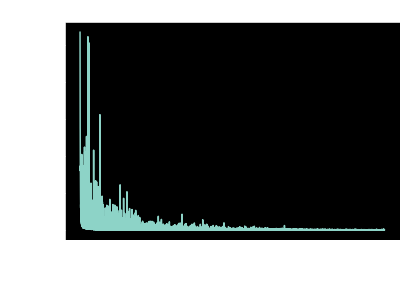

In [17]:
plt.plot(10*np.arange(len(model.loss_log)-30), model.loss_log[30:])
plt.xlabel(r'$Epoch$')
plt.ylabel(r'$Loss$')
plt.title('Loss/Epoch')

plt.show()

In [12]:
# Test data
nn = 500
x = np.linspace(res_coords[0, 0], res_coords[1, 0], nn)[:, None]
t = np.linspace(res_coords[0, 1], res_coords[1, 1], nn)[:, None]
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Exact solution
u_star = u(X_star)

# Prediction
u_pred = model.predict_u(X_star)

Relative L2 error_u: 1.47e-04


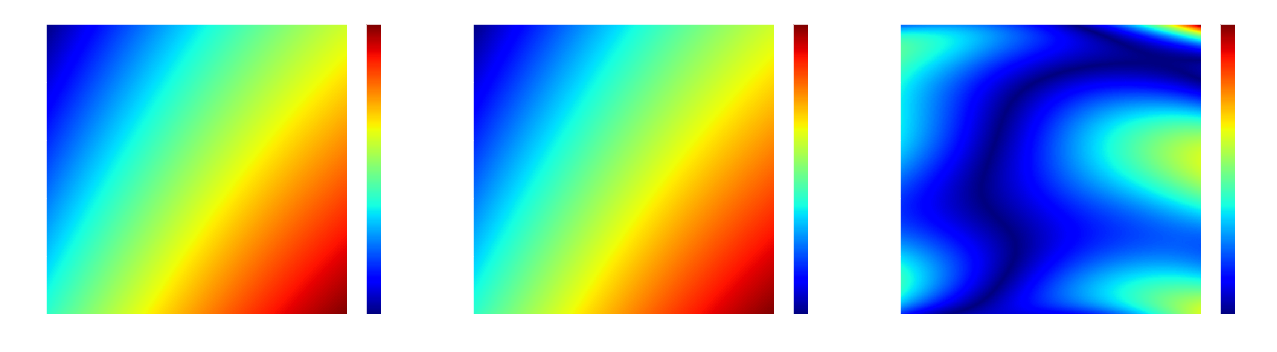

In [13]:
# Errors
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
                
fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(X, T, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title('Exact $u(x,t)$')
    
plt.subplot(1, 3, 2)
plt.pcolor(X, T, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title('Predicted $u(x,t)$')

plt.subplot(1, 3, 3)
plt.pcolor(X, T, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar(format='%.0e')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title('Absolute Error')
    
plt.tight_layout()
plt.show()